<Body>   
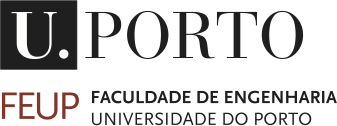   
<h1> <b>Computer Vision </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# Semantic Segmentation in Pytorch

## Introduction

What is segmentation in the first place?

> $\color{green}{Semantic\textit{ }segmentation}$ refers to the pixel-wise classification of an image, wherein each pixel is assigned a label corresponding to a predefined semantic class.

For instance, in the context of urban scene understanding, a semantic segmentation model categorizes each pixel as belonging to classes such as road, vehicle, pedestrian, or building, thereby producing a dense prediction map that reflects the semantic structure of the scene.


In pratical terms, it is partitioning an image into clusters of ‘similar’ pixel. $\color{green}{Semantic\textit{ }segmentation}$ aims to recognize, understand what's in the image in pixel-level.

Example of figure 1: "Two persons riding on a bike and there are 3 cars in their left side" (see figure 1).



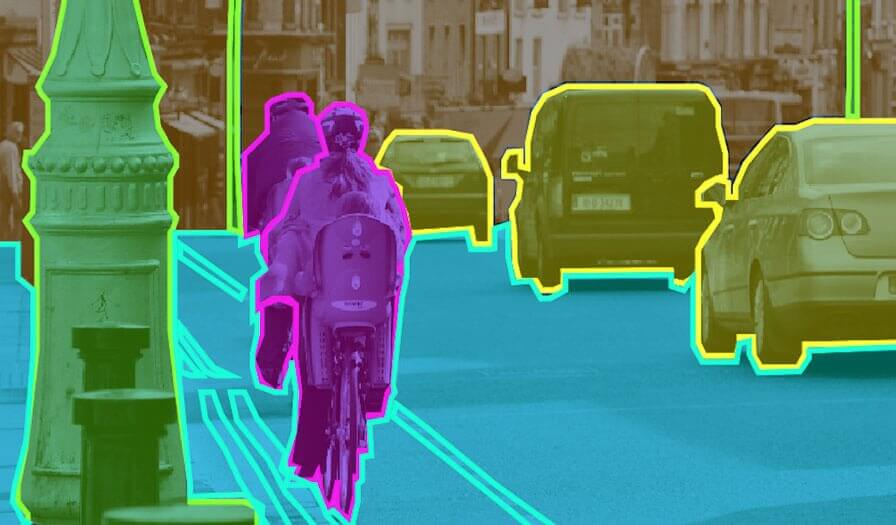

(Figure 1)

> Early ideas for the transition between classification to segmentation:
* do a classification on each superpixel.

This motivates exploring the use of CNNs for pixel-level labelling problems. The key insight is to learn a strong feature representation end-to-end for the pixel-level labelling task instead of hand-crafting features with heuristic parameter tuning. Thus, it is possible to use a Fully Convolutional Networks for Semantic Segmentation (see figure 2).

Adapting CNNs designed for high level computer vision tasks such as object recognition to pixel-level labelling tasks brings some $\color{green}{challenges}$ related to (see figure 3):

* CNNs have convolutional filters with large receptive fields and hence **produce coarse outputs when restructured to produce pixel-level labels**. The presence of maxpooling layers in CNNs further reduces the chance of getting a fine segmentation output. This can result in non-sharp boundaries and blob-like shapes in semantic segmentation tasks.
* CNNs lack smoothness constraints that encourage label agreement between similar pixels, and spatial and appearance consistency of the labelling output. Lack of such smoothness constraints can result **in poor object delineation and small spurious regions** in the segmentation output.


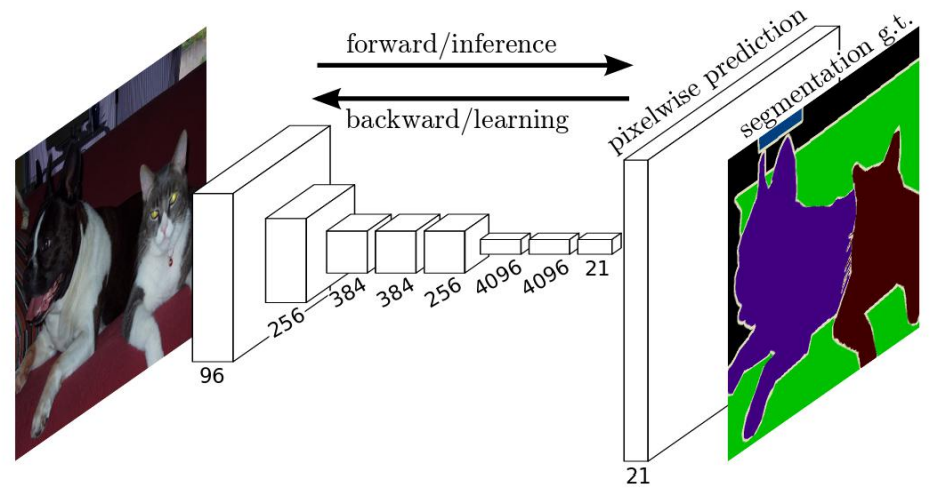

(Figure 2)

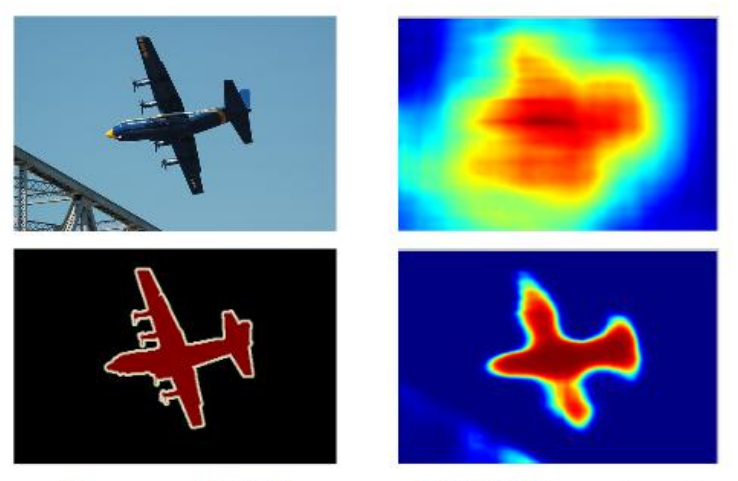

(Figure 3: Image and GT on the left,  and, CNN output on the right)


Complementing the CNN, probabilistic graphical models have been developed as effective methods to enhance the accuracy of pixel-level labelling tasks. In particular, Markov Random Fields
(MRFs) and its variant Conditional Random Fields (CRFs).
> The key idea of CRF inference for semantic labelling is to formulate the label assignment problem as a probabilistic inference problem that incorporates assumptions such as the label agreement between similar pixels. CRF inference is able to refine weak and coarse pixel-level label predictions to produce sharp boundaries and fine-grained segmentations.

These probabilistic approaches are a bit out of scope for this notebook. Read article [1] for additional information about the topic.

Finally, the design of networks that relies on convolutional layers with downsampling and upsampling layers has provided good results as well. The most well know model is called U-Net.

This notebook will:
1. Explore the U-Net architecture
2. Implement semantic segmentation using U-Net


# Encoder-Decoder: U-Net architecture

The figure 4 represents a typical U-Net model where the input image is of the shape 3 x 96 x 128. In this example, the number of classes present in the image is 21, this means that the output needs to have 21 channels.
> The U-Net model is formed by 3 parts: 1) Encoding; 2) Decoding; and, 3) Output segmentation map.

An innovative feature of U-Net model is the skip connections (shown with grey arrows - Torch cat), which enable the flow of information from the encoder side to the decoder side, enabling the model to make better predictions.

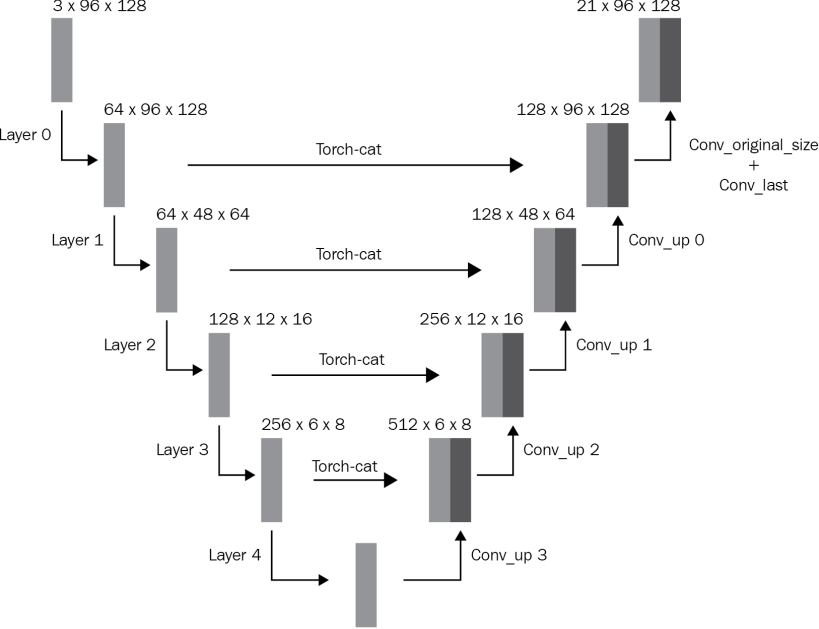

(Figure 4. U-Net architecture. Figure from the book. The schematic of the model is merely representative since it is not used or implemented below.)

1. $\color{yellow}{Encoding}$ Part is a simple convolution network that keeps reducing the size of image while the number of channels keeps increasing.

For example: two 3x3 Convolution layers followed by a Relu activation function are stacked together (Sequentially) and a 2x2 maxpool layer is applied after that.

2. $\color{yellow}{Decoding}$ part is upscaling the downscaled image, back to the original height and width but with as many channels as there are classes. While upscaling, feature information from the left side is combined with the right side image using **skip connections**, which aims to preserve the structure/objects in the original image.

For example: two 3x3 Convolution layers stacked together (Sequentially) like left side but there is no maxpool layer used, instead a 2x2 Transpose convolution layer is used.

3. $\color{yellow}{Output\text{ }segmentation\text{ }map}$ is obtained by an extra convolution layer.

For example: at the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.



## What is upscaling ?

The upscaling is performed using the [`nn.ConvTranspose2d` method](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), which takes the number of input channels, the number of output channels, the kernel size, and stride as input parameters.

An example calculation for `ConvTranspose2d` is as follows:  input array of shape 3 x 3 (Input array), applied a stride of 2 where we distributed the input values to accommodate the stride, padded the array with zeros, and convolved the padded input with a filter (Filter/Kernel) to fetch the output array.
> the optimal filter values learn to reconstruct the original image as much as possible. The filter weights and bias are optimized during the model training process.

## ConvTranspose2d Example

We will use the following parameters:

- **Input size**: $(3 \times 3)$
- **Kernel size**: $(3 \times 3)$
- **Stride**: 2
- **Padding**: 0
- **Output padding**: 0
- **No bias**
- **All kernel weights** = 1 (for simplicity)

### 1. Input Tensor

Consider the following 3x3 input tensor:

$
\text{Input} =
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
$



---

### 2. Output Size Calculation

For a **transposed convolution** with kernel size $(3 \times 3)$, stride \(2\), and no padding, the output size is calculated as:

$\color{blue}{
\text{out} = (\text{in} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel size} + \text{output padding}}
$

Substituting the values:

$
(3 - 1) \times 2 - 0 + 3 = 2 \times 2 + 3 = 7
$

Thus, the output shape will be $(7 \times 7)$.

---

### 3. Upsampling (Stride 2)

With a stride of 2, the input grid is conceptually **upsampled** by inserting zeros between elements, leading to a larger grid before applying the kernel. The result after the stride operation would look like:

$
\begin{bmatrix}
1 & 0 & 2 & 0 & 3 \\
0 & 0 & 0 & 0 & 0 \\
4 & 0 & 5 & 0 & 6 \\
0 & 0 & 0 & 0 & 0 \\
7 & 0 & 8 & 0 & 9
\end{bmatrix}
$

>Note: The actual convolution in a transposed convolution operation is performed by applying the kernel to an upsampled version of the input, where zeros are implicitly inserted between the original values. To enable the learned kernel in ConvTranspose2d to properly operate at the borders, the upsampled grid is effectively padded with zeros around the edge.

---

### 4. Output Tensor (Conceptual)

The resulting output of applying a $(3 \times 3)$ kernel of ones over this upsampled grid would look something like this:

$
\text{Output} =
\begin{bmatrix}
1 & 1 & 3 & 2 & 5 & 3 & 3 \\
1 & 1 & 3 & 2 & 5 & 3 & 3 \\
5 & 5 & 12 & 7 & 16 & 9 & 9 \\
4 & 4 & 9 & 5 & 11 & 6 & 6 \\
11 & 11 & 24 & 13 & 28 & 15 & 15 \\
7 & 7 & 15 & 8 & 17 & 9 & 9 \\
7 & 7 & 15 & 8 & 17 & 9 & 9
\end{bmatrix}
$

This is a **conceptual** output based on kernel size, stride, and input size.

---

Here's how you can implement this in PyTorch:



In [ ]:
import torch
import torch.nn as nn

# Input: 3x3
input = torch.tensor([[[[1., 2., 3.],
                        [4., 5., 6.],
                        [7., 8., 9.]]]])

# Transposed convolution layer
deconv = nn.ConvTranspose2d(
    in_channels=1, out_channels=1,
    kernel_size=3, stride=2, padding=0, bias=False, padding_mode='zeros'
)

# Define a custom kernel (e.g., a simple 3x3 kernel with specific values)
custom_kernel = torch.tensor([[[[1.0, 1.0, 1.0],
                                [1.0, 1.0, 1.0],
                                [1.0, 1.0, 1.0]]]])

# Set the custom kernel weights
deconv.weight.data = custom_kernel

# Verify the custom kernel is applied
#print("Custom Kernel:")
#print(deconv.weight.data)

# Apply deconvolution
output = deconv(input)
print("ConvTranspose2d Kernel:")
print(output.shape)  # Should be (1, 1, 7, 7)
print(output[0, 0])  # Print output matrix

## Implementing semantic segmentation

In [ ]:
!pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

# downloading datasets
import os
if not os.path.exists('dataset1'):
    !wget --output-document=dataset1.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EZdCaL2IMHVKnXat45lkhbEB2Blzvv0CnJ8Ec8Qts3WhMA?download=1"
    !unzip -q dataset1.zip
    !rm dataset1.zip


# enabling GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 62 kB 663 kB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 58 kB 6.7 MB/s 
     |████████████████████████████████| 237 kB 32.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.1 MB/s 
     |████████████████████████████████| 170 kB 76.3 MB/s 
     |████████████████████████████████| 2.2 MB 55.9 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
--2022-10-11 20:26:59--  https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/Ea3iZsuffmJJiMgLZf9G3DIBrqpj0forsiY7YWRIx1UC4g?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up488707_up_pt/Documents/AULAS/UC_CV/Static_Resources/Datasets/dataset1.zip?ga=1 [following]
--2022-10-11 20:26:59--  https://uporto-my.sh

In [ ]:
# Data augmentation / Normalization
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]
                                 ) # for imagenet
                             ])
tfms = get_transforms()

### Define the "Dataset Class"

Start by importing the Dataset class from the `torch.utils.data` module. Each PyTorch dataset is required to inherit from Dataset class  and should have a `__len__` and a `__getitem__` method.

Some implementation notes:
* `__init__` specifies the image location.
* `__len__` specifies the length of the dataset.
* `__getitem__` loads an image and mask and resizes both the input (image) and output (mask) images so that they're the same shape.
* The mask images from this dataset contain integers that range between [0,11]
* Define a function (`choose`) for selecting a random image index. This is mainly for debugging purposes.
* Define the `collate_fn` method for performing preprocessing on a batch of images.

In [ ]:
import torch.utils.data as data
class SegmentationDataset(data.Dataset):
    def __init__(self, split, transforms):
      	# Specify the folder that contains images i
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.items)

    def __getitem__(self, ix):
        # load the image from disk
        image = cv2.imread(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))


        # read the associated mask from disk in grayscale mode
        mask = cv2.imread(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224))

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # grab the image path from the current index
        return image, mask

    def choose(self):
      return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

### Define the training and validation datasets, and dataloaders

In [ ]:
# Create instances for training and validation sets.
trn_ds = SegmentationDataset(split = 'train', transforms=None)
val_ds = SegmentationDataset(split = 'test', transforms=None)

batch_size = 4

# Dataloaders
trn_dl = data.DataLoader(trn_ds, batch_size=batch_size, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=val_ds.collate_fn)

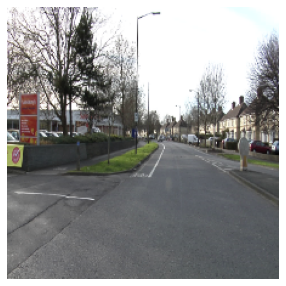

In [ ]:
show(trn_ds[10][0])

# Define the U-Net Model

The `torchvision.models` is a [subpackage](https://pytorch.org/vision/stable/models.html) that has definitions of many models suitable for image classification, pixel-wise semantic segmentation, object detection, instance segmentation, person keypoint detection, video classification, and optical flow.

VGG-16 is a convolutional neural network that is 16 layers deep. It is possible to load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

Loading the pretrained model [vgg16_bn](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html) aims to accelerate the training procedure since it takes into consideration the weights already learnt. The implementation of VGG model can be confirmed [here](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py).  

The VGG16 with Batch Normalization model is used the encoder layer of the architecture. Several blocks need to be obtained for the encoder layer.




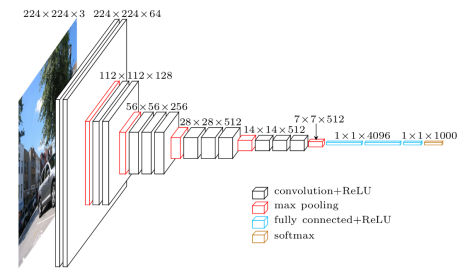

(Figure: VGG architecture)

## 1. VGG16 as Encoder (Downsampling Path)

VGG16 consists of 5 convolutional blocks, each followed by max pooling. The spatial dimensions reduce by half at each step, while the depth increases.

Note that Pytorch uses tensors with (B $\times$ C$\times$ H $\times$ W), where:
* B = Batch size (number of images)
* C = Number of channels (e.g., 3 for RGB, 1 for grayscale)
* H = Height (rows)
* W = Width (columns)


| Layer              | Output Size (H × W × C)    | Description                  |
|-------------------|----------------------------|------------------------------|
| Input              | \(224 $\times$ 224 $\times$ 3\)  | RGB image                    |
| Conv1 + MaxPool    | \(112 $\times$ 112 $\times$ 64\) | 2 conv layers + pooling      |
| Conv2 + MaxPool    | \(56 $\times$ 56 $\times$ 128\)  | 2 conv layers + pooling      |
| Conv3 + MaxPool    | \(28 $\times$ 28 $\times$ 256\)  | 3 conv layers + pooling      |
| Conv4 + MaxPool    | \(14 $\times$ 14 $\times$ 512\)  | 3 conv layers + pooling      |
| Conv5 + MaxPool    | \(7 $\times$ 7 $\times$ 512\)    | 3 conv layers + pooling      |

---



## 2. U-Net Decoder (Upsampling Path)

The decoder upsamples the feature maps using **transposed convolutions** (or upsampling + conv). At each stage, **skip connections** concatenate features from the corresponding encoder layer.

| Step     | Output Size              | Skip Connection From       |
|----------|--------------------------|----------------------------|
| Upconv1  | \(14 $\times$ 14 $\times$ 512\)  | Conv4 (\(14 $\times$ 14 $\times$ 512\)) |
| Upconv2  | \(28 $\times$ 28 $\times$ 256\)  | Conv3 (\(28 $\times$ 28 $\times$ 256\)) |
| Upconv3  | \(56 $\times$ 56 $\times$ 128\)  | Conv2 (\(56 $\times$ 56 $\times$ 128\)) |
| Upconv4  | \(112 $\times$ 112 $\times$ 64\) | Conv1 (\(112 $\times$ 112 $\times$ 64\)) |
| Upconv5  | \(224 $\times$ 224 $\times$ C\)  | Final prediction layer      |

---


## 3. Final Layer

The final layer is typically a \(1 $\times$ 1\) convolution to reduce the depth to the number of **classes** \(C\).  
So, the output shape becomes:

\[
224 $\times$ 224 $\times$ C
\]

---

## 4. Implementation

In [ ]:
# Sequential operations of Conv2d -> BatchNorm -> ActivationFunction
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
#  ConvTranspose2d upscale the images.
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        # Encoding
        self.encoder = vgg16_bn(pretrained=pretrained).features   #nn.Sequential behaves like python list of all layers (so can be sliced)
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        # Decoding
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)

        # Output layer
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1) # skip connection
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1) # skip connection
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1) # skip connection
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1) # skip connection
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1) # skip connection
        x = self.conv10(x)

        x = self.conv11(x)

        return x

### Define Loss function

In [ ]:
# Define the loss function
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

### Define Training procedure

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

### Train the model

In [ ]:
# Define the model, optimizer, loss function, and the number of epochs
model = UNet().to(device)

criterion = UnetLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

# Uncomment:
# model.encoder

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Train the model over increasing epochs
log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

for ex in range(n_epochs):
    N = len(trn_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
    log_train_loss.append(loss_avg/N)
    log_train_acc.append(acc_avg/(N*batch_size))

    N = len(val_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
    log_val_loss.append(loss_avg/N)
    log_val_acc.append(acc_avg/(N*batch_size))


0.010869565217391304   Loss= 2.4592339992523193 Accuracy= 0.15779456496238708

0.021739130434782608   Loss= 2.1815826892852783 Accuracy= 0.46789300441741943

0.03260869565217391   Loss= 2.1029512882232666 Accuracy= 0.42619478702545166

0.043478260869565216   Loss= 2.081224203109741 Accuracy= 0.4128168821334839

0.05434782608695652   Loss= 1.8170568943023682 Accuracy= 0.6366689205169678

0.06521739130434782   Loss= 1.727592945098877 Accuracy= 0.6758111119270325

0.07608695652173914   Loss= 1.702951431274414 Accuracy= 0.6888552308082581

0.08695652173913043   Loss= 1.7550984621047974 Accuracy= 0.6393893361091614

0.09782608695652174   Loss= 1.7012277841567993 Accuracy= 0.6509237289428711

0.10869565217391304   Loss= 1.670437216758728 Accuracy= 0.6368134021759033

0.11956521739130435   Loss= 1.5630066394805908 Accuracy= 0.7472496628761292

0.13043478260869565   Loss= 1.6187608242034912 Accuracy= 0.6499422192573547

0.14130434782608695   Loss= 1.4994945526123047 Accuracy= 0.7506825923919678

0.15217391304347827   Loss= 1.507351279258728 Accuracy= 0.732352077960968

0.16304347826086957   Loss= 1.5627919435501099 Accuracy= 0.7022380828857422

0.17391304347826086   Loss= 1.5067096948623657 Accuracy= 0.7179527878761292

0.18478260869565216   Loss= 1.4883533716201782 Accuracy= 0.7094676494598389

0.1956521739130435   Loss= 1.579136610031128 Accuracy= 0.6574806571006775

0.20652173913043478   Loss= 1.4310555458068848 Accuracy= 0.7579918503761292

0.21739130434782608   Loss= 1.4762725830078125 Accuracy= 0.7100605964660645

0.22826086956521738   Loss= 1.551730990409851 Accuracy= 0.6577397584915161

0.2391304347826087   Loss= 1.4324276447296143 Accuracy= 0.7364426851272583

0.25   Loss= 1.378572702407837 Accuracy= 0.7429797053337097

0.2608695652173913   Loss= 1.3296446800231934 Accuracy= 0.7818130254745483

0.2717391304347826   Loss= 1.2867203950881958 Accuracy= 0.77250075340271

0.2826086956521739   Loss= 1.3763965368270874 Accuracy= 0.7151825428009033

0.29347826086956524   Loss= 1.3091185092926025 Accuracy= 0.7375836968421936

0.30434782608695654   Loss= 1.3349324464797974 Accuracy= 0.7186204195022583

0.31521739130434784   Loss= 1.2299305200576782 Accuracy= 0.77958083152771

0.32608695652173914   Loss= 1.2087119817733765 Accuracy= 0.792654812335968

0.33695652173913043   Loss= 1.1915956735610962 Accuracy= 0.7842743396759033

0.34782608695652173   Loss= 1.2372336387634277 Accuracy= 0.7999939918518066

0.358695652173913   Loss= 1.208897352218628 Accuracy= 0.7809261083602905

0.3695652173913043   Loss= 1.0922462940216064 Accuracy= 0.8384585976600647

0.3804347826086957   Loss= 1.1970564126968384 Accuracy= 0.7654805183410645

0.391304347826087   Loss= 1.0957040786743164 Accuracy= 0.8217822909355164

0.40217391304347827   Loss= 1.1506397724151611 Accuracy= 0.7913793325424194

0.41304347826086957   Loss= 1.110068440437317 Accuracy= 0.8142986297607422

0.42391304347826086   Loss= 1.1441905498504639 Accuracy= 0.7902582883834839

0.43478260869565216   Loss= 1.0868349075317383 Accuracy= 0.8034617900848389

0.44565217391304346   Loss= 1.234369158744812 Accuracy= 0.7218839526176453

0.45652173913043476   Loss= 1.1448516845703125 Accuracy= 0.7571647763252258

0.4673913043478261   Loss= 1.0648987293243408 Accuracy= 0.814383327960968

0.4782608695652174   Loss= 1.1578069925308228 Accuracy= 0.7537418007850647

0.4891304347826087   Loss= 1.004333734512329 Accuracy= 0.8216278553009033

0.5   Loss= 1.089895248413086 Accuracy= 0.7731983065605164

0.5108695652173914   Loss= 0.9964917302131653 Accuracy= 0.8181600570678711

0.5217391304347826   Loss= 1.0754703283309937 Accuracy= 0.7539759874343872

0.532608695652174   Loss= 1.0734609365463257 Accuracy= 0.7687838673591614

0.5434782608695652   Loss= 0.9472818374633789 Accuracy= 0.8391411900520325

0.5543478260869565   Loss= 1.0086740255355835 Accuracy= 0.8001783490180969

0.5652173913043478   Loss= 0.9664599299430847 Accuracy= 0.8234713673591614

0.5760869565217391   Loss= 1.0290043354034424 Accuracy= 0.7841597199440002

0.5869565217391305   Loss= 0.9401705861091614 Accuracy= 0.8231674432754517

0.5978260869565217   Loss= 0.9014294743537903 Accuracy= 0.8309450745582581

0.6086956521739131   Loss= 0.8905927538871765 Accuracy= 0.8388522267341614

0.6195652173913043   Loss= 1.167075276374817 Accuracy= 0.6884565949440002

0.6304347826086957   Loss= 0.9579518437385559 Accuracy= 0.7950165271759033

0.6413043478260869   Loss= 0.9205448627471924 Accuracy= 0.8228535652160645

0.6521739130434783   Loss= 1.1519263982772827 Accuracy= 0.7442601919174194

0.6630434782608695   Loss= 1.0641133785247803 Accuracy= 0.7615493535995483

0.6739130434782609   Loss= 0.9181988835334778 Accuracy= 0.8255739808082581

0.6847826086956522   Loss= 0.8926986455917358 Accuracy= 0.8275071382522583

0.6956521739130435   Loss= 0.9011361002922058 Accuracy= 0.8144680261611938

0.7065217391304348   Loss= 0.8517859578132629 Accuracy= 0.8461614847183228

0.717391304347826   Loss= 0.7819100022315979 Accuracy= 0.8656229972839355

0.7282608695652174   Loss= 0.8903268575668335 Accuracy= 0.8123455047607422

0.7391304347826086   Loss= 0.9750633835792542 Accuracy= 0.7748973369598389

0.75   Loss= 1.1561660766601562 Accuracy= 0.6999661326408386

0.7608695652173914   Loss= 1.0797224044799805 Accuracy= 0.7210668325424194

0.7717391304347826   Loss= 1.0389527082443237 Accuracy= 0.7467165589332581

0.782608695652174   Loss= 0.8018694519996643 Accuracy= 0.8529525995254517

0.7934782608695652   Loss= 0.8838948011398315 Accuracy= 0.8058134913444519

0.8043478260869565   Loss= 0.9261891841888428 Accuracy= 0.7971540093421936

0.8152173913043478   Loss= 0.8212241530418396 Accuracy= 0.825927734375

0.8260869565217391   Loss= 0.8622673153877258 Accuracy= 0.8104223012924194

0.8369565217391305   Loss= 0.7110447883605957 Accuracy= 0.8775659203529358

0.8478260869565217   Loss= 0.7444332838058472 Accuracy= 0.8644222021102905

0.8586956521739131   Loss= 0.9372705221176147 Accuracy= 0.7819674611091614

0.8695652173913043   Loss= 0.7203196883201599 Accuracy= 0.8654286861419678

0.8804347826086957   Loss= 0.741876482963562 Accuracy= 0.8556580543518066

0.8913043478260869   Loss= 0.745300829410553 Accuracy= 0.8460419178009033

0.9021739130434783   Loss= 0.7334689497947693 Accuracy= 0.8425242900848389

0.9130434782608695   Loss= 0.8284576535224915 Accuracy= 0.7980657815933228

0.9239130434782609   Loss= 0.7243757247924805 Accuracy= 0.8575264811515808

0.9347826086956522   Loss= 0.8329107165336609 Accuracy= 0.8022062182426453

0.9456521739130435   Loss= 0.7368324398994446 Accuracy= 0.8431869745254517

0.9565217391304348   Loss= 0.825035572052002 Accuracy= 0.814851701259613

0.967391304347826   Loss= 0.7288177013397217 Accuracy= 0.8450554013252258

0.9782608695652174   Loss= 0.7614760398864746 Accuracy= 0.8251106142997742

0.9891304347826086   Loss= 0.8519943952560425 Accuracy= 0.7954699397087097

1.0   Loss= 0.8319960832595825 Accuracy= 0.80765700340271

0.038461538461538464   Loss= 0.8595662117004395 Accuracy= 0.7980857491493225

0.07692307692307693   Loss= 0.8557558059692383 Accuracy= 0.8097895383834839

0.11538461538461539   Loss= 0.8185051679611206 Accuracy= 0.825369656085968

0.15384615384615385   Loss= 0.841587483882904 Accuracy= 0.8221111297607422

0.19230769230769232   Loss= 0.8673667311668396 Accuracy= 0.7971341013908386

0.23076923076923078   Loss= 0.8270362019538879 Accuracy= 0.8183494210243225

0.2692307692307692   Loss= 0.7739207148551941 Accuracy= 0.8322454690933228

0.3076923076923077   Loss= 0.8621110916137695 Accuracy= 0.7962272763252258

0.34615384615384615   Loss= 0.7949361801147461 Accuracy= 0.8349658846855164

0.38461538461538464   Loss= 0.8247172832489014 Accuracy= 0.825215220451355

0.4230769230769231   Loss= 0.8332002758979797 Accuracy= 0.817781388759613

0.46153846153846156   Loss= 0.8542026877403259 Accuracy= 0.8022710084915161

0.5   Loss= 0.8603841066360474 Accuracy= 0.8116031289100647

0.5384615384615384   Loss= 0.8366615772247314 Accuracy= 0.8039052486419678

0.5769230769230769   Loss= 0.9051885604858398 Accuracy= 0.7772988677024841

0.6153846153846154   Loss= 0.8401211500167847 Accuracy= 0.8129783272743225

0.6538461538461539   Loss= 0.8369569778442383 Accuracy= 0.8096699714660645

0.6923076923076923   Loss= 0.8827519416809082 Accuracy= 0.7947673797607422

0.7307692307692307   Loss= 0.8821929693222046 Accuracy= 0.7859334945678711

0.7692307692307693   Loss= 0.7810763716697693 Accuracy= 0.8388173580169678

0.8076923076923077   Loss= 0.8818273544311523 Accuracy= 0.796805202960968

0.8461538461538461   Loss= 0.8071017861366272 Accuracy= 0.8379852771759033

0.8846153846153846   Loss= 0.7838711738586426 Accuracy= 0.8331174254417419

0.9230769230769231   Loss= 0.7715286016464233 Accuracy= 0.8378158807754517

0.9615384615384616   Loss= 0.8319160342216492 Accuracy= 0.8176618218421936

1.0   Loss= 0.896406352519989 Accuracy= 0.7765066623687744

1.0108695652173914   Loss= 0.6378321647644043 Accuracy= 0.8750149011611938

1.0217391304347827   Loss= 0.7951509356498718 Accuracy= 0.8066954016685486

1.0326086956521738   Loss= 0.8351126909255981 Accuracy= 0.8046675324440002

1.0434782608695652   Loss= 0.7247585654258728 Accuracy= 0.8436204195022583

1.0543478260869565   Loss= 0.6848923563957214 Accuracy= 0.8553889989852905

1.065217391304348   Loss= 0.793113648891449 Accuracy= 0.8153349757194519

1.0760869565217392   Loss= 0.7552583813667297 Accuracy= 0.8019819855690002

1.0869565217391304   Loss= 0.6895391345024109 Accuracy= 0.8484135866165161

1.0978260869565217   Loss= 0.7776975631713867 Accuracy= 0.8146324753761292

1.108695652173913   Loss= 0.6450375318527222 Accuracy= 0.86844801902771

1.1195652173913044   Loss= 0.793677806854248 Accuracy= 0.8023008704185486

1.1304347826086956   Loss= 0.589705228805542 Accuracy= 0.898213267326355

1.141304347826087   Loss= 0.8351420760154724 Accuracy= 0.7908661365509033

1.1521739130434783   Loss= 0.6048244833946228 Accuracy= 0.8670927882194519

1.1630434782608696   Loss= 0.6346536874771118 Accuracy= 0.8721848726272583

1.1739130434782608   Loss= 0.7096943855285645 Accuracy= 0.8478655219078064

1.184782608695652   Loss= 0.8043078780174255 Accuracy= 0.801199734210968

1.1956521739130435   Loss= 0.8130004405975342 Accuracy= 0.7878667116165161

1.2065217391304348   Loss= 0.9174572825431824 Accuracy= 0.7625607848167419

1.2173913043478262   Loss= 0.620408833026886 Accuracy= 0.8639638423919678

1.2282608695652173   Loss= 0.5956721305847168 Accuracy= 0.8765395879745483

1.2391304347826086   Loss= 0.8394263982772827 Accuracy= 0.7781807780265808

1.25   Loss= 0.6669230461120605 Accuracy= 0.8511838316917419

1.2608695652173914   Loss= 0.9171622395515442 Accuracy= 0.7498804330825806

1.2717391304347827   Loss= 0.7323024272918701 Accuracy= 0.8277812004089355

1.2826086956521738   Loss= 0.6677670478820801 Accuracy= 0.8401476740837097

1.2934782608695652   Loss= 0.695589005947113 Accuracy= 0.8109554052352905

1.3043478260869565   Loss= 0.7242014408111572 Accuracy= 0.816162109375

1.315217391304348   Loss= 0.542306661605835 Accuracy= 0.8976801633834839

1.3260869565217392   Loss= 0.6467928886413574 Accuracy= 0.8514429330825806

1.3369565217391304   Loss= 0.6397674679756165 Accuracy= 0.8471131324768066

1.3478260869565217   Loss= 0.6204226016998291 Accuracy= 0.8395198583602905

1.358695652173913   Loss= 0.6828539371490479 Accuracy= 0.8215082883834839

1.3695652173913042   Loss= 0.5915518999099731 Accuracy= 0.8516970276832581

1.3804347826086958   Loss= 0.6434448957443237 Accuracy= 0.83768630027771

1.391304347826087   Loss= 0.5774311423301697 Accuracy= 0.8723841905593872

1.4021739130434783   Loss= 0.6749809384346008 Accuracy= 0.8192861080169678

1.4130434782608696   Loss= 0.5955509543418884 Accuracy= 0.8548010587692261

1.4239130434782608   Loss= 0.6242008805274963 Accuracy= 0.8521006107330322

1.434782608695652   Loss= 0.6634641289710999 Accuracy= 0.8287178874015808

1.4456521739130435   Loss= 0.7680094242095947 Accuracy= 0.7911501526832581

1.4565217391304348   Loss= 0.7492494583129883 Accuracy= 0.8164211511611938

1.4673913043478262   Loss= 0.7362396717071533 Accuracy= 0.8118771910667419

1.4782608695652173   Loss= 0.7789552807807922 Accuracy= 0.7975027561187744

1.4891304347826086   Loss= 0.9368231892585754 Accuracy= 0.7302196025848389

1.5   Loss= 0.7606319785118103 Accuracy= 0.7902333736419678

1.5108695652173914   Loss= 0.660038411617279 Accuracy= 0.8291613459587097

1.5217391304347827   Loss= 0.7518537640571594 Accuracy= 0.8041194677352905

1.5326086956521738   Loss= 0.675451397895813 Accuracy= 0.8382692933082581

1.5434782608695652   Loss= 0.623478889465332 Accuracy= 0.8652941584587097

1.5543478260869565   Loss= 0.6225795149803162 Accuracy= 0.8492057919502258

1.5652173913043477   Loss= 0.572641909122467 Accuracy= 0.8666892647743225

1.5760869565217392   Loss= 0.6800541877746582 Accuracy= 0.8281349539756775

1.5869565217391304   Loss= 0.6868731379508972 Accuracy= 0.8195202946662903

1.5978260869565217   Loss= 1.0262318849563599 Accuracy= 0.6964036226272583

1.608695652173913   Loss= 0.6863881945610046 Accuracy= 0.8288374543190002

1.6195652173913042   Loss= 0.6761947274208069 Accuracy= 0.8328682780265808

1.6304347826086958   Loss= 0.7490423321723938 Accuracy= 0.8191017508506775

1.641304347826087   Loss= 0.7184303998947144 Accuracy= 0.8159677982330322

1.6521739130434783   Loss= 0.5944912433624268 Accuracy= 0.8586276173591614

1.6630434782608696   Loss= 0.7565496563911438 Accuracy= 0.78690505027771

1.6739130434782608   Loss= 0.5725321769714355 Accuracy= 0.8717962503433228

1.6847826086956523   Loss= 0.8667909502983093 Accuracy= 0.7660734057426453

1.6956521739130435   Loss= 0.6356382966041565 Accuracy= 0.8424196839332581

1.7065217391304348   Loss= 0.6815195679664612 Accuracy= 0.8156339526176453

1.7173913043478262   Loss= 0.6413125991821289 Accuracy= 0.8352798223495483

1.7282608695652173   Loss= 0.8706175088882446 Accuracy= 0.7593221664428711

1.7391304347826086   Loss= 0.6582850217819214 Accuracy= 0.8324597477912903

1.75   Loss= 0.547706127166748 Accuracy= 0.8681092262268066

1.7608695652173914   Loss= 0.7406682968139648 Accuracy= 0.7915088534355164

1.7717391304347827   Loss= 0.5408178567886353 Accuracy= 0.8678202629089355

1.7826086956521738   Loss= 0.6566352248191833 Accuracy= 0.8240742683410645

1.7934782608695652   Loss= 0.82854825258255 Accuracy= 0.7292430400848389

1.8043478260869565   Loss= 0.5654568076133728 Accuracy= 0.8597586154937744

1.8152173913043477   Loss= 0.6407670378684998 Accuracy= 0.8319166302680969

1.8260869565217392   Loss= 0.5921570658683777 Accuracy= 0.8497339487075806

1.8369565217391304   Loss= 0.518552303314209 Accuracy= 0.8817263245582581

1.8478260869565217   Loss= 0.5284630656242371 Accuracy= 0.8703762292861938

1.858695652173913   Loss= 0.5058175325393677 Accuracy= 0.8808842897415161

1.8695652173913042   Loss= 0.5360575318336487 Accuracy= 0.8687918186187744

1.8804347826086958   Loss= 0.7649025321006775 Accuracy= 0.7906469106674194

1.891304347826087   Loss= 0.5677671432495117 Accuracy= 0.85331130027771

1.9021739130434783   Loss= 0.5887153744697571 Accuracy= 0.8502770066261292

1.9130434782608696   Loss= 0.6064655780792236 Accuracy= 0.8381297588348389

1.9239130434782608   Loss= 0.6251053810119629 Accuracy= 0.8426139950752258

1.9347826086956523   Loss= 0.6523758769035339 Accuracy= 0.8236956000328064

1.9456521739130435   Loss= 0.7091100811958313 Accuracy= 0.8003576993942261

1.9565217391304348   Loss= 0.6398098468780518 Accuracy= 0.8325793147087097

1.9673913043478262   Loss= 0.6402900815010071 Accuracy= 0.8296197056770325

1.9782608695652173   Loss= 0.6016125082969666 Accuracy= 0.849275529384613

1.9891304347826086   Loss= 0.7095074653625488 Accuracy= 0.8111945986747742

2.0   Loss= 0.5054763555526733 Accuracy= 0.8874827027320862

1.0384615384615385   Loss= 0.6761385798454285 Accuracy= 0.8193408846855164

1.0769230769230769   Loss= 0.7278763055801392 Accuracy= 0.8063616156578064

1.1153846153846154   Loss= 0.6773142218589783 Accuracy= 0.8137954473495483

1.1538461538461537   Loss= 0.7073878049850464 Accuracy= 0.8009107708930969

1.1923076923076923   Loss= 0.7632463574409485 Accuracy= 0.7997249364852905

1.2307692307692308   Loss= 0.7864168286323547 Accuracy= 0.7777822017669678

1.2692307692307692   Loss= 0.6361323595046997 Accuracy= 0.8246023654937744

1.3076923076923077   Loss= 0.7151039242744446 Accuracy= 0.8106664419174194

1.3461538461538463   Loss= 0.6709045767784119 Accuracy= 0.822420060634613

1.3846153846153846   Loss= 0.6549331545829773 Accuracy= 0.8262466192245483

1.4230769230769231   Loss= 0.708665668964386 Accuracy= 0.8022062182426453

1.4615384615384617   Loss= 0.7399737238883972 Accuracy= 0.8042290806770325

1.5   Loss= 0.611350417137146 Accuracy= 0.8362663388252258

1.5384615384615383   Loss= 0.7057949900627136 Accuracy= 0.8024104833602905

1.5769230769230769   Loss= 0.7060697674751282 Accuracy= 0.8112344145774841

1.6153846153846154   Loss= 0.6738190054893494 Accuracy= 0.8342384696006775

1.6538461538461537   Loss= 0.6037914752960205 Accuracy= 0.8403021097183228

1.6923076923076923   Loss= 0.7141374349594116 Accuracy= 0.7998146414756775

1.7307692307692308   Loss= 0.7086552381515503 Accuracy= 0.8079808950424194

1.7692307692307692   Loss= 0.5164735317230225 Accuracy= 0.8756726384162903

1.8076923076923077   Loss= 0.6976691484451294 Accuracy= 0.8121013641357422

1.8461538461538463   Loss= 0.7145528793334961 Accuracy= 0.805086076259613

1.8846153846153846   Loss= 0.6947476863861084 Accuracy= 0.8287976384162903

1.9230769230769231   Loss= 0.5714895725250244 Accuracy= 0.8570332527160645

1.9615384615384617   Loss= 0.6636868715286255 Accuracy= 0.8264608383178711

2.0   Loss= 0.5826237797737122 Accuracy= 0.8436503410339355

2.010869565217391   Loss= 0.5414273738861084 Accuracy= 0.8543526530265808

2.0217391304347827   Loss= 0.42454391717910767 Accuracy= 0.9064741730690002

2.032608695652174   Loss= 0.6247707009315491 Accuracy= 0.8317024111747742

2.0434782608695654   Loss= 0.5537923574447632 Accuracy= 0.8556580543518066

2.0543478260869565   Loss= 0.49576592445373535 Accuracy= 0.8818209767341614

2.0652173913043477   Loss= 0.4053141474723816 Accuracy= 0.9145956039428711

2.0760869565217392   Loss= 0.43710365891456604 Accuracy= 0.9063894748687744

2.0869565217391304   Loss= 0.5353963375091553 Accuracy= 0.8700623512268066

2.097826086956522   Loss= 0.5177209973335266 Accuracy= 0.862947404384613

2.108695652173913   Loss= 0.5834770798683167 Accuracy= 0.843660295009613

2.119565217391304   Loss= 0.43438082933425903 Accuracy= 0.8982082605361938

2.130434782608696   Loss= 0.5350856184959412 Accuracy= 0.8516172766685486

2.141304347826087   Loss= 0.6391760110855103 Accuracy= 0.8295350074768066

2.1521739130434785   Loss= 0.44441819190979004 Accuracy= 0.8898476958274841

2.1630434782608696   Loss= 0.6561145186424255 Accuracy= 0.8187878727912903

2.1739130434782608   Loss= 0.6927779316902161 Accuracy= 0.7982750535011292

2.1847826086956523   Loss= 0.39627230167388916 Accuracy= 0.9111228585243225

2.1956521739130435   Loss= 0.5170071125030518 Accuracy= 0.8821099400520325

2.2065217391304346   Loss= 0.46117454767227173 Accuracy= 0.8898726105690002

2.217391304347826   Loss= 0.522034764289856 Accuracy= 0.8689512610435486

2.2282608695652173   Loss= 0.5935898423194885 Accuracy= 0.8373275995254517

2.239130434782609   Loss= 0.6720393300056458 Accuracy= 0.81180739402771

2.25   Loss= 0.5894883871078491 Accuracy= 0.8491310477256775

2.260869565217391   Loss= 0.7055795788764954 Accuracy= 0.79618239402771

2.2717391304347827   Loss= 0.7206661701202393 Accuracy= 0.7941495776176453

2.282608695652174   Loss= 0.5728437304496765 Accuracy= 0.8573969602584839

2.2934782608695654   Loss= 0.7183418869972229 Accuracy= 0.8061074614524841

2.3043478260869565   Loss= 0.5513207316398621 Accuracy= 0.8546565771102905

2.3152173913043477   Loss= 0.4963247776031494 Accuracy= 0.8785823583602905

2.3260869565217392   Loss= 0.6061877012252808 Accuracy= 0.8405113816261292

2.3369565217391304   Loss= 0.533740758895874 Accuracy= 0.8683035373687744

2.3478260869565215   Loss= 0.6356180906295776 Accuracy= 0.8238052129745483

2.358695652173913   Loss= 0.6338332891464233 Accuracy= 0.8301628232002258

2.369565217391304   Loss= 0.6012343764305115 Accuracy= 0.8520756959915161

2.380434782608696   Loss= 0.5490007400512695 Accuracy= 0.8599180579185486

2.391304347826087   Loss= 0.54460608959198 Accuracy= 0.8598881959915161

2.4021739130434785   Loss= 0.5016267895698547 Accuracy= 0.8716766834259033

2.4130434782608696   Loss= 0.6118941903114319 Accuracy= 0.8483538031578064

2.4239130434782608   Loss= 0.4806292653083801 Accuracy= 0.8638193607330322

2.4347826086956523   Loss= 0.4702616333961487 Accuracy= 0.8837791085243225

2.4456521739130435   Loss= 0.521788477897644 Accuracy= 0.8544722199440002

2.4565217391304346   Loss= 0.4239237308502197 Accuracy= 0.8944315910339355

2.467391304347826   Loss= 0.4822518825531006 Accuracy= 0.8770477771759033

2.4782608695652173   Loss= 0.565378725528717 Accuracy= 0.8555036187171936

2.489130434782609   Loss= 0.5240181088447571 Accuracy= 0.8648457527160645

2.5   Loss= 0.7316336631774902 Accuracy= 0.8061572909355164

2.5108695652173916   Loss= 0.5401875972747803 Accuracy= 0.8650151491165161

2.5217391304347827   Loss= 0.4518265128135681 Accuracy= 0.8886818289756775

2.532608695652174   Loss= 0.47346076369285583 Accuracy= 0.8880540132522583

2.5434782608695654   Loss= 0.4981968104839325 Accuracy= 0.8741529583930969

2.5543478260869565   Loss= 0.6365217566490173 Accuracy= 0.834891140460968

2.5652173913043477   Loss= 0.4952400028705597 Accuracy= 0.8815569281578064

2.5760869565217392   Loss= 0.5480096936225891 Accuracy= 0.8637645244598389

2.5869565217391304   Loss= 0.5788055062294006 Accuracy= 0.8575115203857422

2.5978260869565215   Loss= 0.5658500790596008 Accuracy= 0.8455835580825806

2.608695652173913   Loss= 0.9037054181098938 Accuracy= 0.73002028465271

2.619565217391304   Loss= 0.5512959957122803 Accuracy= 0.8428680896759033

2.630434782608696   Loss= 0.513507068157196 Accuracy= 0.8727578520774841

2.641304347826087   Loss= 0.6015508770942688 Accuracy= 0.8366250395774841

2.6521739130434785   Loss= 0.4479527473449707 Accuracy= 0.8893395066261292

2.6630434782608696   Loss= 0.5682492256164551 Accuracy= 0.8566097021102905

2.6739130434782608   Loss= 0.588825523853302 Accuracy= 0.8333615660667419

2.6847826086956523   Loss= 0.5365162491798401 Accuracy= 0.8589614629745483

2.6956521739130435   Loss= 0.533083438873291 Accuracy= 0.8468291163444519

2.7065217391304346   Loss= 0.5288963913917542 Accuracy= 0.853689968585968

2.717391304347826   Loss= 0.5552442669868469 Accuracy= 0.8548259735107422

2.7282608695652173   Loss= 0.7599037289619446 Accuracy= 0.7864665985107422

2.7391304347826084   Loss= 0.4457070529460907 Accuracy= 0.8907943964004517

2.75   Loss= 0.6534415483474731 Accuracy= 0.83085036277771

2.7608695652173916   Loss= 0.5614117383956909 Accuracy= 0.8515724539756775

2.7717391304347827   Loss= 0.5333361029624939 Accuracy= 0.8569086790084839

2.782608695652174   Loss= 0.5119612812995911 Accuracy= 0.8724988102912903

2.7934782608695654   Loss= 0.7169160842895508 Accuracy= 0.795320451259613

2.8043478260869565   Loss= 0.6481074690818787 Accuracy= 0.8107162714004517

2.8152173913043477   Loss= 0.6295600533485413 Accuracy= 0.8225246667861938

2.8260869565217392   Loss= 0.4799087643623352 Accuracy= 0.8826978802680969

2.8369565217391304   Loss= 0.620661199092865 Accuracy= 0.8326191902160645

2.8478260869565215   Loss= 0.5036797523498535 Accuracy= 0.8718760013580322

2.858695652173913   Loss= 0.5121925473213196 Accuracy= 0.8648407459259033

2.869565217391304   Loss= 0.6319873332977295 Accuracy= 0.8176119923591614

2.880434782608696   Loss= 0.46187540888786316 Accuracy= 0.8796735405921936

2.891304347826087   Loss= 0.4257272481918335 Accuracy= 0.9008390307426453

2.9021739130434785   Loss= 0.7472885847091675 Accuracy= 0.7795061469078064

2.9130434782608696   Loss= 0.5688902735710144 Accuracy= 0.8443578481674194

2.9239130434782608   Loss= 0.47286856174468994 Accuracy= 0.879658579826355

2.9347826086956523   Loss= 0.5085785388946533 Accuracy= 0.864013671875

2.9456521739130435   Loss= 0.6293700933456421 Accuracy= 0.8303869962692261

2.9565217391304346   Loss= 0.5486162900924683 Accuracy= 0.851094126701355

2.967391304347826   Loss= 0.5752759575843811 Accuracy= 0.8487722873687744

2.9782608695652173   Loss= 0.6701255440711975 Accuracy= 0.8042590022087097

2.9891304347826084   Loss= 0.5151970982551575 Accuracy= 0.8699527382850647

3.0   Loss= 0.5222101807594299 Accuracy= 0.8681440949440002

2.0384615384615383   Loss= 0.5387059450149536 Accuracy= 0.86307692527771

2.076923076923077   Loss= 0.5739800333976746 Accuracy= 0.8575713038444519

2.1153846153846154   Loss= 0.7041869759559631 Accuracy= 0.808857798576355

2.1538461538461537   Loss= 0.6057531237602234 Accuracy= 0.8441834449768066

2.1923076923076925   Loss= 0.6316201686859131 Accuracy= 0.8289072513580322

2.230769230769231   Loss= 0.5524327158927917 Accuracy= 0.8566744923591614

2.269230769230769   Loss= 0.5345573425292969 Accuracy= 0.8621900677680969

2.3076923076923075   Loss= 0.5433028936386108 Accuracy= 0.859639048576355

2.3461538461538463   Loss= 0.564029335975647 Accuracy= 0.8474918007850647

2.3846153846153846   Loss= 0.6278403401374817 Accuracy= 0.8312340378761292

2.423076923076923   Loss= 0.5679676532745361 Accuracy= 0.8531120419502258

2.4615384615384617   Loss= 0.6341044902801514 Accuracy= 0.8343181610107422

2.5   Loss= 0.5679119825363159 Accuracy= 0.8503218293190002

2.5384615384615383   Loss= 0.5658439993858337 Accuracy= 0.8526536226272583

2.5769230769230766   Loss= 0.5663922429084778 Accuracy= 0.8555185794830322

2.6153846153846154   Loss= 0.6314961910247803 Accuracy= 0.8293257355690002

2.6538461538461537   Loss= 0.6105183362960815 Accuracy= 0.8441236615180969

2.6923076923076925   Loss= 0.772345244884491 Accuracy= 0.789306640625

2.730769230769231   Loss= 0.6459095478057861 Accuracy= 0.828787624835968

2.769230769230769   Loss= 0.5686164498329163 Accuracy= 0.8482939600944519

2.8076923076923075   Loss= 0.6200490593910217 Accuracy= 0.8333316445350647

2.8461538461538463   Loss= 0.6544321775436401 Accuracy= 0.822998046875

2.8846153846153846   Loss= 0.5777313113212585 Accuracy= 0.8549705147743225

2.9230769230769234   Loss= 0.5562720894813538 Accuracy= 0.8559520244598389

2.9615384615384617   Loss= 0.6187844276428223 Accuracy= 0.8366948366165161

3.0   Loss= 0.5769529342651367 Accuracy= 0.8536152839660645

3.010869565217391   Loss= 0.49777212738990784 Accuracy= 0.8683832883834839

3.0217391304347827   Loss= 0.525041401386261 Accuracy= 0.8506805896759033

3.032608695652174   Loss= 0.5481611490249634 Accuracy= 0.8572126030921936

3.0434782608695654   Loss= 0.41094258427619934 Accuracy= 0.8989706039428711

3.0543478260869565   Loss= 0.49790704250335693 Accuracy= 0.8651047945022583

3.0652173913043477   Loss= 0.4434475004673004 Accuracy= 0.8810437321662903

3.0760869565217392   Loss= 0.5217665433883667 Accuracy= 0.8490463495254517

3.0869565217391304   Loss= 0.6120503544807434 Accuracy= 0.8268992900848389

3.097826086956522   Loss= 0.5832633376121521 Accuracy= 0.8384137749671936

3.108695652173913   Loss= 0.5694521069526672 Accuracy= 0.83890700340271

3.119565217391304   Loss= 0.3904634714126587 Accuracy= 0.8985171914100647

3.130434782608696   Loss= 0.6550061106681824 Accuracy= 0.8066256642341614

3.141304347826087   Loss= 0.6639447212219238 Accuracy= 0.8141342401504517

3.1521739130434785   Loss= 0.4494205117225647 Accuracy= 0.8807397484779358

3.1630434782608696   Loss= 0.504774808883667 Accuracy= 0.8604761362075806

3.1739130434782608   Loss= 0.44603484869003296 Accuracy= 0.8842175602912903

3.1847826086956523   Loss= 0.46777060627937317 Accuracy= 0.8857770562171936

3.1956521739130435   Loss= 0.4051979184150696 Accuracy= 0.8932856321334839

3.2065217391304346   Loss= 0.4084089994430542 Accuracy= 0.8961006999015808

3.217391304347826   Loss= 0.4817708134651184 Accuracy= 0.8634905219078064

3.2282608695652173   Loss= 0.5444834232330322 Accuracy= 0.841064453125

3.239130434782609   Loss= 0.5672509074211121 Accuracy= 0.8535754084587097

3.25   Loss= 0.67376708984375 Accuracy= 0.8163862824440002

3.260869565217391   Loss= 0.42467546463012695 Accuracy= 0.8805404901504517

3.2717391304347827   Loss= 0.5514959096908569 Accuracy= 0.8441535830497742

3.282608695652174   Loss= 0.522739589214325 Accuracy= 0.8721400499343872

3.2934782608695654   Loss= 0.5561974048614502 Accuracy= 0.836844265460968

3.3043478260869565   Loss= 0.5099308490753174 Accuracy= 0.8643026351928711

3.3152173913043477   Loss= 0.4756026268005371 Accuracy= 0.866609513759613

3.3260869565217392   Loss= 0.5220145583152771 Accuracy= 0.8596988320350647

3.3369565217391304   Loss= 0.44151848554611206 Accuracy= 0.8867486119270325

3.3478260869565215   Loss= 0.4355463981628418 Accuracy= 0.9008041620254517

3.358695652173913   Loss= 0.49689576029777527 Accuracy= 0.8701670169830322

3.369565217391304   Loss= 0.3767484426498413 Accuracy= 0.9100316762924194

3.380434782608696   Loss= 0.5572896003723145 Accuracy= 0.8479352593421936

3.391304347826087   Loss= 0.44524526596069336 Accuracy= 0.87796950340271

3.4021739130434785   Loss= 0.4781028628349304 Accuracy= 0.8738241195678711

3.4130434782608696   Loss= 0.50877845287323 Accuracy= 0.8602120280265808

3.4239130434782608   Loss= 0.584159791469574 Accuracy= 0.8343430757522583

3.4347826086956523   Loss= 0.5253718495368958 Accuracy= 0.8661162257194519

3.4456521739130435   Loss= 0.607399046421051 Accuracy= 0.8392956852912903

3.4565217391304346   Loss= 0.6979649066925049 Accuracy= 0.8122857213020325

3.467391304347826   Loss= 0.598433256149292 Accuracy= 0.8437599539756775

3.4782608695652173   Loss= 0.5367323160171509 Accuracy= 0.8577307462692261

3.489130434782609   Loss= 0.5166031718254089 Accuracy= 0.8588219285011292

3.5   Loss= 0.4885004758834839 Accuracy= 0.86429762840271

3.5108695652173916   Loss= 0.5134836435317993 Accuracy= 0.8659020066261292

3.5217391304347827   Loss= 0.4652681052684784 Accuracy= 0.8749850392341614

3.532608695652174   Loss= 0.4634351134300232 Accuracy= 0.8673170208930969

3.5434782608695654   Loss= 0.4440591633319855 Accuracy= 0.8791553378105164

3.5543478260869565   Loss= 0.5551940202713013 Accuracy= 0.8476811647415161

3.5652173913043477   Loss= 0.5416132211685181 Accuracy= 0.8478904366493225

3.5760869565217392   Loss= 0.5499277710914612 Accuracy= 0.8611338138580322

3.5869565217391304   Loss= 0.4201849400997162 Accuracy= 0.8922193646430969

3.5978260869565215   Loss= 0.37798285484313965 Accuracy= 0.9009835124015808

3.608695652173913   Loss= 0.4693417549133301 Accuracy= 0.8839684128761292

3.619565217391304   Loss= 0.6485723257064819 Accuracy= 0.8203623294830322

3.630434782608696   Loss= 0.4949157238006592 Accuracy= 0.8682287931442261

3.641304347826087   Loss= 0.4935416281223297 Accuracy= 0.8702666163444519

3.6521739130434785   Loss= 0.5115495324134827 Accuracy= 0.8804308772087097

3.6630434782608696   Loss= 0.5118759870529175 Accuracy= 0.8708147406578064

3.6739130434782608   Loss= 0.5023286938667297 Accuracy= 0.8567990660667419

3.6847826086956523   Loss= 0.42929232120513916 Accuracy= 0.8746013641357422

3.6956521739130435   Loss= 0.4576038420200348 Accuracy= 0.876973032951355

3.7065217391304346   Loss= 0.6039429306983948 Accuracy= 0.8292061686515808

3.717391304347826   Loss= 0.5677347183227539 Accuracy= 0.8426289558410645

3.7282608695652173   Loss= 0.5921152234077454 Accuracy= 0.8314682245254517

3.7391304347826084   Loss= 0.48928067088127136 Accuracy= 0.8729970455169678

3.75   Loss= 0.46075335144996643 Accuracy= 0.8844118714332581

3.7608695652173916   Loss= 0.44501906633377075 Accuracy= 0.884939968585968

3.7717391304347827   Loss= 0.5231218934059143 Accuracy= 0.8709691762924194

3.782608695652174   Loss= 0.49216485023498535 Accuracy= 0.8669732213020325

3.7934782608695654   Loss= 0.52022784948349 Accuracy= 0.8538045883178711

3.8043478260869565   Loss= 0.45243391394615173 Accuracy= 0.8815519213676453

3.8152173913043477   Loss= 0.36022642254829407 Accuracy= 0.9135393500328064

3.8260869565217392   Loss= 0.4715169072151184 Accuracy= 0.8736497163772583

3.8369565217391304   Loss= 0.6030974388122559 Accuracy= 0.8180155754089355

3.8478260869565215   Loss= 0.4792773127555847 Accuracy= 0.8790307641029358

3.858695652173913   Loss= 0.4220523536205292 Accuracy= 0.8905901312828064

3.869565217391304   Loss= 0.481426864862442 Accuracy= 0.871248185634613

3.880434782608696   Loss= 0.4851822257041931 Accuracy= 0.8671824932098389

3.891304347826087   Loss= 0.5609407424926758 Accuracy= 0.8361716866493225

3.9021739130434785   Loss= 0.6281977295875549 Accuracy= 0.8103973865509033

3.9130434782608696   Loss= 0.4885717034339905 Accuracy= 0.8740333914756775

3.9239130434782608   Loss= 0.41375595331192017 Accuracy= 0.9011529088020325

3.9347826086956523   Loss= 0.47971194982528687 Accuracy= 0.8635702133178711

3.9456521739130435   Loss= 0.6187440752983093 Accuracy= 0.8263013958930969

3.9565217391304346   Loss= 0.5370051264762878 Accuracy= 0.8477758169174194

3.967391304347826   Loss= 0.5614126324653625 Accuracy= 0.8467494249343872

3.9782608695652173   Loss= 0.4761933386325836 Accuracy= 0.8714574575424194

3.9891304347826084   Loss= 0.45132976770401 Accuracy= 0.8763054013252258

4.0   Loss= 0.48045462369918823 Accuracy= 0.8609494566917419

3.0384615384615383   Loss= 0.635333240032196 Accuracy= 0.8166354298591614

3.076923076923077   Loss= 0.5612394213676453 Accuracy= 0.8378258347511292

3.1153846153846154   Loss= 0.5606476068496704 Accuracy= 0.8362463712692261

3.1538461538461537   Loss= 0.6574475765228271 Accuracy= 0.8067502379417419

3.1923076923076925   Loss= 0.5143101215362549 Accuracy= 0.857840359210968

3.230769230769231   Loss= 0.5731198191642761 Accuracy= 0.8352698087692261

3.269230769230769   Loss= 0.5473959445953369 Accuracy= 0.8462212681770325

3.3076923076923075   Loss= 0.573848307132721 Accuracy= 0.8360520601272583

3.3461538461538463   Loss= 0.600013256072998 Accuracy= 0.8283591866493225

3.3846153846153846   Loss= 0.4842270016670227 Accuracy= 0.8644172549247742

3.423076923076923   Loss= 0.562420666217804 Accuracy= 0.8406608700752258

3.4615384615384617   Loss= 0.5899216532707214 Accuracy= 0.831318736076355

3.5   Loss= 0.5173336863517761 Accuracy= 0.8531917333602905

3.5384615384615383   Loss= 0.5096065998077393 Accuracy= 0.8587571382522583

3.5769230769230766   Loss= 0.5212171673774719 Accuracy= 0.8512386083602905

3.6153846153846154   Loss= 0.5312327146530151 Accuracy= 0.8600027561187744

3.6538461538461537   Loss= 0.4967077672481537 Accuracy= 0.8542430400848389

3.6923076923076925   Loss= 0.46488040685653687 Accuracy= 0.8797681927680969

3.730769230769231   Loss= 0.5796500444412231 Accuracy= 0.8372777700424194

3.769230769230769   Loss= 0.6003921031951904 Accuracy= 0.8262166976928711

3.8076923076923075   Loss= 0.5038126111030579 Accuracy= 0.8556780219078064

3.8461538461538463   Loss= 0.5101733207702637 Accuracy= 0.8560367226600647

3.8846153846153846   Loss= 0.597179114818573 Accuracy= 0.8262166976928711

3.9230769230769234   Loss= 0.5015653371810913 Accuracy= 0.8650400638580322

3.9615384615384617   Loss= 0.5432313680648804 Accuracy= 0.8462960124015808

4.0   Loss= 0.4491664469242096 Accuracy= 0.8877550959587097

4.010869565217392   Loss= 0.44837239384651184 Accuracy= 0.8817611932754517

4.021739130434782   Loss= 0.49309831857681274 Accuracy= 0.873799204826355

4.032608695652174   Loss= 0.3930698037147522 Accuracy= 0.8996382355690002

4.043478260869565   Loss= 0.4563421905040741 Accuracy= 0.8645716905593872

4.054347826086956   Loss= 0.29623308777809143 Accuracy= 0.9266381859779358

4.065217391304348   Loss= 0.545951247215271 Accuracy= 0.8449109196662903

4.076086956521739   Loss= 0.3630334138870239 Accuracy= 0.9093739986419678

4.086956521739131   Loss= 0.4603874683380127 Accuracy= 0.8810935616493225

4.0978260869565215   Loss= 0.3929117023944855 Accuracy= 0.9045310616493225

4.108695652173913   Loss= 0.3829197883605957 Accuracy= 0.8997179865837097

4.119565217391305   Loss= 0.3324437737464905 Accuracy= 0.9179288744926453

4.130434782608695   Loss= 0.5024716258049011 Accuracy= 0.8579151034355164

4.141304347826087   Loss= 0.4826211631298065 Accuracy= 0.8701769709587097

4.1521739130434785   Loss= 0.4495660364627838 Accuracy= 0.8761060833930969

4.163043478260869   Loss= 0.3758629858493805 Accuracy= 0.9019799828529358

4.173913043478261   Loss= 0.48630714416503906 Accuracy= 0.8734604120254517

4.184782608695652   Loss= 0.6037821769714355 Accuracy= 0.8265505433082581

4.195652173913044   Loss= 0.3805329501628876 Accuracy= 0.9053630828857422

4.206521739130435   Loss= 0.4761926233768463 Accuracy= 0.8719856142997742

4.217391304347826   Loss= 0.546795666217804 Accuracy= 0.8516421914100647

4.228260869565218   Loss= 0.5892537832260132 Accuracy= 0.8395198583602905

4.239130434782608   Loss= 0.6352262496948242 Accuracy= 0.8055593967437744

4.25   Loss= 0.47472700476646423 Accuracy= 0.8794243931770325

4.260869565217392   Loss= 0.4705623686313629 Accuracy= 0.8720802664756775

4.271739130434782   Loss= 0.48223379254341125 Accuracy= 0.8667988777160645

4.282608695652174   Loss= 0.43722081184387207 Accuracy= 0.8870774507522583

4.293478260869565   Loss= 0.5261973142623901 Accuracy= 0.8483139276504517

4.304347826086957   Loss= 0.39927244186401367 Accuracy= 0.8937589526176453

4.315217391304348   Loss= 0.37561413645744324 Accuracy= 0.9076600074768066

4.326086956521739   Loss= 0.5601651668548584 Accuracy= 0.8399882316589355

4.336956521739131   Loss= 0.4305579662322998 Accuracy= 0.8829221129417419

4.3478260869565215   Loss= 0.5314443707466125 Accuracy= 0.846854031085968

4.358695652173913   Loss= 0.42711883783340454 Accuracy= 0.8786172270774841

4.369565217391305   Loss= 0.3879026174545288 Accuracy= 0.8958615660667419

4.380434782608695   Loss= 0.40059754252433777 Accuracy= 0.8951640129089355

4.391304347826087   Loss= 0.6031332015991211 Accuracy= 0.8171535730361938

4.4021739130434785   Loss= 0.45183029770851135 Accuracy= 0.8645617365837097

4.413043478260869   Loss= 0.5936311483383179 Accuracy= 0.842947781085968

4.423913043478261   Loss= 0.473021537065506 Accuracy= 0.869050920009613

4.434782608695652   Loss= 0.4333569407463074 Accuracy= 0.8859065771102905

4.445652173913043   Loss= 0.3712281286716461 Accuracy= 0.9039032459259033

4.456521739130435   Loss= 0.4207683205604553 Accuracy= 0.8849897980690002

4.467391304347826   Loss= 0.46383798122406006 Accuracy= 0.8691256642341614

4.478260869565218   Loss= 0.3556908071041107 Accuracy= 0.9020946025848389

4.489130434782608   Loss= 0.3597697913646698 Accuracy= 0.9082728624343872

4.5   Loss= 0.40174150466918945 Accuracy= 0.8888860940933228

4.510869565217392   Loss= 0.5303935408592224 Accuracy= 0.8605508208274841

4.521739130434782   Loss= 0.3592216968536377 Accuracy= 0.9024434089660645

4.532608695652174   Loss= 0.4158588647842407 Accuracy= 0.8872568607330322

4.543478260869565   Loss= 0.5579231381416321 Accuracy= 0.8461664915084839

4.554347826086957   Loss= 0.41071876883506775 Accuracy= 0.8987613320350647

4.565217391304348   Loss= 0.4527428150177002 Accuracy= 0.8749451637268066

4.576086956521739   Loss= 0.34297093749046326 Accuracy= 0.9126026034355164

4.586956521739131   Loss= 0.47634077072143555 Accuracy= 0.866719126701355

4.5978260869565215   Loss= 0.6424692273139954 Accuracy= 0.8106714487075806

4.608695652173913   Loss= 0.40135908126831055 Accuracy= 0.8936742544174194

4.619565217391305   Loss= 0.37724927067756653 Accuracy= 0.89872145652771

4.630434782608695   Loss= 0.381128191947937 Accuracy= 0.9014369249343872

4.641304347826087   Loss= 0.41477712988853455 Accuracy= 0.8798977136611938

4.6521739130434785   Loss= 0.4665144383907318 Accuracy= 0.8660315275192261

4.663043478260869   Loss= 0.48787838220596313 Accuracy= 0.8566944003105164

4.673913043478261   Loss= 0.3939729332923889 Accuracy= 0.8943618535995483

4.684782608695652   Loss= 0.6332581043243408 Accuracy= 0.8277313709259033

4.695652173913043   Loss= 0.41240614652633667 Accuracy= 0.8872319459915161

4.706521739130435   Loss= 0.4456246793270111 Accuracy= 0.8735451102256775

4.717391304347826   Loss= 0.6124594807624817 Accuracy= 0.8313685655593872

4.728260869565218   Loss= 0.4511987864971161 Accuracy= 0.8772271275520325

4.739130434782608   Loss= 0.40380316972732544 Accuracy= 0.8941625356674194

4.75   Loss= 0.4369875192642212 Accuracy= 0.8751245141029358

4.760869565217392   Loss= 0.3868124485015869 Accuracy= 0.8914670348167419

4.771739130434782   Loss= 0.4195244312286377 Accuracy= 0.8890007138252258

4.782608695652174   Loss= 0.425336092710495 Accuracy= 0.8805952668190002

4.793478260869565   Loss= 0.4669470489025116 Accuracy= 0.877107560634613

4.804347826086957   Loss= 0.5821518301963806 Accuracy= 0.8357182741165161

4.815217391304348   Loss= 0.46020880341529846 Accuracy= 0.8726183772087097

4.826086956521739   Loss= 0.4122645854949951 Accuracy= 0.8835200071334839

4.836956521739131   Loss= 0.42713144421577454 Accuracy= 0.8771723508834839

4.8478260869565215   Loss= 0.5207403302192688 Accuracy= 0.8421007990837097

4.858695652173913   Loss= 0.3479260504245758 Accuracy= 0.9060855507850647

4.869565217391305   Loss= 0.5153059959411621 Accuracy= 0.8432467579841614

4.880434782608695   Loss= 0.49687817692756653 Accuracy= 0.8620356321334839

4.891304347826087   Loss= 0.4075223207473755 Accuracy= 0.8915417790412903

4.9021739130434785   Loss= 0.388831228017807 Accuracy= 0.8913823366165161

4.913043478260869   Loss= 0.3630789518356323 Accuracy= 0.9045210480690002

4.923913043478261   Loss= 0.4014677405357361 Accuracy= 0.8944764137268066

4.934782608695652   Loss= 0.4345141351222992 Accuracy= 0.8822295069694519

4.945652173913043   Loss= 0.5724309086799622 Accuracy= 0.8390166163444519

4.956521739130435   Loss= 0.43596774339675903 Accuracy= 0.8770925998687744

4.967391304347826   Loss= 0.49818873405456543 Accuracy= 0.8612633347511292

4.978260869565218   Loss= 0.5205716490745544 Accuracy= 0.8453044891357422

4.989130434782608   Loss= 0.4597492516040802 Accuracy= 0.8679348230361938

5.0   Loss= 0.45214271545410156 Accuracy= 0.8673136830329895

4.038461538461538   Loss= 0.47309064865112305 Accuracy= 0.880146861076355

4.076923076923077   Loss= 0.4597414433956146 Accuracy= 0.8820501565933228

4.115384615384615   Loss= 0.4713195562362671 Accuracy= 0.8806849718093872

4.153846153846154   Loss= 0.5385507345199585 Accuracy= 0.8588468432426453

4.1923076923076925   Loss= 0.5480878353118896 Accuracy= 0.8586027026176453

4.230769230769231   Loss= 0.4856970012187958 Accuracy= 0.8761459589004517

4.269230769230769   Loss= 0.5617152452468872 Accuracy= 0.8537248969078064

4.3076923076923075   Loss= 0.487140417098999 Accuracy= 0.877461314201355

4.346153846153846   Loss= 0.5659788250923157 Accuracy= 0.8452497124671936

4.384615384615385   Loss= 0.5632652044296265 Accuracy= 0.8560616374015808

4.423076923076923   Loss= 0.48051467537879944 Accuracy= 0.8809390664100647

4.461538461538462   Loss= 0.4596351981163025 Accuracy= 0.8849748969078064

4.5   Loss= 0.46622011065483093 Accuracy= 0.8826729655265808

4.538461538461538   Loss= 0.43680137395858765 Accuracy= 0.890555202960968

4.576923076923077   Loss= 0.531652569770813 Accuracy= 0.8672622442245483

4.615384615384615   Loss= 0.5485284924507141 Accuracy= 0.8544921875

4.653846153846154   Loss= 0.6191490292549133 Accuracy= 0.8379952311515808

4.6923076923076925   Loss= 0.5376990437507629 Accuracy= 0.8594397306442261

4.730769230769231   Loss= 0.5311969518661499 Accuracy= 0.8669283986091614

4.769230769230769   Loss= 0.5115556716918945 Accuracy= 0.8678103089332581

4.8076923076923075   Loss= 0.5333507657051086 Accuracy= 0.8671625852584839

4.846153846153846   Loss= 0.4213741421699524 Accuracy= 0.8965142369270325

4.884615384615385   Loss= 0.4887470304965973 Accuracy= 0.8736099004745483

4.923076923076923   Loss= 0.5808175802230835 Accuracy= 0.8482292294502258

4.961538461538462   Loss= 0.46917015314102173 Accuracy= 0.8816814422607422

5.0   Loss= 0.42823469638824463 Accuracy= 0.9000717401504517

5.010869565217392   Loss= 0.3899817168712616 Accuracy= 0.8905751705169678

5.021739130434782   Loss= 0.3955295979976654 Accuracy= 0.8875159025192261

5.032608695652174   Loss= 0.5291638374328613 Accuracy= 0.8411242365837097

5.043478260869565   Loss= 0.40218183398246765 Accuracy= 0.8940977454185486

5.054347826086956   Loss= 0.40101468563079834 Accuracy= 0.8814921379089355

5.065217391304348   Loss= 0.42999356985092163 Accuracy= 0.8853136897087097

5.076086956521739   Loss= 0.4087079167366028 Accuracy= 0.8875557780265808

5.086956521739131   Loss= 0.3102695941925049 Accuracy= 0.9247598052024841

5.0978260869565215   Loss= 0.5825749635696411 Accuracy= 0.8323301672935486

5.108695652173913   Loss= 0.3651781678199768 Accuracy= 0.8994140625

5.119565217391305   Loss= 0.4934440553188324 Accuracy= 0.8616420030593872

5.130434782608695   Loss= 0.4789031744003296 Accuracy= 0.8613032102584839

5.141304347826087   Loss= 0.42297816276550293 Accuracy= 0.8889608383178711

5.1521739130434785   Loss= 0.4435868561267853 Accuracy= 0.87235426902771

5.163043478260869   Loss= 0.4494578242301941 Accuracy= 0.8642079830169678

5.173913043478261   Loss= 0.4001741111278534 Accuracy= 0.8995037078857422

5.184782608695652   Loss= 0.5310764908790588 Accuracy= 0.8569834232330322

5.195652173913044   Loss= 0.4801827669143677 Accuracy= 0.862479031085968

5.206521739130435   Loss= 0.5541882514953613 Accuracy= 0.8382294178009033

5.217391304347826   Loss= 0.4055037200450897 Accuracy= 0.87548828125

5.228260869565218   Loss= 0.4070070683956146 Accuracy= 0.8820850253105164

5.239130434782608   Loss= 0.39749979972839355 Accuracy= 0.8835150003433228

5.25   Loss= 0.40413159132003784 Accuracy= 0.8851492404937744

5.260869565217392   Loss= 0.511565089225769 Accuracy= 0.85302734375

5.271739130434782   Loss= 0.48421961069107056 Accuracy= 0.8628477454185486

5.282608695652174   Loss= 0.47247743606567383 Accuracy= 0.8759865164756775

5.293478260869565   Loss= 0.2715214490890503 Accuracy= 0.9345852136611938

5.304347826086957   Loss= 0.403338760137558 Accuracy= 0.8911581039428711

5.315217391304348   Loss= 0.3630107045173645 Accuracy= 0.9069425463676453

5.326086956521739   Loss= 0.3901883363723755 Accuracy= 0.8921745419502258

5.336956521739131   Loss= 0.3529392182826996 Accuracy= 0.9089155793190002

5.3478260869565215   Loss= 0.42829543352127075 Accuracy= 0.8871023654937744

5.358695652173913   Loss= 0.354414701461792 Accuracy= 0.9051438570022583

5.369565217391305   Loss= 0.5422223210334778 Accuracy= 0.8377510905265808

5.380434782608695   Loss= 0.5196124315261841 Accuracy= 0.8564203977584839

5.391304347826087   Loss= 0.40941518545150757 Accuracy= 0.888691782951355

5.4021739130434785   Loss= 0.4292300343513489 Accuracy= 0.8749949932098389

5.413043478260869   Loss= 0.6683909893035889 Accuracy= 0.8031130433082581

5.423913043478261   Loss= 0.45179569721221924 Accuracy= 0.8701470494270325

5.434782608695652   Loss= 0.5364066362380981 Accuracy= 0.8475565910339355

5.445652173913043   Loss= 0.35976865887641907 Accuracy= 0.9050641655921936

5.456521739130435   Loss= 0.3431622385978699 Accuracy= 0.9021344780921936

5.467391304347826   Loss= 0.49929559230804443 Accuracy= 0.854910671710968

5.478260869565218   Loss= 0.44214364886283875 Accuracy= 0.8766890168190002

5.489130434782608   Loss= 0.43393847346305847 Accuracy= 0.8829918503761292

5.5   Loss= 0.4386890232563019 Accuracy= 0.886250376701355

5.510869565217392   Loss= 0.39979907870292664 Accuracy= 0.8950493931770325

5.521739130434782   Loss= 0.5246971249580383 Accuracy= 0.8480847477912903

5.532608695652174   Loss= 0.4392329752445221 Accuracy= 0.8787468075752258

5.543478260869565   Loss= 0.4571220874786377 Accuracy= 0.8739038109779358

5.554347826086957   Loss= 0.47603100538253784 Accuracy= 0.8601123690605164

5.565217391304348   Loss= 0.36532703042030334 Accuracy= 0.9033452272415161

5.576086956521739   Loss= 0.3944597840309143 Accuracy= 0.8906797766685486

5.586956521739131   Loss= 0.5078308582305908 Accuracy= 0.841218888759613

5.5978260869565215   Loss= 0.2860908806324005 Accuracy= 0.9240822196006775

5.608695652173913   Loss= 0.48720842599868774 Accuracy= 0.8524094820022583

5.619565217391305   Loss= 0.5601486563682556 Accuracy= 0.8347018361091614

5.630434782608695   Loss= 0.3602127432823181 Accuracy= 0.9067233204841614

5.641304347826087   Loss= 0.28704965114593506 Accuracy= 0.9321836829185486

5.6521739130434785   Loss= 0.5005648732185364 Accuracy= 0.8560965061187744

5.663043478260869   Loss= 0.5698438286781311 Accuracy= 0.8380201458930969

5.673913043478261   Loss= 0.4743098318576813 Accuracy= 0.8588119745254517

5.684782608695652   Loss= 0.45465198159217834 Accuracy= 0.8621053695678711

5.695652173913043   Loss= 0.3552829325199127 Accuracy= 0.9018405079841614

5.706521739130435   Loss= 0.4113062620162964 Accuracy= 0.884187638759613

5.717391304347826   Loss= 0.3225606679916382 Accuracy= 0.9175850749015808

5.728260869565218   Loss= 0.3659648597240448 Accuracy= 0.8906797766685486

5.739130434782608   Loss= 0.5813376307487488 Accuracy= 0.8246920704841614

5.75   Loss= 0.47725194692611694 Accuracy= 0.8658372163772583

5.760869565217392   Loss= 0.4047755002975464 Accuracy= 0.8874013423919678

5.771739130434782   Loss= 0.4616469144821167 Accuracy= 0.8704260587692261

5.782608695652174   Loss= 0.3802521824836731 Accuracy= 0.8956472873687744

5.793478260869565   Loss= 0.3493390679359436 Accuracy= 0.9105697870254517

5.804347826086957   Loss= 0.6697996258735657 Accuracy= 0.8118124008178711

5.815217391304348   Loss= 0.5314757823944092 Accuracy= 0.8364855647087097

5.826086956521739   Loss= 0.4878495931625366 Accuracy= 0.8746412396430969

5.836956521739131   Loss= 0.5634426474571228 Accuracy= 0.8367546200752258

5.8478260869565215   Loss= 0.41734716296195984 Accuracy= 0.8851143717765808

5.858695652173913   Loss= 0.3169555068016052 Accuracy= 0.9202656745910645

5.869565217391305   Loss= 0.5073695778846741 Accuracy= 0.8586574792861938

5.880434782608695   Loss= 0.39758801460266113 Accuracy= 0.8957967758178711

5.891304347826087   Loss= 0.4546675682067871 Accuracy= 0.8749700784683228

5.9021739130434785   Loss= 0.5723638534545898 Accuracy= 0.8373425602912903

5.913043478260869   Loss= 0.5475568175315857 Accuracy= 0.8372279405593872

5.923913043478261   Loss= 0.342998743057251 Accuracy= 0.9120346307754517

5.934782608695652   Loss= 0.3614240884780884 Accuracy= 0.9046207070350647

5.945652173913043   Loss= 0.42688828706741333 Accuracy= 0.8833655118942261

5.956521739130435   Loss= 0.3854147791862488 Accuracy= 0.9020796418190002

5.967391304347826   Loss= 0.5016862750053406 Accuracy= 0.8707649111747742

5.978260869565218   Loss= 0.47271081805229187 Accuracy= 0.8533063530921936

5.989130434782608   Loss= 0.4224328100681305 Accuracy= 0.882080078125

6.0   Loss= 0.3355177342891693 Accuracy= 0.9092793464660645

5.038461538461538   Loss= 0.42338958382606506 Accuracy= 0.8734753727912903

5.076923076923077   Loss= 0.5017622709274292 Accuracy= 0.8554787039756775

5.115384615384615   Loss= 0.4426949620246887 Accuracy= 0.8774363994598389

5.153846153846154   Loss= 0.4805930256843567 Accuracy= 0.8698779940605164

5.1923076923076925   Loss= 0.4652669429779053 Accuracy= 0.8612234592437744

5.230769230769231   Loss= 0.45949289202690125 Accuracy= 0.8745715022087097

5.269230769230769   Loss= 0.47568371891975403 Accuracy= 0.8644471168518066

5.3076923076923075   Loss= 0.47738948464393616 Accuracy= 0.8656429052352905

5.346153846153846   Loss= 0.49126487970352173 Accuracy= 0.8487972021102905

5.384615384615385   Loss= 0.4379710257053375 Accuracy= 0.8731963038444519

5.423076923076923   Loss= 0.47038760781288147 Accuracy= 0.8628826141357422

5.461538461538462   Loss= 0.46384596824645996 Accuracy= 0.8626086115837097

5.5   Loss= 0.4370913505554199 Accuracy= 0.866609513759613

5.538461538461538   Loss= 0.40960681438446045 Accuracy= 0.8749202489852905

5.576923076923077   Loss= 0.46093207597732544 Accuracy= 0.8689761757850647

5.615384615384615   Loss= 0.4906022846698761 Accuracy= 0.8523547053337097

5.653846153846154   Loss= 0.48446792364120483 Accuracy= 0.8572075963020325

5.6923076923076925   Loss= 0.5124785900115967 Accuracy= 0.8598732352256775

5.730769230769231   Loss= 0.49842163920402527 Accuracy= 0.8482441902160645

5.769230769230769   Loss= 0.5011345744132996 Accuracy= 0.8463857173919678

5.8076923076923075   Loss= 0.46186813712120056 Accuracy= 0.8631566762924194

5.846153846153846   Loss= 0.5045071840286255 Accuracy= 0.8586924076080322

5.884615384615385   Loss= 0.4675047695636749 Accuracy= 0.85526442527771

5.923076923076923   Loss= 0.4054143726825714 Accuracy= 0.8796685338020325

5.961538461538462   Loss= 0.5051246881484985 Accuracy= 0.8563008308410645

6.0   Loss= 0.390254944562912 Accuracy= 0.890625

6.010869565217392   Loss= 0.3573471009731293 Accuracy= 0.9007742404937744

6.021739130434782   Loss= 0.487440824508667 Accuracy= 0.8694545030593872

6.032608695652174   Loss= 0.3453829288482666 Accuracy= 0.9097725749015808

6.043478260869565   Loss= 0.6774446368217468 Accuracy= 0.7914939522743225

6.054347826086956   Loss= 0.36192601919174194 Accuracy= 0.9050242900848389

6.065217391304348   Loss= 0.4816758334636688 Accuracy= 0.858084499835968

6.076086956521739   Loss= 0.38438645005226135 Accuracy= 0.8943020105361938

6.086956521739131   Loss= 0.3933999836444855 Accuracy= 0.8932258486747742

6.0978260869565215   Loss= 0.39743056893348694 Accuracy= 0.8943568468093872

6.108695652173913   Loss= 0.4893488883972168 Accuracy= 0.8494200110435486

6.119565217391305   Loss= 0.3183642029762268 Accuracy= 0.9159907102584839

6.130434782608695   Loss= 0.40524300932884216 Accuracy= 0.8907395601272583

6.141304347826087   Loss= 0.4223449230194092 Accuracy= 0.8844417333602905

6.1521739130434785   Loss= 0.7202286720275879 Accuracy= 0.7966856360435486

6.163043478260869   Loss= 0.408361554145813 Accuracy= 0.897705078125

6.173913043478261   Loss= 0.32843217253685 Accuracy= 0.9124680757522583

6.184782608695652   Loss= 0.39513349533081055 Accuracy= 0.8824238777160645

6.195652173913044   Loss= 0.39583051204681396 Accuracy= 0.8857371807098389

6.206521739130435   Loss= 0.5311594605445862 Accuracy= 0.845947265625

6.217391304347826   Loss= 0.4993095397949219 Accuracy= 0.8574816584587097

6.228260869565218   Loss= 0.40718546509742737 Accuracy= 0.8808494210243225

6.239130434782608   Loss= 0.49004581570625305 Accuracy= 0.8507254123687744

6.25   Loss= 0.44394442439079285 Accuracy= 0.8711435794830322

6.260869565217392   Loss= 0.3358320891857147 Accuracy= 0.8986865878105164

6.271739130434782   Loss= 0.39471396803855896 Accuracy= 0.8937589526176453

6.282608695652174   Loss= 0.36668869853019714 Accuracy= 0.8891003727912903

6.293478260869565   Loss= 0.3188585638999939 Accuracy= 0.9144461154937744

6.304347826086957   Loss= 0.4601501226425171 Accuracy= 0.8626683950424194

6.315217391304348   Loss= 0.37818971276283264 Accuracy= 0.8983129262924194

6.326086956521739   Loss= 0.4191274046897888 Accuracy= 0.8887715339660645

6.336956521739131   Loss= 0.34196653962135315 Accuracy= 0.903982937335968

6.3478260869565215   Loss= 0.34982845187187195 Accuracy= 0.9014717936515808

6.358695652173913   Loss= 0.3680601418018341 Accuracy= 0.8953832387924194

6.369565217391305   Loss= 0.3157523572444916 Accuracy= 0.9094736576080322

6.380434782608695   Loss= 0.6128139495849609 Accuracy= 0.8335608243942261

6.391304347826087   Loss= 0.4308660924434662 Accuracy= 0.8743871450424194

6.4021739130434785   Loss= 0.6042295098304749 Accuracy= 0.8194654583930969

6.413043478260869   Loss= 0.4352813959121704 Accuracy= 0.8855279088020325

6.423913043478261   Loss= 0.34022951126098633 Accuracy= 0.9115961790084839

6.434782608695652   Loss= 0.36668992042541504 Accuracy= 0.90262770652771

6.445652173913043   Loss= 0.4428446292877197 Accuracy= 0.8581691980361938

6.456521739130435   Loss= 0.32557499408721924 Accuracy= 0.912353515625

6.467391304347826   Loss= 0.5278099179267883 Accuracy= 0.8471380472183228

6.478260869565218   Loss= 0.27509915828704834 Accuracy= 0.9280980825424194

6.489130434782608   Loss= 0.555119514465332 Accuracy= 0.833516001701355

6.5   Loss= 0.4512244164943695 Accuracy= 0.8710986971855164

6.510869565217392   Loss= 0.3191176950931549 Accuracy= 0.9172861576080322

6.521739130434782   Loss= 0.4065677225589752 Accuracy= 0.8809092044830322

6.532608695652174   Loss= 0.2692393958568573 Accuracy= 0.9303053021430969

6.543478260869565   Loss= 0.35939931869506836 Accuracy= 0.8981883525848389

6.554347826086957   Loss= 0.28361451625823975 Accuracy= 0.9213119745254517

6.565217391304348   Loss= 0.297199547290802 Accuracy= 0.91849684715271

6.576086956521739   Loss= 0.527754008769989 Accuracy= 0.8585478663444519

6.586956521739131   Loss= 0.37527036666870117 Accuracy= 0.89750075340271

6.5978260869565215   Loss= 0.5158421397209167 Accuracy= 0.8537946343421936

6.608695652173913   Loss= 0.451349139213562 Accuracy= 0.8682885766029358

6.619565217391305   Loss= 0.42101427912712097 Accuracy= 0.8792350888252258

6.630434782608695   Loss= 0.3867853581905365 Accuracy= 0.8877451419830322

6.641304347826087   Loss= 0.2921968400478363 Accuracy= 0.9293686151504517

6.6521739130434785   Loss= 0.32389819622039795 Accuracy= 0.9181481003761292

6.663043478260869   Loss= 0.35920044779777527 Accuracy= 0.8945461511611938

6.673913043478261   Loss= 0.25450462102890015 Accuracy= 0.9360849857330322

6.684782608695652   Loss= 0.43781203031539917 Accuracy= 0.878193736076355

6.695652173913043   Loss= 0.34872668981552124 Accuracy= 0.9002510905265808

6.706521739130435   Loss= 0.3750820457935333 Accuracy= 0.8987962007522583

6.717391304347826   Loss= 0.2858126163482666 Accuracy= 0.9334641695022583

6.728260869565218   Loss= 0.357250839471817 Accuracy= 0.8955028057098389

6.739130434782608   Loss= 0.364914208650589 Accuracy= 0.8992197513580322

6.75   Loss= 0.4251382648944855 Accuracy= 0.8899523615837097

6.760869565217392   Loss= 0.5020333528518677 Accuracy= 0.8630022406578064

6.771739130434782   Loss= 0.5851216316223145 Accuracy= 0.8329131007194519

6.782608695652174   Loss= 0.38464853167533875 Accuracy= 0.8944565057754517

6.793478260869565   Loss= 0.5422778129577637 Accuracy= 0.848807156085968

6.804347826086957   Loss= 0.3502539098262787 Accuracy= 0.8997976779937744

6.815217391304348   Loss= 0.42653265595436096 Accuracy= 0.8786969780921936

6.826086956521739   Loss= 0.4308812916278839 Accuracy= 0.8725436329841614

6.836956521739131   Loss= 0.3979128301143646 Accuracy= 0.8829320669174194

6.8478260869565215   Loss= 0.3259764015674591 Accuracy= 0.9091049432754517

6.858695652173913   Loss= 0.3677586019039154 Accuracy= 0.8994140625

6.869565217391305   Loss= 0.38647016882896423 Accuracy= 0.891377329826355

6.880434782608695   Loss= 0.418584406375885 Accuracy= 0.87992262840271

6.891304347826087   Loss= 0.4029894173145294 Accuracy= 0.8854133486747742

6.9021739130434785   Loss= 0.4410949647426605 Accuracy= 0.8726781606674194

6.913043478260869   Loss= 0.3748830556869507 Accuracy= 0.8867486119270325

6.923913043478261   Loss= 0.48095813393592834 Accuracy= 0.8617665767669678

6.934782608695652   Loss= 0.38190993666648865 Accuracy= 0.885896623134613

6.945652173913043   Loss= 0.32443806529045105 Accuracy= 0.9162896275520325

6.956521739130435   Loss= 0.5308570265769958 Accuracy= 0.844392716884613

6.967391304347826   Loss= 0.46836423873901367 Accuracy= 0.8740931749343872

6.978260869565218   Loss= 0.3635130822658539 Accuracy= 0.8929368257522583

6.989130434782608   Loss= 0.408611923456192 Accuracy= 0.881367564201355

7.0   Loss= 0.414479523897171 Accuracy= 0.8821614384651184

6.038461538461538   Loss= 0.49875935912132263 Accuracy= 0.849519670009613

6.076923076923077   Loss= 0.46905016899108887 Accuracy= 0.8602020740509033

6.115384615384615   Loss= 0.5336881279945374 Accuracy= 0.8251106142997742

6.153846153846154   Loss= 0.41900312900543213 Accuracy= 0.8755879402160645

6.1923076923076925   Loss= 0.4613282382488251 Accuracy= 0.8617665767669678

6.230769230769231   Loss= 0.46158769726753235 Accuracy= 0.8632712960243225

6.269230769230769   Loss= 0.41242387890815735 Accuracy= 0.8831014633178711

6.3076923076923075   Loss= 0.47329849004745483 Accuracy= 0.85819411277771

6.346153846153846   Loss= 0.5023989081382751 Accuracy= 0.8364357352256775

6.384615384615385   Loss= 0.44216495752334595 Accuracy= 0.8639687895774841

6.423076923076923   Loss= 0.46615955233573914 Accuracy= 0.8622847199440002

6.461538461538462   Loss= 0.45959699153900146 Accuracy= 0.8670728802680969

6.5   Loss= 0.45583575963974 Accuracy= 0.864521861076355

6.538461538461538   Loss= 0.4857618510723114 Accuracy= 0.8495644927024841

6.576923076923077   Loss= 0.46881794929504395 Accuracy= 0.8678950071334839

6.615384615384615   Loss= 0.5479102730751038 Accuracy= 0.8308952450752258

6.653846153846154   Loss= 0.3988800346851349 Accuracy= 0.8795838356018066

6.6923076923076925   Loss= 0.4901871085166931 Accuracy= 0.8480000495910645

6.730769230769231   Loss= 0.5226726531982422 Accuracy= 0.8389269709587097

6.769230769230769   Loss= 0.4772348999977112 Accuracy= 0.8549904227256775

6.8076923076923075   Loss= 0.5003843307495117 Accuracy= 0.83915114402771

6.846153846153846   Loss= 0.49055051803588867 Accuracy= 0.8444275856018066

6.884615384615385   Loss= 0.4580317437648773 Accuracy= 0.8583236932754517

6.923076923076923   Loss= 0.495899498462677 Accuracy= 0.8434959053993225

6.961538461538462   Loss= 0.446120947599411 Accuracy= 0.8619509339332581

7.0   Loss= 0.37140345573425293 Accuracy= 0.8907445669174194

7.010869565217392   Loss= 0.32450151443481445 Accuracy= 0.9102309942245483

7.021739130434782   Loss= 0.5105575323104858 Accuracy= 0.8610291481018066

7.032608695652174   Loss= 0.33936330676078796 Accuracy= 0.90283203125

7.043478260869565   Loss= 0.4130815267562866 Accuracy= 0.8891701102256775

7.054347826086956   Loss= 0.41008397936820984 Accuracy= 0.8803362250328064

7.065217391304348   Loss= 0.3004346191883087 Accuracy= 0.9134396910667419

7.076086956521739   Loss= 0.38975879549980164 Accuracy= 0.8915916085243225

7.086956521739131   Loss= 0.3484366238117218 Accuracy= 0.8980637788772583

7.0978260869565215   Loss= 0.39891916513442993 Accuracy= 0.8844018578529358

7.108695652173913   Loss= 0.47251126170158386 Accuracy= 0.86039137840271

7.119565217391305   Loss= 0.2674904763698578 Accuracy= 0.9306590557098389

7.130434782608695   Loss= 0.5327566266059875 Accuracy= 0.8604960441589355

7.141304347826087   Loss= 0.40934014320373535 Accuracy= 0.8835050463676453

7.1521739130434785   Loss= 0.4194314479827881 Accuracy= 0.8801717758178711

7.163043478260869   Loss= 0.2839147448539734 Accuracy= 0.9205346703529358

7.173913043478261   Loss= 0.3274329900741577 Accuracy= 0.9045110940933228

7.184782608695652   Loss= 0.3787410855293274 Accuracy= 0.886404812335968

7.195652173913044   Loss= 0.45741894841194153 Accuracy= 0.8727977275848389

7.206521739130435   Loss= 0.53578120470047 Accuracy= 0.8433563709259033

7.217391304347826   Loss= 0.3149144947528839 Accuracy= 0.9136489629745483

7.228260869565218   Loss= 0.38049769401550293 Accuracy= 0.895682156085968

7.239130434782608   Loss= 0.44861871004104614 Accuracy= 0.8723094463348389

7.25   Loss= 0.3625093698501587 Accuracy= 0.8988759517669678

7.260869565217392   Loss= 0.483602911233902 Accuracy= 0.8625537753105164

7.271739130434782   Loss= 0.2912658154964447 Accuracy= 0.923359751701355

7.282608695652174   Loss= 0.32898804545402527 Accuracy= 0.8994688391685486

7.293478260869565   Loss= 0.3723355531692505 Accuracy= 0.8945561647415161

7.304347826086957   Loss= 0.2649966776371002 Accuracy= 0.9276396632194519

7.315217391304348   Loss= 0.349447637796402 Accuracy= 0.9053431749343872

7.326086956521739   Loss= 0.5029706954956055 Accuracy= 0.8494997620582581

7.336956521739131   Loss= 0.34245482087135315 Accuracy= 0.9107341766357422

7.3478260869565215   Loss= 0.4686239957809448 Accuracy= 0.8716368079185486

7.358695652173913   Loss= 0.4700949490070343 Accuracy= 0.8687071204185486

7.369565217391305   Loss= 0.3473638892173767 Accuracy= 0.902009904384613

7.380434782608695   Loss= 0.4530450999736786 Accuracy= 0.8743721842765808

7.391304347826087   Loss= 0.3545858561992645 Accuracy= 0.9014717936515808

7.4021739130434785   Loss= 0.3470737338066101 Accuracy= 0.9040975570678711

7.413043478260869   Loss= 0.3668566346168518 Accuracy= 0.892264187335968

7.423913043478261   Loss= 0.3959326148033142 Accuracy= 0.8697185516357422

7.434782608695652   Loss= 0.31658482551574707 Accuracy= 0.9056869745254517

7.445652173913043   Loss= 0.5289458632469177 Accuracy= 0.8458824753761292

7.456521739130435   Loss= 0.4708935618400574 Accuracy= 0.8639289736747742

7.467391304347826   Loss= 0.32054075598716736 Accuracy= 0.9089056253433228

7.478260869565218   Loss= 0.4107617735862732 Accuracy= 0.8629025816917419

7.489130434782608   Loss= 0.27679845690727234 Accuracy= 0.9289002418518066

7.5   Loss= 0.48013898730278015 Accuracy= 0.8688914775848389

7.510869565217392   Loss= 0.2954082787036896 Accuracy= 0.9170171022415161

7.521739130434782   Loss= 0.4028937816619873 Accuracy= 0.8929069638252258

7.532608695652174   Loss= 0.24131856858730316 Accuracy= 0.9334691762924194

7.543478260869565   Loss= 0.8254936337471008 Accuracy= 0.7690728306770325

7.554347826086957   Loss= 0.43482232093811035 Accuracy= 0.8735052347183228

7.565217391304348   Loss= 0.31982311606407166 Accuracy= 0.9077447056770325

7.576086956521739   Loss= 0.31751304864883423 Accuracy= 0.9151635766029358

7.586956521739131   Loss= 0.3774964213371277 Accuracy= 0.8926677703857422

7.5978260869565215   Loss= 0.3653334677219391 Accuracy= 0.9038733243942261

7.608695652173913   Loss= 0.35811296105384827 Accuracy= 0.9002760052680969

7.619565217391305   Loss= 0.4131771922111511 Accuracy= 0.8851891160011292

7.630434782608695   Loss= 0.37594476342201233 Accuracy= 0.8923987150192261

7.641304347826087   Loss= 0.5443649888038635 Accuracy= 0.8368044495582581

7.6521739130434785   Loss= 0.40824127197265625 Accuracy= 0.8793098330497742

7.663043478260869   Loss= 0.3566768169403076 Accuracy= 0.9099270105361938

7.673913043478261   Loss= 0.5424041748046875 Accuracy= 0.8433065414428711

7.684782608695652   Loss= 0.46603021025657654 Accuracy= 0.8741928339004517

7.695652173913043   Loss= 0.36604413390159607 Accuracy= 0.8926079869270325

7.706521739130435   Loss= 0.5231348276138306 Accuracy= 0.8469836115837097

7.717391304347826   Loss= 0.3812189996242523 Accuracy= 0.8950244784355164

7.728260869565218   Loss= 0.43059438467025757 Accuracy= 0.8828772306442261

7.739130434782608   Loss= 0.44739991426467896 Accuracy= 0.8749949932098389

7.75   Loss= 0.3397487699985504 Accuracy= 0.8948850035667419

7.760869565217392   Loss= 0.42438197135925293 Accuracy= 0.8799425959587097

7.771739130434782   Loss= 0.42021486163139343 Accuracy= 0.8799625039100647

7.782608695652174   Loss= 0.4441469609737396 Accuracy= 0.8745366334915161

7.793478260869565   Loss= 0.3227534294128418 Accuracy= 0.9084572196006775

7.804347826086957   Loss= 0.32655271887779236 Accuracy= 0.9078443646430969

7.815217391304348   Loss= 0.35586637258529663 Accuracy= 0.8921844959259033

7.826086956521739   Loss= 0.2874610126018524 Accuracy= 0.9234743714332581

7.836956521739131   Loss= 0.40863490104675293 Accuracy= 0.8762456178665161

7.8478260869565215   Loss= 0.43164172768592834 Accuracy= 0.8631218075752258

7.858695652173913   Loss= 0.3652789890766144 Accuracy= 0.8875508308410645

7.869565217391305   Loss= 0.3658100366592407 Accuracy= 0.8876404762268066

7.880434782608695   Loss= 0.3055836856365204 Accuracy= 0.9207888245582581

7.891304347826087   Loss= 0.35135748982429504 Accuracy= 0.9079141020774841

7.9021739130434785   Loss= 0.37737080454826355 Accuracy= 0.8925631642341614

7.913043478260869   Loss= 0.3685101568698883 Accuracy= 0.8949995636940002

7.923913043478261   Loss= 0.3310934901237488 Accuracy= 0.9085568785667419

7.934782608695652   Loss= 0.40312787890434265 Accuracy= 0.8827726244926453

7.945652173913043   Loss= 0.37110862135887146 Accuracy= 0.8948899507522583

7.956521739130435   Loss= 0.32045120000839233 Accuracy= 0.9104551672935486

7.967391304347826   Loss= 0.3381306529045105 Accuracy= 0.907978892326355

7.978260869565218   Loss= 0.3222757577896118 Accuracy= 0.9050940275192261

7.989130434782608   Loss= 0.3941997289657593 Accuracy= 0.8968879580497742

8.0   Loss= 0.46806666254997253 Accuracy= 0.8567708134651184

7.038461538461538   Loss= 0.4759066700935364 Accuracy= 0.8706652522087097

7.076923076923077   Loss= 0.4701361656188965 Accuracy= 0.8498634696006775

7.115384615384615   Loss= 0.43306538462638855 Accuracy= 0.8721799254417419

7.153846153846154   Loss= 0.5435389876365662 Accuracy= 0.8289072513580322

7.1923076923076925   Loss= 0.4374842345714569 Accuracy= 0.8820850253105164

7.230769230769231   Loss= 0.5008106827735901 Accuracy= 0.8536949753761292

7.269230769230769   Loss= 0.4342308044433594 Accuracy= 0.8703114986419678

7.3076923076923075   Loss= 0.4424472749233246 Accuracy= 0.8665896058082581

7.346153846153846   Loss= 0.4954054355621338 Accuracy= 0.8528679013252258

7.384615384615385   Loss= 0.4133084714412689 Accuracy= 0.8846260905265808

7.423076923076923   Loss= 0.5402934551239014 Accuracy= 0.8357880115509033

7.461538461538462   Loss= 0.5906745195388794 Accuracy= 0.8254244923591614

7.5   Loss= 0.44690030813217163 Accuracy= 0.8635203838348389

7.538461538461538   Loss= 0.5024093389511108 Accuracy= 0.86063551902771

7.576923076923077   Loss= 0.49661004543304443 Accuracy= 0.8500877022743225

7.615384615384615   Loss= 0.4959695041179657 Accuracy= 0.8414381146430969

7.653846153846154   Loss= 0.4713587760925293 Accuracy= 0.8540088534355164

7.6923076923076925   Loss= 0.5141373872756958 Accuracy= 0.8519012928009033

7.730769230769231   Loss= 0.4324721395969391 Accuracy= 0.8650549650192261

7.769230769230769   Loss= 0.49944764375686646 Accuracy= 0.8496242761611938

7.8076923076923075   Loss= 0.42089077830314636 Accuracy= 0.8743622303009033

7.846153846153846   Loss= 0.528782844543457 Accuracy= 0.8381845951080322

7.884615384615385   Loss= 0.46781858801841736 Accuracy= 0.8584880828857422

7.923076923076923   Loss= 0.4641663432121277 Accuracy= 0.8571727275848389

7.961538461538462   Loss= 0.49517685174942017 Accuracy= 0.8473323583602905

8.0   Loss= 0.5637925863265991 Accuracy= 0.8394052982330322

8.01086956521739   Loss= 0.43999210000038147 Accuracy= 0.8613879084587097

8.021739130434783   Loss= 0.40233170986175537 Accuracy= 0.8834353089332581

8.032608695652174   Loss= 0.3867338001728058 Accuracy= 0.8778100609779358

8.043478260869565   Loss= 0.3356621265411377 Accuracy= 0.9059111475944519

8.054347826086957   Loss= 0.38710954785346985 Accuracy= 0.8880141973495483

8.065217391304348   Loss= 0.28868353366851807 Accuracy= 0.9205446839332581

8.076086956521738   Loss= 0.2792530953884125 Accuracy= 0.9253278374671936

8.08695652173913   Loss= 0.49425777792930603 Accuracy= 0.8696139454841614

8.097826086956522   Loss= 0.28838223218917847 Accuracy= 0.9259057641029358

8.108695652173912   Loss= 0.3311483561992645 Accuracy= 0.9044314026832581

8.119565217391305   Loss= 0.31560248136520386 Accuracy= 0.9121342897415161

8.130434782608695   Loss= 0.3151218295097351 Accuracy= 0.9043765664100647

8.141304347826088   Loss= 0.38172078132629395 Accuracy= 0.8862205147743225

8.152173913043478   Loss= 0.41760459542274475 Accuracy= 0.8772221803665161

8.16304347826087   Loss= 0.3506659269332886 Accuracy= 0.896882951259613

8.173913043478262   Loss= 0.4638611674308777 Accuracy= 0.8444425463676453

8.184782608695652   Loss= 0.340168297290802 Accuracy= 0.9058663249015808

8.195652173913043   Loss= 0.45052874088287354 Accuracy= 0.8633809089660645

8.206521739130435   Loss= 0.532959520816803 Accuracy= 0.862080454826355

8.217391304347826   Loss= 0.4279941916465759 Accuracy= 0.8733956217765808

8.228260869565217   Loss= 0.3110363781452179 Accuracy= 0.910888671875

8.23913043478261   Loss= 0.37150412797927856 Accuracy= 0.895662248134613

8.25   Loss= 0.33453869819641113 Accuracy= 0.9041872620582581

8.26086956521739   Loss= 0.4298371374607086 Accuracy= 0.8763701319694519

8.271739130434783   Loss= 0.30071425437927246 Accuracy= 0.9149842262268066

8.282608695652174   Loss= 0.4050186574459076 Accuracy= 0.8748853802680969

8.293478260869565   Loss= 0.37935948371887207 Accuracy= 0.8867336511611938

8.304347826086957   Loss= 0.5286917686462402 Accuracy= 0.8396245241165161

8.315217391304348   Loss= 0.29562631249427795 Accuracy= 0.922049343585968

8.326086956521738   Loss= 0.3015176057815552 Accuracy= 0.9210976958274841

8.33695652173913   Loss= 0.405457466840744 Accuracy= 0.8884924650192261

8.347826086956522   Loss= 0.29833129048347473 Accuracy= 0.921561062335968

8.358695652173912   Loss= 0.4602774679660797 Accuracy= 0.8710289597511292

8.369565217391305   Loss= 0.489999383687973 Accuracy= 0.8640236258506775

8.380434782608695   Loss= 0.285408616065979 Accuracy= 0.9177544713020325

8.391304347826088   Loss= 0.44979068636894226 Accuracy= 0.8654685616493225

8.402173913043478   Loss= 0.28563541173934937 Accuracy= 0.9184420704841614

8.41304347826087   Loss= 0.2878684103488922 Accuracy= 0.9224828481674194

8.423913043478262   Loss= 0.3463830053806305 Accuracy= 0.8999372124671936

8.434782608695652   Loss= 0.3616049885749817 Accuracy= 0.8960259556770325

8.445652173913043   Loss= 0.2655910849571228 Accuracy= 0.9274254441261292

8.456521739130435   Loss= 0.32410329580307007 Accuracy= 0.9060606360435486

8.467391304347826   Loss= 0.386058509349823 Accuracy= 0.8968181610107422

8.478260869565217   Loss= 0.3460808992385864 Accuracy= 0.8971220850944519

8.48913043478261   Loss= 0.3663932979106903 Accuracy= 0.8946458101272583

8.5   Loss= 0.24284802377223969 Accuracy= 0.9351183772087097

8.51086956521739   Loss= 0.5079007744789124 Accuracy= 0.8500776886940002

8.521739130434783   Loss= 0.4159574806690216 Accuracy= 0.8760263919830322

8.532608695652174   Loss= 0.2991405725479126 Accuracy= 0.912771999835968

8.543478260869565   Loss= 0.4643266499042511 Accuracy= 0.86503005027771

8.554347826086957   Loss= 0.3897048830986023 Accuracy= 0.8883479833602905

8.565217391304348   Loss= 0.46485012769699097 Accuracy= 0.8728774785995483

8.576086956521738   Loss= 0.26928481459617615 Accuracy= 0.9275251030921936

8.58695652173913   Loss= 0.29267817735671997 Accuracy= 0.9184868931770325

8.597826086956522   Loss= 0.3717317283153534 Accuracy= 0.8925581574440002

8.608695652173914   Loss= 0.3173356354236603 Accuracy= 0.9112224578857422

8.619565217391305   Loss= 0.3049621284008026 Accuracy= 0.9221091270446777

8.630434782608695   Loss= 0.29082638025283813 Accuracy= 0.9218102097511292

8.641304347826086   Loss= 0.3036532998085022 Accuracy= 0.9130460619926453

8.652173913043478   Loss= 0.32807984948158264 Accuracy= 0.9056072235107422

8.66304347826087   Loss= 0.3199869692325592 Accuracy= 0.9084920883178711

8.673913043478262   Loss= 0.44843751192092896 Accuracy= 0.8709093928337097

8.684782608695652   Loss= 0.31491619348526 Accuracy= 0.9144859910011292

8.695652173913043   Loss= 0.2732815146446228 Accuracy= 0.9232750535011292

8.706521739130435   Loss= 0.37565791606903076 Accuracy= 0.8930514454841614

8.717391304347826   Loss= 0.4479617774486542 Accuracy= 0.8712930083274841

8.728260869565217   Loss= 0.36185434460639954 Accuracy= 0.8982880115509033

8.73913043478261   Loss= 0.4152539372444153 Accuracy= 0.8780891299247742

8.75   Loss= 0.31190988421440125 Accuracy= 0.9102359414100647

8.76086956521739   Loss= 0.37801191210746765 Accuracy= 0.8893046379089355

8.771739130434783   Loss= 0.3645913302898407 Accuracy= 0.904227077960968

8.782608695652174   Loss= 0.31901660561561584 Accuracy= 0.9060357213020325

8.793478260869565   Loss= 0.3380928039550781 Accuracy= 0.904052734375

8.804347826086957   Loss= 0.33389726281166077 Accuracy= 0.9038882851600647

8.815217391304348   Loss= 0.3483840823173523 Accuracy= 0.9030014276504517

8.826086956521738   Loss= 0.4161176383495331 Accuracy= 0.8779246807098389

8.83695652173913   Loss= 0.28798678517341614 Accuracy= 0.9165288209915161

8.847826086956522   Loss= 0.38590866327285767 Accuracy= 0.8889608383178711

8.858695652173914   Loss= 0.3700045049190521 Accuracy= 0.8932756781578064

8.869565217391305   Loss= 0.2906610369682312 Accuracy= 0.916922390460968

8.880434782608695   Loss= 0.3433744013309479 Accuracy= 0.9026626348495483

8.891304347826086   Loss= 0.32094448804855347 Accuracy= 0.914570689201355

8.902173913043478   Loss= 0.4333527982234955 Accuracy= 0.8763452172279358

8.91304347826087   Loss= 0.4460718333721161 Accuracy= 0.8728625178337097

8.923913043478262   Loss= 0.37888815999031067 Accuracy= 0.8948750495910645

8.934782608695652   Loss= 0.33281072974205017 Accuracy= 0.8991051316261292

8.945652173913043   Loss= 0.4930458962917328 Accuracy= 0.8621501922607422

8.956521739130435   Loss= 0.3784511387348175 Accuracy= 0.8851990699768066

8.967391304347826   Loss= 0.5330378413200378 Accuracy= 0.8381048440933228

8.978260869565217   Loss= 0.3983839452266693 Accuracy= 0.8898875713348389

8.98913043478261   Loss= 0.43677932024002075 Accuracy= 0.8672173619270325

9.0   Loss= 0.2782130241394043 Accuracy= 0.9230973720550537

8.038461538461538   Loss= 0.5095292329788208 Accuracy= 0.8551946878433228

8.076923076923077   Loss= 0.48242756724357605 Accuracy= 0.8619160652160645

8.115384615384615   Loss= 0.6047302484512329 Accuracy= 0.8268992900848389

8.153846153846153   Loss= 0.5263246893882751 Accuracy= 0.8445720672607422

8.192307692307692   Loss= 0.5100789070129395 Accuracy= 0.8547263741493225

8.23076923076923   Loss= 0.5294070839881897 Accuracy= 0.8490064740180969

8.26923076923077   Loss= 0.514500081539154 Accuracy= 0.8551996946334839

8.307692307692308   Loss= 0.5242579579353333 Accuracy= 0.8572973012924194

8.346153846153847   Loss= 0.4736655354499817 Accuracy= 0.8633260726928711

8.384615384615385   Loss= 0.4916469156742096 Accuracy= 0.8656977415084839

8.423076923076923   Loss= 0.5593838691711426 Accuracy= 0.8417519927024841

8.461538461538462   Loss= 0.5110887885093689 Accuracy= 0.852314829826355

8.5   Loss= 0.580870509147644 Accuracy= 0.8388921022415161

8.538461538461538   Loss= 0.5706053376197815 Accuracy= 0.8386130928993225

8.576923076923077   Loss= 0.6652399301528931 Accuracy= 0.8111099004745483

8.615384615384615   Loss= 0.49162760376930237 Accuracy= 0.8600426316261292

8.653846153846153   Loss= 0.7095082998275757 Accuracy= 0.7820371985435486

8.692307692307692   Loss= 0.4885806739330292 Accuracy= 0.8670080900192261

8.73076923076923   Loss= 0.5673733353614807 Accuracy= 0.8415676355361938

8.76923076923077   Loss= 0.43727540969848633 Accuracy= 0.8781887292861938

8.807692307692308   Loss= 0.5862296223640442 Accuracy= 0.8288275003433228

8.846153846153847   Loss= 0.512745201587677 Accuracy= 0.8544672727584839

8.884615384615385   Loss= 0.5023163557052612 Accuracy= 0.8591358065605164

8.923076923076923   Loss= 0.6112908124923706 Accuracy= 0.8230029940605164

8.961538461538462   Loss= 0.46894216537475586 Accuracy= 0.874197781085968

9.0   Loss= 0.6791692972183228 Accuracy= 0.7874880433082581

9.01086956521739   Loss= 0.37526002526283264 Accuracy= 0.8922243714332581

9.021739130434783   Loss= 0.44029322266578674 Accuracy= 0.8708545565605164

9.032608695652174   Loss= 0.48273250460624695 Accuracy= 0.86747145652771

9.043478260869565   Loss= 0.46483471989631653 Accuracy= 0.8624043464660645

9.054347826086957   Loss= 0.3662274479866028 Accuracy= 0.8990403413772583

9.065217391304348   Loss= 0.5520035624504089 Accuracy= 0.8303670883178711

9.076086956521738   Loss= 0.35054218769073486 Accuracy= 0.8981534838676453

9.08695652173913   Loss= 0.33817151188850403 Accuracy= 0.9041125178337097

9.097826086956522   Loss= 0.3455888330936432 Accuracy= 0.9001963138580322

9.108695652173912   Loss= 0.3763674199581146 Accuracy= 0.8957319855690002

9.119565217391305   Loss= 0.3101714849472046 Accuracy= 0.9116709232330322

9.130434782608695   Loss= 0.4267047047615051 Accuracy= 0.8772619962692261

9.141304347826088   Loss= 0.32589879631996155 Accuracy= 0.9063695669174194

9.152173913043478   Loss= 0.5114708542823792 Accuracy= 0.849031388759613

9.16304347826087   Loss= 0.33561083674430847 Accuracy= 0.9046007990837097

9.173913043478262   Loss= 0.311185359954834 Accuracy= 0.9111776351928711

9.184782608695652   Loss= 0.4218747317790985 Accuracy= 0.8718162178993225

9.195652173913043   Loss= 0.3321014642715454 Accuracy= 0.9035046696662903

9.206521739130435   Loss= 0.2768079340457916 Accuracy= 0.9259954690933228

9.217391304347826   Loss= 0.28722360730171204 Accuracy= 0.9247050285339355

9.228260869565217   Loss= 0.31426188349723816 Accuracy= 0.9080685973167419

9.23913043478261   Loss= 0.2726002037525177 Accuracy= 0.9214016199111938

9.25   Loss= 0.3797563910484314 Accuracy= 0.89208984375

9.26086956521739   Loss= 0.31913575530052185 Accuracy= 0.9118452668190002

9.271739130434783   Loss= 0.3150203824043274 Accuracy= 0.9129663109779358

9.282608695652174   Loss= 0.4766096770763397 Accuracy= 0.8787916302680969

9.293478260869565   Loss= 0.28560423851013184 Accuracy= 0.9204699397087097

9.304347826086957   Loss= 0.3591366112232208 Accuracy= 0.8963547945022583

9.315217391304348   Loss= 0.29260632395744324 Accuracy= 0.9161152839660645

9.326086956521738   Loss= 0.27599993348121643 Accuracy= 0.922781765460968

9.33695652173913   Loss= 0.262387216091156 Accuracy= 0.931396484375

9.347826086956522   Loss= 0.2884746789932251 Accuracy= 0.9185715913772583

9.358695652173912   Loss= 0.25123998522758484 Accuracy= 0.9299415946006775

9.369565217391305   Loss= 0.2906204164028168 Accuracy= 0.9177843928337097

9.380434782608695   Loss= 0.24851831793785095 Accuracy= 0.9335139989852905

9.391304347826088   Loss= 0.36506980657577515 Accuracy= 0.9024533629417419

9.402173913043478   Loss= 0.3563733696937561 Accuracy= 0.9000966548919678

9.41304347826087   Loss= 0.3286828100681305 Accuracy= 0.9089504480361938

9.423913043478262   Loss= 0.3979787528514862 Accuracy= 0.8856574892997742

9.434782608695652   Loss= 0.304770827293396 Accuracy= 0.9151785373687744

9.445652173913043   Loss= 0.37011486291885376 Accuracy= 0.8920549750328064

9.456521739130435   Loss= 0.32405027747154236 Accuracy= 0.9111975431442261

9.467391304347826   Loss= 0.3405798375606537 Accuracy= 0.9057567119598389

9.478260869565217   Loss= 0.30651330947875977 Accuracy= 0.9098572731018066

9.48913043478261   Loss= 0.22561900317668915 Accuracy= 0.9393185973167419

9.5   Loss= 0.2821527123451233 Accuracy= 0.924734890460968

9.51086956521739   Loss= 0.33266109228134155 Accuracy= 0.900146484375

9.521739130434783   Loss= 0.2641846537590027 Accuracy= 0.9270318150520325

9.532608695652174   Loss= 0.31623703241348267 Accuracy= 0.9116260409355164

9.543478260869565   Loss= 0.4565974771976471 Accuracy= 0.8646215200424194

9.554347826086957   Loss= 0.4584150016307831 Accuracy= 0.8597835302352905

9.565217391304348   Loss= 0.21221236884593964 Accuracy= 0.9411969780921936

9.576086956521738   Loss= 0.2797009348869324 Accuracy= 0.9208386540412903

9.58695652173913   Loss= 0.47046226263046265 Accuracy= 0.8686672449111938

9.597826086956522   Loss= 0.2927977442741394 Accuracy= 0.9117157459259033

9.608695652173914   Loss= 0.2605597972869873 Accuracy= 0.9291942119598389

9.619565217391305   Loss= 0.35642725229263306 Accuracy= 0.8960010409355164

9.630434782608695   Loss= 0.31607046723365784 Accuracy= 0.9092793464660645

9.641304347826086   Loss= 0.27798712253570557 Accuracy= 0.9216108918190002

9.652173913043478   Loss= 0.3737505376338959 Accuracy= 0.8924635052680969

9.66304347826087   Loss= 0.3616848289966583 Accuracy= 0.8964544534683228

9.673913043478262   Loss= 0.3555135428905487 Accuracy= 0.8975555896759033

9.684782608695652   Loss= 0.30922913551330566 Accuracy= 0.9137436151504517

9.695652173913043   Loss= 0.38725903630256653 Accuracy= 0.8901118040084839

9.706521739130435   Loss= 0.32133206725120544 Accuracy= 0.9097875356674194

9.717391304347826   Loss= 0.43942689895629883 Accuracy= 0.8707100749015808

9.728260869565217   Loss= 0.38408029079437256 Accuracy= 0.8900021910667419

9.73913043478261   Loss= 0.32891252636909485 Accuracy= 0.9047004580497742

9.75   Loss= 0.3399386405944824 Accuracy= 0.9025928378105164

9.76086956521739   Loss= 0.29391244053840637 Accuracy= 0.9166533350944519

9.771739130434783   Loss= 0.27561432123184204 Accuracy= 0.922871470451355

9.782608695652174   Loss= 0.37979140877723694 Accuracy= 0.888916015625

9.793478260869565   Loss= 0.33720842003822327 Accuracy= 0.9030014276504517

9.804347826086957   Loss= 0.2729213535785675 Accuracy= 0.9277243614196777

9.815217391304348   Loss= 0.3262588083744049 Accuracy= 0.9034597873687744

9.826086956521738   Loss= 0.2865910828113556 Accuracy= 0.9221938848495483

9.83695652173913   Loss= 0.2875581681728363 Accuracy= 0.9270567297935486

9.847826086956522   Loss= 0.33339667320251465 Accuracy= 0.9046755433082581

9.858695652173914   Loss= 0.2852039337158203 Accuracy= 0.91943359375

9.869565217391305   Loss= 0.29985472559928894 Accuracy= 0.9162647128105164

9.880434782608695   Loss= 0.338647723197937 Accuracy= 0.8999720811843872

9.891304347826086   Loss= 0.23622438311576843 Accuracy= 0.93265700340271

9.902173913043478   Loss= 0.3305325508117676 Accuracy= 0.9027273654937744

9.91304347826087   Loss= 0.3933969736099243 Accuracy= 0.8830068111419678

9.923913043478262   Loss= 0.3087652325630188 Accuracy= 0.9132353663444519

9.934782608695652   Loss= 0.32464399933815 Accuracy= 0.9073013067245483

9.945652173913043   Loss= 0.26823514699935913 Accuracy= 0.9259157776832581

9.956521739130435   Loss= 0.4180077910423279 Accuracy= 0.8776257634162903

9.967391304347826   Loss= 0.4239616394042969 Accuracy= 0.8734703660011292

9.978260869565217   Loss= 0.2594596743583679 Accuracy= 0.9272809624671936

9.98913043478261   Loss= 0.46096304059028625 Accuracy= 0.8674963712692261

10.0   Loss= 0.33415624499320984 Accuracy= 0.9050209522247314

9.038461538461538   Loss= 0.3126987814903259 Accuracy= 0.9049146771430969

9.076923076923077   Loss= 0.3481809198856354 Accuracy= 0.89990234375

9.115384615384615   Loss= 0.3911300301551819 Accuracy= 0.8817561864852905

9.153846153846153   Loss= 0.4272414743900299 Accuracy= 0.872224748134613

9.192307692307692   Loss= 0.38116568326950073 Accuracy= 0.8838438391685486

9.23076923076923   Loss= 0.39264383912086487 Accuracy= 0.8835897445678711

9.26923076923077   Loss= 0.4095367193222046 Accuracy= 0.8735151886940002

9.307692307692308   Loss= 0.33991995453834534 Accuracy= 0.896882951259613

9.346153846153847   Loss= 0.35543882846832275 Accuracy= 0.8904954195022583

9.384615384615385   Loss= 0.39729854464530945 Accuracy= 0.8858318328857422

9.423076923076923   Loss= 0.44290775060653687 Accuracy= 0.8714126348495483

9.461538461538462   Loss= 0.44062700867652893 Accuracy= 0.8688167333602905

9.5   Loss= 0.37083715200424194 Accuracy= 0.8927773833274841

9.538461538461538   Loss= 0.37844038009643555 Accuracy= 0.8815270066261292

9.576923076923077   Loss= 0.3629709482192993 Accuracy= 0.8899074792861938

9.615384615384615   Loss= 0.3917863368988037 Accuracy= 0.8858916163444519

9.653846153846153   Loss= 0.42001524567604065 Accuracy= 0.8698580861091614

9.692307692307692   Loss= 0.3417767584323883 Accuracy= 0.900300920009613

9.73076923076923   Loss= 0.37217462062835693 Accuracy= 0.8941426277160645

9.76923076923077   Loss= 0.40032893419265747 Accuracy= 0.8731016516685486

9.807692307692308   Loss= 0.3785974681377411 Accuracy= 0.88330078125

9.846153846153847   Loss= 0.41912776231765747 Accuracy= 0.8777502775192261

9.884615384615385   Loss= 0.44976696372032166 Accuracy= 0.8699676990509033

9.923076923076923   Loss= 0.3951745629310608 Accuracy= 0.8739287257194519

9.961538461538462   Loss= 0.361834317445755 Accuracy= 0.8901665806770325

10.0   Loss= 0.4160156548023224 Accuracy= 0.887715220451355

10.01086956521739   Loss= 0.31637582182884216 Accuracy= 0.9112972021102905

10.021739130434783   Loss= 0.3236987590789795 Accuracy= 0.9030413031578064

10.032608695652174   Loss= 0.39901429414749146 Accuracy= 0.8865642547607422

10.043478260869565   Loss= 0.4525664150714874 Accuracy= 0.8673170208930969

10.054347826086957   Loss= 0.515766978263855 Accuracy= 0.8432218432426453

10.065217391304348   Loss= 0.3190619945526123 Accuracy= 0.9133400321006775

10.076086956521738   Loss= 0.3692692816257477 Accuracy= 0.8957868218421936

10.08695652173913   Loss= 0.35825207829475403 Accuracy= 0.8933703303337097

10.097826086956522   Loss= 0.3343871831893921 Accuracy= 0.9049695134162903

10.108695652173912   Loss= 0.5336450934410095 Accuracy= 0.8613978624343872

10.119565217391305   Loss= 0.3471095561981201 Accuracy= 0.9020248651504517

10.130434782608695   Loss= 0.33393025398254395 Accuracy= 0.9035444855690002

10.141304347826088   Loss= 0.27258819341659546 Accuracy= 0.9228366017341614

10.152173913043478   Loss= 0.23295433819293976 Accuracy= 0.9365184307098389

10.16304347826087   Loss= 0.26683881878852844 Accuracy= 0.9248195886611938

10.173913043478262   Loss= 0.4011792838573456 Accuracy= 0.8821747303009033

10.184782608695652   Loss= 0.2427442967891693 Accuracy= 0.9335837364196777

10.195652173913043   Loss= 0.22245866060256958 Accuracy= 0.9368970990180969

10.206521739130435   Loss= 0.2659769654273987 Accuracy= 0.9273955225944519

10.217391304347826   Loss= 0.33125734329223633 Accuracy= 0.906982421875

10.228260869565217   Loss= 0.3885761499404907 Accuracy= 0.8943468928337097

10.23913043478261   Loss= 0.29601216316223145 Accuracy= 0.9217753410339355

10.25   Loss= 0.46229514479637146 Accuracy= 0.8710588812828064

10.26086956521739   Loss= 0.31882160902023315 Accuracy= 0.9065539240837097

10.271739130434783   Loss= 0.2750360667705536 Accuracy= 0.9213020205497742

10.282608695652174   Loss= 0.36000341176986694 Accuracy= 0.8973961472511292

10.293478260869565   Loss= 0.2555573582649231 Accuracy= 0.9288254976272583

10.304347826086957   Loss= 0.22256550192832947 Accuracy= 0.9400210976600647

10.315217391304348   Loss= 0.3405710458755493 Accuracy= 0.9071218967437744

10.326086956521738   Loss= 0.3616006076335907 Accuracy= 0.8960757851600647

10.33695652173913   Loss= 0.30929553508758545 Accuracy= 0.9177893400192261

10.347826086956522   Loss= 0.2617352604866028 Accuracy= 0.9307786226272583

10.358695652173912   Loss= 0.37819379568099976 Accuracy= 0.8914221525192261

10.369565217391305   Loss= 0.3229054808616638 Accuracy= 0.9084721803665161

10.380434782608695   Loss= 0.3709626793861389 Accuracy= 0.89554762840271

10.391304347826088   Loss= 0.23652063310146332 Accuracy= 0.9323331713676453

10.402173913043478   Loss= 0.32968148589134216 Accuracy= 0.9001414775848389

10.41304347826087   Loss= 0.23808155953884125 Accuracy= 0.9343211650848389

10.423913043478262   Loss= 0.25814303755760193 Accuracy= 0.9291344285011292

10.434782608695652   Loss= 0.2417367696762085 Accuracy= 0.9314014315605164

10.445652173913043   Loss= 0.26080143451690674 Accuracy= 0.9274154901504517

10.456521739130435   Loss= 0.29863759875297546 Accuracy= 0.9198022484779358

10.467391304347826   Loss= 0.2901235818862915 Accuracy= 0.9185417294502258

10.478260869565217   Loss= 0.4095466136932373 Accuracy= 0.8835897445678711

10.48913043478261   Loss= 0.3350464999675751 Accuracy= 0.9035793542861938

10.5   Loss= 0.36987778544425964 Accuracy= 0.8900170922279358

10.51086956521739   Loss= 0.2750561237335205 Accuracy= 0.9216955900192261

10.521739130434783   Loss= 0.3070719838142395 Accuracy= 0.914461076259613

10.532608695652174   Loss= 0.283281534910202 Accuracy= 0.9234544038772583

10.543478260869565   Loss= 0.26318198442459106 Accuracy= 0.9265684485435486

10.554347826086957   Loss= 0.27214646339416504 Accuracy= 0.924560546875

10.565217391304348   Loss= 0.3187829256057739 Accuracy= 0.9091945886611938

10.576086956521738   Loss= 0.36736249923706055 Accuracy= 0.8914321660995483

10.58695652173913   Loss= 0.3410155177116394 Accuracy= 0.8968381285667419

10.597826086956522   Loss= 0.2908947765827179 Accuracy= 0.915193498134613

10.608695652173914   Loss= 0.2629965543746948 Accuracy= 0.9291145205497742

10.619565217391305   Loss= 0.38375386595726013 Accuracy= 0.9006845951080322

10.630434782608695   Loss= 0.2565983533859253 Accuracy= 0.9281628727912903

10.641304347826086   Loss= 0.3423239290714264 Accuracy= 0.8982082605361938

10.652173913043478   Loss= 0.3143990635871887 Accuracy= 0.9054976105690002

10.66304347826087   Loss= 0.2707076668739319 Accuracy= 0.9243612289428711

10.673913043478262   Loss= 0.31400173902511597 Accuracy= 0.9072065949440002

10.684782608695652   Loss= 0.3768233358860016 Accuracy= 0.8959910869598389

10.695652173913043   Loss= 0.3100801408290863 Accuracy= 0.9091746807098389

10.706521739130435   Loss= 0.28757068514823914 Accuracy= 0.9191047549247742

10.717391304347826   Loss= 0.35326868295669556 Accuracy= 0.8956024646759033

10.728260869565217   Loss= 0.3583942651748657 Accuracy= 0.900166392326355

10.73913043478261   Loss= 0.29972854256629944 Accuracy= 0.9155871272087097

10.75   Loss= 0.3652196228504181 Accuracy= 0.9062848687171936

10.76086956521739   Loss= 0.28504928946495056 Accuracy= 0.9202108383178711

10.771739130434783   Loss= 0.305762380361557 Accuracy= 0.9067881107330322

10.782608695652174   Loss= 0.31338781118392944 Accuracy= 0.9093391299247742

10.793478260869565   Loss= 0.3223726153373718 Accuracy= 0.9066186547279358

10.804347826086957   Loss= 0.2576882243156433 Accuracy= 0.9297173619270325

10.815217391304348   Loss= 0.25138959288597107 Accuracy= 0.9300362467765808

10.826086956521738   Loss= 0.3543872535228729 Accuracy= 0.898367702960968

10.83695652173913   Loss= 0.3097769320011139 Accuracy= 0.9125627875328064

10.847826086956522   Loss= 0.29410603642463684 Accuracy= 0.9136190414428711

10.858695652173914   Loss= 0.2611781656742096 Accuracy= 0.9273557066917419

10.869565217391305   Loss= 0.36263686418533325 Accuracy= 0.8975904583930969

10.880434782608695   Loss= 0.302753210067749 Accuracy= 0.9145956039428711

10.891304347826086   Loss= 0.3044168949127197 Accuracy= 0.9146752953529358

10.902173913043478   Loss= 0.3036721348762512 Accuracy= 0.9157764315605164

10.91304347826087   Loss= 0.3502458930015564 Accuracy= 0.8975605964660645

10.923913043478262   Loss= 0.35553306341171265 Accuracy= 0.9018405079841614

10.934782608695652   Loss= 0.31446021795272827 Accuracy= 0.9142418503761292

10.945652173913043   Loss= 0.3298717141151428 Accuracy= 0.90336012840271

10.956521739130435   Loss= 0.27206507325172424 Accuracy= 0.9218251705169678

10.967391304347826   Loss= 0.23367749154567719 Accuracy= 0.9352080225944519

10.978260869565217   Loss= 0.32174113392829895 Accuracy= 0.9034797549247742

10.98913043478261   Loss= 0.3924473226070404 Accuracy= 0.8867287039756775

11.0   Loss= 0.516076922416687 Accuracy= 0.8555551171302795

10.038461538461538   Loss= 0.4501979351043701 Accuracy= 0.8715322017669678

10.076923076923077   Loss= 0.4494982659816742 Accuracy= 0.8716816902160645

10.115384615384615   Loss= 0.43114498257637024 Accuracy= 0.8794841766357422

10.153846153846153   Loss= 0.3615243434906006 Accuracy= 0.896504282951355

10.192307692307692   Loss= 0.4955272674560547 Accuracy= 0.8566944003105164

10.23076923076923   Loss= 0.4988399147987366 Accuracy= 0.8613032102584839

10.26923076923077   Loss= 0.3554269075393677 Accuracy= 0.90555739402771

10.307692307692308   Loss= 0.5003267526626587 Accuracy= 0.8495944142341614

10.346153846153847   Loss= 0.513929009437561 Accuracy= 0.8469736576080322

10.384615384615385   Loss= 0.46731868386268616 Accuracy= 0.8622249364852905

10.423076923076923   Loss= 0.4677547514438629 Accuracy= 0.868896484375

10.461538461538462   Loss= 0.31983843445777893 Accuracy= 0.9102110266685486

10.5   Loss= 0.43980395793914795 Accuracy= 0.8792849183082581

10.538461538461538   Loss= 0.4637605845928192 Accuracy= 0.85965895652771

10.576923076923077   Loss= 0.4617927372455597 Accuracy= 0.8707898259162903

10.615384615384615   Loss= 0.49163398146629333 Accuracy= 0.8504165410995483

10.653846153846153   Loss= 0.4005625247955322 Accuracy= 0.8906897306442261

10.692307692307692   Loss= 0.49425578117370605 Accuracy= 0.8587272763252258

10.73076923076923   Loss= 0.44335782527923584 Accuracy= 0.8732411861419678

10.76923076923077   Loss= 0.5189752578735352 Accuracy= 0.8524045348167419

10.807692307692308   Loss= 0.39444270730018616 Accuracy= 0.8850346803665161

10.846153846153847   Loss= 0.3878575265407562 Accuracy= 0.8904306888580322

10.884615384615385   Loss= 0.40704062581062317 Accuracy= 0.8907296061515808

10.923076923076923   Loss= 0.34089165925979614 Accuracy= 0.9029615521430969

10.961538461538462   Loss= 0.43836259841918945 Accuracy= 0.8781140446662903

11.0   Loss= 0.3711635172367096 Accuracy= 0.8927773833274841

11.01086956521739   Loss= 0.2456139475107193 Accuracy= 0.9305095672607422

11.021739130434783   Loss= 0.22903895378112793 Accuracy= 0.9380530118942261

11.032608695652174   Loss= 0.29540491104125977 Accuracy= 0.9185915589332581

11.043478260869565   Loss= 0.317477822303772 Accuracy= 0.9076052308082581

11.054347826086957   Loss= 0.2682536244392395 Accuracy= 0.9251982569694519

11.065217391304348   Loss= 0.3349319398403168 Accuracy= 0.9035893678665161

11.076086956521738   Loss= 0.3325949013233185 Accuracy= 0.9020547270774841

11.08695652173913   Loss= 0.24787260591983795 Accuracy= 0.931640625

11.097826086956522   Loss= 0.3244495093822479 Accuracy= 0.9059908986091614

11.108695652173912   Loss= 0.3922562897205353 Accuracy= 0.8821448087692261

11.119565217391305   Loss= 0.2489537000656128 Accuracy= 0.9295828342437744

11.130434782608695   Loss= 0.32627907395362854 Accuracy= 0.89892578125

11.141304347826088   Loss= 0.22399267554283142 Accuracy= 0.9376893043518066

11.152173913043478   Loss= 0.25714200735092163 Accuracy= 0.9287707209587097

11.16304347826087   Loss= 0.22060821950435638 Accuracy= 0.9373255968093872

11.173913043478262   Loss= 0.3061783015727997 Accuracy= 0.9135144352912903

11.184782608695652   Loss= 0.25424259901046753 Accuracy= 0.9348891973495483

11.195652173913043   Loss= 0.3191922605037689 Accuracy= 0.9082479476928711

11.206521739130435   Loss= 0.30134809017181396 Accuracy= 0.9140325784683228

11.217391304347826   Loss= 0.31235137581825256 Accuracy= 0.9064143896102905

11.228260869565217   Loss= 0.3095061779022217 Accuracy= 0.9123833775520325

11.23913043478261   Loss= 0.3371731638908386 Accuracy= 0.9057368040084839

11.25   Loss= 0.3378011882305145 Accuracy= 0.9038384556770325

11.26086956521739   Loss= 0.29871106147766113 Accuracy= 0.914461076259613

11.271739130434783   Loss= 0.3887389302253723 Accuracy= 0.8835200071334839

11.282608695652174   Loss= 0.2957933247089386 Accuracy= 0.9130361080169678

11.293478260869565   Loss= 0.26089054346084595 Accuracy= 0.9241420030593872

11.304347826086957   Loss= 0.36461520195007324 Accuracy= 0.8949846625328064

11.315217391304348   Loss= 0.3909114599227905 Accuracy= 0.8920350074768066

11.326086956521738   Loss= 0.393114298582077 Accuracy= 0.894217312335968

11.33695652173913   Loss= 0.4020165503025055 Accuracy= 0.8831313848495483

11.347826086956522   Loss= 0.2660009562969208 Accuracy= 0.9221290946006775

11.358695652173912   Loss= 0.3042745292186737 Accuracy= 0.9168177843093872

11.369565217391305   Loss= 0.31276842951774597 Accuracy= 0.9098921418190002

11.380434782608695   Loss= 0.33859318494796753 Accuracy= 0.9036641120910645

11.391304347826088   Loss= 0.2565060555934906 Accuracy= 0.9274852275848389

11.402173913043478   Loss= 0.38444799184799194 Accuracy= 0.8890554904937744

11.41304347826087   Loss= 0.29919204115867615 Accuracy= 0.9180484414100647

11.423913043478262   Loss= 0.2589725852012634 Accuracy= 0.9312320351600647

11.434782608695652   Loss= 0.24872972071170807 Accuracy= 0.9310476779937744

11.445652173913043   Loss= 0.35913920402526855 Accuracy= 0.8962352275848389

11.456521739130435   Loss= 0.2905665934085846 Accuracy= 0.9197474718093872

11.467391304347826   Loss= 0.24619504809379578 Accuracy= 0.9306939244270325

11.478260869565217   Loss= 0.25750505924224854 Accuracy= 0.9292988777160645

11.48913043478261   Loss= 0.22685383260250092 Accuracy= 0.9387954473495483

11.5   Loss= 0.3081148862838745 Accuracy= 0.9209282994270325

11.51086956521739   Loss= 0.3114365041255951 Accuracy= 0.9112473726272583

11.521739130434783   Loss= 0.398558646440506 Accuracy= 0.88627028465271

11.532608695652174   Loss= 0.29032155871391296 Accuracy= 0.9194385409355164

11.543478260869565   Loss= 0.2910895049571991 Accuracy= 0.9157216548919678

11.554347826086957   Loss= 0.4053187072277069 Accuracy= 0.8825733065605164

11.565217391304348   Loss= 0.2445303499698639 Accuracy= 0.9329260587692261

11.576086956521738   Loss= 0.2955457270145416 Accuracy= 0.9144411683082581

11.58695652173913   Loss= 0.23224855959415436 Accuracy= 0.9371063709259033

11.597826086956522   Loss= 0.2870209217071533 Accuracy= 0.9180334806442261

11.608695652173914   Loss= 0.2764347791671753 Accuracy= 0.9260901212692261

11.619565217391305   Loss= 0.44472888112068176 Accuracy= 0.8788315057754517

11.630434782608695   Loss= 0.3035447597503662 Accuracy= 0.9112224578857422

11.641304347826086   Loss= 0.24459391832351685 Accuracy= 0.9332997798919678

11.652173913043478   Loss= 0.2726033627986908 Accuracy= 0.9273058772087097

11.66304347826087   Loss= 0.31017833948135376 Accuracy= 0.9114516973495483

11.673913043478262   Loss= 0.2932136654853821 Accuracy= 0.9150291085243225

11.684782608695652   Loss= 0.2661701440811157 Accuracy= 0.9242516160011292

11.695652173913043   Loss= 0.3335673213005066 Accuracy= 0.9017558097839355

11.706521739130435   Loss= 0.3020651340484619 Accuracy= 0.9182826280593872

11.717391304347826   Loss= 0.33584073185920715 Accuracy= 0.9038733243942261

11.728260869565217   Loss= 0.3282628357410431 Accuracy= 0.90921950340271

11.73913043478261   Loss= 0.3821834623813629 Accuracy= 0.8977947235107422

11.75   Loss= 0.3226347267627716 Accuracy= 0.9081084132194519

11.76086956521739   Loss= 0.2743465006351471 Accuracy= 0.9201958775520325

11.771739130434783   Loss= 0.2535208761692047 Accuracy= 0.9290547370910645

11.782608695652174   Loss= 0.32693061232566833 Accuracy= 0.9054378271102905

11.793478260869565   Loss= 0.3722047507762909 Accuracy= 0.8945611119270325

11.804347826086957   Loss= 0.26124826073646545 Accuracy= 0.9246701598167419

11.815217391304348   Loss= 0.29121309518814087 Accuracy= 0.9160504937171936

11.826086956521738   Loss= 0.3456544578075409 Accuracy= 0.9034647941589355

11.83695652173913   Loss= 0.2610586881637573 Accuracy= 0.9255470633506775

11.847826086956522   Loss= 0.42047572135925293 Accuracy= 0.87943434715271

11.858695652173914   Loss= 0.2942385971546173 Accuracy= 0.9186463356018066

11.869565217391305   Loss= 0.25794580578804016 Accuracy= 0.9266980290412903

11.880434782608695   Loss= 0.3198617696762085 Accuracy= 0.9079141020774841

11.891304347826086   Loss= 0.22245144844055176 Accuracy= 0.9391043186187744

11.902173913043478   Loss= 0.4912438988685608 Accuracy= 0.8748455047607422

11.91304347826087   Loss= 0.23130245506763458 Accuracy= 0.9371412396430969

11.923913043478262   Loss= 0.3805191218852997 Accuracy= 0.8936194181442261

11.934782608695652   Loss= 0.35497602820396423 Accuracy= 0.8976951241493225

11.945652173913043   Loss= 0.3352853059768677 Accuracy= 0.9096230864524841

11.956521739130435   Loss= 0.24583563208580017 Accuracy= 0.9307736754417419

11.967391304347826   Loss= 0.35257622599601746 Accuracy= 0.8939831852912903

11.978260869565217   Loss= 0.21415545046329498 Accuracy= 0.9418745636940002

11.98913043478261   Loss= 0.3684017062187195 Accuracy= 0.8963996767997742

12.0   Loss= 0.477527379989624 Accuracy= 0.8652011156082153

11.038461538461538   Loss= 0.40992987155914307 Accuracy= 0.8818408846855164

11.076923076923077   Loss= 0.3815931975841522 Accuracy= 0.8903459906578064

11.115384615384615   Loss= 0.4286097288131714 Accuracy= 0.8688566088676453

11.153846153846153   Loss= 0.37270358204841614 Accuracy= 0.8924136757850647

11.192307692307692   Loss= 0.38049548864364624 Accuracy= 0.8959363102912903

11.23076923076923   Loss= 0.41879183053970337 Accuracy= 0.882588267326355

11.26923076923077   Loss= 0.3669082224369049 Accuracy= 0.8992197513580322

11.307692307692308   Loss= 0.3363272547721863 Accuracy= 0.9092893004417419

11.346153846153847   Loss= 0.45908504724502563 Accuracy= 0.8704908490180969

11.384615384615385   Loss= 0.34436482191085815 Accuracy= 0.9058663249015808

11.423076923076923   Loss= 0.3671478033065796 Accuracy= 0.8991051316261292

11.461538461538462   Loss= 0.32572805881500244 Accuracy= 0.9119548797607422

11.5   Loss= 0.34795331954956055 Accuracy= 0.9008390307426453

11.538461538461538   Loss= 0.36881932616233826 Accuracy= 0.8979342579841614

11.576923076923077   Loss= 0.349040687084198 Accuracy= 0.9065588712692261

11.615384615384615   Loss= 0.383497029542923 Accuracy= 0.8912428021430969

11.653846153846153   Loss= 0.34835129976272583 Accuracy= 0.9066037535667419

11.692307692307692   Loss= 0.32780104875564575 Accuracy= 0.9099668860435486

11.73076923076923   Loss= 0.4288354516029358 Accuracy= 0.8701620101928711

11.76923076923077   Loss= 0.4023139476776123 Accuracy= 0.8924336433410645

11.807692307692308   Loss= 0.3206120431423187 Accuracy= 0.913260281085968

11.846153846153847   Loss= 0.3748447000980377 Accuracy= 0.9019799828529358

11.884615384615385   Loss= 0.3644293546676636 Accuracy= 0.9053083062171936

11.923076923076923   Loss= 0.40052568912506104 Accuracy= 0.8902363777160645

11.961538461538462   Loss= 0.37347644567489624 Accuracy= 0.8999820351600647

12.0   Loss= 0.2945607304573059 Accuracy= 0.9178491234779358

12.01086956521739   Loss= 0.2668243646621704 Accuracy= 0.9264040589332581

12.021739130434783   Loss= 0.31736987829208374 Accuracy= 0.9118403196334839

12.032608695652174   Loss= 0.306537389755249 Accuracy= 0.9170768857002258

12.043478260869565   Loss= 0.3016073703765869 Accuracy= 0.9183125495910645

12.054347826086957   Loss= 0.26643213629722595 Accuracy= 0.9237882494926453

12.065217391304348   Loss= 0.23483914136886597 Accuracy= 0.9339126348495483

12.076086956521738   Loss= 0.24213407933712006 Accuracy= 0.9323132634162903

12.08695652173913   Loss= 0.3522428274154663 Accuracy= 0.9006447196006775

12.097826086956522   Loss= 0.27843156456947327 Accuracy= 0.9205297231674194

12.108695652173912   Loss= 0.243484765291214 Accuracy= 0.9298768043518066

12.119565217391305   Loss= 0.3912601172924042 Accuracy= 0.885428249835968

12.130434782608695   Loss= 0.22053731977939606 Accuracy= 0.9382124543190002

12.141304347826088   Loss= 0.3452046513557434 Accuracy= 0.9014269709587097

12.152173913043478   Loss= 0.2543582618236542 Accuracy= 0.9264189600944519

12.16304347826087   Loss= 0.3792719841003418 Accuracy= 0.8830217719078064

12.173913043478262   Loss= 0.2562114894390106 Accuracy= 0.9255520105361938

12.184782608695652   Loss= 0.2801930904388428 Accuracy= 0.9202357530593872

12.195652173913043   Loss= 0.24289964139461517 Accuracy= 0.9320242404937744

12.206521739130435   Loss= 0.21922823786735535 Accuracy= 0.9406588673591614

12.217391304347826   Loss= 0.2785032093524933 Accuracy= 0.9214714169502258

12.228260869565217   Loss= 0.27548739314079285 Accuracy= 0.9241470098495483

12.23913043478261   Loss= 0.23965483903884888 Accuracy= 0.9316954016685486

12.25   Loss= 0.23255884647369385 Accuracy= 0.9349290132522583

12.26086956521739   Loss= 0.30847421288490295 Accuracy= 0.9114018678665161

12.271739130434783   Loss= 0.29373806715011597 Accuracy= 0.91800856590271

12.282608695652174   Loss= 0.25991588830947876 Accuracy= 0.9300412535667419

12.293478260869565   Loss= 0.28010430932044983 Accuracy= 0.9211027026176453

12.304347826086957   Loss= 0.34151530265808105 Accuracy= 0.9018853306770325

12.315217391304348   Loss= 0.348513662815094 Accuracy= 0.9030113816261292

12.326086956521738   Loss= 0.3900855779647827 Accuracy= 0.8949746489524841

12.33695652173913   Loss= 0.3231754004955292 Accuracy= 0.9071468114852905

12.347826086956522   Loss= 0.31050825119018555 Accuracy= 0.9134197235107422

12.358695652173912   Loss= 0.2892252802848816 Accuracy= 0.9158611297607422

12.369565217391305   Loss= 0.2546044886112213 Accuracy= 0.9262446165084839

12.380434782608695   Loss= 0.21144632995128632 Accuracy= 0.9415955543518066

12.391304347826088   Loss= 0.29651084542274475 Accuracy= 0.9113918542861938

12.402173913043478   Loss= 0.2550848424434662 Accuracy= 0.9260901212692261

12.41304347826087   Loss= 0.37596091628074646 Accuracy= 0.8974609375

12.423913043478262   Loss= 0.3039436638355255 Accuracy= 0.9119997620582581

12.434782608695652   Loss= 0.3053629398345947 Accuracy= 0.9232750535011292

12.445652173913043   Loss= 0.18796780705451965 Accuracy= 0.9485859870910645

12.456521739130435   Loss= 0.27815765142440796 Accuracy= 0.921561062335968

12.467391304347826   Loss= 0.2769102454185486 Accuracy= 0.9233896732330322

12.478260869565217   Loss= 0.31286337971687317 Accuracy= 0.9112473726272583

12.48913043478261   Loss= 0.24723407626152039 Accuracy= 0.9323381781578064

12.5   Loss= 0.35580071806907654 Accuracy= 0.8946208953857422

12.51086956521739   Loss= 0.2519679069519043 Accuracy= 0.928152859210968

12.521739130434783   Loss= 0.28253236413002014 Accuracy= 0.9210229516029358

12.532608695652174   Loss= 0.46890637278556824 Accuracy= 0.8845015168190002

12.543478260869565   Loss= 0.24342021346092224 Accuracy= 0.9278290271759033

12.554347826086957   Loss= 0.3011123239994049 Accuracy= 0.9145308136940002

12.565217391304348   Loss= 0.18506808578968048 Accuracy= 0.9496073722839355

12.576086956521738   Loss= 0.34230858087539673 Accuracy= 0.9034199714660645

12.58695652173913   Loss= 0.2749829590320587 Accuracy= 0.9202855825424194

12.597826086956522   Loss= 0.20463258028030396 Accuracy= 0.9444754123687744

12.608695652173914   Loss= 0.2954294979572296 Accuracy= 0.9118701815605164

12.619565217391305   Loss= 0.25397923588752747 Accuracy= 0.9291543364524841

12.630434782608695   Loss= 0.1796616166830063 Accuracy= 0.9521982669830322

12.641304347826086   Loss= 0.25427302718162537 Accuracy= 0.9311473369598389

12.652173913043478   Loss= 0.20137269794940948 Accuracy= 0.9452925324440002

12.66304347826087   Loss= 0.1759207397699356 Accuracy= 0.9550432562828064

12.673913043478262   Loss= 0.3242998421192169 Accuracy= 0.9089704155921936

12.684782608695652   Loss= 0.2969113886356354 Accuracy= 0.9178889989852905

12.695652173913043   Loss= 0.2884689271450043 Accuracy= 0.9180334806442261

12.706521739130435   Loss= 0.2892273962497711 Accuracy= 0.9177544713020325

12.717391304347826   Loss= 0.3580813407897949 Accuracy= 0.897480845451355

12.728260869565217   Loss= 0.2947496175765991 Accuracy= 0.9142518043518066

12.73913043478261   Loss= 0.28746670484542847 Accuracy= 0.9155024290084839

12.75   Loss= 0.2807399332523346 Accuracy= 0.9175352454185486

12.76086956521739   Loss= 0.3680349886417389 Accuracy= 0.8936443328857422

12.771739130434783   Loss= 0.26947134733200073 Accuracy= 0.9228216409683228

12.782608695652174   Loss= 0.29173970222473145 Accuracy= 0.9204051494598389

12.793478260869565   Loss= 0.27171945571899414 Accuracy= 0.923514187335968

12.804347826086957   Loss= 0.24960732460021973 Accuracy= 0.9293686151504517

12.815217391304348   Loss= 0.21393297612667084 Accuracy= 0.9413613677024841

12.826086956521738   Loss= 0.32067668437957764 Accuracy= 0.9078094959259033

12.83695652173913   Loss= 0.25003156065940857 Accuracy= 0.9295579195022583

12.847826086956522   Loss= 0.21387998759746552 Accuracy= 0.9393684267997742

12.858695652173914   Loss= 0.2795182168483734 Accuracy= 0.922517716884613

12.869565217391305   Loss= 0.2895700931549072 Accuracy= 0.9200165271759033

12.880434782608695   Loss= 0.2671198844909668 Accuracy= 0.9241967797279358

12.891304347826086   Loss= 0.23700359463691711 Accuracy= 0.9340072870254517

12.902173913043478   Loss= 0.36765018105506897 Accuracy= 0.8937489986419678

12.91304347826087   Loss= 0.29429230093955994 Accuracy= 0.917744517326355

12.923913043478262   Loss= 0.20678271353244781 Accuracy= 0.9420140981674194

12.934782608695652   Loss= 0.22774545848369598 Accuracy= 0.9388352632522583

12.945652173913043   Loss= 0.2871994376182556 Accuracy= 0.9163942933082581

12.956521739130435   Loss= 0.3033694326877594 Accuracy= 0.9149394035339355

12.967391304347826   Loss= 0.3047245442867279 Accuracy= 0.9112424254417419

12.978260869565217   Loss= 0.23320844769477844 Accuracy= 0.9329111576080322

12.98913043478261   Loss= 0.4158007502555847 Accuracy= 0.8860361576080322

13.0   Loss= 0.2945740818977356 Accuracy= 0.9178889989852905

12.038461538461538   Loss= 0.3489644527435303 Accuracy= 0.8915815949440002

12.076923076923077   Loss= 0.4004499912261963 Accuracy= 0.8788464665412903

12.115384615384615   Loss= 0.3133064806461334 Accuracy= 0.9056819677352905

12.153846153846153   Loss= 0.3778861165046692 Accuracy= 0.8809390664100647

12.192307692307692   Loss= 0.37151676416397095 Accuracy= 0.8910534977912903

12.23076923076923   Loss= 0.3552192449569702 Accuracy= 0.8932706713676453

12.26923076923077   Loss= 0.35498183965682983 Accuracy= 0.8944664597511292

12.307692307692308   Loss= 0.3592756688594818 Accuracy= 0.8933354616165161

12.346153846153847   Loss= 0.4040888547897339 Accuracy= 0.8778001070022583

12.384615384615385   Loss= 0.3903484642505646 Accuracy= 0.8756526708602905

12.423076923076923   Loss= 0.3343677818775177 Accuracy= 0.9019351601600647

12.461538461538462   Loss= 0.3537110984325409 Accuracy= 0.8997429013252258

12.5   Loss= 0.3957981467247009 Accuracy= 0.8817711472511292

12.538461538461538   Loss= 0.4224422872066498 Accuracy= 0.8808144927024841

12.576923076923077   Loss= 0.3147284984588623 Accuracy= 0.9093291163444519

12.615384615384615   Loss= 0.3634166419506073 Accuracy= 0.8880839347839355

12.653846153846153   Loss= 0.3107920289039612 Accuracy= 0.9098373651504517

12.692307692307692   Loss= 0.3247861862182617 Accuracy= 0.9088906645774841

12.73076923076923   Loss= 0.3553750216960907 Accuracy= 0.8932058811187744

12.76923076923077   Loss= 0.36690109968185425 Accuracy= 0.8890007138252258

12.807692307692308   Loss= 0.4192001223564148 Accuracy= 0.8711833953857422

12.846153846153847   Loss= 0.35464438796043396 Accuracy= 0.8966088891029358

12.884615384615385   Loss= 0.3568302392959595 Accuracy= 0.8915965557098389

12.923076923076923   Loss= 0.27848729491233826 Accuracy= 0.9183424115180969

12.961538461538462   Loss= 0.38900133967399597 Accuracy= 0.8819405436515808

13.0   Loss= 0.35009172558784485 Accuracy= 0.8933154940605164

13.01086956521739   Loss= 0.23435604572296143 Accuracy= 0.9329659342765808

13.021739130434783   Loss= 0.26370760798454285 Accuracy= 0.925312876701355

13.032608695652174   Loss= 0.22773152589797974 Accuracy= 0.9389050602912903

13.043478260869565   Loss= 0.15976500511169434 Accuracy= 0.95389723777771

13.054347826086957   Loss= 0.3091029226779938 Accuracy= 0.9112922549247742

13.065217391304348   Loss= 0.30783259868621826 Accuracy= 0.9108538031578064

13.076086956521738   Loss= 0.2287747710943222 Accuracy= 0.9383918642997742

13.08695652173913   Loss= 0.28123965859413147 Accuracy= 0.9195282459259033

13.097826086956522   Loss= 0.26727887988090515 Accuracy= 0.9236885905265808

13.108695652173912   Loss= 0.22901102900505066 Accuracy= 0.9355019927024841

13.119565217391305   Loss= 0.23986220359802246 Accuracy= 0.9306889772415161

13.130434782608695   Loss= 0.2708514332771301 Accuracy= 0.9223981499671936

13.141304347826088   Loss= 0.2784942090511322 Accuracy= 0.9222137928009033

13.152173913043478   Loss= 0.16619935631752014 Accuracy= 0.9569565057754517

13.16304347826087   Loss= 0.27162107825279236 Accuracy= 0.9228963851928711

13.173913043478262   Loss= 0.17437437176704407 Accuracy= 0.9540467262268066

13.184782608695652   Loss= 0.21745307743549347 Accuracy= 0.9376793503761292

13.195652173913043   Loss= 0.21005980670452118 Accuracy= 0.9405293464660645

13.206521739130435   Loss= 0.2866315543651581 Accuracy= 0.9150490164756775

13.217391304347826   Loss= 0.25562167167663574 Accuracy= 0.9304746985435486

13.228260869565217   Loss= 0.3191567361354828 Accuracy= 0.9087561368942261

13.23913043478261   Loss= 0.4097856879234314 Accuracy= 0.8848154544830322

13.25   Loss= 0.29469752311706543 Accuracy= 0.9138980507850647

13.26086956521739   Loss= 0.31073033809661865 Accuracy= 0.9148696660995483

13.271739130434783   Loss= 0.2280125916004181 Accuracy= 0.9353973865509033

13.282608695652174   Loss= 0.28918734192848206 Accuracy= 0.9222387075424194

13.293478260869565   Loss= 0.39105337858200073 Accuracy= 0.9019700288772583

13.304347826086957   Loss= 0.2511747181415558 Accuracy= 0.9316555261611938

13.315217391304348   Loss= 0.19424551725387573 Accuracy= 0.9483318328857422

13.326086956521738   Loss= 0.31030717492103577 Accuracy= 0.9122986793518066

13.33695652173913   Loss= 0.2596277892589569 Accuracy= 0.9286909699440002

13.347826086956522   Loss= 0.23489496111869812 Accuracy= 0.9334641695022583

13.358695652173912   Loss= 0.25459256768226624 Accuracy= 0.9296127557754517

13.369565217391305   Loss= 0.2560119032859802 Accuracy= 0.9284816980361938

13.380434782608695   Loss= 0.15999570488929749 Accuracy= 0.9568369388580322

13.391304347826088   Loss= 0.30097222328186035 Accuracy= 0.9127172231674194

13.402173913043478   Loss= 0.3019082546234131 Accuracy= 0.9146703481674194

13.41304347826087   Loss= 0.3125232458114624 Accuracy= 0.9155422449111938

13.423913043478262   Loss= 0.3038520812988281 Accuracy= 0.9114118218421936

13.434782608695652   Loss= 0.3031008541584015 Accuracy= 0.9127770066261292

13.445652173913043   Loss= 0.2628031075000763 Accuracy= 0.9221639633178711

13.456521739130435   Loss= 0.2334272861480713 Accuracy= 0.9342862963676453

13.467391304347826   Loss= 0.19911327958106995 Accuracy= 0.9442312717437744

13.478260869565217   Loss= 0.34214627742767334 Accuracy= 0.9113320708274841

13.48913043478261   Loss= 0.3691411018371582 Accuracy= 0.8920748829841614

13.5   Loss= 0.3804182708263397 Accuracy= 0.8908143043518066

13.51086956521739   Loss= 0.40460437536239624 Accuracy= 0.8885921239852905

13.521739130434783   Loss= 0.3974369466304779 Accuracy= 0.8848254084587097

13.532608695652174   Loss= 0.23068706691265106 Accuracy= 0.9373803734779358

13.543478260869565   Loss= 0.28598421812057495 Accuracy= 0.9173259735107422

13.554347826086957   Loss= 0.22743599116802216 Accuracy= 0.9354123473167419

13.565217391304348   Loss= 0.25637438893318176 Accuracy= 0.9283920526504517

13.576086956521738   Loss= 0.2630467712879181 Accuracy= 0.924490749835968

13.58695652173913   Loss= 0.2949580252170563 Accuracy= 0.9154077172279358

13.597826086956522   Loss= 0.2535382807254791 Accuracy= 0.928641140460968

13.608695652173914   Loss= 0.25182026624679565 Accuracy= 0.9275898933410645

13.619565217391305   Loss= 0.2839357852935791 Accuracy= 0.9212771058082581

13.630434782608695   Loss= 0.2761760950088501 Accuracy= 0.9219048619270325

13.641304347826086   Loss= 0.34977611899375916 Accuracy= 0.8981086611747742

13.652173913043478   Loss= 0.2877114415168762 Accuracy= 0.9163892865180969

13.66304347826087   Loss= 0.3508194386959076 Accuracy= 0.8958316445350647

13.673913043478262   Loss= 0.21567897498607635 Accuracy= 0.9422134160995483

13.684782608695652   Loss= 0.21216121315956116 Accuracy= 0.9403349757194519

13.695652173913043   Loss= 0.33714914321899414 Accuracy= 0.9052285552024841

13.706521739130435   Loss= 0.29056715965270996 Accuracy= 0.9200463891029358

13.717391304347826   Loss= 0.20682089030742645 Accuracy= 0.9425123333930969

13.728260869565217   Loss= 0.24987079203128815 Accuracy= 0.9312220811843872

13.73913043478261   Loss= 0.19941921532154083 Accuracy= 0.9440469145774841

13.75   Loss= 0.2316584289073944 Accuracy= 0.9349589347839355

13.76086956521739   Loss= 0.2564058005809784 Accuracy= 0.9284767508506775

13.771739130434783   Loss= 0.21946342289447784 Accuracy= 0.9377192258834839

13.782608695652174   Loss= 0.3115934729576111 Accuracy= 0.9107690453529358

13.793478260869565   Loss= 0.2139158397912979 Accuracy= 0.9387754797935486

13.804347826086957   Loss= 0.2996600270271301 Accuracy= 0.9119797945022583

13.815217391304348   Loss= 0.26117172837257385 Accuracy= 0.9273307919502258

13.826086956521738   Loss= 0.250857412815094 Accuracy= 0.9296476244926453

13.83695652173913   Loss= 0.2399795949459076 Accuracy= 0.9311672449111938

13.847826086956522   Loss= 0.2947314381599426 Accuracy= 0.9131506681442261

13.858695652173914   Loss= 0.3424615263938904 Accuracy= 0.9014269709587097

13.869565217391305   Loss= 0.3017044961452484 Accuracy= 0.9131556749343872

13.880434782608695   Loss= 0.2703876793384552 Accuracy= 0.9217056035995483

13.891304347826086   Loss= 0.27383941411972046 Accuracy= 0.9202955365180969

13.902173913043478   Loss= 0.2955395579338074 Accuracy= 0.9170021414756775

13.91304347826087   Loss= 0.22300896048545837 Accuracy= 0.9363689422607422

13.923913043478262   Loss= 0.18657155334949493 Accuracy= 0.9490044713020325

13.934782608695652   Loss= 0.2588995397090912 Accuracy= 0.9240522980690002

13.945652173913043   Loss= 0.30054420232772827 Accuracy= 0.9124979972839355

13.956521739130435   Loss= 0.25721949338912964 Accuracy= 0.9279436469078064

13.967391304347826   Loss= 0.29745256900787354 Accuracy= 0.9156319499015808

13.978260869565217   Loss= 0.33728861808776855 Accuracy= 0.9023786187171936

13.98913043478261   Loss= 0.3239356577396393 Accuracy= 0.9032206535339355

14.0   Loss= 0.3805204927921295 Accuracy= 0.8923190236091614

13.038461538461538   Loss= 0.3983394205570221 Accuracy= 0.8892896771430969

13.076923076923077   Loss= 0.33439815044403076 Accuracy= 0.9057168364524841

13.115384615384615   Loss= 0.4223178029060364 Accuracy= 0.8820949792861938

13.153846153846153   Loss= 0.3804130554199219 Accuracy= 0.8899523615837097

13.192307692307692   Loss= 0.38968729972839355 Accuracy= 0.888935923576355

13.23076923076923   Loss= 0.3518052101135254 Accuracy= 0.8980139493942261

13.26923076923077   Loss= 0.3842273950576782 Accuracy= 0.8872119784355164

13.307692307692308   Loss= 0.390643447637558 Accuracy= 0.8873515129089355

13.346153846153847   Loss= 0.36176618933677673 Accuracy= 0.8967434167861938

13.384615384615385   Loss= 0.3291480541229248 Accuracy= 0.9037836790084839

13.423076923076923   Loss= 0.38212475180625916 Accuracy= 0.8871572017669678

13.461538461538462   Loss= 0.34764328598976135 Accuracy= 0.9033103585243225

13.5   Loss= 0.39032021164894104 Accuracy= 0.8958366513252258

13.538461538461538   Loss= 0.35534122586250305 Accuracy= 0.9020398259162903

13.576923076923077   Loss= 0.4207112193107605 Accuracy= 0.8852788209915161

13.615384615384615   Loss= 0.4428095817565918 Accuracy= 0.881521999835968

13.653846153846153   Loss= 0.33954790234565735 Accuracy= 0.9025330543518066

13.692307692307692   Loss= 0.32542678713798523 Accuracy= 0.9087212681770325

13.73076923076923   Loss= 0.3713175356388092 Accuracy= 0.8942024111747742

13.76923076923077   Loss= 0.38980165123939514 Accuracy= 0.8910883665084839

13.807692307692308   Loss= 0.33906427025794983 Accuracy= 0.89847731590271

13.846153846153847   Loss= 0.3939943015575409 Accuracy= 0.8867436647415161

13.884615384615385   Loss= 0.41769900918006897 Accuracy= 0.879170298576355

13.923076923076923   Loss= 0.3981339633464813 Accuracy= 0.8931859731674194

13.961538461538462   Loss= 0.4066169261932373 Accuracy= 0.8901466727256775

14.0   Loss= 0.33166182041168213 Accuracy= 0.9067283272743225

14.01086956521739   Loss= 0.22763194143772125 Accuracy= 0.9383171200752258

14.021739130434783   Loss= 0.16650119423866272 Accuracy= 0.9593082070350647

14.032608695652174   Loss= 0.24774940311908722 Accuracy= 0.9297771453857422

14.043478260869565   Loss= 0.4057038724422455 Accuracy= 0.8953881859779358

14.054347826086957   Loss= 0.2845439612865448 Accuracy= 0.9181630611419678

14.065217391304348   Loss= 0.2936551570892334 Accuracy= 0.9176498651504517

14.076086956521738   Loss= 0.18332937359809875 Accuracy= 0.9497917294502258

14.08695652173913   Loss= 0.296795517206192 Accuracy= 0.9192741513252258

14.097826086956522   Loss= 0.29102927446365356 Accuracy= 0.9152483344078064

14.108695652173912   Loss= 0.3609229624271393 Accuracy= 0.8971320986747742

14.119565217391305   Loss= 0.2606572210788727 Accuracy= 0.9234494566917419

14.130434782608695   Loss= 0.19411823153495789 Accuracy= 0.9457160830497742

14.141304347826088   Loss= 0.21780839562416077 Accuracy= 0.9384316802024841

14.152173913043478   Loss= 0.2763465642929077 Accuracy= 0.9196677803993225

14.16304347826087   Loss= 0.28457123041152954 Accuracy= 0.9175053834915161

14.173913043478262   Loss= 0.20805509388446808 Accuracy= 0.94169020652771

14.184782608695652   Loss= 0.19019468128681183 Accuracy= 0.9457011222839355

14.195652173913043   Loss= 0.22864393889904022 Accuracy= 0.9343211650848389

14.206521739130435   Loss= 0.3606972098350525 Accuracy= 0.8975306749343872

14.217391304347826   Loss= 0.3120310306549072 Accuracy= 0.9127969145774841

14.228260869565217   Loss= 0.30739787220954895 Accuracy= 0.9127072691917419

14.23913043478261   Loss= 0.1998806744813919 Accuracy= 0.9455416798591614

14.25   Loss= 0.19109515845775604 Accuracy= 0.9485809803009033

14.26086956521739   Loss= 0.21007339656352997 Accuracy= 0.9417600035667419

14.271739130434783   Loss= 0.2483280599117279 Accuracy= 0.9273606538772583

14.282608695652174   Loss= 0.19092680513858795 Accuracy= 0.9466577172279358

14.293478260869565   Loss= 0.2659253180027008 Accuracy= 0.9236836433410645

14.304347826086957   Loss= 0.23920975625514984 Accuracy= 0.9320192933082581

14.315217391304348   Loss= 0.29346340894699097 Accuracy= 0.9153379797935486

14.326086956521738   Loss= 0.3098697364330292 Accuracy= 0.9133400321006775

14.33695652173913   Loss= 0.31200164556503296 Accuracy= 0.9092593789100647

14.347826086956522   Loss= 0.22460417449474335 Accuracy= 0.9345304369926453

14.358695652173912   Loss= 0.2492174357175827 Accuracy= 0.9312968254089355

14.369565217391305   Loss= 0.2729300558567047 Accuracy= 0.9307637214660645

14.380434782608695   Loss= 0.3053444027900696 Accuracy= 0.9154226779937744

14.391304347826088   Loss= 0.2822023630142212 Accuracy= 0.9166135191917419

14.402173913043478   Loss= 0.21701858937740326 Accuracy= 0.9395079016685486

14.41304347826087   Loss= 0.20044878125190735 Accuracy= 0.9471161365509033

14.423913043478262   Loss= 0.29502156376838684 Accuracy= 0.9158959984779358

14.434782608695652   Loss= 0.27080532908439636 Accuracy= 0.9203054904937744

14.445652173913043   Loss= 0.33979329466819763 Accuracy= 0.8989108204841614

14.456521739130435   Loss= 0.32432451844215393 Accuracy= 0.904316782951355

14.467391304347826   Loss= 0.23792655766010284 Accuracy= 0.934236466884613

14.478260869565217   Loss= 0.21686114370822906 Accuracy= 0.9407485723495483

14.48913043478261   Loss= 0.24038366973400116 Accuracy= 0.9344656467437744

14.5   Loss= 0.3007144033908844 Accuracy= 0.9152084589004517

14.51086956521739   Loss= 0.29407358169555664 Accuracy= 0.9172263741493225

14.521739130434783   Loss= 0.2932910621166229 Accuracy= 0.915925920009613

14.532608695652174   Loss= 0.3277919292449951 Accuracy= 0.9146504402160645

14.543478260869565   Loss= 0.20135937631130219 Accuracy= 0.942068874835968

14.554347826086957   Loss= 0.2871302664279938 Accuracy= 0.91874098777771

14.565217391304348   Loss= 0.34879812598228455 Accuracy= 0.8982730507850647

14.576086956521738   Loss= 0.26447778940200806 Accuracy= 0.9257014989852905

14.58695652173913   Loss= 0.2794099450111389 Accuracy= 0.9174057245254517

14.597826086956522   Loss= 0.23437339067459106 Accuracy= 0.9328413605690002

14.608695652173914   Loss= 0.3919007480144501 Accuracy= 0.8848403692245483

14.619565217391305   Loss= 0.20234382152557373 Accuracy= 0.944599986076355

14.630434782608695   Loss= 0.30364301800727844 Accuracy= 0.9137386083602905

14.641304347826086   Loss= 0.24518312513828278 Accuracy= 0.9289650321006775

14.652173913043478   Loss= 0.28864961862564087 Accuracy= 0.9179537892341614

14.66304347826087   Loss= 0.2704140841960907 Accuracy= 0.9192442297935486

14.673913043478262   Loss= 0.22344881296157837 Accuracy= 0.9375498294830322

14.684782608695652   Loss= 0.25126126408576965 Accuracy= 0.9286062717437744

14.695652173913043   Loss= 0.2294822633266449 Accuracy= 0.93461012840271

14.706521739130435   Loss= 0.380113810300827 Accuracy= 0.8897480964660645

14.717391304347826   Loss= 0.2835187017917633 Accuracy= 0.9192392826080322

14.728260869565217   Loss= 0.2524183690547943 Accuracy= 0.9290447235107422

14.73913043478261   Loss= 0.2580814063549042 Accuracy= 0.9254623651504517

14.75   Loss= 0.18948186933994293 Accuracy= 0.9480977058410645

14.76086956521739   Loss= 0.21727296710014343 Accuracy= 0.93924880027771

14.771739130434783   Loss= 0.271518349647522 Accuracy= 0.9246352910995483

14.782608695652174   Loss= 0.28510981798171997 Accuracy= 0.9198022484779358

14.793478260869565   Loss= 0.24490074813365936 Accuracy= 0.9257214665412903

14.804347826086957   Loss= 0.3167569935321808 Accuracy= 0.9097227454185486

14.815217391304348   Loss= 0.25177624821662903 Accuracy= 0.9252581000328064

14.826086956521738   Loss= 0.2614222466945648 Accuracy= 0.9245107173919678

14.83695652173913   Loss= 0.24742697179317474 Accuracy= 0.9277991056442261

14.847826086956522   Loss= 0.2416888326406479 Accuracy= 0.9322085976600647

14.858695652173914   Loss= 0.24834738671779633 Accuracy= 0.9284119606018066

14.869565217391305   Loss= 0.3000154495239258 Accuracy= 0.919921875

14.880434782608695   Loss= 0.2620903253555298 Accuracy= 0.9231554865837097

14.891304347826086   Loss= 0.2279006838798523 Accuracy= 0.9350087642669678

14.902173913043478   Loss= 0.3022633194923401 Accuracy= 0.9144859910011292

14.91304347826087   Loss= 0.2276979684829712 Accuracy= 0.9351183772087097

14.923913043478262   Loss= 0.4504515528678894 Accuracy= 0.8820651173591614

14.934782608695652   Loss= 0.22626681625843048 Accuracy= 0.9351831078529358

14.945652173913043   Loss= 0.2295578569173813 Accuracy= 0.9353575110435486

14.956521739130435   Loss= 0.24734380841255188 Accuracy= 0.9317352771759033

14.967391304347826   Loss= 0.2899051904678345 Accuracy= 0.9183025360107422

14.978260869565217   Loss= 0.23217155039310455 Accuracy= 0.9351233243942261

14.98913043478261   Loss= 0.22771893441677094 Accuracy= 0.9359105825424194

15.0   Loss= 0.33575719594955444 Accuracy= 0.8984441161155701

14.038461538461538   Loss= 0.4410128593444824 Accuracy= 0.8761210441589355

14.076923076923077   Loss= 0.48767393827438354 Accuracy= 0.8614128232002258

14.115384615384615   Loss= 0.517254114151001 Accuracy= 0.8637446165084839

14.153846153846153   Loss= 0.5143067240715027 Accuracy= 0.8609095811843872

14.192307692307692   Loss= 0.5154852271080017 Accuracy= 0.8525241017341614

14.23076923076923   Loss= 0.5132408142089844 Accuracy= 0.8622099757194519

14.26923076923077   Loss= 0.48217758536338806 Accuracy= 0.8735500574111938

14.307692307692308   Loss= 0.523468554019928 Accuracy= 0.863525390625

14.346153846153847   Loss= 0.5091397762298584 Accuracy= 0.85624098777771

14.384615384615385   Loss= 0.46365347504615784 Accuracy= 0.865478515625

14.423076923076923   Loss= 0.5995155572891235 Accuracy= 0.845877468585968

14.461538461538462   Loss= 0.5327679514884949 Accuracy= 0.8653738498687744

14.5   Loss= 0.5372645854949951 Accuracy= 0.8551598191261292

14.538461538461538   Loss= 0.4866041839122772 Accuracy= 0.8692103624343872

14.576923076923077   Loss= 0.5182952880859375 Accuracy= 0.8510393500328064

14.615384615384615   Loss= 0.5060081481933594 Accuracy= 0.8572524785995483

14.653846153846153   Loss= 0.4776703715324402 Accuracy= 0.866121232509613

14.692307692307692   Loss= 0.523604154586792 Accuracy= 0.8603615164756775

14.73076923076923   Loss= 0.4831071197986603 Accuracy= 0.8651247620582581

14.76923076923077   Loss= 0.5067931413650513 Accuracy= 0.8575862646102905

14.807692307692308   Loss= 0.5573906898498535 Accuracy= 0.8507304191589355

14.846153846153847   Loss= 0.44033050537109375 Accuracy= 0.878193736076355

14.884615384615385   Loss= 0.5106683969497681 Accuracy= 0.8618512749671936

14.923076923076923   Loss= 0.47967538237571716 Accuracy= 0.8691555261611938

14.961538461538462   Loss= 0.5649107694625854 Accuracy= 0.8484185338020325

15.0   Loss= 0.5046424269676208 Accuracy= 0.8774712681770325

15.01086956521739   Loss= 0.27163422107696533 Accuracy= 0.9222536683082581

15.021739130434783   Loss= 0.3493124842643738 Accuracy= 0.8998973369598389

15.032608695652174   Loss= 0.2774539291858673 Accuracy= 0.9227269887924194

15.043478260869565   Loss= 0.26819103956222534 Accuracy= 0.9238330721855164

15.054347826086957   Loss= 0.28586703538894653 Accuracy= 0.920320451259613

15.065217391304348   Loss= 0.23320384323596954 Accuracy= 0.9338628053665161

15.076086956521738   Loss= 0.2571204900741577 Accuracy= 0.926423966884613

15.08695652173913   Loss= 0.2862456440925598 Accuracy= 0.9164590239524841

15.097826086956522   Loss= 0.19710826873779297 Accuracy= 0.9436284303665161

15.108695652173912   Loss= 0.25966036319732666 Accuracy= 0.9258360266685486

15.119565217391305   Loss= 0.338097482919693 Accuracy= 0.8998724222183228

15.130434782608695   Loss= 0.22424283623695374 Accuracy= 0.9356066584587097

15.141304347826088   Loss= 0.24210281670093536 Accuracy= 0.9290148615837097

15.152173913043478   Loss= 0.20755842328071594 Accuracy= 0.940584123134613

15.16304347826087   Loss= 0.3445988893508911 Accuracy= 0.9021892547607422

15.173913043478262   Loss= 0.2911819517612457 Accuracy= 0.9160205721855164

15.184782608695652   Loss= 0.2369574010372162 Accuracy= 0.9337133169174194

15.195652173913043   Loss= 0.19298529624938965 Accuracy= 0.9448840022087097

15.206521739130435   Loss= 0.20651240646839142 Accuracy= 0.9411969780921936

15.217391304347826   Loss= 0.2516622841358185 Accuracy= 0.928486704826355

15.228260869565217   Loss= 0.2709333598613739 Accuracy= 0.9237185120582581

15.23913043478261   Loss= 0.21529138088226318 Accuracy= 0.9379433989524841

15.25   Loss= 0.32024550437927246 Accuracy= 0.9045908451080322

15.26086956521739   Loss= 0.21462365984916687 Accuracy= 0.938650906085968

15.271739130434783   Loss= 0.32906877994537354 Accuracy= 0.9048200249671936

15.282608695652174   Loss= 0.27427271008491516 Accuracy= 0.9187709093093872

15.293478260869565   Loss= 0.24536576867103577 Accuracy= 0.93070387840271

15.304347826086957   Loss= 0.3135842978954315 Accuracy= 0.9103804230690002

15.315217391304348   Loss= 0.2413625568151474 Accuracy= 0.9303352236747742

15.326086956521738   Loss= 0.18338750302791595 Accuracy= 0.9507085084915161

15.33695652173913   Loss= 0.2898178994655609 Accuracy= 0.9196378588676453

15.347826086956522   Loss= 0.21199171245098114 Accuracy= 0.9396723508834839

15.358695652173912   Loss= 0.334618479013443 Accuracy= 0.9089803695678711

15.369565217391305   Loss= 0.2513485252857208 Accuracy= 0.9265635013580322

15.380434782608695   Loss= 0.2406887710094452 Accuracy= 0.9297173619270325

15.391304347826088   Loss= 0.2516242563724518 Accuracy= 0.9276396632194519

15.402173913043478   Loss= 0.3043695092201233 Accuracy= 0.9135293364524841

15.41304347826087   Loss= 0.20958654582500458 Accuracy= 0.9426020383834839

15.423913043478262   Loss= 0.2241198867559433 Accuracy= 0.9401506781578064

15.434782608695652   Loss= 0.22066600620746613 Accuracy= 0.9352678656578064

15.445652173913043   Loss= 0.22017665207386017 Accuracy= 0.9371312856674194

15.456521739130435   Loss= 0.1975620836019516 Accuracy= 0.9458356499671936

15.467391304347826   Loss= 0.24789343774318695 Accuracy= 0.9340471625328064

15.478260869565217   Loss= 0.2101774960756302 Accuracy= 0.9422482848167419

15.48913043478261   Loss= 0.21261495351791382 Accuracy= 0.9411172270774841

15.5   Loss= 0.3579486906528473 Accuracy= 0.8962900638580322

15.51086956521739   Loss= 0.24215000867843628 Accuracy= 0.9302305579185486

15.521739130434783   Loss= 0.3514552712440491 Accuracy= 0.9075304865837097

15.532608695652174   Loss= 0.23566295206546783 Accuracy= 0.9322385191917419

15.543478260869565   Loss= 0.19798870384693146 Accuracy= 0.9426069855690002

15.554347826086957   Loss= 0.17767085134983063 Accuracy= 0.9529954195022583

15.565217391304348   Loss= 0.22464218735694885 Accuracy= 0.9367725253105164

15.576086956521738   Loss= 0.2801298499107361 Accuracy= 0.9231903553009033

15.58695652173913   Loss= 0.2928694486618042 Accuracy= 0.9168875217437744

15.597826086956522   Loss= 0.49105337262153625 Accuracy= 0.8678750395774841

15.608695652173914   Loss= 0.25232210755348206 Accuracy= 0.9294981360435486

15.619565217391305   Loss= 0.21273928880691528 Accuracy= 0.9409976601600647

15.630434782608695   Loss= 0.3486999571323395 Accuracy= 0.8995585441589355

15.641304347826086   Loss= 0.2198633998632431 Accuracy= 0.9381825923919678

15.652173913043478   Loss= 0.24509301781654358 Accuracy= 0.9293038249015808

15.66304347826087   Loss= 0.20705631375312805 Accuracy= 0.9424077272415161

15.673913043478262   Loss= 0.15155723690986633 Accuracy= 0.9592085480690002

15.684782608695652   Loss= 0.22547639906406403 Accuracy= 0.9359902739524841

15.695652173913043   Loss= 0.2466970682144165 Accuracy= 0.9387456178665161

15.706521739130435   Loss= 0.2930835485458374 Accuracy= 0.9150938391685486

15.717391304347826   Loss= 0.17790436744689941 Accuracy= 0.9494230151176453

15.728260869565217   Loss= 0.22386708855628967 Accuracy= 0.9411969780921936

15.73913043478261   Loss= 0.22885988652706146 Accuracy= 0.9370266199111938

15.75   Loss= 0.2062375545501709 Accuracy= 0.94388747215271

15.76086956521739   Loss= 0.28483691811561584 Accuracy= 0.9169672727584839

15.771739130434783   Loss= 0.21315555274486542 Accuracy= 0.9387356042861938

15.782608695652174   Loss= 0.26827865839004517 Accuracy= 0.9233547449111938

15.793478260869565   Loss= 0.3102295994758606 Accuracy= 0.9124033451080322

15.804347826086957   Loss= 0.2821260690689087 Accuracy= 0.9188954830169678

15.815217391304348   Loss= 0.22668221592903137 Accuracy= 0.9341418147087097

15.826086956521738   Loss= 0.24091847240924835 Accuracy= 0.9312669038772583

15.83695652173913   Loss= 0.2886951267719269 Accuracy= 0.9164889454841614

15.847826086956522   Loss= 0.24872487783432007 Accuracy= 0.9286511540412903

15.858695652173914   Loss= 0.18559066951274872 Accuracy= 0.9479233026504517

15.869565217391305   Loss= 0.23645082116127014 Accuracy= 0.932637095451355

15.880434782608695   Loss= 0.3578493595123291 Accuracy= 0.8947156071662903

15.891304347826086   Loss= 0.25198203325271606 Accuracy= 0.9262595176696777

15.902173913043478   Loss= 0.2504085600376129 Accuracy= 0.929951548576355

15.91304347826087   Loss= 0.23126715421676636 Accuracy= 0.9341418147087097

15.923913043478262   Loss= 0.2833082675933838 Accuracy= 0.9166483879089355

15.934782608695652   Loss= 0.2507822513580322 Accuracy= 0.9253427982330322

15.945652173913043   Loss= 0.2750288248062134 Accuracy= 0.9214863777160645

15.956521739130435   Loss= 0.28790873289108276 Accuracy= 0.9168626070022583

15.967391304347826   Loss= 0.3081464469432831 Accuracy= 0.91629958152771

15.978260869565217   Loss= 0.1937648206949234 Accuracy= 0.945576548576355

15.98913043478261   Loss= 0.25572723150253296 Accuracy= 0.9287009239196777

16.0   Loss= 0.2486662119626999 Accuracy= 0.9269504547119141

15.038461538461538   Loss= 0.48963332176208496 Accuracy= 0.8600725531578064

15.076923076923077   Loss= 0.4074666500091553 Accuracy= 0.8888362646102905

15.115384615384615   Loss= 0.3996761441230774 Accuracy= 0.8910335302352905

15.153846153846153   Loss= 0.4861103892326355 Accuracy= 0.8634008169174194

15.192307692307692   Loss= 0.42131513357162476 Accuracy= 0.8805703520774841

15.23076923076923   Loss= 0.5270830392837524 Accuracy= 0.8634257316589355

15.26923076923077   Loss= 0.4522557258605957 Accuracy= 0.872488796710968

15.307692307692308   Loss= 0.5437623858451843 Accuracy= 0.8456433415412903

15.346153846153847   Loss= 0.45988455414772034 Accuracy= 0.8735151886940002

15.384615384615385   Loss= 0.3797052204608917 Accuracy= 0.8909040093421936

15.423076923076923   Loss= 0.43052688241004944 Accuracy= 0.8825085759162903

15.461538461538462   Loss= 0.3510795831680298 Accuracy= 0.9005550146102905

15.5   Loss= 0.4206695556640625 Accuracy= 0.8822743892669678

15.538461538461538   Loss= 0.3958742618560791 Accuracy= 0.885428249835968

15.576923076923077   Loss= 0.42447468638420105 Accuracy= 0.8882085084915161

15.615384615384615   Loss= 0.4513935148715973 Accuracy= 0.8750049471855164

15.653846153846153   Loss= 0.43493473529815674 Accuracy= 0.8878746628761292

15.692307692307692   Loss= 0.3893403112888336 Accuracy= 0.888203501701355

15.73076923076923   Loss= 0.43181467056274414 Accuracy= 0.8732312321662903

15.76923076923077   Loss= 0.47615766525268555 Accuracy= 0.8654137253761292

15.807692307692308   Loss= 0.33104270696640015 Accuracy= 0.9069774150848389

15.846153846153847   Loss= 0.3610371947288513 Accuracy= 0.8985520601272583

15.884615384615385   Loss= 0.45652568340301514 Accuracy= 0.8695292472839355

15.923076923076923   Loss= 0.39170747995376587 Accuracy= 0.8898875713348389

15.961538461538462   Loss= 0.399009108543396 Accuracy= 0.8924385905265808

16.0   Loss= 0.4430689811706543 Accuracy= 0.8749402165412903

16.01086956521739   Loss= 0.26328203082084656 Accuracy= 0.9246203303337097

16.02173913043478   Loss= 0.21983058750629425 Accuracy= 0.9358258843421936

16.032608695652176   Loss= 0.2500414252281189 Accuracy= 0.9281827807426453

16.043478260869566   Loss= 0.19367744028568268 Accuracy= 0.9444255828857422

16.054347826086957   Loss= 0.2063925564289093 Accuracy= 0.9400759339332581

16.065217391304348   Loss= 0.2725773751735687 Accuracy= 0.9201360940933228

16.07608695652174   Loss= 0.3182898163795471 Accuracy= 0.9085469245910645

16.08695652173913   Loss= 0.28215163946151733 Accuracy= 0.9171864986419678

16.097826086956523   Loss= 0.18548902869224548 Accuracy= 0.9496671557426453

16.108695652173914   Loss= 0.21005330979824066 Accuracy= 0.9403499364852905

16.119565217391305   Loss= 0.2746330797672272 Accuracy= 0.9207090735435486

16.130434782608695   Loss= 0.2232610583305359 Accuracy= 0.9349439740180969

16.141304347826086   Loss= 0.27209341526031494 Accuracy= 0.9232202172279358

16.152173913043477   Loss= 0.22342753410339355 Accuracy= 0.9349091053009033

16.16304347826087   Loss= 0.27167773246765137 Accuracy= 0.9224678874015808

16.17391304347826   Loss= 0.2627905607223511 Accuracy= 0.9232850074768066

16.184782608695652   Loss= 0.3632446229457855 Accuracy= 0.8962003588676453

16.195652173913043   Loss= 0.18421690165996552 Accuracy= 0.948486328125

16.206521739130434   Loss= 0.25944796204566956 Accuracy= 0.9234892725944519

16.217391304347824   Loss= 0.21274667978286743 Accuracy= 0.9395876526832581

16.22826086956522   Loss= 0.22313281893730164 Accuracy= 0.9359554052352905

16.23913043478261   Loss= 0.24050606787204742 Accuracy= 0.9290497303009033

16.25   Loss= 0.24377134442329407 Accuracy= 0.9280532598495483

16.26086956521739   Loss= 0.23828330636024475 Accuracy= 0.9337133169174194

16.27173913043478   Loss= 0.33765870332717896 Accuracy= 0.9036591053009033

16.282608695652176   Loss= 0.265561580657959 Accuracy= 0.9235191941261292

16.293478260869566   Loss= 0.2717263698577881 Accuracy= 0.9202158451080322

16.304347826086957   Loss= 0.16001257300376892 Accuracy= 0.9562539458274841

16.315217391304348   Loss= 0.2548523247241974 Accuracy= 0.9268574714660645

16.32608695652174   Loss= 0.2067992091178894 Accuracy= 0.9425123333930969

16.33695652173913   Loss= 0.18875885009765625 Accuracy= 0.949726939201355

16.347826086956523   Loss= 0.2960290312767029 Accuracy= 0.9138283133506775

16.358695652173914   Loss= 0.26056399941444397 Accuracy= 0.9247747659683228

16.369565217391305   Loss= 0.22858436405658722 Accuracy= 0.9351631999015808

16.380434782608695   Loss= 0.2031370997428894 Accuracy= 0.9440320134162903

16.391304347826086   Loss= 0.30089452862739563 Accuracy= 0.9130012392997742

16.402173913043477   Loss= 0.28782835602760315 Accuracy= 0.9157066941261292

16.41304347826087   Loss= 0.4266839325428009 Accuracy= 0.8828174471855164

16.42391304347826   Loss= 0.26217252016067505 Accuracy= 0.9354023933410645

16.434782608695652   Loss= 0.2444957196712494 Accuracy= 0.933369517326355

16.445652173913043   Loss= 0.2789112329483032 Accuracy= 0.9187111258506775

16.456521739130434   Loss= 0.23084025084972382 Accuracy= 0.9375547766685486

16.467391304347824   Loss= 0.32812586426734924 Accuracy= 0.9173110723495483

16.47826086956522   Loss= 0.17413631081581116 Accuracy= 0.9502202272415161

16.48913043478261   Loss= 0.24316838383674622 Accuracy= 0.9320940375328064

16.5   Loss= 0.263136625289917 Accuracy= 0.9265734553337097

16.51086956521739   Loss= 0.22131769359111786 Accuracy= 0.939697265625

16.52173913043478   Loss= 0.2513379752635956 Accuracy= 0.9304099082946777

16.532608695652176   Loss= 0.29135024547576904 Accuracy= 0.916414201259613

16.543478260869566   Loss= 0.2059284895658493 Accuracy= 0.9413862824440002

16.554347826086957   Loss= 0.2245686948299408 Accuracy= 0.9352728128433228

16.565217391304348   Loss= 0.2587030529975891 Accuracy= 0.9265485405921936

16.57608695652174   Loss= 0.21650871634483337 Accuracy= 0.9378288388252258

16.58695652173913   Loss= 0.16540388762950897 Accuracy= 0.9568568468093872

16.597826086956523   Loss= 0.20500615239143372 Accuracy= 0.9434341192245483

16.608695652173914   Loss= 0.21809153258800507 Accuracy= 0.9360600709915161

16.619565217391305   Loss= 0.19179025292396545 Accuracy= 0.9446498155593872

16.630434782608695   Loss= 0.40832236409187317 Accuracy= 0.8850446343421936

16.641304347826086   Loss= 0.19181300699710846 Accuracy= 0.9462940096855164

16.652173913043477   Loss= 0.238399937748909 Accuracy= 0.93359375

16.66304347826087   Loss= 0.1814037561416626 Accuracy= 0.9505639672279358

16.67391304347826   Loss= 0.3405543863773346 Accuracy= 0.8999571204185486

16.684782608695652   Loss= 0.17412245273590088 Accuracy= 0.9533790946006775

16.695652173913043   Loss= 0.2624228298664093 Accuracy= 0.9244110584259033

16.706521739130434   Loss= 0.23525504767894745 Accuracy= 0.9343560338020325

16.717391304347824   Loss= 0.2117660641670227 Accuracy= 0.9391292333602905

16.72826086956522   Loss= 0.3075619637966156 Accuracy= 0.911551296710968

16.73913043478261   Loss= 0.27858635783195496 Accuracy= 0.9182676672935486

16.75   Loss= 0.297780841588974 Accuracy= 0.9121043682098389

16.76086956521739   Loss= 0.233974888920784 Accuracy= 0.9321737289428711

16.77173913043478   Loss= 0.3430076241493225 Accuracy= 0.9078493714332581

16.782608695652176   Loss= 0.2872704863548279 Accuracy= 0.918387234210968

16.793478260869566   Loss= 0.18731839954853058 Accuracy= 0.9448391199111938

16.804347826086957   Loss= 0.21091529726982117 Accuracy= 0.9387904405593872

16.815217391304348   Loss= 0.28778889775276184 Accuracy= 0.9204599857330322

16.82608695652174   Loss= 0.32672473788261414 Accuracy= 0.9045459628105164

16.83695652173913   Loss= 0.20387783646583557 Accuracy= 0.9428760409355164

16.847826086956523   Loss= 0.28672733902931213 Accuracy= 0.9185915589332581

16.858695652173914   Loss= 0.23601187765598297 Accuracy= 0.9341667294502258

16.869565217391305   Loss= 0.1947494000196457 Accuracy= 0.9463936686515808

16.880434782608695   Loss= 0.2432904988527298 Accuracy= 0.932392954826355

16.891304347826086   Loss= 0.256237655878067 Accuracy= 0.9240871667861938

16.902173913043477   Loss= 0.2997342348098755 Accuracy= 0.9139329195022583

16.91304347826087   Loss= 0.2867581248283386 Accuracy= 0.9174655079841614

16.92391304347826   Loss= 0.2117890566587448 Accuracy= 0.9386808276176453

16.934782608695652   Loss= 0.2961350977420807 Accuracy= 0.9142468571662903

16.945652173913043   Loss= 0.19293935596942902 Accuracy= 0.9436981678009033

16.956521739130434   Loss= 0.280643492937088 Accuracy= 0.9193887114524841

16.967391304347824   Loss= 0.22181175649166107 Accuracy= 0.9377740025520325

16.97826086956522   Loss= 0.2868921458721161 Accuracy= 0.9162099361419678

16.98913043478261   Loss= 0.21631063520908356 Accuracy= 0.9388801455497742

17.0   Loss= 0.301688015460968 Accuracy= 0.9128201603889465

16.03846153846154   Loss= 0.3430848717689514 Accuracy= 0.9063097834587097

16.076923076923077   Loss= 0.374457448720932 Accuracy= 0.8939682245254517

16.115384615384617   Loss= 0.38325852155685425 Accuracy= 0.890779435634613

16.153846153846153   Loss= 0.33465903997421265 Accuracy= 0.904471218585968

16.192307692307693   Loss= 0.42019855976104736 Accuracy= 0.8912129402160645

16.23076923076923   Loss= 0.3735048472881317 Accuracy= 0.8990005254745483

16.26923076923077   Loss= 0.3936193883419037 Accuracy= 0.8912278413772583

16.307692307692307   Loss= 0.3718735873699188 Accuracy= 0.898611843585968

16.346153846153847   Loss= 0.398760050535202 Accuracy= 0.8926827311515808

16.384615384615383   Loss= 0.37359440326690674 Accuracy= 0.8997927308082581

16.423076923076923   Loss= 0.3468365967273712 Accuracy= 0.898855984210968

16.46153846153846   Loss= 0.35470110177993774 Accuracy= 0.908955454826355

16.5   Loss= 0.3630574345588684 Accuracy= 0.898213267326355

16.53846153846154   Loss= 0.3465369939804077 Accuracy= 0.9032455682754517

16.576923076923077   Loss= 0.3381085991859436 Accuracy= 0.9030014276504517

16.615384615384617   Loss= 0.41227301955223083 Accuracy= 0.87890625

16.653846153846153   Loss= 0.3713257312774658 Accuracy= 0.8914072513580322

16.692307692307693   Loss= 0.38479000329971313 Accuracy= 0.8936144709587097

16.73076923076923   Loss= 0.39862191677093506 Accuracy= 0.8875358700752258

16.76923076923077   Loss= 0.3668862581253052 Accuracy= 0.896016001701355

16.807692307692307   Loss= 0.37315791845321655 Accuracy= 0.9009585976600647

16.846153846153847   Loss= 0.43941831588745117 Accuracy= 0.8798877596855164

16.884615384615383   Loss= 0.3598322868347168 Accuracy= 0.8990852236747742

16.923076923076923   Loss= 0.37165653705596924 Accuracy= 0.9033003449440002

16.96153846153846   Loss= 0.3599433898925781 Accuracy= 0.8971021771430969

17.0   Loss= 0.4522908329963684 Accuracy= 0.86332106590271

17.01086956521739   Loss= 0.20664505660533905 Accuracy= 0.9428859949111938

17.02173913043478   Loss= 0.2201964259147644 Accuracy= 0.9385014772415161

17.032608695652176   Loss= 0.27400311827659607 Accuracy= 0.9219198226928711

17.043478260869566   Loss= 0.19518272578716278 Accuracy= 0.9441465735435486

17.054347826086957   Loss= 0.3081533908843994 Accuracy= 0.9120146632194519

17.065217391304348   Loss= 0.16032233834266663 Accuracy= 0.9550581574440002

17.07608695652174   Loss= 0.21809323132038116 Accuracy= 0.9380131959915161

17.08695652173913   Loss= 0.26292112469673157 Accuracy= 0.9245954155921936

17.097826086956523   Loss= 0.21848155558109283 Accuracy= 0.9392886757850647

17.108695652173914   Loss= 0.19541484117507935 Accuracy= 0.9460598230361938

17.119565217391305   Loss= 0.18168100714683533 Accuracy= 0.9488301277160645

17.130434782608695   Loss= 0.2905973792076111 Accuracy= 0.9149643182754517

17.141304347826086   Loss= 0.21711945533752441 Accuracy= 0.936697781085968

17.152173913043477   Loss= 0.2410348355770111 Accuracy= 0.9284518361091614

17.16304347826087   Loss= 0.24401988089084625 Accuracy= 0.92919921875

17.17391304347826   Loss= 0.27412575483322144 Accuracy= 0.923359751701355

17.184782608695652   Loss= 0.232010155916214 Accuracy= 0.9320292472839355

17.195652173913043   Loss= 0.2039674073457718 Accuracy= 0.9416652917861938

17.206521739130434   Loss= 0.15499243140220642 Accuracy= 0.9550382494926453

17.217391304347824   Loss= 0.16286328434944153 Accuracy= 0.9547193646430969

17.22826086956522   Loss= 0.19964084029197693 Accuracy= 0.9453473687171936

17.23913043478261   Loss= 0.22278383374214172 Accuracy= 0.9361596703529358

17.25   Loss= 0.24541449546813965 Accuracy= 0.9306291937828064

17.26086956521739   Loss= 0.18346235156059265 Accuracy= 0.9485161900520325

17.27173913043478   Loss= 0.3465671241283417 Accuracy= 0.9086515307426453

17.282608695652176   Loss= 0.2299080640077591 Accuracy= 0.9334343075752258

17.293478260869566   Loss= 0.20833708345890045 Accuracy= 0.9412966370582581

17.304347826086957   Loss= 0.22119662165641785 Accuracy= 0.9371312856674194

17.315217391304348   Loss= 0.15992151200771332 Accuracy= 0.9558703303337097

17.32608695652174   Loss= 0.24756738543510437 Accuracy= 0.9281179904937744

17.33695652173913   Loss= 0.26854208111763 Accuracy= 0.922627329826355

17.347826086956523   Loss= 0.2256450206041336 Accuracy= 0.9366878271102905

17.358695652173914   Loss= 0.2192213088274002 Accuracy= 0.9379234910011292

17.369565217391305   Loss= 0.21938183903694153 Accuracy= 0.936433732509613

17.380434782608695   Loss= 0.22109603881835938 Accuracy= 0.93656325340271

17.391304347826086   Loss= 0.28604382276535034 Accuracy= 0.9184321165084839

17.402173913043477   Loss= 0.17845870554447174 Accuracy= 0.9515754580497742

17.41304347826087   Loss= 0.42388784885406494 Accuracy= 0.8974559307098389

17.42391304347826   Loss= 0.18783558905124664 Accuracy= 0.9449487328529358

17.434782608695652   Loss= 0.2836329936981201 Accuracy= 0.9182676672935486

17.445652173913043   Loss= 0.17467249929904938 Accuracy= 0.952880859375

17.456521739130434   Loss= 0.3166775703430176 Accuracy= 0.9063097834587097

17.467391304347824   Loss= 0.17395736277103424 Accuracy= 0.9500109553337097

17.47826086956522   Loss= 0.21223418414592743 Accuracy= 0.9396523833274841

17.48913043478261   Loss= 0.19498874247074127 Accuracy= 0.9453473687171936

17.5   Loss= 0.1608278602361679 Accuracy= 0.9591088891029358

17.51086956521739   Loss= 0.30221593379974365 Accuracy= 0.9118950963020325

17.52173913043478   Loss= 0.21510550379753113 Accuracy= 0.936279296875

17.532608695652176   Loss= 0.242187038064003 Accuracy= 0.9305444359779358

17.543478260869566   Loss= 0.3463141918182373 Accuracy= 0.9064791798591614

17.554347826086957   Loss= 0.25872552394866943 Accuracy= 0.9255171418190002

17.565217391304348   Loss= 0.19175510108470917 Accuracy= 0.9439672231674194

17.57608695652174   Loss= 0.21517948806285858 Accuracy= 0.93973708152771

17.58695652173913   Loss= 0.21397417783737183 Accuracy= 0.9383469820022583

17.597826086956523   Loss= 0.20920482277870178 Accuracy= 0.9400609731674194

17.608695652173914   Loss= 0.2581731677055359 Accuracy= 0.9250587821006775

17.619565217391305   Loss= 0.20013798773288727 Accuracy= 0.9422781467437744

17.630434782608695   Loss= 0.2817089557647705 Accuracy= 0.9193987250328064

17.641304347826086   Loss= 0.21457314491271973 Accuracy= 0.9376195669174194

17.652173913043477   Loss= 0.23014819622039795 Accuracy= 0.9348742365837097

17.66304347826087   Loss= 0.3327168822288513 Accuracy= 0.9036641120910645

17.67391304347826   Loss= 0.2794264853000641 Accuracy= 0.9210229516029358

17.684782608695652   Loss= 0.3168334662914276 Accuracy= 0.9082629084587097

17.695652173913043   Loss= 0.24032416939735413 Accuracy= 0.9298319816589355

17.706521739130434   Loss= 0.2113105207681656 Accuracy= 0.9413315057754517

17.717391304347824   Loss= 0.25275880098342896 Accuracy= 0.928152859210968

17.72826086956522   Loss= 0.23577454686164856 Accuracy= 0.9315857887268066

17.73913043478261   Loss= 0.2650609314441681 Accuracy= 0.9267477989196777

17.75   Loss= 0.20008985698223114 Accuracy= 0.9431899785995483

17.76086956521739   Loss= 0.22726725041866302 Accuracy= 0.9349738955497742

17.77173913043478   Loss= 0.27276575565338135 Accuracy= 0.9212870597839355

17.782608695652176   Loss= 0.25627049803733826 Accuracy= 0.9270168542861938

17.793478260869566   Loss= 0.3147601783275604 Accuracy= 0.9094188213348389

17.804347826086957   Loss= 0.2231072187423706 Accuracy= 0.9364686012268066

17.815217391304348   Loss= 0.1710316240787506 Accuracy= 0.950593888759613

17.82608695652174   Loss= 0.20679976046085358 Accuracy= 0.9434988498687744

17.83695652173913   Loss= 0.23249830305576324 Accuracy= 0.9337781071662903

17.847826086956523   Loss= 0.30707278847694397 Accuracy= 0.9112374186515808

17.858695652173914   Loss= 0.17633044719696045 Accuracy= 0.9510473012924194

17.869565217391305   Loss= 0.331712007522583 Accuracy= 0.91166090965271

17.880434782608695   Loss= 0.28769761323928833 Accuracy= 0.9198471307754517

17.891304347826086   Loss= 0.2615862190723419 Accuracy= 0.9244260191917419

17.902173913043477   Loss= 0.19339966773986816 Accuracy= 0.9461096525192261

17.91304347826087   Loss= 0.19431717693805695 Accuracy= 0.9443608522415161

17.92391304347826   Loss= 0.22331708669662476 Accuracy= 0.9397022128105164

17.934782608695652   Loss= 0.1924973577260971 Accuracy= 0.9460897445678711

17.945652173913043   Loss= 0.24724216759204865 Accuracy= 0.9273506999015808

17.956521739130434   Loss= 0.2394505739212036 Accuracy= 0.9335986971855164

17.967391304347824   Loss= 0.22446024417877197 Accuracy= 0.934968888759613

17.97826086956522   Loss= 0.19007407128810883 Accuracy= 0.9473901391029358

17.98913043478261   Loss= 0.2745344340801239 Accuracy= 0.9203603267669678

18.0   Loss= 0.20403370261192322 Accuracy= 0.9444687962532043

17.03846153846154   Loss= 0.31704625487327576 Accuracy= 0.9127919673919678

17.076923076923077   Loss= 0.35922950506210327 Accuracy= 0.9001365303993225

17.115384615384617   Loss= 0.36963093280792236 Accuracy= 0.9016711115837097

17.153846153846153   Loss= 0.3452467620372772 Accuracy= 0.9100615382194519

17.192307692307693   Loss= 0.3170880377292633 Accuracy= 0.9193488955497742

17.23076923076923   Loss= 0.337340384721756 Accuracy= 0.9093291163444519

17.26923076923077   Loss= 0.3588511049747467 Accuracy= 0.9004753232002258

17.307692307692307   Loss= 0.3504772186279297 Accuracy= 0.9070920348167419

17.346153846153847   Loss= 0.3008096516132355 Accuracy= 0.9237234592437744

17.384615384615383   Loss= 0.36600759625434875 Accuracy= 0.9002212285995483

17.423076923076923   Loss= 0.3497295379638672 Accuracy= 0.9146255254745483

17.46153846153846   Loss= 0.3367411196231842 Accuracy= 0.9116858243942261

17.5   Loss= 0.3900626003742218 Accuracy= 0.8912328481674194

17.53846153846154   Loss= 0.28964707255363464 Accuracy= 0.9173110723495483

17.576923076923077   Loss= 0.3867585062980652 Accuracy= 0.8903509378433228

17.615384615384617   Loss= 0.40077221393585205 Accuracy= 0.8874212503433228

17.653846153846153   Loss= 0.31736624240875244 Accuracy= 0.9122488498687744

17.692307692307693   Loss= 0.3103128671646118 Accuracy= 0.9185068607330322

17.73076923076923   Loss= 0.3600698709487915 Accuracy= 0.9036192297935486

17.76923076923077   Loss= 0.3536265194416046 Accuracy= 0.8996332883834839

17.807692307692307   Loss= 0.37481242418289185 Accuracy= 0.8935995101928711

17.846153846153847   Loss= 0.39761635661125183 Accuracy= 0.8855428695678711

17.884615384615383   Loss= 0.3224695920944214 Accuracy= 0.912617564201355

17.923076923076923   Loss= 0.2983262240886688 Accuracy= 0.9222586154937744

17.96153846153846   Loss= 0.3930093050003052 Accuracy= 0.8896583914756775

18.0   Loss= 0.39056915044784546 Accuracy= 0.8805404901504517

18.01086956521739   Loss= 0.22454933822155 Accuracy= 0.9350635409355164

18.02173913043478   Loss= 0.2272498458623886 Accuracy= 0.9361048936843872

18.032608695652176   Loss= 0.13665851950645447 Accuracy= 0.9621133208274841

18.043478260869566   Loss= 0.1505245715379715 Accuracy= 0.9595523476600647

18.054347826086957   Loss= 0.2254461944103241 Accuracy= 0.93558669090271

18.065217391304348   Loss= 0.20351675152778625 Accuracy= 0.9448690414428711

18.07608695652174   Loss= 0.1467124968767166 Accuracy= 0.9583166837692261

18.08695652173913   Loss= 0.2323359102010727 Accuracy= 0.9308683276176453

18.097826086956523   Loss= 0.1645667403936386 Accuracy= 0.9557656645774841

18.108695652173914   Loss= 0.17825859785079956 Accuracy= 0.9505290985107422

18.119565217391305   Loss= 0.29358285665512085 Accuracy= 0.9157166481018066

18.130434782608695   Loss= 0.1964413821697235 Accuracy= 0.9456114172935486

18.141304347826086   Loss= 0.17040887475013733 Accuracy= 0.95292067527771

18.152173913043477   Loss= 0.25964510440826416 Accuracy= 0.9242017865180969

18.16304347826087   Loss= 0.2946450114250183 Accuracy= 0.9195681214332581

18.17391304347826   Loss= 0.24461980164051056 Accuracy= 0.929353654384613

18.184782608695652   Loss= 0.2996959984302521 Accuracy= 0.9141770601272583

18.195652173913043   Loss= 0.26844537258148193 Accuracy= 0.9231056571006775

18.206521739130434   Loss= 0.19063884019851685 Accuracy= 0.9454569816589355

18.217391304347824   Loss= 0.16571873426437378 Accuracy= 0.9548040628433228

18.22826086956522   Loss= 0.23004812002182007 Accuracy= 0.9366081357002258

18.23913043478261   Loss= 0.21601450443267822 Accuracy= 0.9384167790412903

18.25   Loss= 0.2218920886516571 Accuracy= 0.9372508525848389

18.26086956521739   Loss= 0.18066754937171936 Accuracy= 0.9506088495254517

18.27173913043478   Loss= 0.2018221765756607 Accuracy= 0.9433543682098389

18.282608695652176   Loss= 0.14815570414066315 Accuracy= 0.9585109949111938

18.293478260869566   Loss= 0.20880240201950073 Accuracy= 0.9397769570350647

18.304347826086957   Loss= 0.26481392979621887 Accuracy= 0.9246053695678711

18.315217391304348   Loss= 0.1927517056465149 Accuracy= 0.9458256959915161

18.32608695652174   Loss= 0.16810347139835358 Accuracy= 0.9517548084259033

18.33695652173913   Loss= 0.23458068072795868 Accuracy= 0.9332349896430969

18.347826086956523   Loss= 0.2675979435443878 Accuracy= 0.9257762432098389

18.358695652173914   Loss= 0.21707145869731903 Accuracy= 0.9390096664428711

18.369565217391305   Loss= 0.21892018616199493 Accuracy= 0.9357860088348389

18.380434782608695   Loss= 0.19919615983963013 Accuracy= 0.9450434446334839

18.391304347826086   Loss= 0.270928293466568 Accuracy= 0.9210877418518066

18.402173913043477   Loss= 0.2612363398075104 Accuracy= 0.9258260726928711

18.41304347826087   Loss= 0.3156783878803253 Accuracy= 0.9105398654937744

18.42391304347826   Loss= 0.15491032600402832 Accuracy= 0.95780348777771

18.434782608695652   Loss= 0.2000242918729782 Accuracy= 0.9428162574768066

18.445652173913043   Loss= 0.20314548909664154 Accuracy= 0.9414759874343872

18.456521739130434   Loss= 0.18887963891029358 Accuracy= 0.9473104476928711

18.467391304347824   Loss= 0.21266300976276398 Accuracy= 0.9382473230361938

18.47826086956522   Loss= 0.3242871165275574 Accuracy= 0.9062649011611938

18.48913043478261   Loss= 0.24986660480499268 Accuracy= 0.9268425107002258

18.5   Loss= 0.21812961995601654 Accuracy= 0.9381925463676453

18.51086956521739   Loss= 0.3159264028072357 Accuracy= 0.9102458953857422

18.52173913043478   Loss= 0.2354077696800232 Accuracy= 0.9336684942245483

18.532608695652176   Loss= 0.2803444266319275 Accuracy= 0.9194086790084839

18.543478260869566   Loss= 0.2680824100971222 Accuracy= 0.9233099222183228

18.554347826086957   Loss= 0.1890740841627121 Accuracy= 0.9473503232002258

18.565217391304348   Loss= 0.2843705117702484 Accuracy= 0.9184669852256775

18.57608695652174   Loss= 0.3724200129508972 Accuracy= 0.9079191088676453

18.58695652173913   Loss= 0.198074609041214 Accuracy= 0.9432098865509033

18.597826086956523   Loss= 0.24157238006591797 Accuracy= 0.9289699792861938

18.608695652173914   Loss= 0.23132450878620148 Accuracy= 0.9335986971855164

18.619565217391305   Loss= 0.20686043798923492 Accuracy= 0.944978654384613

18.630434782608695   Loss= 0.21220964193344116 Accuracy= 0.9390794038772583

18.641304347826086   Loss= 0.18033085763454437 Accuracy= 0.9507483243942261

18.652173913043477   Loss= 0.18514525890350342 Accuracy= 0.9480279088020325

18.66304347826087   Loss= 0.20579403638839722 Accuracy= 0.9428461790084839

18.67391304347826   Loss= 0.234166219830513 Accuracy= 0.9334741234779358

18.684782608695652   Loss= 0.21483510732650757 Accuracy= 0.9385114312171936

18.695652173913043   Loss= 0.18453814089298248 Accuracy= 0.9466776847839355

18.706521739130434   Loss= 0.20272009074687958 Accuracy= 0.9418994784355164

18.717391304347824   Loss= 0.17825698852539062 Accuracy= 0.9487802982330322

18.72826086956522   Loss= 0.16631874442100525 Accuracy= 0.9536830186843872

18.73913043478261   Loss= 0.26763880252838135 Accuracy= 0.9217305183410645

18.75   Loss= 0.19110624492168427 Accuracy= 0.9461196660995483

18.76086956521739   Loss= 0.21812115609645844 Accuracy= 0.9374651312828064

18.77173913043478   Loss= 0.16987070441246033 Accuracy= 0.9528509378433228

18.782608695652176   Loss= 0.2362891584634781 Accuracy= 0.9352728128433228

18.793478260869566   Loss= 0.19570884108543396 Accuracy= 0.9452576637268066

18.804347826086957   Loss= 0.1640273928642273 Accuracy= 0.95218825340271

18.815217391304348   Loss= 0.2540668249130249 Accuracy= 0.9289849400520325

18.82608695652174   Loss= 0.3272067904472351 Accuracy= 0.9107640981674194

18.83695652173913   Loss= 0.1752604991197586 Accuracy= 0.9537278413772583

18.847826086956523   Loss= 0.19723966717720032 Accuracy= 0.9428312182426453

18.858695652173914   Loss= 0.18944013118743896 Accuracy= 0.9446697235107422

18.869565217391305   Loss= 0.27600619196891785 Accuracy= 0.917654812335968

18.880434782608695   Loss= 0.195101797580719 Accuracy= 0.9449636936187744

18.891304347826086   Loss= 0.17223525047302246 Accuracy= 0.9515455365180969

18.902173913043477   Loss= 0.20121948421001434 Accuracy= 0.9421038031578064

18.91304347826087   Loss= 0.23236329853534698 Accuracy= 0.9454519748687744

18.92391304347826   Loss= 0.30454379320144653 Accuracy= 0.9130261540412903

18.934782608695652   Loss= 0.2136641889810562 Accuracy= 0.9413264989852905

18.945652173913043   Loss= 0.31402525305747986 Accuracy= 0.9118701815605164

18.956521739130434   Loss= 0.16528764367103577 Accuracy= 0.9550232887268066

18.967391304347824   Loss= 0.2186765819787979 Accuracy= 0.9346550107002258

18.97826086956522   Loss= 0.3757416009902954 Accuracy= 0.8889907598495483

18.98913043478261   Loss= 0.19533692300319672 Accuracy= 0.9438526034355164

19.0   Loss= 0.29433539509773254 Accuracy= 0.9205928444862366

18.03846153846154   Loss= 0.3663361966609955 Accuracy= 0.8960210084915161

18.076923076923077   Loss= 0.3272078335285187 Accuracy= 0.9041075110435486

18.115384615384617   Loss= 0.36014726758003235 Accuracy= 0.9013074040412903

18.153846153846153   Loss= 0.3918810784816742 Accuracy= 0.8953633308410645

18.192307692307693   Loss= 0.3242684304714203 Accuracy= 0.9063047766685486

18.23076923076923   Loss= 0.35561633110046387 Accuracy= 0.9057218432426453

18.26923076923077   Loss= 0.3993397057056427 Accuracy= 0.8840680718421936

18.307692307692307   Loss= 0.3634836673736572 Accuracy= 0.9066734910011292

18.346153846153847   Loss= 0.32572272419929504 Accuracy= 0.9117057919502258

18.384615384615383   Loss= 0.38110607862472534 Accuracy= 0.8934251070022583

18.423076923076923   Loss= 0.3796525001525879 Accuracy= 0.898347795009613

18.46153846153846   Loss= 0.3435600697994232 Accuracy= 0.9041374325752258

18.5   Loss= 0.3887675404548645 Accuracy= 0.8893843293190002

18.53846153846154   Loss= 0.3341299295425415 Accuracy= 0.9059560298919678

18.576923076923077   Loss= 0.338121622800827 Accuracy= 0.906160295009613

18.615384615384617   Loss= 0.28105050325393677 Accuracy= 0.9226821660995483

18.653846153846153   Loss= 0.42407405376434326 Accuracy= 0.8901167511940002

18.692307692307693   Loss= 0.3500049114227295 Accuracy= 0.9077048897743225

18.73076923076923   Loss= 0.36338120698928833 Accuracy= 0.9000468254089355

18.76923076923077   Loss= 0.33809059858322144 Accuracy= 0.9044413566589355

18.807692307692307   Loss= 0.3394487202167511 Accuracy= 0.89969801902771

18.846153846153847   Loss= 0.33381783962249756 Accuracy= 0.9104850888252258

18.884615384615383   Loss= 0.3838620185852051 Accuracy= 0.8959861397743225

18.923076923076923   Loss= 0.3076936602592468 Accuracy= 0.9145457744598389

18.96153846153846   Loss= 0.35432031750679016 Accuracy= 0.9021095633506775

19.0   Loss= 0.3828943967819214 Accuracy= 0.8923588991165161

19.01086956521739   Loss= 0.22693003714084625 Accuracy= 0.9360849857330322

19.02173913043478   Loss= 0.263085275888443 Accuracy= 0.9246551990509033

19.032608695652176   Loss= 0.294198602437973 Accuracy= 0.9169772267341614

19.043478260869566   Loss= 0.1727975308895111 Accuracy= 0.9513911008834839

19.054347826086957   Loss= 0.21080538630485535 Accuracy= 0.938984751701355

19.065217391304348   Loss= 0.24811160564422607 Accuracy= 0.9281927347183228

19.07608695652174   Loss= 0.22983866930007935 Accuracy= 0.9344357848167419

19.08695652173913   Loss= 0.18685367703437805 Accuracy= 0.9494379758834839

19.097826086956523   Loss= 0.17225658893585205 Accuracy= 0.9512615203857422

19.108695652173914   Loss= 0.2549249827861786 Accuracy= 0.9326968789100647

19.119565217391305   Loss= 0.19136790931224823 Accuracy= 0.9459502100944519

19.130434782608695   Loss= 0.21765802800655365 Accuracy= 0.9373156428337097

19.141304347826086   Loss= 0.19472165405750275 Accuracy= 0.9449437856674194

19.152173913043477   Loss= 0.15963776409626007 Accuracy= 0.9539172053337097

19.16304347826087   Loss= 0.22220975160598755 Accuracy= 0.9351582527160645

19.17391304347826   Loss= 0.16954892873764038 Accuracy= 0.9522629976272583

19.184782608695652   Loss= 0.34352216124534607 Accuracy= 0.9004204869270325

19.195652173913043   Loss= 0.22924268245697021 Accuracy= 0.9339873194694519

19.206521739130434   Loss= 0.27732908725738525 Accuracy= 0.9184669852256775

19.217391304347824   Loss= 0.19929009675979614 Accuracy= 0.9432297945022583

19.22826086956522   Loss= 0.17650166153907776 Accuracy= 0.9517797231674194

19.23913043478261   Loss= 0.17156066000461578 Accuracy= 0.952566921710968

19.25   Loss= 0.20584481954574585 Accuracy= 0.9423678517341614

19.26086956521739   Loss= 0.12887133657932281 Accuracy= 0.9662488102912903

19.27173913043478   Loss= 0.1560806781053543 Accuracy= 0.9564582705497742

19.282608695652176   Loss= 0.21284693479537964 Accuracy= 0.9420190453529358

19.293478260869566   Loss= 0.21772831678390503 Accuracy= 0.9380978941917419

19.304347826086957   Loss= 0.15399973094463348 Accuracy= 0.9565678834915161

19.315217391304348   Loss= 0.24599643051624298 Accuracy= 0.9306740164756775

19.32608695652174   Loss= 0.20725180208683014 Accuracy= 0.9398816227912903

19.33695652173913   Loss= 0.22695887088775635 Accuracy= 0.9344506859779358

19.347826086956523   Loss= 0.2181272953748703 Accuracy= 0.9367725253105164

19.358695652173914   Loss= 0.24053199589252472 Accuracy= 0.9288952946662903

19.369565217391305   Loss= 0.1862764209508896 Accuracy= 0.9462890625

19.380434782608695   Loss= 0.1784675568342209 Accuracy= 0.9488649964332581

19.391304347826086   Loss= 0.16124437749385834 Accuracy= 0.954520046710968

19.402173913043477   Loss= 0.333002507686615 Accuracy= 0.9104850888252258

19.41304347826087   Loss= 0.2563134431838989 Accuracy= 0.927176296710968

19.42391304347826   Loss= 0.21511724591255188 Accuracy= 0.9387854337692261

19.434782608695652   Loss= 0.19279666244983673 Accuracy= 0.9454320669174194

19.445652173913043   Loss= 0.22701461613178253 Accuracy= 0.9344258308410645

19.456521739130434   Loss= 0.1720275729894638 Accuracy= 0.9502052664756775

19.467391304347824   Loss= 0.20834068953990936 Accuracy= 0.9392837285995483

19.47826086956522   Loss= 0.23826634883880615 Accuracy= 0.9297124147415161

19.48913043478261   Loss= 0.24607999622821808 Accuracy= 0.931172251701355

19.5   Loss= 0.24035599827766418 Accuracy= 0.9294533133506775

19.51086956521739   Loss= 0.15008807182312012 Accuracy= 0.958271861076355

19.52173913043478   Loss= 0.23905126750469208 Accuracy= 0.9300362467765808

19.532608695652176   Loss= 0.25095221400260925 Accuracy= 0.9283621311187744

19.543478260869566   Loss= 0.1492289900779724 Accuracy= 0.9583615660667419

19.554347826086957   Loss= 0.18349488079547882 Accuracy= 0.9483717083930969

19.565217391304348   Loss= 0.25489330291748047 Accuracy= 0.9259456396102905

19.57608695652174   Loss= 0.14774370193481445 Accuracy= 0.9586256146430969

19.58695652173913   Loss= 0.2188669741153717 Accuracy= 0.9375697374343872

19.597826086956523   Loss= 0.20086988806724548 Accuracy= 0.9442063570022583

19.608695652173914   Loss= 0.18386715650558472 Accuracy= 0.9455915093421936

19.619565217391305   Loss= 0.3512967824935913 Accuracy= 0.9092394709587097

19.630434782608695   Loss= 0.22015325725078583 Accuracy= 0.937275767326355

19.641304347826086   Loss= 0.20725375413894653 Accuracy= 0.940185546875

19.652173913043477   Loss= 0.15842580795288086 Accuracy= 0.9565180540084839

19.66304347826087   Loss= 0.16475895047187805 Accuracy= 0.9563486576080322

19.67391304347826   Loss= 0.20471322536468506 Accuracy= 0.9423479437828064

19.684782608695652   Loss= 0.20079970359802246 Accuracy= 0.9420140981674194

19.695652173913043   Loss= 0.2302303910255432 Accuracy= 0.9346350431442261

19.706521739130434   Loss= 0.19682498276233673 Accuracy= 0.9449288249015808

19.717391304347824   Loss= 0.2096853256225586 Accuracy= 0.9402104616165161

19.72826086956522   Loss= 0.2457173466682434 Accuracy= 0.9311473369598389

19.73913043478261   Loss= 0.22687585651874542 Accuracy= 0.9349141120910645

19.75   Loss= 0.2930036187171936 Accuracy= 0.918965220451355

19.76086956521739   Loss= 0.23625151813030243 Accuracy= 0.9313715696334839

19.77173913043478   Loss= 0.23411519825458527 Accuracy= 0.933504045009613

19.782608695652176   Loss= 0.1496925950050354 Accuracy= 0.9568917155265808

19.793478260869566   Loss= 0.21950139105319977 Accuracy= 0.9345802664756775

19.804347826086957   Loss= 0.2332267016172409 Accuracy= 0.9338827133178711

19.815217391304348   Loss= 0.19261367619037628 Accuracy= 0.9455516338348389

19.82608695652174   Loss= 0.2743200957775116 Accuracy= 0.9232650995254517

19.83695652173913   Loss= 0.17330460250377655 Accuracy= 0.9514707922935486

19.847826086956523   Loss= 0.15109851956367493 Accuracy= 0.9574995636940002

19.858695652173914   Loss= 0.2431172877550125 Accuracy= 0.929841935634613

19.869565217391305   Loss= 0.25089290738105774 Accuracy= 0.9263990521430969

19.880434782608695   Loss= 0.20418770611286163 Accuracy= 0.9450733065605164

19.891304347826086   Loss= 0.25929075479507446 Accuracy= 0.92557692527771

19.902173913043477   Loss= 0.20978306233882904 Accuracy= 0.9396823048591614

19.91304347826087   Loss= 0.23542501032352448 Accuracy= 0.9342464208602905

19.92391304347826   Loss= 0.276963472366333 Accuracy= 0.9198172092437744

19.934782608695652   Loss= 0.26383480429649353 Accuracy= 0.9230657815933228

19.945652173913043   Loss= 0.23226141929626465 Accuracy= 0.9344307780265808

19.956521739130434   Loss= 0.1736081838607788 Accuracy= 0.9522729516029358

19.967391304347824   Loss= 0.2631399631500244 Accuracy= 0.9256118535995483

19.97826086956522   Loss= 0.19984641671180725 Accuracy= 0.9405542016029358

19.98913043478261   Loss= 0.2624341547489166 Accuracy= 0.923828125

20.0   Loss= 0.21176213026046753 Accuracy= 0.9393866658210754

19.03846153846154   Loss= 0.3274834156036377 Accuracy= 0.9064891338348389

19.076923076923077   Loss= 0.309806227684021 Accuracy= 0.9146853089332581

19.115384615384617   Loss= 0.3623681366443634 Accuracy= 0.9029316902160645

19.153846153846153   Loss= 0.3341640532016754 Accuracy= 0.90995192527771

19.192307692307693   Loss= 0.35596567392349243 Accuracy= 0.8987762928009033

19.23076923076923   Loss= 0.3616204559803009 Accuracy= 0.8973662257194519

19.26923076923077   Loss= 0.39745524525642395 Accuracy= 0.8932507634162903

19.307692307692307   Loss= 0.34258681535720825 Accuracy= 0.9036690592765808

19.346153846153847   Loss= 0.31248557567596436 Accuracy= 0.9126424789428711

19.384615384615383   Loss= 0.3273123800754547 Accuracy= 0.9078543186187744

19.423076923076923   Loss= 0.3387892544269562 Accuracy= 0.9085469245910645

19.46153846153846   Loss= 0.3162311315536499 Accuracy= 0.9075603485107422

19.5   Loss= 0.3077192008495331 Accuracy= 0.9152682423591614

19.53846153846154   Loss= 0.3050145208835602 Accuracy= 0.918367326259613

19.576923076923077   Loss= 0.41381391882896423 Accuracy= 0.8913075923919678

19.615384615384617   Loss= 0.4140603840351105 Accuracy= 0.890380859375

19.653846153846153   Loss= 0.3195677697658539 Accuracy= 0.9089255928993225

19.692307692307693   Loss= 0.32160812616348267 Accuracy= 0.9080287218093872

19.73076923076923   Loss= 0.35104119777679443 Accuracy= 0.9072166085243225

19.76923076923077   Loss= 0.3270975947380066 Accuracy= 0.9070571660995483

19.807692307692307   Loss= 0.32867535948753357 Accuracy= 0.9131008386611938

19.846153846153847   Loss= 0.3468792140483856 Accuracy= 0.9042869210243225

19.884615384615383   Loss= 0.3805941641330719 Accuracy= 0.8954629302024841

19.923076923076923   Loss= 0.3427753150463104 Accuracy= 0.9054876565933228

19.96153846153846   Loss= 0.37003839015960693 Accuracy= 0.9019799828529358

20.0   Loss= 0.3034210205078125 Accuracy= 0.912129282951355

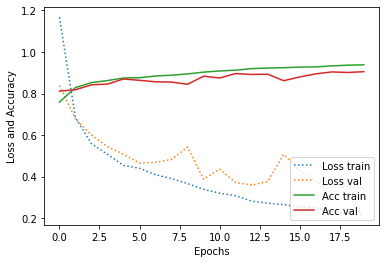

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_val_loss, linestyle = 'dotted',  label='Loss val')
plt.plot(log_train_acc, label='Acc train')
plt.plot(log_val_acc, label='Acc val')
plt.legend(loc='lower right')
plt.show()

### See the segmentation result

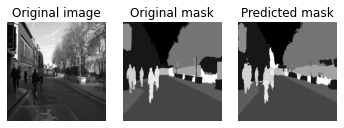

In [ ]:
# Obtain a sample
im, mask = next(iter(val_dl))

# Feedforward
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

----------------------
# Exercise

Design another UNet model by taking into consideration the previous demontrator (the same dataset). In this case, the model shall be developed without resorting to a pre-trained model (VGG, ResNet or other).

a) This UNet needs to have:
* input and output layers are convolutions
* 4 encoding levels (with a feature depth of 128, 246, 512 and 512, respectively)
* 4 decoding levels (with a feture depth of 256, 128, 64 and 64, respectively).
* output is given by a sigmoid function.

b) Use the same dataset for training the model with SGD and Adam optimizers.

c) Discuss the results obtained in comparisson with the UNet used in the demontrator.

Tip: focus your attention on the cells with the mark **"To BE COMPLETED"**



In [ ]:
# Copy and Paste from above
#Import the relevant packages:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2

!pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split

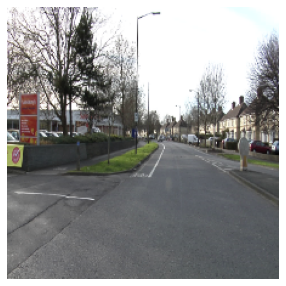

In [ ]:
# Copy and Paste from above
# downloading datasets
import os
if not os.path.exists('dataset1'):
    !wget --output-document=dataset1.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up488707_up_pt/EcIJ186fy35Em-I83Alnz2ABnoJc9NMAI5p4SRhN7ZHSGQ?download=1"
    !unzip -q dataset1.zip
    !rm dataset1.zip


# enabling GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data augmentation / Normalization
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]
                                 ) # for imagenet
                             ])
tfms = get_transforms()

class SegmentationDataset(Dataset):
    def __init__(self, split, transforms):
      	# Specify the folder that contains images i
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.items)

    def __getitem__(self, ix):
        # load the image from disk
        image = cv2.imread(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))


        # read the associated mask from disk in grayscale mode
        mask = cv2.imread(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224))

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # grab the image path from the current index
        return image, mask

    def choose(self):
      return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks


# Create instances for training and validation sets.
trn_ds = SegmentationDataset(split = 'train', transforms=None)
val_ds = SegmentationDataset(split = 'test', transforms=None)

batch_size = 4

# Dataloaders
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, collate_fn=val_ds.collate_fn)

show(trn_ds[10][0])

# Define the loss function
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
# Copy and Paste from above
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
# solution a)

# **************************   To BE COMPLETED
# **************************   To BE COMPLETED

class double_conv(nn.Module):
    """
    Class that performs:
       conv => BN => ReLU => conv => BN => ReLU
    """
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    """

    Input Convolution

    """
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    """
    Class that performs downsizes:
       1. MaxPooling
       2. conv => BN => ReLU => conv => BN => ReLU
    """
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2),
                                    double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    """
    Class that performs upsizes:
       1. Upsample or ConvTranspose2d
       2. conv => BN => ReLU => conv => BN => ReLU
    """
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    """

    Output Convolution

    """
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        # Input Convolution
        self.inc = inconv(n_channels, 64)

        # Down Level to 128 features
        #self.down1 = ...
        # Down Level to 256 features
        #self.down2 = ...
        # Down Level to 512 features
        #self.down3 = ...
        # Down Level to 512 features
        #self.down4 = ...

        # Up Level to 256 features. Input 2x (due to skipconnection)
        #self.up1 = ...
        # Up Level to 128 features. Input 2x (due to skipconnection)
        #self.up2 = ...
        # Up Level to 64 features. Input 2x (due to skipconnection)
        #self.up3 = ...
        # Up Level to 64 features. Input 2x (due to skipconnection)
        #self.up4 = ...

        # Output Convolution
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        #x2 = ...
        #x3 = ...
        #x4 = ...
        #x5 = ...
        #x = ...
        #x = ...
        #x = ...
        #x = ...
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
# **************************   To BE COMPLETED
# **************************   To BE COMPLETED

# Define the model, optimizer, loss function, and the number of epochs
#model = ....to(device)

#criterion = ...
#optimizer = ...

n_epochs = 20

In [ ]:
# Copy and Paste from above

# Train the model over increasing epochs
log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

for ex in range(n_epochs):
    N = len(trn_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
    log_train_loss.append(loss_avg/N)
    log_train_acc.append(acc_avg/(N*batch_size))

    N = len(val_dl)
    loss_avg = 0
    acc_avg = 0
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        loss_avg+=loss;
        acc_avg += batch_size * acc;
        print(ex+(bx+1)/N,"  Loss=", loss, "Accuracy=", acc)
    log_val_loss.append(loss_avg/N)
    log_val_acc.append(acc_avg/(N*batch_size))


0.010869565217391304   Loss= 6.920749664306641 Accuracy= 2.9894770705141127e-05

0.021739130434782608   Loss= 6.8447442054748535 Accuracy= 0.0057746730744838715

0.03260869565217391   Loss= 6.775095462799072 Accuracy= 0.2222825586795807

0.043478260869565216   Loss= 6.723150253295898 Accuracy= 0.3399682939052582

0.05434782608695652   Loss= 6.677967071533203 Accuracy= 0.4456861615180969

0.06521739130434782   Loss= 6.6789326667785645 Accuracy= 0.43892496824264526

0.07608695652173914   Loss= 6.649942874908447 Accuracy= 0.5349370241165161

0.08695652173913043   Loss= 6.660542964935303 Accuracy= 0.5072893500328064

0.09782608695652174   Loss= 6.614665985107422 Accuracy= 0.6136499643325806

0.10869565217391304   Loss= 6.613669395446777 Accuracy= 0.54443359375

0.11956521739130435   Loss= 6.6069722175598145 Accuracy= 0.5820810794830322

0.13043478260869565   Loss= 6.60465145111084 Accuracy= 0.4854212999343872

0.14130434782608695   Loss= 6.575146675109863 Accuracy= 0.5653848052024841

0.15217391304347827   Loss= 6.541473865509033 Accuracy= 0.6227977275848389

0.16304347826086957   Loss= 6.546050548553467 Accuracy= 0.5767996311187744

0.17391304347826086   Loss= 6.492420196533203 Accuracy= 0.7324766516685486

0.18478260869565216   Loss= 6.508285999298096 Accuracy= 0.6044573187828064

0.1956521739130435   Loss= 6.520660877227783 Accuracy= 0.49436482787132263

0.20652173913043478   Loss= 6.495293617248535 Accuracy= 0.6415069103240967

0.21739130434782608   Loss= 6.462660789489746 Accuracy= 0.6151098012924194

0.22826086956521738   Loss= 6.470926761627197 Accuracy= 0.6657117009162903

0.2391304347826087   Loss= 6.444925785064697 Accuracy= 0.6077805757522583

0.25   Loss= 6.4298095703125 Accuracy= 0.6249352097511292

0.2608695652173913   Loss= 6.401147842407227 Accuracy= 0.7023577094078064

0.2717391304347826   Loss= 6.426135540008545 Accuracy= 0.6313626170158386

0.2826086956521739   Loss= 6.394173622131348 Accuracy= 0.6407395601272583

0.29347826086956524   Loss= 6.378592491149902 Accuracy= 0.6869817972183228

0.30434782608695654   Loss= 6.370880126953125 Accuracy= 0.6500219106674194

0.31521739130434784   Loss= 6.361597061157227 Accuracy= 0.6402064561843872

0.32608695652173914   Loss= 6.346077919006348 Accuracy= 0.6671018004417419

0.33695652173913043   Loss= 6.337188243865967 Accuracy= 0.6655771732330322

0.34782608695652173   Loss= 6.329309463500977 Accuracy= 0.6485421061515808

0.358695652173913   Loss= 6.313015460968018 Accuracy= 0.6453084945678711

0.3695652173913043   Loss= 6.317923545837402 Accuracy= 0.6366440057754517

0.3804347826086957   Loss= 6.305220603942871 Accuracy= 0.6876643896102905

0.391304347826087   Loss= 6.287225723266602 Accuracy= 0.6745057106018066

0.40217391304347827   Loss= 6.280592918395996 Accuracy= 0.704345703125

0.41304347826086957   Loss= 6.2587409019470215 Accuracy= 0.7196966409683228

0.42391304347826086   Loss= 6.266304969787598 Accuracy= 0.6478993892669678

0.43478260869565216   Loss= 6.260624885559082 Accuracy= 0.5780153870582581

0.44565217391304346   Loss= 6.257736682891846 Accuracy= 0.6845752596855164

0.45652173913043476   Loss= 6.23610782623291 Accuracy= 0.6460907459259033

0.4673913043478261   Loss= 6.2391767501831055 Accuracy= 0.6077357530593872

0.4782608695652174   Loss= 6.232730865478516 Accuracy= 0.5670788884162903

0.4891304347826087   Loss= 6.2190775871276855 Accuracy= 0.5869588851928711

0.5   Loss= 6.204591274261475 Accuracy= 0.6409090161323547

0.5108695652173914   Loss= 6.189843654632568 Accuracy= 0.7090491056442261

0.5217391304347826   Loss= 6.183524131774902 Accuracy= 0.7289690375328064

0.532608695652174   Loss= 6.190641403198242 Accuracy= 0.6018913388252258

0.5434782608695652   Loss= 6.166866779327393 Accuracy= 0.7135981321334839

0.5543478260869565   Loss= 6.187621593475342 Accuracy= 0.5612693428993225

0.5652173913043478   Loss= 6.174485683441162 Accuracy= 0.5743383169174194

0.5760869565217391   Loss= 6.163844108581543 Accuracy= 0.6353933811187744

0.5869565217391305   Loss= 6.1724853515625 Accuracy= 0.5314592719078064

0.5978260869565217   Loss= 6.146296501159668 Accuracy= 0.5923001170158386

0.6086956521739131   Loss= 6.142871856689453 Accuracy= 0.670674204826355

0.6195652173913043   Loss= 6.128957748413086 Accuracy= 0.6239686012268066

0.6304347826086957   Loss= 6.137747764587402 Accuracy= 0.5871831178665161

0.6413043478260869   Loss= 6.120728969573975 Accuracy= 0.6700015664100647

0.6521739130434783   Loss= 6.137916564941406 Accuracy= 0.6221450567245483

0.6630434782608695   Loss= 6.115511417388916 Accuracy= 0.655049204826355

0.6739130434782609   Loss= 6.114224910736084 Accuracy= 0.6617805361747742

0.6847826086956522   Loss= 6.116109848022461 Accuracy= 0.5753347873687744

0.6956521739130435   Loss= 6.107586860656738 Accuracy= 0.5977857708930969

0.7065217391304348   Loss= 6.101503849029541 Accuracy= 0.6914859414100647

0.717391304347826   Loss= 6.092085838317871 Accuracy= 0.6548798084259033

0.7282608695652174   Loss= 6.08944845199585 Accuracy= 0.5817671418190002

0.7391304347826086   Loss= 6.087496280670166 Accuracy= 0.5300890803337097

0.75   Loss= 6.102968692779541 Accuracy= 0.47423070669174194

0.7608695652173914   Loss= 6.071093559265137 Accuracy= 0.6502461433410645

0.7717391304347826   Loss= 6.074970245361328 Accuracy= 0.6280243396759033

0.782608695652174   Loss= 6.10683536529541 Accuracy= 0.4480777680873871

0.7934782608695652   Loss= 6.085353374481201 Accuracy= 0.5268405079841614

0.8043478260869565   Loss= 6.06119441986084 Accuracy= 0.6136250495910645

0.8152173913043478   Loss= 6.073827743530273 Accuracy= 0.5461326241493225

0.8260869565217391   Loss= 6.052393913269043 Accuracy= 0.6162707209587097

0.8369565217391305   Loss= 6.052042007446289 Accuracy= 0.7189343571662903

0.8478260869565217   Loss= 6.051023006439209 Accuracy= 0.6597028374671936

0.8586956521739131   Loss= 6.045307159423828 Accuracy= 0.5736158490180969

0.8695652173913043   Loss= 6.049703598022461 Accuracy= 0.5685337781906128

0.8804347826086957   Loss= 6.041632175445557 Accuracy= 0.6639429330825806

0.8913043478260869   Loss= 6.034890174865723 Accuracy= 0.6907236576080322

0.9021739130434783   Loss= 6.03536319732666 Accuracy= 0.6811074614524841

0.9130434782608695   Loss= 6.033706188201904 Accuracy= 0.6728116869926453

0.9239130434782609   Loss= 6.037472248077393 Accuracy= 0.5737852454185486

0.9347826086956522   Loss= 6.028721809387207 Accuracy= 0.6130071878433228

0.9456521739130435   Loss= 6.036606311798096 Accuracy= 0.5857531428337097

0.9565217391304348   Loss= 6.023101806640625 Accuracy= 0.6559311151504517

0.967391304347826   Loss= 6.024841785430908 Accuracy= 0.6507244110107422

0.9782608695652174   Loss= 6.022184371948242 Accuracy= 0.6692392826080322

0.9891304347826086   Loss= 6.022753715515137 Accuracy= 0.6602957248687744

1.0   Loss= 6.017333507537842 Accuracy= 0.539667010307312

0.038461538461538464   Loss= 6.0299506187438965 Accuracy= 0.6482730507850647

0.07692307692307693   Loss= 6.030515193939209 Accuracy= 0.6474858522415161

0.11538461538461539   Loss= 6.030795574188232 Accuracy= 0.6546456217765808

0.15384615384615385   Loss= 6.030376434326172 Accuracy= 0.6608089208602905

0.19230769230769232   Loss= 6.029118537902832 Accuracy= 0.6615563035011292

0.23076923076923078   Loss= 6.030268669128418 Accuracy= 0.6407096982002258

0.2692307692307692   Loss= 6.031642436981201 Accuracy= 0.6542519927024841

0.3076923076923077   Loss= 6.03123140335083 Accuracy= 0.6547951102256775

0.34615384615384615   Loss= 6.030579090118408 Accuracy= 0.6425532102584839

0.38461538461538464   Loss= 6.030311584472656 Accuracy= 0.6503158807754517

0.4230769230769231   Loss= 6.029543399810791 Accuracy= 0.6630410552024841

0.46153846153846156   Loss= 6.0301079750061035 Accuracy= 0.6500518321990967

0.5   Loss= 6.029671669006348 Accuracy= 0.6476452946662903

0.5384615384615384   Loss= 6.030308246612549 Accuracy= 0.6527273654937744

0.5769230769230769   Loss= 6.029718399047852 Accuracy= 0.66259765625

0.6153846153846154   Loss= 6.030026912689209 Accuracy= 0.6418556571006775

0.6538461538461539   Loss= 6.031702041625977 Accuracy= 0.6527971625328064

0.6923076923076923   Loss= 6.030487537384033 Accuracy= 0.6352788209915161

0.7307692307692307   Loss= 6.032735347747803 Accuracy= 0.6427674293518066

0.7692307692307693   Loss= 6.031604290008545 Accuracy= 0.657869279384613

0.8076923076923077   Loss= 6.029705047607422 Accuracy= 0.6533950567245483

0.8461538461538461   Loss= 6.030983924865723 Accuracy= 0.6520547270774841

0.8846153846153846   Loss= 6.030602931976318 Accuracy= 0.6617207527160645

0.9230769230769231   Loss= 6.031656265258789 Accuracy= 0.6533203125

0.9615384615384616   Loss= 6.0313825607299805 Accuracy= 0.6498425602912903

1.0   Loss= 6.029632568359375 Accuracy= 0.657625138759613

1.0108695652173914   Loss= 6.013372898101807 Accuracy= 0.657978892326355

1.0217391304347827   Loss= 6.009006977081299 Accuracy= 0.6964734196662903

1.0326086956521738   Loss= 6.014542579650879 Accuracy= 0.6698969602584839

1.0434782608695652   Loss= 6.010967254638672 Accuracy= 0.6163504123687744

1.0543478260869565   Loss= 6.009133338928223 Accuracy= 0.7011269927024841

1.065217391304348   Loss= 6.0065226554870605 Accuracy= 0.6236447691917419

1.0760869565217392   Loss= 6.005928039550781 Accuracy= 0.6329470276832581

1.0869565217391304   Loss= 6.000909805297852 Accuracy= 0.7004743218421936

1.0978260869565217   Loss= 6.002420425415039 Accuracy= 0.5850107669830322

1.108695652173913   Loss= 6.000006675720215 Accuracy= 0.6053840517997742

1.1195652173913044   Loss= 6.005747318267822 Accuracy= 0.6207848191261292

1.1304347826086956   Loss= 6.003067970275879 Accuracy= 0.5678113102912903

1.141304347826087   Loss= 5.992377281188965 Accuracy= 0.6441326141357422

1.1521739130434783   Loss= 5.9973554611206055 Accuracy= 0.7108179330825806

1.1630434782608696   Loss= 5.995429992675781 Accuracy= 0.6963787078857422

1.1739130434782608   Loss= 5.991062164306641 Accuracy= 0.6627321839332581

1.184782608695652   Loss= 6.000380039215088 Accuracy= 0.5786730647087097

1.1956521739130435   Loss= 5.988829135894775 Accuracy= 0.6130719780921936

1.2065217391304348   Loss= 5.988420009613037 Accuracy= 0.5960867404937744

1.2173913043478262   Loss= 5.9880757331848145 Accuracy= 0.6561055183410645

1.2282608695652173   Loss= 5.99318265914917 Accuracy= 0.6261110901832581

1.2391304347826086   Loss= 5.991023063659668 Accuracy= 0.5809151530265808

1.25   Loss= 5.9883036613464355 Accuracy= 0.5995047092437744

1.2608695652173914   Loss= 5.980618953704834 Accuracy= 0.6604900360107422

1.2717391304347827   Loss= 5.984090805053711 Accuracy= 0.6559609770774841

1.2826086956521738   Loss= 5.980456829071045 Accuracy= 0.63720703125

1.2934782608695652   Loss= 5.98512601852417 Accuracy= 0.6577596664428711

1.3043478260869565   Loss= 5.97959566116333 Accuracy= 0.688406765460968

1.315217391304348   Loss= 5.98268985748291 Accuracy= 0.6061015129089355

1.3260869565217392   Loss= 5.982911586761475 Accuracy= 0.6581034660339355

1.3369565217391304   Loss= 5.976183891296387 Accuracy= 0.7198262214660645

1.3478260869565217   Loss= 5.981184959411621 Accuracy= 0.5798090696334839

1.358695652173913   Loss= 5.975904941558838 Accuracy= 0.7118044495582581

1.3695652173913042   Loss= 5.980075359344482 Accuracy= 0.6564791798591614

1.3804347826086958   Loss= 5.978424549102783 Accuracy= 0.6581383347511292

1.391304347826087   Loss= 5.971773147583008 Accuracy= 0.6689453125

1.4021739130434783   Loss= 5.973230361938477 Accuracy= 0.7139319181442261

1.4130434782608696   Loss= 5.978440761566162 Accuracy= 0.6214076280593872

1.4239130434782608   Loss= 5.975149154663086 Accuracy= 0.6719297766685486

1.434782608695652   Loss= 5.977226257324219 Accuracy= 0.531758189201355

1.4456521739130435   Loss= 5.971810340881348 Accuracy= 0.617451548576355

1.4565217391304348   Loss= 5.974058151245117 Accuracy= 0.5681700110435486

1.4673913043478262   Loss= 5.973167419433594 Accuracy= 0.6397829651832581

1.4782608695652173   Loss= 5.970221519470215 Accuracy= 0.6369977593421936

1.4891304347826086   Loss= 5.967992782592773 Accuracy= 0.5874322056770325

1.5   Loss= 5.970102787017822 Accuracy= 0.6172373294830322

1.5108695652173914   Loss= 5.967409610748291 Accuracy= 0.7039172053337097

1.5217391304347827   Loss= 5.970994472503662 Accuracy= 0.6066396236419678

1.5326086956521738   Loss= 5.967577934265137 Accuracy= 0.6079151034355164

1.5434782608695652   Loss= 5.965205192565918 Accuracy= 0.7459841370582581

1.5543478260869565   Loss= 5.965834617614746 Accuracy= 0.6619499325752258

1.5652173913043477   Loss= 5.963775634765625 Accuracy= 0.6521743535995483

1.5760869565217392   Loss= 5.9668965339660645 Accuracy= 0.6625627875328064

1.5869565217391304   Loss= 5.967458724975586 Accuracy= 0.6337491869926453

1.5978260869565217   Loss= 5.961991786956787 Accuracy= 0.6396982669830322

1.608695652173913   Loss= 5.963377475738525 Accuracy= 0.6674156785011292

1.6195652173913042   Loss= 5.961267471313477 Accuracy= 0.7078284025192261

1.6304347826086958   Loss= 5.963075637817383 Accuracy= 0.6807388067245483

1.641304347826087   Loss= 5.9632062911987305 Accuracy= 0.6390754580497742

1.6521739130434783   Loss= 5.963781356811523 Accuracy= 0.6443369388580322

1.6630434782608696   Loss= 5.966424942016602 Accuracy= 0.5534219145774841

1.6739130434782608   Loss= 5.959972381591797 Accuracy= 0.6765983700752258

1.6847826086956523   Loss= 5.9576802253723145 Accuracy= 0.6755171418190002

1.6956521739130435   Loss= 5.960862159729004 Accuracy= 0.5805464386940002

1.7065217391304348   Loss= 5.958737850189209 Accuracy= 0.689871609210968

1.7173913043478262   Loss= 5.959193706512451 Accuracy= 0.6711924076080322

1.7282608695652173   Loss= 5.962182998657227 Accuracy= 0.5712441802024841

1.7391304347826086   Loss= 5.956290245056152 Accuracy= 0.7224718928337097

1.75   Loss= 5.956436634063721 Accuracy= 0.6972257494926453

1.7608695652173914   Loss= 5.9546380043029785 Accuracy= 0.6955466866493225

1.7717391304347827   Loss= 5.956517219543457 Accuracy= 0.6491101384162903

1.7826086956521738   Loss= 5.956998825073242 Accuracy= 0.6349698901176453

1.7934782608695652   Loss= 5.960290431976318 Accuracy= 0.6519899964332581

1.8043478260869565   Loss= 5.9576334953308105 Accuracy= 0.6884616017341614

1.8152173913043477   Loss= 5.95449686050415 Accuracy= 0.6794383525848389

1.8260869565217392   Loss= 5.9538750648498535 Accuracy= 0.6469178199768066

1.8369565217391304   Loss= 5.954159259796143 Accuracy= 0.6923080682754517

1.8478260869565217   Loss= 5.956644058227539 Accuracy= 0.6145915985107422

1.858695652173913   Loss= 5.9539995193481445 Accuracy= 0.7087551951408386

1.8695652173913042   Loss= 5.9577531814575195 Accuracy= 0.5385144352912903

1.8804347826086958   Loss= 5.953765392303467 Accuracy= 0.680330216884613

1.891304347826087   Loss= 5.95198917388916 Accuracy= 0.7171057462692261

1.9021739130434783   Loss= 5.954893112182617 Accuracy= 0.6557268500328064

1.9130434782608696   Loss= 5.9523820877075195 Accuracy= 0.6973851919174194

1.9239130434782608   Loss= 5.9527201652526855 Accuracy= 0.7156509160995483

1.9347826086956523   Loss= 5.950628757476807 Accuracy= 0.7157007455825806

1.9456521739130435   Loss= 5.953233242034912 Accuracy= 0.6179448366165161

1.9565217391304348   Loss= 5.950841903686523 Accuracy= 0.7242805361747742

1.9673913043478262   Loss= 5.952584266662598 Accuracy= 0.7001803517341614

1.9782608695652173   Loss= 5.950739860534668 Accuracy= 0.665771484375

1.9891304347826086   Loss= 5.953397274017334 Accuracy= 0.5788025856018066

2.0   Loss= 5.950432777404785 Accuracy= 0.6664806604385376

1.0384615384615385   Loss= 5.950974941253662 Accuracy= 0.6885961294174194

1.0769230769230769   Loss= 5.951320171356201 Accuracy= 0.6990393400192261

1.1153846153846154   Loss= 5.951415538787842 Accuracy= 0.6876594424247742

1.1538461538461537   Loss= 5.951574802398682 Accuracy= 0.6860002875328064

1.1923076923076923   Loss= 5.951159477233887 Accuracy= 0.6928461790084839

1.2307692307692308   Loss= 5.951564788818359 Accuracy= 0.6798867583274841

1.2692307692307692   Loss= 5.951319694519043 Accuracy= 0.6744509339332581

1.3076923076923077   Loss= 5.95162296295166 Accuracy= 0.69775390625

1.3461538461538463   Loss= 5.951004505157471 Accuracy= 0.7059251070022583

1.3846153846153846   Loss= 5.950957775115967 Accuracy= 0.6924973726272583

1.4230769230769231   Loss= 5.951401233673096 Accuracy= 0.6979432106018066

1.4615384615384617   Loss= 5.95163631439209 Accuracy= 0.6835638284683228

1.5   Loss= 5.950724124908447 Accuracy= 0.6935735940933228

1.5384615384615383   Loss= 5.9506144523620605 Accuracy= 0.7025968432426453

1.5769230769230769   Loss= 5.950413227081299 Accuracy= 0.7009924650192261

1.6153846153846154   Loss= 5.951512336730957 Accuracy= 0.6838528513908386

1.6538461538461537   Loss= 5.951054096221924 Accuracy= 0.6988052129745483

1.6923076923076923   Loss= 5.951277256011963 Accuracy= 0.7035086154937744

1.7307692307692308   Loss= 5.950719833374023 Accuracy= 0.7163783311843872

1.7692307692307692   Loss= 5.950782775878906 Accuracy= 0.7082818150520325

1.8076923076923077   Loss= 5.950186729431152 Accuracy= 0.7228206396102905

1.8461538461538463   Loss= 5.950561046600342 Accuracy= 0.7188894748687744

1.8846153846153846   Loss= 5.950922012329102 Accuracy= 0.7024872303009033

1.9230769230769231   Loss= 5.950534820556641 Accuracy= 0.6856365203857422

1.9615384615384617   Loss= 5.951308727264404 Accuracy= 0.6976193785667419

2.0   Loss= 5.951283931732178 Accuracy= 0.7118343114852905

2.010869565217391   Loss= 5.9504008293151855 Accuracy= 0.6599918007850647

2.0217391304347827   Loss= 5.950272083282471 Accuracy= 0.6460857391357422

2.032608695652174   Loss= 5.94753360748291 Accuracy= 0.7050532102584839

2.0434782608695654   Loss= 5.947432041168213 Accuracy= 0.7504932284355164

2.0543478260869565   Loss= 5.95143985748291 Accuracy= 0.5821558237075806

2.0652173913043477   Loss= 5.950264930725098 Accuracy= 0.6506248116493225

2.0760869565217392   Loss= 5.948982238769531 Accuracy= 0.6922432780265808

2.0869565217391304   Loss= 5.9491753578186035 Accuracy= 0.6658810973167419

2.097826086956522   Loss= 5.947377681732178 Accuracy= 0.6613669991493225

2.108695652173913   Loss= 5.947278022766113 Accuracy= 0.6340381503105164

2.119565217391304   Loss= 5.946946620941162 Accuracy= 0.6375607848167419

2.130434782608696   Loss= 5.948227882385254 Accuracy= 0.6511678695678711

2.141304347826087   Loss= 5.9477739334106445 Accuracy= 0.6973254084587097

2.1521739130434785   Loss= 5.948905944824219 Accuracy= 0.6368682384490967

2.1630434782608696   Loss= 5.948270797729492 Accuracy= 0.6838030219078064

2.1739130434782608   Loss= 5.9443182945251465 Accuracy= 0.7008131146430969

2.1847826086956523   Loss= 5.945075988769531 Accuracy= 0.6929807066917419

2.1956521739130435   Loss= 5.944572448730469 Accuracy= 0.6856564879417419

2.2065217391304346   Loss= 5.946199893951416 Accuracy= 0.7419034838676453

2.217391304347826   Loss= 5.94512939453125 Accuracy= 0.6802654266357422

2.2282608695652173   Loss= 5.945434093475342 Accuracy= 0.7279924750328064

2.239130434782609   Loss= 5.944765567779541 Accuracy= 0.6623136401176453

2.25   Loss= 5.947463512420654 Accuracy= 0.5642488598823547

2.260869565217391   Loss= 5.9449639320373535 Accuracy= 0.6344766020774841

2.2717391304347827   Loss= 5.945468425750732 Accuracy= 0.7017498016357422

2.282608695652174   Loss= 5.942723274230957 Accuracy= 0.7294921875

2.2934782608695654   Loss= 5.945140838623047 Accuracy= 0.6936284303665161

2.3043478260869565   Loss= 5.942667007446289 Accuracy= 0.7459343075752258

2.3152173913043477   Loss= 5.942989349365234 Accuracy= 0.7152921557426453

2.3260869565217392   Loss= 5.947371006011963 Accuracy= 0.5840740203857422

2.3369565217391304   Loss= 5.942355632781982 Accuracy= 0.6987603306770325

2.3478260869565215   Loss= 5.942147254943848 Accuracy= 0.7016302347183228

2.358695652173913   Loss= 5.942788124084473 Accuracy= 0.6762047410011292

2.369565217391304   Loss= 5.9411234855651855 Accuracy= 0.7021185159683228

2.380434782608696   Loss= 5.943308353424072 Accuracy= 0.5873624682426453

2.391304347826087   Loss= 5.943333148956299 Accuracy= 0.6562898755073547

2.4021739130434785   Loss= 5.943607330322266 Accuracy= 0.6635791659355164

2.4130434782608696   Loss= 5.943547248840332 Accuracy= 0.6782026886940002

2.4239130434782608   Loss= 5.944206237792969 Accuracy= 0.6211037039756775

2.4347826086956523   Loss= 5.94183349609375 Accuracy= 0.7267219424247742

2.4456521739130435   Loss= 5.941841125488281 Accuracy= 0.6880331039428711

2.4565217391304346   Loss= 5.941373825073242 Accuracy= 0.7010772228240967

2.467391304347826   Loss= 5.940341472625732 Accuracy= 0.7591826319694519

2.4782608695652173   Loss= 5.940502166748047 Accuracy= 0.7346440553665161

2.489130434782609   Loss= 5.94224214553833 Accuracy= 0.5799186825752258

2.5   Loss= 5.940101623535156 Accuracy= 0.6828015446662903

2.5108695652173916   Loss= 5.940454483032227 Accuracy= 0.6665786504745483

2.5217391304347827   Loss= 5.940589904785156 Accuracy= 0.6202268004417419

2.532608695652174   Loss= 5.940493106842041 Accuracy= 0.6777094602584839

2.5434782608695654   Loss= 5.9417724609375 Accuracy= 0.650166392326355

2.5543478260869565   Loss= 5.941533088684082 Accuracy= 0.6332509517669678

2.5652173913043477   Loss= 5.938879013061523 Accuracy= 0.7102100253105164

2.5760869565217392   Loss= 5.941513538360596 Accuracy= 0.6098931431770325

2.5869565217391304   Loss= 5.9385552406311035 Accuracy= 0.6956961154937744

2.5978260869565215   Loss= 5.938671112060547 Accuracy= 0.6603156924247742

2.608695652173913   Loss= 5.940251350402832 Accuracy= 0.6360909342765808

2.619565217391304   Loss= 5.9413557052612305 Accuracy= 0.6615413427352905

2.630434782608696   Loss= 5.94089937210083 Accuracy= 0.6439034342765808

2.641304347826087   Loss= 5.938204288482666 Accuracy= 0.7195272445678711

2.6521739130434785   Loss= 5.9419426918029785 Accuracy= 0.6023347973823547

2.6630434782608696   Loss= 5.9412946701049805 Accuracy= 0.5760921239852905

2.6739130434782608   Loss= 5.938327789306641 Accuracy= 0.6861048936843872

2.6847826086956523   Loss= 5.939163684844971 Accuracy= 0.6330117583274841

2.6956521739130435   Loss= 5.938634872436523 Accuracy= 0.6988201141357422

2.7065217391304346   Loss= 5.939517498016357 Accuracy= 0.5902124643325806

2.717391304347826   Loss= 5.937632083892822 Accuracy= 0.670430064201355

2.7282608695652173   Loss= 5.94046688079834 Accuracy= 0.5679209232330322

2.7391304347826084   Loss= 5.938021183013916 Accuracy= 0.6584522128105164

2.75   Loss= 5.937707901000977 Accuracy= 0.7217394709587097

2.7608695652173916   Loss= 5.93898344039917 Accuracy= 0.5594158172607422

2.7717391304347827   Loss= 5.937581539154053 Accuracy= 0.7148237824440002

2.782608695652174   Loss= 5.938745498657227 Accuracy= 0.6429916620254517

2.7934782608695654   Loss= 5.938197135925293 Accuracy= 0.6550193428993225

2.8043478260869565   Loss= 5.938161373138428 Accuracy= 0.66259765625

2.8152173913043477   Loss= 5.937356948852539 Accuracy= 0.6537288427352905

2.8260869565217392   Loss= 5.9380316734313965 Accuracy= 0.6513422727584839

2.8369565217391304   Loss= 5.9379401206970215 Accuracy= 0.6842015981674194

2.8478260869565215   Loss= 5.937556266784668 Accuracy= 0.6566187143325806

2.858695652173913   Loss= 5.937437534332275 Accuracy= 0.6382334232330322

2.869565217391304   Loss= 5.937201023101807 Accuracy= 0.5848264098167419

2.880434782608696   Loss= 5.936488151550293 Accuracy= 0.6826271414756775

2.891304347826087   Loss= 5.9386420249938965 Accuracy= 0.6554428339004517

2.9021739130434785   Loss= 5.936071395874023 Accuracy= 0.6901606321334839

2.9130434782608696   Loss= 5.937976837158203 Accuracy= 0.6489058136940002

2.9239130434782608   Loss= 5.942376136779785 Accuracy= 0.5203135013580322

2.9347826086956523   Loss= 5.93606424331665 Accuracy= 0.71244215965271

2.9456521739130435   Loss= 5.9363627433776855 Accuracy= 0.6744359731674194

2.9565217391304346   Loss= 5.935791015625 Accuracy= 0.6874352097511292

2.967391304347826   Loss= 5.936040878295898 Accuracy= 0.6525928378105164

2.9782608695652173   Loss= 5.935581684112549 Accuracy= 0.7106733918190002

2.9891304347826084   Loss= 5.936030387878418 Accuracy= 0.6477897763252258

3.0   Loss= 5.9371819496154785 Accuracy= 0.547871470451355

2.0384615384615383   Loss= 5.937201023101807 Accuracy= 0.6462501883506775

2.076923076923077   Loss= 5.936520099639893 Accuracy= 0.6622040271759033

2.1153846153846154   Loss= 5.937097549438477 Accuracy= 0.6582529544830322

2.1538461538461537   Loss= 5.937080383300781 Accuracy= 0.6591497659683228

2.1923076923076925   Loss= 5.937280178070068 Accuracy= 0.6378796696662903

2.230769230769231   Loss= 5.936694145202637 Accuracy= 0.6510831713676453

2.269230769230769   Loss= 5.936640739440918 Accuracy= 0.6707140803337097

2.3076923076923075   Loss= 5.937204837799072 Accuracy= 0.6430564522743225

2.3461538461538463   Loss= 5.9374799728393555 Accuracy= 0.6506098508834839

2.3846153846153846   Loss= 5.936995983123779 Accuracy= 0.649189829826355

2.423076923076923   Loss= 5.937283039093018 Accuracy= 0.6552186012268066

2.4615384615384617   Loss= 5.9369072914123535 Accuracy= 0.6315320134162903

2.5   Loss= 5.9374823570251465 Accuracy= 0.6483179330825806

2.5384615384615383   Loss= 5.93817138671875 Accuracy= 0.6382284164428711

2.5769230769230766   Loss= 5.936939239501953 Accuracy= 0.6493691802024841

2.6153846153846154   Loss= 5.936853408813477 Accuracy= 0.6577995419502258

2.6538461538461537   Loss= 5.937384128570557 Accuracy= 0.6323840022087097

2.6923076923076925   Loss= 5.9368462562561035 Accuracy= 0.6587212681770325

2.730769230769231   Loss= 5.937345504760742 Accuracy= 0.6427475214004517

2.769230769230769   Loss= 5.936897277832031 Accuracy= 0.6341079473495483

2.8076923076923075   Loss= 5.937426567077637 Accuracy= 0.6390007138252258

2.8461538461538463   Loss= 5.9372944831848145 Accuracy= 0.6351293325424194

2.8846153846153846   Loss= 5.93747091293335 Accuracy= 0.6387814879417419

2.9230769230769234   Loss= 5.936899662017822 Accuracy= 0.6300123333930969

2.9615384615384617   Loss= 5.937211036682129 Accuracy= 0.6507194638252258

3.0   Loss= 5.936275482177734 Accuracy= 0.6456074714660645

3.010869565217391   Loss= 5.936151504516602 Accuracy= 0.63623046875

3.0217391304347827   Loss= 5.93729829788208 Accuracy= 0.628173828125

3.032608695652174   Loss= 5.935351371765137 Accuracy= 0.6933344602584839

3.0434782608695654   Loss= 5.936511039733887 Accuracy= 0.6528071165084839

3.0543478260869565   Loss= 5.937742710113525 Accuracy= 0.5597695708274841

3.0652173913043477   Loss= 5.9342041015625 Accuracy= 0.7075693607330322

3.0760869565217392   Loss= 5.9403815269470215 Accuracy= 0.5600535869598389

3.0869565217391304   Loss= 5.934618949890137 Accuracy= 0.6607691049575806

3.097826086956522   Loss= 5.9358744621276855 Accuracy= 0.6673609018325806

3.108695652173913   Loss= 5.935396194458008 Accuracy= 0.6091209053993225

3.119565217391304   Loss= 5.934217929840088 Accuracy= 0.712910532951355

3.130434782608696   Loss= 5.934419631958008 Accuracy= 0.7081772089004517

3.141304347826087   Loss= 5.9349799156188965 Accuracy= 0.6424236297607422

3.1521739130434785   Loss= 5.935649871826172 Accuracy= 0.6307447552680969

3.1630434782608696   Loss= 5.934514045715332 Accuracy= 0.6836584806442261

3.1739130434782608   Loss= 5.933838367462158 Accuracy= 0.6436094641685486

3.1847826086956523   Loss= 5.934659481048584 Accuracy= 0.6922731995582581

3.1956521739130435   Loss= 5.936088562011719 Accuracy= 0.64453125

3.2065217391304346   Loss= 5.933412075042725 Accuracy= 0.7162288427352905

3.217391304347826   Loss= 5.934146404266357 Accuracy= 0.7093580365180969

3.2282608695652173   Loss= 5.933423042297363 Accuracy= 0.7015106678009033

3.239130434782609   Loss= 5.93374490737915 Accuracy= 0.7243950963020325

3.25   Loss= 5.934811115264893 Accuracy= 0.6883619427680969

3.260869565217391   Loss= 5.934341907501221 Accuracy= 0.6375508308410645

3.2717391304347827   Loss= 5.936453819274902 Accuracy= 0.5934062004089355

3.282608695652174   Loss= 5.9338603019714355 Accuracy= 0.6733348369598389

3.2934782608695654   Loss= 5.933438777923584 Accuracy= 0.7196418642997742

3.3043478260869565   Loss= 5.93365478515625 Accuracy= 0.6596430540084839

3.3152173913043477   Loss= 5.932958602905273 Accuracy= 0.685322642326355

3.3260869565217392   Loss= 5.934258937835693 Accuracy= 0.6229721307754517

3.3369565217391304   Loss= 5.9337687492370605 Accuracy= 0.6493093967437744

3.3478260869565215   Loss= 5.932812213897705 Accuracy= 0.7289540767669678

3.358695652173913   Loss= 5.93666410446167 Accuracy= 0.5346280932426453

3.369565217391304   Loss= 5.934617519378662 Accuracy= 0.5869987607002258

3.380434782608696   Loss= 5.932686805725098 Accuracy= 0.6813865303993225

3.391304347826087   Loss= 5.933473110198975 Accuracy= 0.6669074892997742

3.4021739130434785   Loss= 5.934830665588379 Accuracy= 0.6539281606674194

3.4130434782608696   Loss= 5.932590007781982 Accuracy= 0.6943060159683228

3.4239130434782608   Loss= 5.932977199554443 Accuracy= 0.6898567080497742

3.4347826086956523   Loss= 5.932039260864258 Accuracy= 0.6619548797607422

3.4456521739130435   Loss= 5.93472957611084 Accuracy= 0.6148257851600647

3.4565217391304346   Loss= 5.933772087097168 Accuracy= 0.5998235940933228

3.467391304347826   Loss= 5.9327778816223145 Accuracy= 0.6760104298591614

3.4782608695652173   Loss= 5.932916164398193 Accuracy= 0.6680285334587097

3.489130434782609   Loss= 5.93257474899292 Accuracy= 0.6089763641357422

3.5   Loss= 5.932336330413818 Accuracy= 0.6720991730690002

3.5108695652173916   Loss= 5.932865142822266 Accuracy= 0.6279147267341614

3.5217391304347827   Loss= 5.932004928588867 Accuracy= 0.698396623134613

3.532608695652174   Loss= 5.932488441467285 Accuracy= 0.7433533668518066

3.5434782608695654   Loss= 5.931823253631592 Accuracy= 0.7028958201408386

3.5543478260869565   Loss= 5.932320594787598 Accuracy= 0.6867376565933228

3.5652173913043477   Loss= 5.931953430175781 Accuracy= 0.7066276669502258

3.5760869565217392   Loss= 5.932770252227783 Accuracy= 0.6266591548919678

3.5869565217391304   Loss= 5.934070587158203 Accuracy= 0.6295340061187744

3.5978260869565215   Loss= 5.931705474853516 Accuracy= 0.6711475253105164

3.608695652173913   Loss= 5.932275772094727 Accuracy= 0.6616709232330322

3.619565217391304   Loss= 5.93259334564209 Accuracy= 0.6721490025520325

3.630434782608696   Loss= 5.932158946990967 Accuracy= 0.618916392326355

3.641304347826087   Loss= 5.931288242340088 Accuracy= 0.6593689918518066

3.6521739130434785   Loss= 5.936476230621338 Accuracy= 0.5590620636940002

3.6630434782608696   Loss= 5.931441307067871 Accuracy= 0.7056909799575806

3.6739130434782608   Loss= 5.932769298553467 Accuracy= 0.6418257355690002

3.6847826086956523   Loss= 5.931118488311768 Accuracy= 0.7043157815933228

3.6956521739130435   Loss= 5.932011604309082 Accuracy= 0.6618004441261292

3.7065217391304346   Loss= 5.932409286499023 Accuracy= 0.6735042333602905

3.717391304347826   Loss= 5.9318413734436035 Accuracy= 0.6162906289100647

3.7282608695652173   Loss= 5.932519912719727 Accuracy= 0.6016571521759033

3.7391304347826084   Loss= 5.930999279022217 Accuracy= 0.6254534125328064

3.75   Loss= 5.931036472320557 Accuracy= 0.6653778553009033

3.7608695652173916   Loss= 5.930891990661621 Accuracy= 0.6618552803993225

3.7717391304347827   Loss= 5.932112693786621 Accuracy= 0.5856186151504517

3.782608695652174   Loss= 5.930398941040039 Accuracy= 0.6933294534683228

3.7934782608695654   Loss= 5.930665969848633 Accuracy= 0.6574158668518066

3.8043478260869565   Loss= 5.930373668670654 Accuracy= 0.6871562004089355

3.8152173913043477   Loss= 5.9312310218811035 Accuracy= 0.6595134735107422

3.8260869565217392   Loss= 5.931356430053711 Accuracy= 0.6739327311515808

3.8369565217391304   Loss= 5.931367874145508 Accuracy= 0.6963438391685486

3.8478260869565215   Loss= 5.93123722076416 Accuracy= 0.678885281085968

3.858695652173913   Loss= 5.9321417808532715 Accuracy= 0.6714165806770325

3.869565217391304   Loss= 5.9307861328125 Accuracy= 0.6820691227912903

3.880434782608696   Loss= 5.932372570037842 Accuracy= 0.6400220990180969

3.891304347826087   Loss= 5.932584762573242 Accuracy= 0.6651985049247742

3.9021739130434785   Loss= 5.931079387664795 Accuracy= 0.686055064201355

3.9130434782608696   Loss= 5.931209564208984 Accuracy= 0.6188217401504517

3.9239130434782608   Loss= 5.930727005004883 Accuracy= 0.6392149329185486

3.9347826086956523   Loss= 5.932805061340332 Accuracy= 0.6425731182098389

3.9456521739130435   Loss= 5.930759906768799 Accuracy= 0.7020188570022583

3.9565217391304346   Loss= 5.930558681488037 Accuracy= 0.5950304865837097

3.967391304347826   Loss= 5.930124759674072 Accuracy= 0.7133589386940002

3.9782608695652173   Loss= 5.930318355560303 Accuracy= 0.7213956713676453

3.9891304347826084   Loss= 5.931900978088379 Accuracy= 0.5764658451080322

4.0   Loss= 5.931544780731201 Accuracy= 0.6055351495742798

3.0384615384615383   Loss= 5.930568695068359 Accuracy= 0.6507493257522583

3.076923076923077   Loss= 5.930730819702148 Accuracy= 0.6465640664100647

3.1153846153846154   Loss= 5.930373668670654 Accuracy= 0.6522490978240967

3.1538461538461537   Loss= 5.930992126464844 Accuracy= 0.6453583240509033

3.1923076923076925   Loss= 5.93113374710083 Accuracy= 0.6346809267997742

3.230769230769231   Loss= 5.930753707885742 Accuracy= 0.6568379402160645

3.269230769230769   Loss= 5.9309258460998535 Accuracy= 0.6216716766357422

3.3076923076923075   Loss= 5.931396961212158 Accuracy= 0.6191655397415161

3.3461538461538463   Loss= 5.93052339553833 Accuracy= 0.6353635191917419

3.3846153846153846   Loss= 5.930971145629883 Accuracy= 0.6465441584587097

3.423076923076923   Loss= 5.930528163909912 Accuracy= 0.6414172053337097

3.4615384615384617   Loss= 5.930591583251953 Accuracy= 0.6494588851928711

3.5   Loss= 5.930774688720703 Accuracy= 0.643729031085968

3.5384615384615383   Loss= 5.930644989013672 Accuracy= 0.6416712999343872

3.5769230769230766   Loss= 5.930747985839844 Accuracy= 0.6292699575424194

3.6153846153846154   Loss= 5.930913925170898 Accuracy= 0.6260064244270325

3.6538461538461537   Loss= 5.930929183959961 Accuracy= 0.6320402026176453

3.6923076923076925   Loss= 5.9307451248168945 Accuracy= 0.6545011401176453

3.730769230769231   Loss= 5.930929183959961 Accuracy= 0.6415417790412903

3.769230769230769   Loss= 5.9308295249938965 Accuracy= 0.6218012571334839

3.8076923076923075   Loss= 5.930765151977539 Accuracy= 0.6403858065605164

3.8461538461538463   Loss= 5.930562496185303 Accuracy= 0.6428720951080322

3.8846153846153846   Loss= 5.9306135177612305 Accuracy= 0.6377550959587097

3.9230769230769234   Loss= 5.9308366775512695 Accuracy= 0.6438586115837097

3.9615384615384617   Loss= 5.930690765380859 Accuracy= 0.6601412892341614

4.0   Loss= 5.930696487426758 Accuracy= 0.6408242583274841

4.010869565217392   Loss= 5.930540561676025 Accuracy= 0.6126983165740967

4.021739130434782   Loss= 5.9306840896606445 Accuracy= 0.6185427308082581

4.032608695652174   Loss= 5.931410789489746 Accuracy= 0.6069684624671936

4.043478260869565   Loss= 5.930318832397461 Accuracy= 0.6959651708602905

4.054347826086956   Loss= 5.929839611053467 Accuracy= 0.7332639098167419

4.065217391304348   Loss= 5.92952823638916 Accuracy= 0.6885114312171936

4.076086956521739   Loss= 5.931323528289795 Accuracy= 0.6495236754417419

4.086956521739131   Loss= 5.931958198547363 Accuracy= 0.641377329826355

4.0978260869565215   Loss= 5.93021297454834 Accuracy= 0.6532405614852905

4.108695652173913   Loss= 5.930032730102539 Accuracy= 0.6824328303337097

4.119565217391305   Loss= 5.9304280281066895 Accuracy= 0.6750737428665161

4.130434782608695   Loss= 5.929915904998779 Accuracy= 0.6536491513252258

4.141304347826087   Loss= 5.929657459259033 Accuracy= 0.7004344463348389

4.1521739130434785   Loss= 5.929566860198975 Accuracy= 0.6976044178009033

4.163043478260869   Loss= 5.929811000823975 Accuracy= 0.7180723547935486

4.173913043478261   Loss= 5.931119441986084 Accuracy= 0.6312380433082581

4.184782608695652   Loss= 5.929577827453613 Accuracy= 0.7010422945022583

4.195652173913044   Loss= 5.929841995239258 Accuracy= 0.7072205543518066

4.206521739130435   Loss= 5.929459571838379 Accuracy= 0.67431640625

4.217391304347826   Loss= 5.930717468261719 Accuracy= 0.6213628053665161

4.228260869565218   Loss= 5.929126262664795 Accuracy= 0.7340959906578064

4.239130434782608   Loss= 5.929637908935547 Accuracy= 0.6881775856018066

4.25   Loss= 5.930060386657715 Accuracy= 0.5856285691261292

4.260869565217392   Loss= 5.930996417999268 Accuracy= 0.6195541620254517

4.271739130434782   Loss= 5.929952621459961 Accuracy= 0.6492147445678711

4.282608695652174   Loss= 5.929416656494141 Accuracy= 0.7304139137268066

4.293478260869565   Loss= 5.929247856140137 Accuracy= 0.7038823366165161

4.304347826086957   Loss= 5.930343151092529 Accuracy= 0.6265744566917419

4.315217391304348   Loss= 5.929202556610107 Accuracy= 0.713289201259613

4.326086956521739   Loss= 5.930326461791992 Accuracy= 0.6149353981018066

4.336956521739131   Loss= 5.92952823638916 Accuracy= 0.6717703342437744

4.3478260869565215   Loss= 5.928945064544678 Accuracy= 0.6937031745910645

4.358695652173913   Loss= 5.929897785186768 Accuracy= 0.6897520422935486

4.369565217391305   Loss= 5.929275989532471 Accuracy= 0.675312876701355

4.380434782608695   Loss= 5.930598735809326 Accuracy= 0.6482730507850647

4.391304347826087   Loss= 5.928591251373291 Accuracy= 0.7374342083930969

4.4021739130434785   Loss= 5.9314351081848145 Accuracy= 0.6265744566917419

4.413043478260869   Loss= 5.929656505584717 Accuracy= 0.6293496489524841

4.423913043478261   Loss= 5.929103851318359 Accuracy= 0.6998265981674194

4.434782608695652   Loss= 5.929838180541992 Accuracy= 0.6871063709259033

4.445652173913043   Loss= 5.930699348449707 Accuracy= 0.6659857034683228

4.456521739130435   Loss= 5.9299516677856445 Accuracy= 0.654471218585968

4.467391304347826   Loss= 5.9309821128845215 Accuracy= 0.6065499186515808

4.478260869565218   Loss= 5.9292192459106445 Accuracy= 0.6801409125328064

4.489130434782608   Loss= 5.929875373840332 Accuracy= 0.6730807423591614

4.5   Loss= 5.929795265197754 Accuracy= 0.6885612607002258

4.510869565217392   Loss= 5.930004119873047 Accuracy= 0.6365493535995483

4.521739130434782   Loss= 5.929248809814453 Accuracy= 0.6729860901832581

4.532608695652174   Loss= 5.929659366607666 Accuracy= 0.6374810338020325

4.543478260869565   Loss= 5.928616046905518 Accuracy= 0.6799715161323547

4.554347826086957   Loss= 5.929254055023193 Accuracy= 0.6757014989852905

4.565217391304348   Loss= 5.92911434173584 Accuracy= 0.6679587960243225

4.576086956521739   Loss= 5.929488182067871 Accuracy= 0.6696129441261292

4.586956521739131   Loss= 5.929063320159912 Accuracy= 0.7137276530265808

4.5978260869565215   Loss= 5.929098129272461 Accuracy= 0.6185725927352905

4.608695652173913   Loss= 5.929370880126953 Accuracy= 0.6237742900848389

4.619565217391305   Loss= 5.928783416748047 Accuracy= 0.6450244784355164

4.630434782608695   Loss= 5.92849063873291 Accuracy= 0.6922881603240967

4.641304347826087   Loss= 5.928464412689209 Accuracy= 0.7240363955497742

4.6521739130434785   Loss= 5.928506851196289 Accuracy= 0.7132443785667419

4.663043478260869   Loss= 5.929476261138916 Accuracy= 0.6141133308410645

4.673913043478261   Loss= 5.9303083419799805 Accuracy= 0.6572315096855164

4.684782608695652   Loss= 5.928399562835693 Accuracy= 0.7116250395774841

4.695652173913043   Loss= 5.929037094116211 Accuracy= 0.6349499821662903

4.706521739130435   Loss= 5.92982816696167 Accuracy= 0.5809400677680969

4.717391304347826   Loss= 5.928613662719727 Accuracy= 0.6934888958930969

4.728260869565218   Loss= 5.92978572845459 Accuracy= 0.7445989847183228

4.739130434782608   Loss= 5.929869174957275 Accuracy= 0.6660405397415161

4.75   Loss= 5.92948055267334 Accuracy= 0.6251494884490967

4.760869565217392   Loss= 5.9289774894714355 Accuracy= 0.6799715161323547

4.771739130434782   Loss= 5.92805814743042 Accuracy= 0.6989795565605164

4.782608695652174   Loss= 5.927994728088379 Accuracy= 0.7112962007522583

4.793478260869565   Loss= 5.928393840789795 Accuracy= 0.6602010726928711

4.804347826086957   Loss= 5.928487777709961 Accuracy= 0.6283382177352905

4.815217391304348   Loss= 5.929549694061279 Accuracy= 0.6441625356674194

4.826086956521739   Loss= 5.928276062011719 Accuracy= 0.6297084093093872

4.836956521739131   Loss= 5.928155422210693 Accuracy= 0.7031349539756775

4.8478260869565215   Loss= 5.929556846618652 Accuracy= 0.6503856182098389

4.858695652173913   Loss= 5.927906036376953 Accuracy= 0.7155163884162903

4.869565217391305   Loss= 5.929004669189453 Accuracy= 0.6517408490180969

4.880434782608695   Loss= 5.9297194480896 Accuracy= 0.5949358344078064

4.891304347826087   Loss= 5.931166172027588 Accuracy= 0.6036152839660645

4.9021739130434785   Loss= 5.930165767669678 Accuracy= 0.6146016120910645

4.913043478260869   Loss= 5.928041458129883 Accuracy= 0.6543566584587097

4.923913043478261   Loss= 5.92855167388916 Accuracy= 0.6843560338020325

4.934782608695652   Loss= 5.929795265197754 Accuracy= 0.6117964386940002

4.945652173913043   Loss= 5.928857803344727 Accuracy= 0.6367785334587097

4.956521739130435   Loss= 5.928160190582275 Accuracy= 0.7009028196334839

4.967391304347826   Loss= 5.9283223152160645 Accuracy= 0.6614915132522583

4.978260869565218   Loss= 5.928196907043457 Accuracy= 0.682771623134613

4.989130434782608   Loss= 5.927847862243652 Accuracy= 0.7197116017341614

5.0   Loss= 5.927994251251221 Accuracy= 0.6480388641357422

4.038461538461538   Loss= 5.929553508758545 Accuracy= 0.6015774607658386

4.076923076923077   Loss= 5.929873943328857 Accuracy= 0.5949507355690002

4.115384615384615   Loss= 5.928993225097656 Accuracy= 0.5894102454185486

4.153846153846154   Loss= 5.9285173416137695 Accuracy= 0.5725595951080322

4.1923076923076925   Loss= 5.928593635559082 Accuracy= 0.6359564065933228

4.230769230769231   Loss= 5.928348541259766 Accuracy= 0.6101522445678711

4.269230769230769   Loss= 5.928206443786621 Accuracy= 0.5955088138580322

4.3076923076923075   Loss= 5.928536415100098 Accuracy= 0.617207407951355

4.346153846153846   Loss= 5.92942476272583 Accuracy= 0.5666105151176453

4.384615384615385   Loss= 5.928096771240234 Accuracy= 0.6229073405265808

4.423076923076923   Loss= 5.928584098815918 Accuracy= 0.6129224896430969

4.461538461538462   Loss= 5.929488658905029 Accuracy= 0.5954739451408386

4.5   Loss= 5.928252696990967 Accuracy= 0.6046316623687744

4.538461538461538   Loss= 5.9291205406188965 Accuracy= 0.5901327133178711

4.576923076923077   Loss= 5.9287495613098145 Accuracy= 0.55810546875

4.615384615384615   Loss= 5.928155422210693 Accuracy= 0.5919263958930969

4.653846153846154   Loss= 5.928171634674072 Accuracy= 0.6153091192245483

4.6923076923076925   Loss= 5.928532600402832 Accuracy= 0.6278948187828064

4.730769230769231   Loss= 5.9281697273254395 Accuracy= 0.6109045743942261

4.769230769230769   Loss= 5.928465366363525 Accuracy= 0.6289461255073547

4.8076923076923075   Loss= 5.928652286529541 Accuracy= 0.5559331178665161

4.846153846153846   Loss= 5.927907466888428 Accuracy= 0.6140385866165161

4.884615384615385   Loss= 5.929270267486572 Accuracy= 0.5494060516357422

4.923076923076923   Loss= 5.928802967071533 Accuracy= 0.5907356142997742

4.961538461538462   Loss= 5.928267478942871 Accuracy= 0.5852997303009033

5.0   Loss= 5.927866458892822 Accuracy= 0.5857381820678711

5.010869565217392   Loss= 5.9282331466674805 Accuracy= 0.6673359870910645

5.021739130434782   Loss= 5.927903652191162 Accuracy= 0.677021861076355

5.032608695652174   Loss= 5.927918910980225 Accuracy= 0.6493940949440002

5.043478260869565   Loss= 5.927805423736572 Accuracy= 0.6930354833602905

5.054347826086956   Loss= 5.928256511688232 Accuracy= 0.6751036047935486

5.065217391304348   Loss= 5.928349494934082 Accuracy= 0.6806341409683228

5.076086956521739   Loss= 5.931517124176025 Accuracy= 0.5872030258178711

5.086956521739131   Loss= 5.928590297698975 Accuracy= 0.6201769709587097

5.0978260869565215   Loss= 5.9284586906433105 Accuracy= 0.6492894887924194

5.108695652173913   Loss= 5.928597450256348 Accuracy= 0.6730657815933228

5.119565217391305   Loss= 5.928698539733887 Accuracy= 0.7005141973495483

5.130434782608695   Loss= 5.9273505210876465 Accuracy= 0.7391431927680969

5.141304347826087   Loss= 5.927988529205322 Accuracy= 0.6851183772087097

5.1521739130434785   Loss= 5.92765474319458 Accuracy= 0.6710080504417419

5.163043478260869   Loss= 5.9280595779418945 Accuracy= 0.6611477732658386

5.173913043478261   Loss= 5.928822994232178 Accuracy= 0.6350545883178711

5.184782608695652   Loss= 5.927856922149658 Accuracy= 0.6335548758506775

5.195652173913044   Loss= 5.92850923538208 Accuracy= 0.6431909799575806

5.206521739130435   Loss= 5.929352283477783 Accuracy= 0.6280243396759033

5.217391304347826   Loss= 5.927416801452637 Accuracy= 0.7289839386940002

5.228260869565218   Loss= 5.928590297698975 Accuracy= 0.5831373333930969

5.239130434782608   Loss= 5.928107261657715 Accuracy= 0.6524732708930969

5.25   Loss= 5.928912162780762 Accuracy= 0.6376653909683228

5.260869565217392   Loss= 5.92820405960083 Accuracy= 0.6189612150192261

5.271739130434782   Loss= 5.928068161010742 Accuracy= 0.6766930222511292

5.282608695652174   Loss= 5.928272247314453 Accuracy= 0.6160415410995483

5.293478260869565   Loss= 5.928187370300293 Accuracy= 0.6599718928337097

5.304347826086957   Loss= 5.927675724029541 Accuracy= 0.6419752240180969

5.315217391304348   Loss= 5.927339553833008 Accuracy= 0.6526476740837097

5.326086956521739   Loss= 5.927272796630859 Accuracy= 0.6764887571334839

5.336956521739131   Loss= 5.927398204803467 Accuracy= 0.6790796518325806

5.3478260869565215   Loss= 5.928519248962402 Accuracy= 0.5956532955169678

5.358695652173913   Loss= 5.927705764770508 Accuracy= 0.6762844920158386

5.369565217391305   Loss= 5.926702499389648 Accuracy= 0.70361328125

5.380434782608695   Loss= 5.9277143478393555 Accuracy= 0.6692691445350647

5.391304347826087   Loss= 5.928540229797363 Accuracy= 0.6699666976928711

5.4021739130434785   Loss= 5.926914691925049 Accuracy= 0.7070959806442261

5.413043478260869   Loss= 5.9279985427856445 Accuracy= 0.6668526530265808

5.423913043478261   Loss= 5.927029132843018 Accuracy= 0.6666135191917419

5.434782608695652   Loss= 5.928278923034668 Accuracy= 0.6199178695678711

5.445652173913043   Loss= 5.927489757537842 Accuracy= 0.6225884556770325

5.456521739130435   Loss= 5.926501274108887 Accuracy= 0.733328640460968

5.467391304347826   Loss= 5.927706241607666 Accuracy= 0.6963587999343872

5.478260869565218   Loss= 5.926786422729492 Accuracy= 0.7377581000328064

5.489130434782608   Loss= 5.9267354011535645 Accuracy= 0.7195371985435486

5.5   Loss= 5.927009582519531 Accuracy= 0.7144252061843872

5.510869565217392   Loss= 5.926497459411621 Accuracy= 0.7569953799247742

5.521739130434782   Loss= 5.927343845367432 Accuracy= 0.6984763741493225

5.532608695652174   Loss= 5.927511215209961 Accuracy= 0.6161860227584839

5.543478260869565   Loss= 5.927917003631592 Accuracy= 0.6122449040412903

5.554347826086957   Loss= 5.927356719970703 Accuracy= 0.6474310159683228

5.565217391304348   Loss= 5.927360534667969 Accuracy= 0.7400898933410645

5.576086956521739   Loss= 5.927066802978516 Accuracy= 0.7234235405921936

5.586956521739131   Loss= 5.927299499511719 Accuracy= 0.6710927486419678

5.5978260869565215   Loss= 5.9274001121521 Accuracy= 0.6349250674247742

5.608695652173913   Loss= 5.9278483390808105 Accuracy= 0.6190110445022583

5.619565217391305   Loss= 5.9295125007629395 Accuracy= 0.6135851740837097

5.630434782608695   Loss= 5.927347660064697 Accuracy= 0.6122249364852905

5.641304347826087   Loss= 5.926614761352539 Accuracy= 0.6976193785667419

5.6521739130434785   Loss= 5.927036762237549 Accuracy= 0.7158701419830322

5.663043478260869   Loss= 5.926517963409424 Accuracy= 0.7011619210243225

5.673913043478261   Loss= 5.9279561042785645 Accuracy= 0.615632951259613

5.684782608695652   Loss= 5.9266557693481445 Accuracy= 0.7058205008506775

5.695652173913043   Loss= 5.928927898406982 Accuracy= 0.5839195847511292

5.706521739130435   Loss= 5.927117824554443 Accuracy= 0.6690698862075806

5.717391304347826   Loss= 5.927001953125 Accuracy= 0.6924824714660645

5.728260869565218   Loss= 5.927165985107422 Accuracy= 0.7181570529937744

5.739130434782608   Loss= 5.926653861999512 Accuracy= 0.6921237111091614

5.75   Loss= 5.926318168640137 Accuracy= 0.7454260587692261

5.760869565217392   Loss= 5.927729606628418 Accuracy= 0.6923778057098389

5.771739130434782   Loss= 5.927718162536621 Accuracy= 0.6323590874671936

5.782608695652174   Loss= 5.927700519561768 Accuracy= 0.6567532420158386

5.793478260869565   Loss= 5.926388263702393 Accuracy= 0.6588259339332581

5.804347826086957   Loss= 5.926748275756836 Accuracy= 0.6264598369598389

5.815217391304348   Loss= 5.927135467529297 Accuracy= 0.5904815196990967

5.826086956521739   Loss= 5.926696300506592 Accuracy= 0.6944504976272583

5.836956521739131   Loss= 5.92844820022583 Accuracy= 0.6418357491493225

5.8478260869565215   Loss= 5.9260382652282715 Accuracy= 0.7029904723167419

5.858695652173913   Loss= 5.927318572998047 Accuracy= 0.6805295348167419

5.869565217391305   Loss= 5.9261369705200195 Accuracy= 0.6507692933082581

5.880434782608695   Loss= 5.927524566650391 Accuracy= 0.7048887610435486

5.891304347826087   Loss= 5.926260948181152 Accuracy= 0.6688406467437744

5.9021739130434785   Loss= 5.926629543304443 Accuracy= 0.6411282420158386

5.913043478260869   Loss= 5.927624225616455 Accuracy= 0.6007702946662903

5.923913043478261   Loss= 5.926502227783203 Accuracy= 0.7205935120582581

5.934782608695652   Loss= 5.927062511444092 Accuracy= 0.6559759378433228

5.945652173913043   Loss= 5.9262518882751465 Accuracy= 0.7525410652160645

5.956521739130435   Loss= 5.927351474761963 Accuracy= 0.6551239490509033

5.967391304347826   Loss= 5.926243782043457 Accuracy= 0.6937230825424194

5.978260869565218   Loss= 5.927693843841553 Accuracy= 0.5878308415412903

5.989130434782608   Loss= 5.926743984222412 Accuracy= 0.6016023755073547

6.0   Loss= 5.926344871520996 Accuracy= 0.6712173223495483

5.038461538461538   Loss= 5.927103042602539 Accuracy= 0.6473064422607422

5.076923076923077   Loss= 5.926736831665039 Accuracy= 0.6524633169174194

5.115384615384615   Loss= 5.927346229553223 Accuracy= 0.6545110940933228

5.153846153846154   Loss= 5.927163124084473 Accuracy= 0.6427773833274841

5.1923076923076925   Loss= 5.926926136016846 Accuracy= 0.6570770740509033

5.230769230769231   Loss= 5.926937103271484 Accuracy= 0.6355627775192261

5.269230769230769   Loss= 5.926815032958984 Accuracy= 0.6474360227584839

5.3076923076923075   Loss= 5.927191257476807 Accuracy= 0.6498823761940002

5.346153846153846   Loss= 5.9285969734191895 Accuracy= 0.6383430361747742

5.384615384615385   Loss= 5.927124500274658 Accuracy= 0.6376903057098389

5.423076923076923   Loss= 5.926607608795166 Accuracy= 0.642353892326355

5.461538461538462   Loss= 5.926875591278076 Accuracy= 0.6511180400848389

5.5   Loss= 5.926675796508789 Accuracy= 0.6555225253105164

5.538461538461538   Loss= 5.926746368408203 Accuracy= 0.6425232887268066

5.576923076923077   Loss= 5.926687240600586 Accuracy= 0.6531608700752258

5.615384615384615   Loss= 5.927529335021973 Accuracy= 0.6185576915740967

5.653846153846154   Loss= 5.927199840545654 Accuracy= 0.6298080682754517

5.6923076923076925   Loss= 5.9273600578308105 Accuracy= 0.6517757177352905

5.730769230769231   Loss= 5.926588535308838 Accuracy= 0.6532206535339355

5.769230769230769   Loss= 5.926867485046387 Accuracy= 0.6294891834259033

5.8076923076923075   Loss= 5.9268059730529785 Accuracy= 0.6630361080169678

5.846153846153846   Loss= 5.926455974578857 Accuracy= 0.6529316902160645

5.884615384615385   Loss= 5.926857948303223 Accuracy= 0.6281140446662903

5.923076923076923   Loss= 5.927107810974121 Accuracy= 0.6445063352584839

5.961538461538462   Loss= 5.927881240844727 Accuracy= 0.6299525499343872

6.0   Loss= 5.927091598510742 Accuracy= 0.6657565236091614

6.010869565217392   Loss= 5.9267401695251465 Accuracy= 0.6254484057426453

6.021739130434782   Loss= 5.926560401916504 Accuracy= 0.634695827960968

6.032608695652174   Loss= 5.927095413208008 Accuracy= 0.6395736932754517

6.043478260869565   Loss= 5.927571773529053 Accuracy= 0.6172671914100647

6.054347826086956   Loss= 5.927427291870117 Accuracy= 0.6859902739524841

6.065217391304348   Loss= 5.9264750480651855 Accuracy= 0.6389508843421936

6.076086956521739   Loss= 5.9279561042785645 Accuracy= 0.6261260509490967

6.086956521739131   Loss= 5.926385402679443 Accuracy= 0.6543068289756775

6.0978260869565215   Loss= 5.925937175750732 Accuracy= 0.693533718585968

6.108695652173913   Loss= 5.926318168640137 Accuracy= 0.6842265129089355

6.119565217391305   Loss= 5.925800323486328 Accuracy= 0.7374292612075806

6.130434782608695   Loss= 5.928232669830322 Accuracy= 0.5983338356018066

6.141304347826087   Loss= 5.927035808563232 Accuracy= 0.6418357491493225

6.1521739130434785   Loss= 5.926237106323242 Accuracy= 0.64697265625

6.163043478260869   Loss= 5.9268388748168945 Accuracy= 0.6411531567573547

6.173913043478261   Loss= 5.9273681640625 Accuracy= 0.5886579155921936

6.184782608695652   Loss= 5.925908088684082 Accuracy= 0.6900460124015808

6.195652173913044   Loss= 5.926199913024902 Accuracy= 0.6872109770774841

6.206521739130435   Loss= 5.926033973693848 Accuracy= 0.6564193964004517

6.217391304347826   Loss= 5.927732467651367 Accuracy= 0.6694684624671936

6.228260869565218   Loss= 5.927638530731201 Accuracy= 0.6114875674247742

6.239130434782608   Loss= 5.926534652709961 Accuracy= 0.6604900360107422

6.25   Loss= 5.927417755126953 Accuracy= 0.604402482509613

6.260869565217392   Loss= 5.92624568939209 Accuracy= 0.6814811825752258

6.271739130434782   Loss= 5.926941394805908 Accuracy= 0.6902751922607422

6.282608695652174   Loss= 5.9259867668151855 Accuracy= 0.6603555083274841

6.293478260869565   Loss= 5.9258809089660645 Accuracy= 0.6277852058410645

6.304347826086957   Loss= 5.926733016967773 Accuracy= 0.6474260687828064

6.315217391304348   Loss= 5.92559814453125 Accuracy= 0.6860501170158386

6.326086956521739   Loss= 5.926473140716553 Accuracy= 0.6515814065933228

6.336956521739131   Loss= 5.926641464233398 Accuracy= 0.6321548223495483

6.3478260869565215   Loss= 5.926379203796387 Accuracy= 0.6526725888252258

6.358695652173913   Loss= 5.9261274337768555 Accuracy= 0.7002301812171936

6.369565217391305   Loss= 5.927121639251709 Accuracy= 0.5948760509490967

6.380434782608695   Loss= 5.926706790924072 Accuracy= 0.5750408172607422

6.391304347826087   Loss= 5.926193714141846 Accuracy= 0.6656568646430969

6.4021739130434785   Loss= 5.927282333374023 Accuracy= 0.5175930857658386

6.413043478260869   Loss= 5.92636775970459 Accuracy= 0.685965359210968

6.423913043478261   Loss= 5.927180767059326 Accuracy= 0.6175212860107422

6.434782608695652   Loss= 5.925954341888428 Accuracy= 0.6377899646759033

6.445652173913043   Loss= 5.925730228424072 Accuracy= 0.7010223865509033

6.456521739130435   Loss= 5.925488471984863 Accuracy= 0.7021932601928711

6.467391304347826   Loss= 5.925381183624268 Accuracy= 0.6803003549575806

6.478260869565218   Loss= 5.926045894622803 Accuracy= 0.6954270601272583

6.489130434782608   Loss= 5.925502300262451 Accuracy= 0.6867924928665161

6.5   Loss= 5.925388813018799 Accuracy= 0.7250926494598389

6.510869565217392   Loss= 5.926179885864258 Accuracy= 0.5983437895774841

6.521739130434782   Loss= 5.9257636070251465 Accuracy= 0.668965220451355

6.532608695652174   Loss= 5.925860404968262 Accuracy= 0.6701958775520325

6.543478260869565   Loss= 5.925870895385742 Accuracy= 0.590351939201355

6.554347826086957   Loss= 5.925473690032959 Accuracy= 0.7196269035339355

6.565217391304348   Loss= 5.925507068634033 Accuracy= 0.6435447335243225

6.576086956521739   Loss= 5.926574230194092 Accuracy= 0.6725227236747742

6.586956521739131   Loss= 5.926844596862793 Accuracy= 0.6279446482658386

6.5978260869565215   Loss= 5.925158977508545 Accuracy= 0.724365234375

6.608695652173913   Loss= 5.925301551818848 Accuracy= 0.688162624835968

6.619565217391305   Loss= 5.9259138107299805 Accuracy= 0.6839574575424194

6.630434782608695   Loss= 5.9253315925598145 Accuracy= 0.6768624186515808

6.641304347826087   Loss= 5.926270008087158 Accuracy= 0.5917171239852905

6.6521739130434785   Loss= 5.925732135772705 Accuracy= 0.5955735445022583

6.663043478260869   Loss= 5.92672061920166 Accuracy= 0.6306052803993225

6.673913043478261   Loss= 5.926896095275879 Accuracy= 0.6558364629745483

6.684782608695652   Loss= 5.925000190734863 Accuracy= 0.6839026212692261

6.695652173913043   Loss= 5.9256086349487305 Accuracy= 0.6312081217765808

6.706521739130435   Loss= 5.92533016204834 Accuracy= 0.6535245776176453

6.717391304347826   Loss= 5.925118446350098 Accuracy= 0.6938377022743225

6.728260869565218   Loss= 5.925854682922363 Accuracy= 0.6550193428993225

6.739130434782608   Loss= 5.925663948059082 Accuracy= 0.7037627696990967

6.75   Loss= 5.926293849945068 Accuracy= 0.6249651312828064

6.760869565217392   Loss= 5.925451755523682 Accuracy= 0.6859354972839355

6.771739130434782   Loss= 5.926034927368164 Accuracy= 0.6539032459259033

6.782608695652174   Loss= 5.925484657287598 Accuracy= 0.670340359210968

6.793478260869565   Loss= 5.925378799438477 Accuracy= 0.6701311469078064

6.804347826086957   Loss= 5.925777912139893 Accuracy= 0.6641621589660645

6.815217391304348   Loss= 5.92545747756958 Accuracy= 0.6411431431770325

6.826086956521739   Loss= 5.925663471221924 Accuracy= 0.6731604337692261

6.836956521739131   Loss= 5.925114631652832 Accuracy= 0.6866729259490967

6.8478260869565215   Loss= 5.9252729415893555 Accuracy= 0.6584422588348389

6.858695652173913   Loss= 5.9260759353637695 Accuracy= 0.6333904266357422

6.869565217391305   Loss= 5.926372528076172 Accuracy= 0.6192502379417419

6.880434782608695   Loss= 5.925955772399902 Accuracy= 0.6414719820022583

6.891304347826087   Loss= 5.925608158111572 Accuracy= 0.6498375535011292

6.9021739130434785   Loss= 5.926016807556152 Accuracy= 0.6623933911323547

6.913043478260869   Loss= 5.925466060638428 Accuracy= 0.71337890625

6.923913043478261   Loss= 5.926359176635742 Accuracy= 0.6138094067573547

6.934782608695652   Loss= 5.9253153800964355 Accuracy= 0.7258400321006775

6.945652173913043   Loss= 5.925687789916992 Accuracy= 0.6350944638252258

6.956521739130435   Loss= 5.925390243530273 Accuracy= 0.6776347160339355

6.967391304347826   Loss= 5.92579984664917 Accuracy= 0.6810028553009033

6.978260869565218   Loss= 5.925540924072266 Accuracy= 0.6482232213020325

6.989130434782608   Loss= 5.92592191696167 Accuracy= 0.5742337107658386

7.0   Loss= 5.925282001495361 Accuracy= 0.6300023794174194

6.038461538461538   Loss= 5.925419807434082 Accuracy= 0.5594208240509033

6.076923076923077   Loss= 5.9251179695129395 Accuracy= 0.5623555183410645

6.115384615384615   Loss= 5.926405906677246 Accuracy= 0.4991131126880646

6.153846153846154   Loss= 5.926153659820557 Accuracy= 0.502351701259613

6.1923076923076925   Loss= 5.925750255584717 Accuracy= 0.5025360584259033

6.230769230769231   Loss= 5.925251007080078 Accuracy= 0.5411351919174194

6.269230769230769   Loss= 5.925783634185791 Accuracy= 0.5111607313156128

6.3076923076923075   Loss= 5.925121307373047 Accuracy= 0.5897939205169678

6.346153846153846   Loss= 5.925512790679932 Accuracy= 0.5114596486091614

6.384615384615385   Loss= 5.925972938537598 Accuracy= 0.4885951280593872

6.423076923076923   Loss= 5.92620849609375 Accuracy= 0.49924764037132263

6.461538461538462   Loss= 5.925532341003418 Accuracy= 0.4925262928009033

6.5   Loss= 5.926096439361572 Accuracy= 0.4622030258178711

6.538461538461538   Loss= 5.925683975219727 Accuracy= 0.4774194657802582

6.576923076923077   Loss= 5.926033020019531 Accuracy= 0.474330335855484

6.615384615384615   Loss= 5.926131725311279 Accuracy= 0.4954310655593872

6.653846153846154   Loss= 5.926318168640137 Accuracy= 0.5075035691261292

6.6923076923076925   Loss= 5.9253764152526855 Accuracy= 0.5060038566589355

6.730769230769231   Loss= 5.925297260284424 Accuracy= 0.5242396593093872

6.769230769230769   Loss= 5.925846099853516 Accuracy= 0.4698660671710968

6.8076923076923075   Loss= 5.925098419189453 Accuracy= 0.5847865343093872

6.846153846153846   Loss= 5.925312042236328 Accuracy= 0.5734314918518066

6.884615384615385   Loss= 5.9256205558776855 Accuracy= 0.510164201259613

6.923076923076923   Loss= 5.925562858581543 Accuracy= 0.5230039954185486

6.961538461538462   Loss= 5.925669193267822 Accuracy= 0.5623604655265808

7.0   Loss= 5.925576210021973 Accuracy= 0.46753427386283875

7.010869565217392   Loss= 5.925690174102783 Accuracy= 0.6438137888908386

7.021739130434782   Loss= 5.925116539001465 Accuracy= 0.6691396236419678

7.032608695652174   Loss= 5.924794673919678 Accuracy= 0.6845503449440002

7.043478260869565   Loss= 5.925191402435303 Accuracy= 0.6855916976928711

7.054347826086956   Loss= 5.926589488983154 Accuracy= 0.6315369606018066

7.065217391304348   Loss= 5.92527437210083 Accuracy= 0.6241379976272583

7.076086956521739   Loss= 5.9252848625183105 Accuracy= 0.6900609731674194

7.086956521739131   Loss= 5.929427623748779 Accuracy= 0.5708804726600647

7.0978260869565215   Loss= 5.925241470336914 Accuracy= 0.6843510866165161

7.108695652173913   Loss= 5.931787490844727 Accuracy= 0.6198281645774841

7.119565217391305   Loss= 5.9259033203125 Accuracy= 0.6932846307754517

7.130434782608695   Loss= 5.9262285232543945 Accuracy= 0.6559709906578064

7.141304347826087   Loss= 5.925891399383545 Accuracy= 0.6810676455497742

7.1521739130434785   Loss= 5.926219940185547 Accuracy= 0.6684669852256775

7.163043478260869   Loss= 5.925725936889648 Accuracy= 0.6860998868942261

7.173913043478261   Loss= 5.927119255065918 Accuracy= 0.5390425324440002

7.184782608695652   Loss= 5.925217151641846 Accuracy= 0.6497976779937744

7.195652173913044   Loss= 5.926769733428955 Accuracy= 0.6053541302680969

7.206521739130435   Loss= 5.927104949951172 Accuracy= 0.5768644213676453

7.217391304347826   Loss= 5.925378322601318 Accuracy= 0.6343819499015808

7.228260869565218   Loss= 5.926612854003906 Accuracy= 0.5840491056442261

7.239130434782608   Loss= 5.928310394287109 Accuracy= 0.6495186686515808

7.25   Loss= 5.926691055297852 Accuracy= 0.6657664775848389

7.260869565217392   Loss= 5.9266157150268555 Accuracy= 0.6176308989524841

7.271739130434782   Loss= 5.925889492034912 Accuracy= 0.6771863102912903

7.282608695652174   Loss= 5.925461292266846 Accuracy= 0.6675751209259033

7.293478260869565   Loss= 5.925429821014404 Accuracy= 0.6254433989524841

7.304347826086957   Loss= 5.925546646118164 Accuracy= 0.5940539240837097

7.315217391304348   Loss= 5.925813674926758 Accuracy= 0.6424037218093872

7.326086956521739   Loss= 5.9264726638793945 Accuracy= 0.6233358383178711

7.336956521739131   Loss= 5.926590919494629 Accuracy= 0.5773626565933228

7.3478260869565215   Loss= 5.925961971282959 Accuracy= 0.6167839169502258

7.358695652173913   Loss= 5.925663471221924 Accuracy= 0.6189263463020325

7.369565217391305   Loss= 5.926251411437988 Accuracy= 0.5857880115509033

7.380434782608695   Loss= 5.924971103668213 Accuracy= 0.6765584945678711

7.391304347826087   Loss= 5.925207614898682 Accuracy= 0.6239736080169678

7.4021739130434785   Loss= 5.9258012771606445 Accuracy= 0.7266970276832581

7.413043478260869   Loss= 5.925000190734863 Accuracy= 0.6306600570678711

7.423913043478261   Loss= 5.925256729125977 Accuracy= 0.6828114986419678

7.434782608695652   Loss= 5.92572021484375 Accuracy= 0.6324886083602905

7.445652173913043   Loss= 5.9245476722717285 Accuracy= 0.6654974222183228

7.456521739130435   Loss= 5.92445707321167 Accuracy= 0.7033790946006775

7.467391304347826   Loss= 5.925343990325928 Accuracy= 0.6490054726600647

7.478260869565218   Loss= 5.925902843475342 Accuracy= 0.6256925463676453

7.489130434782608   Loss= 5.925950527191162 Accuracy= 0.5581802129745483

7.5   Loss= 5.927424430847168 Accuracy= 0.6759606003761292

7.510869565217392   Loss= 5.925532817840576 Accuracy= 0.6913414597511292

7.521739130434782   Loss= 5.926356315612793 Accuracy= 0.6424236297607422

7.532608695652174   Loss= 5.926114559173584 Accuracy= 0.6096440553665161

7.543478260869565   Loss= 5.9248833656311035 Accuracy= 0.6760752201080322

7.554347826086957   Loss= 5.924810886383057 Accuracy= 0.6551936864852905

7.565217391304348   Loss= 5.925333023071289 Accuracy= 0.6539032459259033

7.576086956521739   Loss= 5.924770832061768 Accuracy= 0.6640973687171936

7.586956521739131   Loss= 5.925200939178467 Accuracy= 0.6461904048919678

7.5978260869565215   Loss= 5.9263434410095215 Accuracy= 0.5937051177024841

7.608695652173913   Loss= 5.925398826599121 Accuracy= 0.6117117404937744

7.619565217391305   Loss= 5.924924373626709 Accuracy= 0.624755859375

7.630434782608695   Loss= 5.924983501434326 Accuracy= 0.663728654384613

7.641304347826087   Loss= 5.925233364105225 Accuracy= 0.5971430540084839

7.6521739130434785   Loss= 5.925353527069092 Accuracy= 0.6393943428993225

7.663043478260869   Loss= 5.924688816070557 Accuracy= 0.6364197731018066

7.673913043478261   Loss= 5.925478458404541 Accuracy= 0.6720742583274841

7.684782608695652   Loss= 5.924982070922852 Accuracy= 0.5954938530921936

7.695652173913043   Loss= 5.925394535064697 Accuracy= 0.5706812143325806

7.706521739130435   Loss= 5.924490928649902 Accuracy= 0.6847347021102905

7.717391304347826   Loss= 5.925172328948975 Accuracy= 0.5824397802352905

7.728260869565218   Loss= 5.92448091506958 Accuracy= 0.6897769570350647

7.739130434782608   Loss= 5.925961971282959 Accuracy= 0.5711694955825806

7.75   Loss= 5.924633502960205 Accuracy= 0.6501414775848389

7.760869565217392   Loss= 5.925055503845215 Accuracy= 0.6255630254745483

7.771739130434782   Loss= 5.925149917602539 Accuracy= 0.5890465378761292

7.782608695652174   Loss= 5.924802303314209 Accuracy= 0.6173668503761292

7.793478260869565   Loss= 5.924706935882568 Accuracy= 0.6486168503761292

7.804347826086957   Loss= 5.924487590789795 Accuracy= 0.6722984910011292

7.815217391304348   Loss= 5.925320148468018 Accuracy= 0.591084361076355

7.826086956521739   Loss= 5.925017833709717 Accuracy= 0.6427076458930969

7.836956521739131   Loss= 5.924526691436768 Accuracy= 0.65625

7.8478260869565215   Loss= 5.924870014190674 Accuracy= 0.6177903413772583

7.858695652173913   Loss= 5.924343109130859 Accuracy= 0.6919991374015808

7.869565217391305   Loss= 5.9254469871521 Accuracy= 0.5995097160339355

7.880434782608695   Loss= 5.925276756286621 Accuracy= 0.5931969285011292

7.891304347826087   Loss= 5.924437999725342 Accuracy= 0.667654812335968

7.9021739130434785   Loss= 5.924107551574707 Accuracy= 0.68876051902771

7.913043478260869   Loss= 5.924422740936279 Accuracy= 0.6613919138908386

7.923913043478261   Loss= 5.924200534820557 Accuracy= 0.6246412396430969

7.934782608695652   Loss= 5.92457914352417 Accuracy= 0.6214873790740967

7.945652173913043   Loss= 5.9253153800964355 Accuracy= 0.6453981995582581

7.956521739130435   Loss= 5.924251556396484 Accuracy= 0.6171824932098389

7.967391304347826   Loss= 5.924860000610352 Accuracy= 0.5544383525848389

7.978260869565218   Loss= 5.924304008483887 Accuracy= 0.6777244210243225

7.989130434782608   Loss= 5.92570161819458 Accuracy= 0.6618054509162903

8.0   Loss= 5.925248622894287 Accuracy= 0.5633370280265808

7.038461538461538   Loss= 5.925994396209717 Accuracy= 0.5563217401504517

7.076923076923077   Loss= 5.9273858070373535 Accuracy= 0.5222915410995483

7.115384615384615   Loss= 5.92757511138916 Accuracy= 0.48184388875961304

7.153846153846154   Loss= 5.925426483154297 Accuracy= 0.5196657776832581

7.1923076923076925   Loss= 5.928131580352783 Accuracy= 0.5250617861747742

7.230769230769231   Loss= 5.927715301513672 Accuracy= 0.5020228624343872

7.269230769230769   Loss= 5.926523208618164 Accuracy= 0.5147730112075806

7.3076923076923075   Loss= 5.926274299621582 Accuracy= 0.5444784164428711

7.346153846153846   Loss= 5.927038192749023 Accuracy= 0.5108767151832581

7.384615384615385   Loss= 5.927351474761963 Accuracy= 0.5576221346855164

7.423076923076923   Loss= 5.927027702331543 Accuracy= 0.48424047231674194

7.461538461538462   Loss= 5.926954746246338 Accuracy= 0.543367326259613

7.5   Loss= 5.9274115562438965 Accuracy= 0.5133629441261292

7.538461538461538   Loss= 5.927051544189453 Accuracy= 0.5428690910339355

7.576923076923077   Loss= 5.926586151123047 Accuracy= 0.5162976384162903

7.615384615384615   Loss= 5.927710056304932 Accuracy= 0.5038663744926453

7.653846153846154   Loss= 5.927555561065674 Accuracy= 0.5025111436843872

7.6923076923076925   Loss= 5.926386833190918 Accuracy= 0.5325454473495483

7.730769230769231   Loss= 5.926273345947266 Accuracy= 0.49431997537612915

7.769230769230769   Loss= 5.926651954650879 Accuracy= 0.5491719245910645

7.8076923076923075   Loss= 5.927402496337891 Accuracy= 0.5424107313156128

7.846153846153846   Loss= 5.927463054656982 Accuracy= 0.47795259952545166

7.884615384615385   Loss= 5.927345275878906 Accuracy= 0.4861338138580322

7.923076923076923   Loss= 5.925651550292969 Accuracy= 0.5346978306770325

7.961538461538462   Loss= 5.925426959991455 Accuracy= 0.5540248155593872

8.0   Loss= 5.926267147064209 Accuracy= 0.5938894748687744

8.01086956521739   Loss= 5.926039218902588 Accuracy= 0.5926438570022583

8.021739130434783   Loss= 5.925337314605713 Accuracy= 0.6059271097183228

8.032608695652174   Loss= 5.9242682456970215 Accuracy= 0.6889598369598389

8.043478260869565   Loss= 5.924786567687988 Accuracy= 0.603425920009613

8.054347826086957   Loss= 5.925463676452637 Accuracy= 0.5548518896102905

8.065217391304348   Loss= 5.924844741821289 Accuracy= 0.6254284977912903

8.076086956521738   Loss= 5.9264020919799805 Accuracy= 0.5508211255073547

8.08695652173913   Loss= 5.924288272857666 Accuracy= 0.6610032320022583

8.097826086956522   Loss= 5.9248223304748535 Accuracy= 0.6492795348167419

8.108695652173912   Loss= 5.924722671508789 Accuracy= 0.5926687717437744

8.119565217391305   Loss= 5.925065517425537 Accuracy= 0.5982691049575806

8.130434782608695   Loss= 5.925562858581543 Accuracy= 0.5406120419502258

8.141304347826088   Loss= 5.924993991851807 Accuracy= 0.5982790589332581

8.152173913043478   Loss= 5.924003601074219 Accuracy= 0.6557567119598389

8.16304347826087   Loss= 5.924383163452148 Accuracy= 0.6161909699440002

8.173913043478262   Loss= 5.924074649810791 Accuracy= 0.6619698405265808

8.184782608695652   Loss= 5.924354553222656 Accuracy= 0.6117466688156128

8.195652173913043   Loss= 5.923917770385742 Accuracy= 0.6504254937171936

8.206521739130435   Loss= 5.923679351806641 Accuracy= 0.7051030397415161

8.217391304347826   Loss= 5.924459457397461 Accuracy= 0.645906388759613

8.228260869565217   Loss= 5.925464630126953 Accuracy= 0.5671038031578064

8.23913043478261   Loss= 5.923873424530029 Accuracy= 0.6709880828857422

8.25   Loss= 5.9245100021362305 Accuracy= 0.6070979833602905

8.26086956521739   Loss= 5.924488067626953 Accuracy= 0.6468729972839355

8.271739130434783   Loss= 5.924039363861084 Accuracy= 0.680439829826355

8.282608695652174   Loss= 5.924891948699951 Accuracy= 0.5769092440605164

8.293478260869565   Loss= 5.924188137054443 Accuracy= 0.6570272445678711

8.304347826086957   Loss= 5.9256110191345215 Accuracy= 0.5915178656578064

8.315217391304348   Loss= 5.925752639770508 Accuracy= 0.6703254580497742

8.326086956521738   Loss= 5.925029754638672 Accuracy= 0.6077457070350647

8.33695652173913   Loss= 5.923942565917969 Accuracy= 0.6463747620582581

8.347826086956522   Loss= 5.924798488616943 Accuracy= 0.6339485049247742

8.358695652173912   Loss= 5.924509048461914 Accuracy= 0.6531957387924194

8.369565217391305   Loss= 5.9244771003723145 Accuracy= 0.6455227732658386

8.380434782608695   Loss= 5.923611164093018 Accuracy= 0.7175641655921936

8.391304347826088   Loss= 5.924065589904785 Accuracy= 0.7124322056770325

8.402173913043478   Loss= 5.924506187438965 Accuracy= 0.6473363637924194

8.41304347826087   Loss= 5.924448490142822 Accuracy= 0.6410734057426453

8.423913043478262   Loss= 5.9248366355896 Accuracy= 0.5391272902488708

8.434782608695652   Loss= 5.923519134521484 Accuracy= 0.7276287078857422

8.445652173913043   Loss= 5.924590587615967 Accuracy= 0.6096938848495483

8.456521739130435   Loss= 5.92470645904541 Accuracy= 0.6166593432426453

8.467391304347826   Loss= 5.924646377563477 Accuracy= 0.6262256503105164

8.478260869565217   Loss= 5.9250383377075195 Accuracy= 0.6399523615837097

8.48913043478261   Loss= 5.92385196685791 Accuracy= 0.683349609375

8.5   Loss= 5.926223278045654 Accuracy= 0.5165367722511292

8.51086956521739   Loss= 5.924138069152832 Accuracy= 0.609639048576355

8.521739130434783   Loss= 5.924310207366943 Accuracy= 0.6605697870254517

8.532608695652174   Loss= 5.9237847328186035 Accuracy= 0.679219126701355

8.543478260869565   Loss= 5.924365997314453 Accuracy= 0.6120455861091614

8.554347826086957   Loss= 5.923954486846924 Accuracy= 0.6529167294502258

8.565217391304348   Loss= 5.9251322746276855 Accuracy= 0.6548299789428711

8.576086956521738   Loss= 5.924761772155762 Accuracy= 0.5882942080497742

8.58695652173913   Loss= 5.92392110824585 Accuracy= 0.6594935655593872

8.597826086956522   Loss= 5.923616409301758 Accuracy= 0.6837880611419678

8.608695652173914   Loss= 5.9245710372924805 Accuracy= 0.6038942933082581

8.619565217391305   Loss= 5.924077987670898 Accuracy= 0.6586365699768066

8.630434782608695   Loss= 5.924001216888428 Accuracy= 0.6467185616493225

8.641304347826086   Loss= 5.923574447631836 Accuracy= 0.6482083201408386

8.652173913043478   Loss= 5.9238762855529785 Accuracy= 0.6554677486419678

8.66304347826087   Loss= 5.924119472503662 Accuracy= 0.6235301494598389

8.673913043478262   Loss= 5.925241947174072 Accuracy= 0.6797422766685486

8.684782608695652   Loss= 5.924811363220215 Accuracy= 0.6321548223495483

8.695652173913043   Loss= 5.924041271209717 Accuracy= 0.6633250713348389

8.706521739130435   Loss= 5.923155307769775 Accuracy= 0.723298966884613

8.717391304347826   Loss= 5.923887252807617 Accuracy= 0.6675053834915161

8.728260869565217   Loss= 5.9243364334106445 Accuracy= 0.6573212146759033

8.73913043478261   Loss= 5.924198150634766 Accuracy= 0.6382682919502258

8.75   Loss= 5.923900604248047 Accuracy= 0.6213328838348389

8.76086956521739   Loss= 5.923821926116943 Accuracy= 0.6725525856018066

8.771739130434783   Loss= 5.924332618713379 Accuracy= 0.6478345990180969

8.782608695652174   Loss= 5.923460006713867 Accuracy= 0.6813715696334839

8.793478260869565   Loss= 5.923951625823975 Accuracy= 0.6228276491165161

8.804347826086957   Loss= 5.924540042877197 Accuracy= 0.5860620737075806

8.815217391304348   Loss= 5.924342632293701 Accuracy= 0.6921087503433228

8.826086956521738   Loss= 5.9242377281188965 Accuracy= 0.6116968393325806

8.83695652173913   Loss= 5.924331188201904 Accuracy= 0.5905711650848389

8.847826086956522   Loss= 5.924020767211914 Accuracy= 0.6252241730690002

8.858695652173914   Loss= 5.9235453605651855 Accuracy= 0.6075015664100647

8.869565217391305   Loss= 5.924263954162598 Accuracy= 0.6035006642341614

8.880434782608695   Loss= 5.9240312576293945 Accuracy= 0.6067044138908386

8.891304347826086   Loss= 5.9239325523376465 Accuracy= 0.6357571482658386

8.902173913043478   Loss= 5.924511909484863 Accuracy= 0.5881746411323547

8.91304347826087   Loss= 5.924103260040283 Accuracy= 0.5692861080169678

8.923913043478262   Loss= 5.925050735473633 Accuracy= 0.5863510370254517

8.934782608695652   Loss= 5.924336910247803 Accuracy= 0.5822006464004517

8.945652173913043   Loss= 5.924201965332031 Accuracy= 0.5938247442245483

8.956521739130435   Loss= 5.92433500289917 Accuracy= 0.6036152839660645

8.967391304347826   Loss= 5.923181533813477 Accuracy= 0.6834592223167419

8.978260869565217   Loss= 5.923407077789307 Accuracy= 0.6965581178665161

8.98913043478261   Loss= 5.925716876983643 Accuracy= 0.6111786365509033

9.0   Loss= 5.929505825042725 Accuracy= 0.5606996417045593

8.038461538461538   Loss= 5.925471305847168 Accuracy= 0.6179547905921936

8.076923076923077   Loss= 5.924810409545898 Accuracy= 0.5974170565605164

8.115384615384615   Loss= 5.925137042999268 Accuracy= 0.604756236076355

8.153846153846153   Loss= 5.925207138061523 Accuracy= 0.594970703125

8.192307692307692   Loss= 5.925422668457031 Accuracy= 0.5971430540084839

8.23076923076923   Loss= 5.924920558929443 Accuracy= 0.5916723012924194

8.26923076923077   Loss= 5.925417423248291 Accuracy= 0.6028778553009033

8.307692307692308   Loss= 5.925887107849121 Accuracy= 0.5808354616165161

8.346153846153847   Loss= 5.92561674118042 Accuracy= 0.5974868535995483

8.384615384615385   Loss= 5.925498962402344 Accuracy= 0.5827586650848389

8.423076923076923   Loss= 5.925693988800049 Accuracy= 0.6021055579185486

8.461538461538462   Loss= 5.925134658813477 Accuracy= 0.6039789915084839

8.5   Loss= 5.9256720542907715 Accuracy= 0.5780502557754517

8.538461538461538   Loss= 5.925224304199219 Accuracy= 0.5970733165740967

8.576923076923077   Loss= 5.925657749176025 Accuracy= 0.5939443111419678

8.615384615384615   Loss= 5.925260543823242 Accuracy= 0.6107701063156128

8.653846153846153   Loss= 5.925368785858154 Accuracy= 0.6162508130073547

8.692307692307692   Loss= 5.925547122955322 Accuracy= 0.5871033668518066

8.73076923076923   Loss= 5.925167560577393 Accuracy= 0.6144969463348389

8.76923076923077   Loss= 5.925827503204346 Accuracy= 0.5865951776504517

8.807692307692308   Loss= 5.925650596618652 Accuracy= 0.599873423576355

8.846153846153847   Loss= 5.924953460693359 Accuracy= 0.6031668186187744

8.884615384615385   Loss= 5.9250288009643555 Accuracy= 0.5992705821990967

8.923076923076923   Loss= 5.925197124481201 Accuracy= 0.5918118357658386

8.961538461538462   Loss= 5.92557430267334 Accuracy= 0.5960020422935486

9.0   Loss= 5.924590587615967 Accuracy= 0.6145368218421936

9.01086956521739   Loss= 5.92476749420166 Accuracy= 0.6808235049247742

9.021739130434783   Loss= 5.9243998527526855 Accuracy= 0.71073317527771

9.032608695652174   Loss= 5.927382946014404 Accuracy= 0.518310546875

9.043478260869565   Loss= 5.925140857696533 Accuracy= 0.6064153909683228

9.054347826086957   Loss= 5.925046443939209 Accuracy= 0.6001026034355164

9.065217391304348   Loss= 5.924667835235596 Accuracy= 0.5811393857002258

9.076086956521738   Loss= 5.924057483673096 Accuracy= 0.637625515460968

9.08695652173913   Loss= 5.923948764801025 Accuracy= 0.6672762036323547

9.097826086956522   Loss= 5.923966407775879 Accuracy= 0.6418406963348389

9.108695652173912   Loss= 5.92498779296875 Accuracy= 0.5662318468093872

9.119565217391305   Loss= 5.925112247467041 Accuracy= 0.5313944816589355

9.130434782608695   Loss= 5.9238080978393555 Accuracy= 0.664480984210968

9.141304347826088   Loss= 5.923813819885254 Accuracy= 0.6383978128433228

9.152173913043478   Loss= 5.923343658447266 Accuracy= 0.6565240025520325

9.16304347826087   Loss= 5.92437744140625 Accuracy= 0.620625376701355

9.173913043478262   Loss= 5.923575401306152 Accuracy= 0.6886559128761292

9.184782608695652   Loss= 5.924267292022705 Accuracy= 0.6178451776504517

9.195652173913043   Loss= 5.923203468322754 Accuracy= 0.6889150142669678

9.206521739130435   Loss= 5.923969268798828 Accuracy= 0.6312878727912903

9.217391304347826   Loss= 5.9239397048950195 Accuracy= 0.5728386044502258

9.228260869565217   Loss= 5.923104286193848 Accuracy= 0.6501016020774841

9.23913043478261   Loss= 5.9245076179504395 Accuracy= 0.5581752061843872

9.25   Loss= 5.923638820648193 Accuracy= 0.5774673223495483

9.26086956521739   Loss= 5.924117088317871 Accuracy= 0.6056780219078064

9.271739130434783   Loss= 5.923454284667969 Accuracy= 0.6274762749671936

9.282608695652174   Loss= 5.924314975738525 Accuracy= 0.6191057562828064

9.293478260869565   Loss= 5.923923492431641 Accuracy= 0.6266990303993225

9.304347826086957   Loss= 5.922907829284668 Accuracy= 0.6953224539756775

9.315217391304348   Loss= 5.924396514892578 Accuracy= 0.6403011083602905

9.326086956521738   Loss= 5.924540042877197 Accuracy= 0.5964853763580322

9.33695652173913   Loss= 5.9240498542785645 Accuracy= 0.5798140168190002

9.347826086956522   Loss= 5.926665782928467 Accuracy= 0.6682527661323547

9.358695652173912   Loss= 5.926328182220459 Accuracy= 0.6003019213676453

9.369565217391305   Loss= 5.925395965576172 Accuracy= 0.5765505433082581

9.380434782608695   Loss= 5.923342227935791 Accuracy= 0.6951729655265808

9.391304347826088   Loss= 5.92471170425415 Accuracy= 0.575703501701355

9.402173913043478   Loss= 5.923229217529297 Accuracy= 0.7212561368942261

9.41304347826087   Loss= 5.924230575561523 Accuracy= 0.6330915093421936

9.423913043478262   Loss= 5.925187110900879 Accuracy= 0.5962212681770325

9.434782608695652   Loss= 5.924228668212891 Accuracy= 0.5756038427352905

9.445652173913043   Loss= 5.925108432769775 Accuracy= 0.5444385409355164

9.456521739130435   Loss= 5.924072742462158 Accuracy= 0.5497398972511292

9.467391304347826   Loss= 5.923949718475342 Accuracy= 0.6980279088020325

9.478260869565217   Loss= 5.924365043640137 Accuracy= 0.5929229259490967

9.48913043478261   Loss= 5.923664093017578 Accuracy= 0.6672612428665161

9.5   Loss= 5.923598766326904 Accuracy= 0.6204509735107422

9.51086956521739   Loss= 5.925734519958496 Accuracy= 0.6347307562828064

9.521739130434783   Loss= 5.924373626708984 Accuracy= 0.5453852415084839

9.532608695652174   Loss= 5.924160003662109 Accuracy= 0.6254783272743225

9.543478260869565   Loss= 5.923433303833008 Accuracy= 0.6794981360435486

9.554347826086957   Loss= 5.922966003417969 Accuracy= 0.6698670387268066

9.565217391304348   Loss= 5.9235005378723145 Accuracy= 0.6511180400848389

9.576086956521738   Loss= 5.923450469970703 Accuracy= 0.6381088495254517

9.58695652173913   Loss= 5.923240661621094 Accuracy= 0.6785066723823547

9.597826086956522   Loss= 5.922883987426758 Accuracy= 0.7388890981674194

9.608695652173914   Loss= 5.923264980316162 Accuracy= 0.6941615343093872

9.619565217391305   Loss= 5.923495769500732 Accuracy= 0.6945252418518066

9.630434782608695   Loss= 5.924733638763428 Accuracy= 0.5752999186515808

9.641304347826086   Loss= 5.923457145690918 Accuracy= 0.6245017647743225

9.652173913043478   Loss= 5.923425674438477 Accuracy= 0.6039590239524841

9.66304347826087   Loss= 5.923223972320557 Accuracy= 0.6647998690605164

9.673913043478262   Loss= 5.923516750335693 Accuracy= 0.639334499835968

9.684782608695652   Loss= 5.92305326461792 Accuracy= 0.625642716884613

9.695652173913043   Loss= 5.922841548919678 Accuracy= 0.6550342440605164

9.706521739130435   Loss= 5.923218250274658 Accuracy= 0.7078732848167419

9.717391304347826   Loss= 5.9232378005981445 Accuracy= 0.6240981817245483

9.728260869565217   Loss= 5.926057815551758 Accuracy= 0.5350117683410645

9.73913043478261   Loss= 5.924572467803955 Accuracy= 0.5983737111091614

9.75   Loss= 5.9252400398254395 Accuracy= 0.5861268043518066

9.76086956521739   Loss= 5.924495697021484 Accuracy= 0.6249153017997742

9.771739130434783   Loss= 5.924047470092773 Accuracy= 0.6160564422607422

9.782608695652174   Loss= 5.923515319824219 Accuracy= 0.6137744784355164

9.793478260869565   Loss= 5.924449920654297 Accuracy= 0.6843162178993225

9.804347826086957   Loss= 5.922980308532715 Accuracy= 0.6529216766357422

9.815217391304348   Loss= 5.924099445343018 Accuracy= 0.6643315553665161

9.826086956521738   Loss= 5.924067497253418 Accuracy= 0.6324587464332581

9.83695652173913   Loss= 5.923587799072266 Accuracy= 0.6319754123687744

9.847826086956522   Loss= 5.923351287841797 Accuracy= 0.65234375

9.858695652173914   Loss= 5.924735069274902 Accuracy= 0.5399194955825806

9.869565217391305   Loss= 5.92446231842041 Accuracy= 0.6101024150848389

9.880434782608695   Loss= 5.923980236053467 Accuracy= 0.49701550602912903

9.891304347826086   Loss= 5.923909664154053 Accuracy= 0.5927485227584839

9.902173913043478   Loss= 5.923158645629883 Accuracy= 0.6079998016357422

9.91304347826087   Loss= 5.92307186126709 Accuracy= 0.6314871311187744

9.923913043478262   Loss= 5.92441463470459 Accuracy= 0.5736507177352905

9.934782608695652   Loss= 5.924856185913086 Accuracy= 0.5642936825752258

9.945652173913043   Loss= 5.923356056213379 Accuracy= 0.6662896275520325

9.956521739130435   Loss= 5.924361228942871 Accuracy= 0.5441296696662903

9.967391304347826   Loss= 5.923839569091797 Accuracy= 0.625019907951355

9.978260869565217   Loss= 5.923535346984863 Accuracy= 0.6200723052024841

9.98913043478261   Loss= 5.92628812789917 Accuracy= 0.6254633665084839

10.0   Loss= 5.9232707023620605 Accuracy= 0.636326789855957

9.038461538461538   Loss= 5.924907684326172 Accuracy= 0.5600237250328064

9.076923076923077   Loss= 5.9245991706848145 Accuracy= 0.5700234770774841

9.115384615384615   Loss= 5.925510406494141 Accuracy= 0.5425850749015808

9.153846153846153   Loss= 5.924446105957031 Accuracy= 0.5629484057426453

9.192307692307692   Loss= 5.925282955169678 Accuracy= 0.5456841588020325

9.23076923076923   Loss= 5.925840854644775 Accuracy= 0.5585787892341614

9.26923076923077   Loss= 5.926065921783447 Accuracy= 0.5698939561843872

9.307692307692308   Loss= 5.925527095794678 Accuracy= 0.5400689244270325

9.346153846153847   Loss= 5.925149917602539 Accuracy= 0.5381656289100647

9.384615384615385   Loss= 5.924939155578613 Accuracy= 0.5572733879089355

9.423076923076923   Loss= 5.925530433654785 Accuracy= 0.5688924789428711

9.461538461538462   Loss= 5.925337791442871 Accuracy= 0.5825294852256775

9.5   Loss= 5.924854278564453 Accuracy= 0.5637754797935486

9.538461538461538   Loss= 5.926469326019287 Accuracy= 0.5593112111091614

9.576923076923077   Loss= 5.925653457641602 Accuracy= 0.5534119606018066

9.615384615384615   Loss= 5.9257121086120605 Accuracy= 0.5451809763908386

9.653846153846153   Loss= 5.924472808837891 Accuracy= 0.5673977732658386

9.692307692307692   Loss= 5.924569129943848 Accuracy= 0.5740941762924194

9.73076923076923   Loss= 5.925016403198242 Accuracy= 0.5710548758506775

9.76923076923077   Loss= 5.92490816116333 Accuracy= 0.5615184307098389

9.807692307692308   Loss= 5.925323963165283 Accuracy= 0.559236466884613

9.846153846153847   Loss= 5.925055027008057 Accuracy= 0.5663264989852905

9.884615384615385   Loss= 5.9246649742126465 Accuracy= 0.5660823583602905

9.923076923076923   Loss= 5.924992561340332 Accuracy= 0.5378268361091614

9.961538461538462   Loss= 5.92545223236084 Accuracy= 0.5522560477256775

10.0   Loss= 5.9251298904418945 Accuracy= 0.5540896058082581

10.01086956521739   Loss= 5.923709392547607 Accuracy= 0.6909777522087097

10.021739130434783   Loss= 5.923614501953125 Accuracy= 0.6226233243942261

10.032608695652174   Loss= 5.922910690307617 Accuracy= 0.6602808237075806

10.043478260869565   Loss= 5.923492908477783 Accuracy= 0.6219955682754517

10.054347826086957   Loss= 5.923542022705078 Accuracy= 0.6061812043190002

10.065217391304348   Loss= 5.923974990844727 Accuracy= 0.5828682780265808

10.076086956521738   Loss= 5.923473358154297 Accuracy= 0.6027931571006775

10.08695652173913   Loss= 5.923951625823975 Accuracy= 0.6084781289100647

10.097826086956522   Loss= 5.92315673828125 Accuracy= 0.5869638919830322

10.108695652173912   Loss= 5.923617839813232 Accuracy= 0.6522690057754517

10.119565217391305   Loss= 5.924683094024658 Accuracy= 0.5241848826408386

10.130434782608695   Loss= 5.922880172729492 Accuracy= 0.6709980964660645

10.141304347826088   Loss= 5.922924041748047 Accuracy= 0.6584572196006775

10.152173913043478   Loss= 5.922998428344727 Accuracy= 0.6536989808082581

10.16304347826087   Loss= 5.9234395027160645 Accuracy= 0.6392946839332581

10.173913043478262   Loss= 5.923037052154541 Accuracy= 0.6373963356018066

10.184782608695652   Loss= 5.922965049743652 Accuracy= 0.6865881681442261

10.195652173913043   Loss= 5.924238681793213 Accuracy= 0.5287836790084839

10.206521739130435   Loss= 5.923525333404541 Accuracy= 0.5628487467765808

10.217391304347826   Loss= 5.923792839050293 Accuracy= 0.5798240303993225

10.228260869565217   Loss= 5.92427921295166 Accuracy= 0.6624631285667419

10.23913043478261   Loss= 5.922911167144775 Accuracy= 0.6617506146430969

10.25   Loss= 5.923691749572754 Accuracy= 0.6303411722183228

10.26086956521739   Loss= 5.922708511352539 Accuracy= 0.6927415132522583

10.271739130434783   Loss= 5.922739505767822 Accuracy= 0.6677943468093872

10.282608695652174   Loss= 5.923234462738037 Accuracy= 0.578523576259613

10.293478260869565   Loss= 5.923637390136719 Accuracy= 0.5809600353240967

10.304347826086957   Loss= 5.924267292022705 Accuracy= 0.5849260687828064

10.315217391304348   Loss= 5.923381805419922 Accuracy= 0.6919493079185486

10.326086956521738   Loss= 5.923581600189209 Accuracy= 0.7002700567245483

10.33695652173913   Loss= 5.927810192108154 Accuracy= 0.6748395562171936

10.347826086956522   Loss= 5.923095703125 Accuracy= 0.6486367583274841

10.358695652173912   Loss= 5.927173614501953 Accuracy= 0.49003008008003235

10.369565217391305   Loss= 5.929337501525879 Accuracy= 0.4893026351928711

10.380434782608695   Loss= 5.933286666870117 Accuracy= 0.48384684324264526

10.391304347826088   Loss= 5.92457914352417 Accuracy= 0.5771733522415161

10.402173913043478   Loss= 5.934605121612549 Accuracy= 0.5278868079185486

10.41304347826087   Loss= 5.923630237579346 Accuracy= 0.6173020601272583

10.423913043478262   Loss= 5.926346302032471 Accuracy= 0.5621262788772583

10.434782608695652   Loss= 5.929267883300781 Accuracy= 0.5563018321990967

10.445652173913043   Loss= 5.928889751434326 Accuracy= 0.4098174273967743

10.456521739130435   Loss= 5.928592205047607 Accuracy= 0.5075035691261292

10.467391304347826   Loss= 5.928420543670654 Accuracy= 0.4272710084915161

10.478260869565217   Loss= 5.928750038146973 Accuracy= 0.47301000356674194

10.48913043478261   Loss= 5.926055431365967 Accuracy= 0.5433523654937744

10.5   Loss= 5.927049160003662 Accuracy= 0.49574995040893555

10.51086956521739   Loss= 5.924899578094482 Accuracy= 0.5320571660995483

10.521739130434783   Loss= 5.926222324371338 Accuracy= 0.5390425324440002

10.532608695652174   Loss= 5.925374984741211 Accuracy= 0.527742326259613

10.543478260869565   Loss= 5.924373626708984 Accuracy= 0.6161909699440002

10.554347826086957   Loss= 5.923964023590088 Accuracy= 0.5752600431442261

10.565217391304348   Loss= 5.924566745758057 Accuracy= 0.5861616730690002

10.576086956521738   Loss= 5.924263000488281 Accuracy= 0.5933663249015808

10.58695652173913   Loss= 5.923915863037109 Accuracy= 0.5877112150192261

10.597826086956522   Loss= 5.927735805511475 Accuracy= 0.5949059128761292

10.608695652173914   Loss= 5.931888103485107 Accuracy= 0.5215391516685486

10.619565217391305   Loss= 5.9249138832092285 Accuracy= 0.5982890129089355

10.630434782608695   Loss= 5.924137592315674 Accuracy= 0.6413723826408386

10.641304347826086   Loss= 5.92629337310791 Accuracy= 0.5999431610107422

10.652173913043478   Loss= 5.926399230957031 Accuracy= 0.5614935159683228

10.66304347826087   Loss= 5.924401760101318 Accuracy= 0.5859773755073547

10.673913043478262   Loss= 5.925352573394775 Accuracy= 0.6028928160667419

10.684782608695652   Loss= 5.926301956176758 Accuracy= 0.5446129441261292

10.695652173913043   Loss= 5.924867153167725 Accuracy= 0.5712491869926453

10.706521739130435   Loss= 5.926607608795166 Accuracy= 0.5761967897415161

10.717391304347826   Loss= 5.9264302253723145 Accuracy= 0.4881516993045807

10.728260869565217   Loss= 5.925740718841553 Accuracy= 0.5022919178009033

10.73913043478261   Loss= 5.924770832061768 Accuracy= 0.5697793364524841

10.75   Loss= 5.924825191497803 Accuracy= 0.4966617524623871

10.76086956521739   Loss= 5.925018787384033 Accuracy= 0.5618472695350647

10.771739130434783   Loss= 5.925309658050537 Accuracy= 0.5538803339004517

10.782608695652174   Loss= 5.924415588378906 Accuracy= 0.5969387888908386

10.793478260869565   Loss= 5.924261569976807 Accuracy= 0.5543038249015808

10.804347826086957   Loss= 5.925135612487793 Accuracy= 0.6088468432426453

10.815217391304348   Loss= 5.925446033477783 Accuracy= 0.5209363102912903

10.826086956521738   Loss= 5.924618244171143 Accuracy= 0.5972277522087097

10.83695652173913   Loss= 5.92718505859375 Accuracy= 0.5634018182754517

10.847826086956522   Loss= 5.9238810539245605 Accuracy= 0.5814483165740967

10.858695652173914   Loss= 5.928389549255371 Accuracy= 0.5179617404937744

10.869565217391305   Loss= 5.932626724243164 Accuracy= 0.5793606638908386

10.880434782608695   Loss= 5.927436828613281 Accuracy= 0.5318977236747742

10.891304347826086   Loss= 5.9273152351379395 Accuracy= 0.5771334767341614

10.902173913043478   Loss= 5.927495002746582 Accuracy= 0.5815927982330322

10.91304347826087   Loss= 5.927623748779297 Accuracy= 0.5273188352584839

10.923913043478262   Loss= 5.929845809936523 Accuracy= 0.5762117505073547

10.934782608695652   Loss= 5.927020072937012 Accuracy= 0.5267308950424194

10.945652173913043   Loss= 5.9260358810424805 Accuracy= 0.5086146593093872

10.956521739130435   Loss= 5.926743984222412 Accuracy= 0.5097008347511292

10.967391304347826   Loss= 5.927206039428711 Accuracy= 0.5501036047935486

10.978260869565217   Loss= 5.927610397338867 Accuracy= 0.5504224896430969

10.98913043478261   Loss= 5.927677631378174 Accuracy= 0.4135592579841614

11.0   Loss= 5.925082683563232 Accuracy= 0.4840627610683441

10.038461538461538   Loss= 5.929546356201172 Accuracy= 0.5379713177680969

10.076923076923077   Loss= 5.928007125854492 Accuracy= 0.5225157141685486

10.115384615384615   Loss= 5.926381587982178 Accuracy= 0.5652254223823547

10.153846153846153   Loss= 5.927713394165039 Accuracy= 0.48880937695503235

10.192307692307692   Loss= 5.927478313446045 Accuracy= 0.5553850531578064

10.23076923076923   Loss= 5.927242279052734 Accuracy= 0.502197265625

10.26923076923077   Loss= 5.9274115562438965 Accuracy= 0.5478764772415161

10.307692307692308   Loss= 5.927185535430908 Accuracy= 0.5063924789428711

10.346153846153847   Loss= 5.928104400634766 Accuracy= 0.49710020422935486

10.384615384615385   Loss= 5.926712512969971 Accuracy= 0.5049276351928711

10.423076923076923   Loss= 5.928137302398682 Accuracy= 0.5300840735435486

10.461538461538462   Loss= 5.928371906280518 Accuracy= 0.501375138759613

10.5   Loss= 5.9271159172058105 Accuracy= 0.5267159342765808

10.538461538461538   Loss= 5.92794132232666 Accuracy= 0.5236268043518066

10.576923076923077   Loss= 5.927421569824219 Accuracy= 0.5060088634490967

10.615384615384615   Loss= 5.928014755249023 Accuracy= 0.5025061964988708

10.653846153846153   Loss= 5.928234100341797 Accuracy= 0.48281049728393555

10.692307692307692   Loss= 5.928293228149414 Accuracy= 0.4850974380970001

10.73076923076923   Loss= 5.928572654724121 Accuracy= 0.48533162474632263

10.76923076923077   Loss= 5.926969051361084 Accuracy= 0.5215740203857422

10.807692307692308   Loss= 5.928218841552734 Accuracy= 0.5204380750656128

10.846153846153847   Loss= 5.927685260772705 Accuracy= 0.47785791754722595

10.884615384615385   Loss= 5.928516387939453 Accuracy= 0.4824118912220001

10.923076923076923   Loss= 5.927421569824219 Accuracy= 0.5127849578857422

10.961538461538462   Loss= 5.92690372467041 Accuracy= 0.5505869388580322

11.0   Loss= 5.928409576416016 Accuracy= 0.5709502696990967

11.01086956521739   Loss= 5.9258198738098145 Accuracy= 0.5465461611747742

11.021739130434783   Loss= 5.927052974700928 Accuracy= 0.48110151290893555

11.032608695652174   Loss= 5.925882816314697 Accuracy= 0.5171794891357422

11.043478260869565   Loss= 5.926488876342773 Accuracy= 0.4832140803337097

11.054347826086957   Loss= 5.924881935119629 Accuracy= 0.5538404583930969

11.065217391304348   Loss= 5.924713134765625 Accuracy= 0.5373584628105164

11.076086956521738   Loss= 5.924363136291504 Accuracy= 0.5890017151832581

11.08695652173913   Loss= 5.926711559295654 Accuracy= 0.47531190514564514

11.097826086956522   Loss= 5.923981189727783 Accuracy= 0.603779673576355

11.108695652173912   Loss= 5.924656391143799 Accuracy= 0.5230937004089355

11.119565217391305   Loss= 5.923882484436035 Accuracy= 0.5818867683410645

11.130434782608695   Loss= 5.9238481521606445 Accuracy= 0.5816127061843872

11.141304347826088   Loss= 5.924169540405273 Accuracy= 0.6110242009162903

11.152173913043478   Loss= 5.924433708190918 Accuracy= 0.6094895601272583

11.16304347826087   Loss= 5.924561023712158 Accuracy= 0.5763512253761292

11.173913043478262   Loss= 5.931613445281982 Accuracy= 0.5297253727912903

11.184782608695652   Loss= 5.927980899810791 Accuracy= 0.5637754797935486

11.195652173913043   Loss= 5.924708366394043 Accuracy= 0.5798190236091614

11.206521739130435   Loss= 5.924812316894531 Accuracy= 0.5475326776504517

11.217391304347826   Loss= 5.924924373626709 Accuracy= 0.5454849004745483

11.228260869565217   Loss= 5.925625324249268 Accuracy= 0.5447823405265808

11.23913043478261   Loss= 5.924167156219482 Accuracy= 0.6224489808082581

11.25   Loss= 5.9248738288879395 Accuracy= 0.5706313848495483

11.26086956521739   Loss= 5.924611568450928 Accuracy= 0.5747518539428711

11.271739130434783   Loss= 5.924320220947266 Accuracy= 0.5747418999671936

11.282608695652174   Loss= 5.926961898803711 Accuracy= 0.5511299967765808

11.293478260869565   Loss= 5.925020217895508 Accuracy= 0.5599838495254517

11.304347826086957   Loss= 5.9238786697387695 Accuracy= 0.5684041976928711

11.315217391304348   Loss= 5.923783302307129 Accuracy= 0.5926986932754517

11.326086956521738   Loss= 5.923492431640625 Accuracy= 0.6133708953857422

11.33695652173913   Loss= 5.923973083496094 Accuracy= 0.5454699397087097

11.347826086956522   Loss= 5.9250874519348145 Accuracy= 0.5481704473495483

11.358695652173912   Loss= 5.923819541931152 Accuracy= 0.5663564205169678

11.369565217391305   Loss= 5.92417573928833 Accuracy= 0.5718420743942261

11.380434782608695   Loss= 5.924243450164795 Accuracy= 0.5339006781578064

11.391304347826088   Loss= 5.9245195388793945 Accuracy= 0.5187589526176453

11.402173913043478   Loss= 5.923982620239258 Accuracy= 0.5561373829841614

11.41304347826087   Loss= 5.9240851402282715 Accuracy= 0.5675771236419678

11.423913043478262   Loss= 5.924916744232178 Accuracy= 0.5416832566261292

11.434782608695652   Loss= 5.926212787628174 Accuracy= 0.5846570134162903

11.445652173913043   Loss= 5.923337459564209 Accuracy= 0.5989118218421936

11.456521739130435   Loss= 5.924386024475098 Accuracy= 0.573994517326355

11.467391304347826   Loss= 5.923142910003662 Accuracy= 0.6369778513908386

11.478260869565217   Loss= 5.923605918884277 Accuracy= 0.6134506464004517

11.48913043478261   Loss= 5.923573970794678 Accuracy= 0.5966896414756775

11.5   Loss= 5.923586368560791 Accuracy= 0.6352389454841614

11.51086956521739   Loss= 5.923488616943359 Accuracy= 0.6477698087692261

11.521739130434783   Loss= 5.9241719245910645 Accuracy= 0.5511250495910645

11.532608695652174   Loss= 5.926346778869629 Accuracy= 0.5390226244926453

11.543478260869565   Loss= 5.9238457679748535 Accuracy= 0.5262077450752258

11.554347826086957   Loss= 5.924650192260742 Accuracy= 0.5369898080825806

11.565217391304348   Loss= 5.923465251922607 Accuracy= 0.59423828125

11.576086956521738   Loss= 5.924111366271973 Accuracy= 0.5506666302680969

11.58695652173913   Loss= 5.924006462097168 Accuracy= 0.5578364133834839

11.597826086956522   Loss= 5.923971176147461 Accuracy= 0.5696846842765808

11.608695652173914   Loss= 5.923206329345703 Accuracy= 0.5955237150192261

11.619565217391305   Loss= 5.923990726470947 Accuracy= 0.5684939026832581

11.630434782608695   Loss= 5.923412799835205 Accuracy= 0.6130620241165161

11.641304347826086   Loss= 5.92299747467041 Accuracy= 0.6058374643325806

11.652173913043478   Loss= 5.923748970031738 Accuracy= 0.5677465200424194

11.66304347826087   Loss= 5.923861026763916 Accuracy= 0.5737703442573547

11.673913043478262   Loss= 5.923332214355469 Accuracy= 0.5598692297935486

11.684782608695652   Loss= 5.925998210906982 Accuracy= 0.5303630828857422

11.695652173913043   Loss= 5.924811363220215 Accuracy= 0.4978376030921936

11.706521739130435   Loss= 5.924015045166016 Accuracy= 0.5577766299247742

11.717391304347826   Loss= 5.9280571937561035 Accuracy= 0.5265664458274841

11.728260869565217   Loss= 5.92311954498291 Accuracy= 0.663992702960968

11.73913043478261   Loss= 5.923888683319092 Accuracy= 0.6226731538772583

11.75   Loss= 5.924792766571045 Accuracy= 0.5698939561843872

11.76086956521739   Loss= 5.930951118469238 Accuracy= 0.5916523933410645

11.771739130434783   Loss= 5.924087047576904 Accuracy= 0.6032615303993225

11.782608695652174   Loss= 5.923545837402344 Accuracy= 0.6206552982330322

11.793478260869565   Loss= 5.9229607582092285 Accuracy= 0.6227977275848389

11.804347826086957   Loss= 5.923597812652588 Accuracy= 0.5945770740509033

11.815217391304348   Loss= 5.923471927642822 Accuracy= 0.60986328125

11.826086956521738   Loss= 5.926206111907959 Accuracy= 0.5520268678665161

11.83695652173913   Loss= 5.925195217132568 Accuracy= 0.5492167472839355

11.847826086956522   Loss= 5.92388916015625 Accuracy= 0.5915776491165161

11.858695652173914   Loss= 5.924452781677246 Accuracy= 0.5568598508834839

11.869565217391305   Loss= 5.923437118530273 Accuracy= 0.6041633486747742

11.880434782608695   Loss= 5.923770904541016 Accuracy= 0.6498724222183228

11.891304347826086   Loss= 5.923798084259033 Accuracy= 0.5597147941589355

11.902173913043478   Loss= 5.923425197601318 Accuracy= 0.5936204195022583

11.91304347826087   Loss= 5.9239115715026855 Accuracy= 0.6260861754417419

11.923913043478262   Loss= 5.923008441925049 Accuracy= 0.6103963851928711

11.934782608695652   Loss= 5.923161029815674 Accuracy= 0.6292101740837097

11.945652173913043   Loss= 5.923803329467773 Accuracy= 0.5766053199768066

11.956521739130435   Loss= 5.923278331756592 Accuracy= 0.6182088851928711

11.967391304347826   Loss= 5.9247565269470215 Accuracy= 0.6161611080169678

11.978260869565217   Loss= 5.923618793487549 Accuracy= 0.6046316623687744

11.98913043478261   Loss= 5.923698425292969 Accuracy= 0.6156578660011292

12.0   Loss= 5.925431728363037 Accuracy= 0.6103382706642151

11.038461538461538   Loss= 5.9241766929626465 Accuracy= 0.5169304013252258

11.076923076923077   Loss= 5.924301624298096 Accuracy= 0.5415886044502258

11.115384615384615   Loss= 5.924206733703613 Accuracy= 0.48360270261764526

11.153846153846153   Loss= 5.924454689025879 Accuracy= 0.4973044693470001

11.192307692307692   Loss= 5.923834800720215 Accuracy= 0.5583196878433228

11.23076923076923   Loss= 5.923810005187988 Accuracy= 0.5573431253433228

11.26923076923077   Loss= 5.923933982849121 Accuracy= 0.5486935973167419

11.307692307692308   Loss= 5.923732280731201 Accuracy= 0.5541792511940002

11.346153846153847   Loss= 5.923738956451416 Accuracy= 0.5536760687828064

11.384615384615385   Loss= 5.923932075500488 Accuracy= 0.5334572196006775

11.423076923076923   Loss= 5.924130916595459 Accuracy= 0.5175033807754517

11.461538461538462   Loss= 5.924593448638916 Accuracy= 0.5306371450424194

11.5   Loss= 5.923600196838379 Accuracy= 0.5585538744926453

11.538461538461538   Loss= 5.9242448806762695 Accuracy= 0.5266810655593872

11.576923076923077   Loss= 5.924362659454346 Accuracy= 0.5162079334259033

11.615384615384615   Loss= 5.923656940460205 Accuracy= 0.5451211333274841

11.653846153846153   Loss= 5.924157619476318 Accuracy= 0.5145936012268066

11.692307692307692   Loss= 5.92417049407959 Accuracy= 0.5491220951080322

11.73076923076923   Loss= 5.924378871917725 Accuracy= 0.5210409164428711

11.76923076923077   Loss= 5.9242844581604 Accuracy= 0.5064423084259033

11.807692307692308   Loss= 5.923844814300537 Accuracy= 0.5429039597511292

11.846153846153847   Loss= 5.924159526824951 Accuracy= 0.5358139276504517

11.884615384615385   Loss= 5.924506187438965 Accuracy= 0.5258141160011292

11.923076923076923   Loss= 5.923956394195557 Accuracy= 0.5726143717765808

11.961538461538462   Loss= 5.923336029052734 Accuracy= 0.5956233739852905

12.0   Loss= 5.924696922302246 Accuracy= 0.5165417790412903

12.01086956521739   Loss= 5.923559188842773 Accuracy= 0.6096739172935486

12.021739130434783   Loss= 5.923520565032959 Accuracy= 0.5576919317245483

12.032608695652174   Loss= 5.923672199249268 Accuracy= 0.5924047231674194

12.043478260869565   Loss= 5.927137851715088 Accuracy= 0.5522710084915161

12.054347826086957   Loss= 5.92380428314209 Accuracy= 0.5698391795158386

12.065217391304348   Loss= 5.923938751220703 Accuracy= 0.5792510509490967

12.076086956521738   Loss= 5.924037456512451 Accuracy= 0.5371342897415161

12.08695652173913   Loss= 5.922606945037842 Accuracy= 0.6008201241493225

12.097826086956522   Loss= 5.922576427459717 Accuracy= 0.6718401312828064

12.108695652173912   Loss= 5.9231858253479 Accuracy= 0.6226482391357422

12.119565217391305   Loss= 5.923501014709473 Accuracy= 0.5866350531578064

12.130434782608695   Loss= 5.924347400665283 Accuracy= 0.5488978624343872

12.141304347826088   Loss= 5.92299747467041 Accuracy= 0.6104910373687744

12.152173913043478   Loss= 5.923374176025391 Accuracy= 0.5791812539100647

12.16304347826087   Loss= 5.92333984375 Accuracy= 0.5976861119270325

12.173913043478262   Loss= 5.923174858093262 Accuracy= 0.6536192297935486

12.184782608695652   Loss= 5.923009872436523 Accuracy= 0.6805145740509033

12.195652173913043   Loss= 5.923060894012451 Accuracy= 0.60693359375

12.206521739130435   Loss= 5.924525260925293 Accuracy= 0.5804916620254517

12.217391304347826   Loss= 5.92307186126709 Accuracy= 0.5921356678009033

12.228260869565217   Loss= 5.922883987426758 Accuracy= 0.6146165132522583

12.23913043478261   Loss= 5.92324686050415 Accuracy= 0.5819764137268066

12.25   Loss= 5.923187255859375 Accuracy= 0.5905413031578064

12.26086956521739   Loss= 5.922727108001709 Accuracy= 0.6066645383834839

12.271739130434783   Loss= 5.923108100891113 Accuracy= 0.5647022128105164

12.282608695652174   Loss= 5.924015045166016 Accuracy= 0.6027283668518066

12.293478260869565   Loss= 5.9226884841918945 Accuracy= 0.6592693328857422

12.304347826086957   Loss= 5.92294979095459 Accuracy= 0.6484324932098389

12.315217391304348   Loss= 5.923278331756592 Accuracy= 0.6130918860435486

12.326086956521738   Loss= 5.92281436920166 Accuracy= 0.6114128232002258

12.33695652173913   Loss= 5.922846794128418 Accuracy= 0.6137146949768066

12.347826086956522   Loss= 5.922639846801758 Accuracy= 0.6482083201408386

12.358695652173912   Loss= 5.923491954803467 Accuracy= 0.6367087960243225

12.369565217391305   Loss= 5.9230122566223145 Accuracy= 0.5901426672935486

12.380434782608695   Loss= 5.923067092895508 Accuracy= 0.6292251348495483

12.391304347826088   Loss= 5.92364501953125 Accuracy= 0.6030920743942261

12.402173913043478   Loss= 5.923455715179443 Accuracy= 0.5727887749671936

12.41304347826087   Loss= 5.92342472076416 Accuracy= 0.5634616017341614

12.423913043478262   Loss= 5.923534393310547 Accuracy= 0.5475276708602905

12.434782608695652   Loss= 5.9233717918396 Accuracy= 0.6245664954185486

12.445652173913043   Loss= 5.9228081703186035 Accuracy= 0.6640625

12.456521739130435   Loss= 5.922708511352539 Accuracy= 0.6236646771430969

12.467391304347826   Loss= 5.923036098480225 Accuracy= 0.5830576419830322

12.478260869565217   Loss= 5.922999858856201 Accuracy= 0.6348851919174194

12.48913043478261   Loss= 5.92269229888916 Accuracy= 0.6522789597511292

12.5   Loss= 5.922536373138428 Accuracy= 0.6542470455169678

12.51086956521739   Loss= 5.9227213859558105 Accuracy= 0.6408841013908386

12.521739130434783   Loss= 5.9233198165893555 Accuracy= 0.592549204826355

12.532608695652174   Loss= 5.9229302406311035 Accuracy= 0.589131236076355

12.543478260869565   Loss= 5.92335844039917 Accuracy= 0.6147311329841614

12.554347826086957   Loss= 5.923001766204834 Accuracy= 0.6188367009162903

12.565217391304348   Loss= 5.923120498657227 Accuracy= 0.6095543503761292

12.576086956521738   Loss= 5.9227728843688965 Accuracy= 0.5827985405921936

12.58695652173913   Loss= 5.922619342803955 Accuracy= 0.6163454651832581

12.597826086956522   Loss= 5.92531681060791 Accuracy= 0.5650510191917419

12.608695652173914   Loss= 5.9234209060668945 Accuracy= 0.6164700388908386

12.619565217391305   Loss= 5.92295503616333 Accuracy= 0.610127329826355

12.630434782608695   Loss= 5.923636436462402 Accuracy= 0.5776616334915161

12.641304347826086   Loss= 5.92331600189209 Accuracy= 0.5814234018325806

12.652173913043478   Loss= 5.9226484298706055 Accuracy= 0.5952795743942261

12.66304347826087   Loss= 5.922308444976807 Accuracy= 0.6069585084915161

12.673913043478262   Loss= 5.922634601593018 Accuracy= 0.6248205900192261

12.684782608695652   Loss= 5.922236442565918 Accuracy= 0.6407893896102905

12.695652173913043   Loss= 5.923274993896484 Accuracy= 0.5590271949768066

12.706521739130435   Loss= 5.923426628112793 Accuracy= 0.5734364986419678

12.717391304347826   Loss= 5.925675392150879 Accuracy= 0.5422114133834839

12.728260869565217   Loss= 5.9221415519714355 Accuracy= 0.6592245101928711

12.73913043478261   Loss= 5.922412872314453 Accuracy= 0.6001773476600647

12.75   Loss= 5.922224998474121 Accuracy= 0.6766830682754517

12.76086956521739   Loss= 5.923216342926025 Accuracy= 0.56884765625

12.771739130434783   Loss= 5.923730373382568 Accuracy= 0.4959891140460968

12.782608695652174   Loss= 5.923814296722412 Accuracy= 0.5766352415084839

12.793478260869565   Loss= 5.9236249923706055 Accuracy= 0.6010991334915161

12.804347826086957   Loss= 5.92317533493042 Accuracy= 0.6270129084587097

12.815217391304348   Loss= 5.922403335571289 Accuracy= 0.6402363777160645

12.826086956521738   Loss= 5.9227495193481445 Accuracy= 0.6321896910667419

12.83695652173913   Loss= 5.92366886138916 Accuracy= 0.5626345276832581

12.847826086956522   Loss= 5.92294979095459 Accuracy= 0.6241828799247742

12.858695652173914   Loss= 5.922941207885742 Accuracy= 0.5966199040412903

12.869565217391305   Loss= 5.923427581787109 Accuracy= 0.5489526987075806

12.880434782608695   Loss= 5.923657417297363 Accuracy= 0.5679209232330322

12.891304347826086   Loss= 5.923346519470215 Accuracy= 0.5967494249343872

12.902173913043478   Loss= 5.923409461975098 Accuracy= 0.5449119210243225

12.91304347826087   Loss= 5.9226765632629395 Accuracy= 0.5927435159683228

12.923913043478262   Loss= 5.922697067260742 Accuracy= 0.668143093585968

12.934782608695652   Loss= 5.922542572021484 Accuracy= 0.613191545009613

12.945652173913043   Loss= 5.923274993896484 Accuracy= 0.5923250317573547

12.956521739130435   Loss= 5.922484874725342 Accuracy= 0.6442671418190002

12.967391304347826   Loss= 5.924140930175781 Accuracy= 0.5929328799247742

12.978260869565217   Loss= 5.924616813659668 Accuracy= 0.43620455265045166

12.98913043478261   Loss= 5.923580646514893 Accuracy= 0.5999880433082581

13.0   Loss= 5.9229044914245605 Accuracy= 0.5149540305137634

12.038461538461538   Loss= 5.923450469970703 Accuracy= 0.5062230825424194

12.076923076923077   Loss= 5.922794342041016 Accuracy= 0.5193618535995483

12.115384615384615   Loss= 5.9236884117126465 Accuracy= 0.5143245458602905

12.153846153846153   Loss= 5.922897815704346 Accuracy= 0.5230239629745483

12.192307692307692   Loss= 5.923072814941406 Accuracy= 0.47634825110435486

12.23076923076923   Loss= 5.922713279724121 Accuracy= 0.5375428199768066

12.26923076923077   Loss= 5.923235893249512 Accuracy= 0.5131536722183228

12.307692307692308   Loss= 5.923197269439697 Accuracy= 0.49830594658851624

12.346153846153847   Loss= 5.923825740814209 Accuracy= 0.4924415946006775

12.384615384615385   Loss= 5.9228835105896 Accuracy= 0.5021275281906128

12.423076923076923   Loss= 5.923681259155273 Accuracy= 0.4847685992717743

12.461538461538462   Loss= 5.923247814178467 Accuracy= 0.5265116691589355

12.5   Loss= 5.923476696014404 Accuracy= 0.44485411047935486

12.538461538461538   Loss= 5.923945426940918 Accuracy= 0.49693578481674194

12.576923076923077   Loss= 5.923376083374023 Accuracy= 0.48047372698783875

12.615384615384615   Loss= 5.923475742340088 Accuracy= 0.49590441584587097

12.653846153846153   Loss= 5.924221515655518 Accuracy= 0.4811911880970001

12.692307692307692   Loss= 5.922886371612549 Accuracy= 0.49912306666374207

12.73076923076923   Loss= 5.9227800369262695 Accuracy= 0.5468152165412903

12.76923076923077   Loss= 5.923429489135742 Accuracy= 0.48967134952545166

12.807692307692308   Loss= 5.922735691070557 Accuracy= 0.5439901351928711

12.846153846153847   Loss= 5.923855304718018 Accuracy= 0.4747388958930969

12.884615384615385   Loss= 5.923543453216553 Accuracy= 0.48586973547935486

12.923076923076923   Loss= 5.922911167144775 Accuracy= 0.5140256285667419

12.961538461538462   Loss= 5.92291259765625 Accuracy= 0.5026158094406128

13.0   Loss= 5.923160552978516 Accuracy= 0.5184550285339355

13.01086956521739   Loss= 5.9242777824401855 Accuracy= 0.5734763741493225

13.021739130434783   Loss= 5.922482013702393 Accuracy= 0.6665537357330322

13.032608695652174   Loss= 5.923037052154541 Accuracy= 0.5650609731674194

13.043478260869565   Loss= 5.9228715896606445 Accuracy= 0.6242526173591614

13.054347826086957   Loss= 5.922446250915527 Accuracy= 0.5835309624671936

13.065217391304348   Loss= 5.922852039337158 Accuracy= 0.5982341766357422

13.076086956521738   Loss= 5.924250602722168 Accuracy= 0.5687081217765808

13.08695652173913   Loss= 5.922229766845703 Accuracy= 0.6358218789100647

13.097826086956522   Loss= 5.922982215881348 Accuracy= 0.6002820134162903

13.108695652173912   Loss= 5.9231390953063965 Accuracy= 0.5815678834915161

13.119565217391305   Loss= 5.922288417816162 Accuracy= 0.6489855647087097

13.130434782608695   Loss= 5.922374725341797 Accuracy= 0.6384028196334839

13.141304347826088   Loss= 5.923288345336914 Accuracy= 0.5807058811187744

13.152173913043478   Loss= 5.922337055206299 Accuracy= 0.5976362824440002

13.16304347826087   Loss= 5.922918319702148 Accuracy= 0.5951500535011292

13.173913043478262   Loss= 5.922033309936523 Accuracy= 0.6598971486091614

13.184782608695652   Loss= 5.921891212463379 Accuracy= 0.6461654901504517

13.195652173913043   Loss= 5.922318935394287 Accuracy= 0.6560357213020325

13.206521739130435   Loss= 5.9252095222473145 Accuracy= 0.5746870636940002

13.217391304347826   Loss= 5.923112392425537 Accuracy= 0.5659927129745483

13.228260869565217   Loss= 5.922658443450928 Accuracy= 0.6211634874343872

13.23913043478261   Loss= 5.922556400299072 Accuracy= 0.6628467440605164

13.25   Loss= 5.922621250152588 Accuracy= 0.5607760548591614

13.26086956521739   Loss= 5.923314094543457 Accuracy= 0.5603724718093872

13.271739130434783   Loss= 5.922868251800537 Accuracy= 0.6048259735107422

13.282608695652174   Loss= 5.922357082366943 Accuracy= 0.6150948405265808

13.293478260869565   Loss= 5.922898769378662 Accuracy= 0.5675422549247742

13.304347826086957   Loss= 5.922563076019287 Accuracy= 0.6330366730690002

13.315217391304348   Loss= 5.922615051269531 Accuracy= 0.5744180083274841

13.326086956521738   Loss= 5.922358989715576 Accuracy= 0.6200823187828064

13.33695652173913   Loss= 5.923281192779541 Accuracy= 0.6265694499015808

13.347826086956522   Loss= 5.923508644104004 Accuracy= 0.5314393043518066

13.358695652173912   Loss= 5.924409866333008 Accuracy= 0.5400241017341614

13.369565217391305   Loss= 5.92287015914917 Accuracy= 0.6716806888580322

13.380434782608695   Loss= 5.922299861907959 Accuracy= 0.5992556214332581

13.391304347826088   Loss= 5.922402381896973 Accuracy= 0.6235451102256775

13.402173913043478   Loss= 5.922715663909912 Accuracy= 0.5358288884162903

13.41304347826087   Loss= 5.925199508666992 Accuracy= 0.6047064065933228

13.423913043478262   Loss= 5.922361373901367 Accuracy= 0.5832120776176453

13.434782608695652   Loss= 5.923103332519531 Accuracy= 0.5947315096855164

13.445652173913043   Loss= 5.9228315353393555 Accuracy= 0.5215391516685486

13.456521739130435   Loss= 5.922132968902588 Accuracy= 0.6491101384162903

13.467391304347826   Loss= 5.922425746917725 Accuracy= 0.6504802703857422

13.478260869565217   Loss= 5.922177791595459 Accuracy= 0.6226183772087097

13.48913043478261   Loss= 5.922934532165527 Accuracy= 0.5680056214332581

13.5   Loss= 5.922950744628906 Accuracy= 0.5840291976928711

13.51086956521739   Loss= 5.922531604766846 Accuracy= 0.6235949397087097

13.521739130434783   Loss= 5.9231390953063965 Accuracy= 0.5906409025192261

13.532608695652174   Loss= 5.926590442657471 Accuracy= 0.5417928695678711

13.543478260869565   Loss= 5.922618865966797 Accuracy= 0.6067790985107422

13.554347826086957   Loss= 5.922654151916504 Accuracy= 0.5871282815933228

13.565217391304348   Loss= 5.922358989715576 Accuracy= 0.6442372798919678

13.576086956521738   Loss= 5.922357559204102 Accuracy= 0.621004045009613

13.58695652173913   Loss= 5.921998500823975 Accuracy= 0.6314971446990967

13.597826086956522   Loss= 5.923875331878662 Accuracy= 0.5005928874015808

13.608695652173914   Loss= 5.923755645751953 Accuracy= 0.6368881464004517

13.619565217391305   Loss= 5.923921585083008 Accuracy= 0.4717843234539032

13.630434782608695   Loss= 5.9226179122924805 Accuracy= 0.615388810634613

13.641304347826086   Loss= 5.922337055206299 Accuracy= 0.6154037714004517

13.652173913043478   Loss= 5.923884868621826 Accuracy= 0.62548828125

13.66304347826087   Loss= 5.923404693603516 Accuracy= 0.6657615303993225

13.673913043478262   Loss= 5.924005031585693 Accuracy= 0.587178111076355

13.684782608695652   Loss= 5.922378063201904 Accuracy= 0.6490603089332581

13.695652173913043   Loss= 5.922054767608643 Accuracy= 0.6946149468421936

13.706521739130435   Loss= 5.9236650466918945 Accuracy= 0.5787378549575806

13.717391304347826   Loss= 5.922131538391113 Accuracy= 0.6560606360435486

13.728260869565217   Loss= 5.924369812011719 Accuracy= 0.5764110088348389

13.73913043478261   Loss= 5.925266265869141 Accuracy= 0.5728186368942261

13.75   Loss= 5.922541618347168 Accuracy= 0.657490611076355

13.76086956521739   Loss= 5.923028469085693 Accuracy= 0.5457489490509033

13.771739130434783   Loss= 5.9247612953186035 Accuracy= 0.5300791263580322

13.782608695652174   Loss= 5.923559188842773 Accuracy= 0.6290856003761292

13.793478260869565   Loss= 5.923644542694092 Accuracy= 0.6382981538772583

13.804347826086957   Loss= 5.923158168792725 Accuracy= 0.6241529583930969

13.815217391304348   Loss= 5.923348426818848 Accuracy= 0.6468381285667419

13.826086956521738   Loss= 5.923023223876953 Accuracy= 0.5796297192573547

13.83695652173913   Loss= 5.92403507232666 Accuracy= 0.4995465874671936

13.847826086956522   Loss= 5.923940181732178 Accuracy= 0.5159937143325806

13.858695652173914   Loss= 5.923026084899902 Accuracy= 0.5706164240837097

13.869565217391305   Loss= 5.925464630126953 Accuracy= 0.5231335759162903

13.880434782608695   Loss= 5.923489093780518 Accuracy= 0.5702776312828064

13.891304347826086   Loss= 5.92726469039917 Accuracy= 0.5252311825752258

13.902173913043478   Loss= 5.923000335693359 Accuracy= 0.5974768400192261

13.91304347826087   Loss= 5.92324161529541 Accuracy= 0.5736507177352905

13.923913043478262   Loss= 5.925121784210205 Accuracy= 0.5788922905921936

13.934782608695652   Loss= 5.924556732177734 Accuracy= 0.5231584906578064

13.945652173913043   Loss= 5.922798156738281 Accuracy= 0.6064303517341614

13.956521739130435   Loss= 5.926578998565674 Accuracy= 0.5308862924575806

13.967391304347826   Loss= 5.923463821411133 Accuracy= 0.5704569816589355

13.978260869565217   Loss= 5.92360258102417 Accuracy= 0.5852349400520325

13.98913043478261   Loss= 5.9238691329956055 Accuracy= 0.5142747163772583

14.0   Loss= 5.923032760620117 Accuracy= 0.5901891589164734

13.038461538461538   Loss= 5.927127838134766 Accuracy= 0.4603993892669678

13.076923076923077   Loss= 5.9280595779418945 Accuracy= 0.43633410334587097

13.115384615384615   Loss= 5.92869234085083 Accuracy= 0.46505799889564514

13.153846153846153   Loss= 5.92917537689209 Accuracy= 0.4660993218421936

13.192307692307692   Loss= 5.929630279541016 Accuracy= 0.4444056749343872

13.23076923076923   Loss= 5.927960395812988 Accuracy= 0.4931491017341614

13.26923076923077   Loss= 5.927639007568359 Accuracy= 0.46793287992477417

13.307692307692308   Loss= 5.926465034484863 Accuracy= 0.5187838673591614

13.346153846153847   Loss= 5.927209854125977 Accuracy= 0.463887095451355

13.384615384615385   Loss= 5.929984092712402 Accuracy= 0.47403138875961304

13.423076923076923   Loss= 5.930589199066162 Accuracy= 0.46739476919174194

13.461538461538462   Loss= 5.929347515106201 Accuracy= 0.4645746946334839

13.5   Loss= 5.926946640014648 Accuracy= 0.49151983857154846

13.538461538461538   Loss= 5.926997661590576 Accuracy= 0.49400609731674194

13.576923076923077   Loss= 5.926425457000732 Accuracy= 0.4705984890460968

13.615384615384615   Loss= 5.929004192352295 Accuracy= 0.47643792629241943

13.653846153846153   Loss= 5.9291205406188965 Accuracy= 0.4383121430873871

13.692307692307692   Loss= 5.927199363708496 Accuracy= 0.45826688408851624

13.73076923076923   Loss= 5.928628921508789 Accuracy= 0.511140763759613

13.76923076923077   Loss= 5.927660942077637 Accuracy= 0.49792230129241943

13.807692307692308   Loss= 5.925642967224121 Accuracy= 0.4936872124671936

13.846153846153847   Loss= 5.9292120933532715 Accuracy= 0.4777383506298065

13.884615384615385   Loss= 5.926473617553711 Accuracy= 0.4883410334587097

13.923076923076923   Loss= 5.928827285766602 Accuracy= 0.4920380115509033

13.961538461538462   Loss= 5.928799152374268 Accuracy= 0.5083954334259033

14.0   Loss= 5.93247652053833 Accuracy= 0.4196627736091614

14.01086956521739   Loss= 5.923577308654785 Accuracy= 0.5852598547935486

14.021739130434783   Loss= 5.925654411315918 Accuracy= 0.6032216548919678

14.032608695652174   Loss= 5.925785064697266 Accuracy= 0.5133031606674194

14.043478260869565   Loss= 5.923107147216797 Accuracy= 0.5674475431442261

14.054347826086957   Loss= 5.923604965209961 Accuracy= 0.5734215378761292

14.065217391304348   Loss= 5.922751426696777 Accuracy= 0.6227180361747742

14.076086956521738   Loss= 5.922900199890137 Accuracy= 0.6350994110107422

14.08695652173913   Loss= 5.924017429351807 Accuracy= 0.5578563213348389

14.097826086956522   Loss= 5.923709869384766 Accuracy= 0.6282784342765808

14.108695652173912   Loss= 5.923960208892822 Accuracy= 0.6766033172607422

14.119565217391305   Loss= 5.922926902770996 Accuracy= 0.674226701259613

14.130434782608695   Loss= 5.922976016998291 Accuracy= 0.6749641299247742

14.141304347826088   Loss= 5.923079490661621 Accuracy= 0.5909897089004517

14.152173913043478   Loss= 5.922901153564453 Accuracy= 0.5771484375

14.16304347826087   Loss= 5.922791957855225 Accuracy= 0.6600764989852905

14.173913043478262   Loss= 5.922850131988525 Accuracy= 0.5850555896759033

14.184782608695652   Loss= 5.923113822937012 Accuracy= 0.5668895244598389

14.195652173913043   Loss= 5.922861099243164 Accuracy= 0.6287218928337097

14.206521739130435   Loss= 5.924839973449707 Accuracy= 0.5750607848167419

14.217391304347826   Loss= 5.922504425048828 Accuracy= 0.5326201915740967

14.228260869565217   Loss= 5.923439979553223 Accuracy= 0.4800053834915161

14.23913043478261   Loss= 5.923303604125977 Accuracy= 0.5170051455497742

14.25   Loss= 5.922852993011475 Accuracy= 0.5590421557426453

14.26086956521739   Loss= 5.927882671356201 Accuracy= 0.5239357352256775

14.271739130434783   Loss= 5.923327445983887 Accuracy= 0.5830078125

14.282608695652174   Loss= 5.9244818687438965 Accuracy= 0.5319525003433228

14.293478260869565   Loss= 5.924789905548096 Accuracy= 0.5057098865509033

14.304347826086957   Loss= 5.922856330871582 Accuracy= 0.6063406467437744

14.315217391304348   Loss= 5.9236884117126465 Accuracy= 0.5647321343421936

14.326086956521738   Loss= 5.924106121063232 Accuracy= 0.543855607509613

14.33695652173913   Loss= 5.925665378570557 Accuracy= 0.5754743218421936

14.347826086956522   Loss= 5.92301607131958 Accuracy= 0.5507662892341614

14.358695652173912   Loss= 5.9230146408081055 Accuracy= 0.5983139276504517

14.369565217391305   Loss= 5.922649383544922 Accuracy= 0.6027034521102905

14.380434782608695   Loss= 5.923430919647217 Accuracy= 0.5894252061843872

14.391304347826088   Loss= 5.923551559448242 Accuracy= 0.5408312678337097

14.402173913043478   Loss= 5.92513370513916 Accuracy= 0.5984634160995483

14.41304347826087   Loss= 5.923172950744629 Accuracy= 0.6534099578857422

14.423913043478262   Loss= 5.922532558441162 Accuracy= 0.7080925107002258

14.434782608695652   Loss= 5.9229841232299805 Accuracy= 0.5157744884490967

14.445652173913043   Loss= 5.922543048858643 Accuracy= 0.6167590022087097

14.456521739130435   Loss= 5.924551963806152 Accuracy= 0.5375229120254517

14.467391304347826   Loss= 5.923133850097656 Accuracy= 0.5820212960243225

14.478260869565217   Loss= 5.92326021194458 Accuracy= 0.5566206574440002

14.48913043478261   Loss= 5.922799110412598 Accuracy= 0.6140485405921936

14.5   Loss= 5.9233622550964355 Accuracy= 0.5691465735435486

14.51086956521739   Loss= 5.922206401824951 Accuracy= 0.649433970451355

14.521739130434783   Loss= 5.922365665435791 Accuracy= 0.6739925146102905

14.532608695652174   Loss= 5.921993732452393 Accuracy= 0.6671615839004517

14.543478260869565   Loss= 5.923861980438232 Accuracy= 0.5346629619598389

14.554347826086957   Loss= 5.922486782073975 Accuracy= 0.6177455186843872

14.565217391304348   Loss= 5.923946857452393 Accuracy= 0.5890166759490967

14.576086956521738   Loss= 5.92277193069458 Accuracy= 0.6159020066261292

14.58695652173913   Loss= 5.924476623535156 Accuracy= 0.5310208201408386

14.597826086956522   Loss= 5.922483921051025 Accuracy= 0.6513074040412903

14.608695652173914   Loss= 5.925233364105225 Accuracy= 0.5815728306770325

14.619565217391305   Loss= 5.92385196685791 Accuracy= 0.5826988816261292

14.630434782608695   Loss= 5.923205852508545 Accuracy= 0.5800183415412903

14.641304347826086   Loss= 5.922733306884766 Accuracy= 0.644441545009613

14.652173913043478   Loss= 5.922825336456299 Accuracy= 0.6390604972839355

14.66304347826087   Loss= 5.9231672286987305 Accuracy= 0.5733567476272583

14.673913043478262   Loss= 5.9225239753723145 Accuracy= 0.6021952629089355

14.684782608695652   Loss= 5.922924518585205 Accuracy= 0.5995396375656128

14.695652173913043   Loss= 5.922438144683838 Accuracy= 0.6666633486747742

14.706521739130435   Loss= 5.924128532409668 Accuracy= 0.5944525003433228

14.717391304347826   Loss= 5.922420024871826 Accuracy= 0.6474210619926453

14.728260869565217   Loss= 5.9225568771362305 Accuracy= 0.6202068328857422

14.73913043478261   Loss= 5.9233174324035645 Accuracy= 0.5262476205825806

14.75   Loss= 5.923168182373047 Accuracy= 0.6114675998687744

14.76086956521739   Loss= 5.922074794769287 Accuracy= 0.6299226880073547

14.771739130434783   Loss= 5.923309803009033 Accuracy= 0.5626245737075806

14.782608695652174   Loss= 5.922272205352783 Accuracy= 0.6317761540412903

14.793478260869565   Loss= 5.922982215881348 Accuracy= 0.5620465874671936

14.804347826086957   Loss= 5.9228129386901855 Accuracy= 0.6098931431770325

14.815217391304348   Loss= 5.9221086502075195 Accuracy= 0.6253337860107422

14.826086956521738   Loss= 5.9223222732543945 Accuracy= 0.6796127557754517

14.83695652173913   Loss= 5.922031879425049 Accuracy= 0.6300472021102905

14.847826086956522   Loss= 5.922456741333008 Accuracy= 0.6214424967765808

14.858695652173914   Loss= 5.922366619110107 Accuracy= 0.6278699040412903

14.869565217391305   Loss= 5.923539161682129 Accuracy= 0.6453832387924194

14.880434782608695   Loss= 5.922070026397705 Accuracy= 0.6638731360435486

14.891304347826086   Loss= 5.921696662902832 Accuracy= 0.6703802347183228

14.902173913043478   Loss= 5.922664642333984 Accuracy= 0.5622658133506775

14.91304347826087   Loss= 5.922943115234375 Accuracy= 0.619873046875

14.923913043478262   Loss= 5.923126220703125 Accuracy= 0.6481534838676453

14.934782608695652   Loss= 5.922388076782227 Accuracy= 0.6796725392341614

14.945652173913043   Loss= 5.922377109527588 Accuracy= 0.6352289915084839

14.956521739130435   Loss= 5.922309875488281 Accuracy= 0.5824447870254517

14.967391304347826   Loss= 5.922641277313232 Accuracy= 0.6181042790412903

14.978260869565217   Loss= 5.923210144042969 Accuracy= 0.6145567297935486

14.98913043478261   Loss= 5.922353267669678 Accuracy= 0.6239636540412903

15.0   Loss= 5.921588897705078 Accuracy= 0.661345362663269

14.038461538461538   Loss= 5.922500133514404 Accuracy= 0.5355847477912903

14.076923076923077   Loss= 5.923948764801025 Accuracy= 0.5247030258178711

14.115384615384615   Loss= 5.923408508300781 Accuracy= 0.5316236615180969

14.153846153846153   Loss= 5.9228291511535645 Accuracy= 0.5413544178009033

14.192307692307692   Loss= 5.923248291015625 Accuracy= 0.5100147128105164

14.23076923076923   Loss= 5.9224958419799805 Accuracy= 0.5198202133178711

14.26923076923077   Loss= 5.92392635345459 Accuracy= 0.5369648933410645

14.307692307692308   Loss= 5.922591209411621 Accuracy= 0.5227100253105164

14.346153846153847   Loss= 5.922515869140625 Accuracy= 0.5192522406578064

14.384615384615385   Loss= 5.922102451324463 Accuracy= 0.5495306253433228

14.423076923076923   Loss= 5.922247409820557 Accuracy= 0.5268903374671936

14.461538461538462   Loss= 5.9227495193481445 Accuracy= 0.5265814065933228

14.5   Loss= 5.923121929168701 Accuracy= 0.522216796875

14.538461538461538   Loss= 5.922247409820557 Accuracy= 0.5238859057426453

14.576923076923077   Loss= 5.9223222732543945 Accuracy= 0.5301339030265808

14.615384615384615   Loss= 5.923581600189209 Accuracy= 0.5306969285011292

14.653846153846153   Loss= 5.923428058624268 Accuracy= 0.5066615343093872

14.692307692307692   Loss= 5.923122882843018 Accuracy= 0.5358687043190002

14.73076923076923   Loss= 5.9230875968933105 Accuracy= 0.5504623651504517

14.76923076923077   Loss= 5.923172950744629 Accuracy= 0.5254305005073547

14.807692307692308   Loss= 5.922191619873047 Accuracy= 0.5328044891357422

14.846153846153847   Loss= 5.922450065612793 Accuracy= 0.5304478406906128

14.884615384615385   Loss= 5.923555850982666 Accuracy= 0.5377620458602905

14.923076923076923   Loss= 5.925130844116211 Accuracy= 0.5076131820678711

14.961538461538462   Loss= 5.924013137817383 Accuracy= 0.5337960124015808

15.0   Loss= 5.923590183258057 Accuracy= 0.5100446343421936

15.01086956521739   Loss= 5.9222025871276855 Accuracy= 0.607576310634613

15.021739130434783   Loss= 5.921854019165039 Accuracy= 0.6240383982658386

15.032608695652174   Loss= 5.922489643096924 Accuracy= 0.6244618892669678

15.043478260869565   Loss= 5.922554969787598 Accuracy= 0.5828782320022583

15.054347826086957   Loss= 5.922289848327637 Accuracy= 0.5819963812828064

15.065217391304348   Loss= 5.9229021072387695 Accuracy= 0.6061164736747742

15.076086956521738   Loss= 5.922126770019531 Accuracy= 0.6022998690605164

15.08695652173913   Loss= 5.922337532043457 Accuracy= 0.5879155397415161

15.097826086956522   Loss= 5.922446250915527 Accuracy= 0.5941884517669678

15.108695652173912   Loss= 5.923055648803711 Accuracy= 0.6002271771430969

15.119565217391305   Loss= 5.921515464782715 Accuracy= 0.651033341884613

15.130434782608695   Loss= 5.921399116516113 Accuracy= 0.6781927347183228

15.141304347826088   Loss= 5.922159194946289 Accuracy= 0.5690120458602905

15.152173913043478   Loss= 5.921829700469971 Accuracy= 0.6081194281578064

15.16304347826087   Loss= 5.922457218170166 Accuracy= 0.5181959271430969

15.173913043478262   Loss= 5.921756267547607 Accuracy= 0.6172622442245483

15.184782608695652   Loss= 5.9230570793151855 Accuracy= 0.6351044178009033

15.195652173913043   Loss= 5.921818733215332 Accuracy= 0.6263900995254517

15.206521739130435   Loss= 5.921939849853516 Accuracy= 0.6410883665084839

15.217391304347826   Loss= 5.9230756759643555 Accuracy= 0.6043028235435486

15.228260869565217   Loss= 5.922445297241211 Accuracy= 0.607666015625

15.23913043478261   Loss= 5.922426700592041 Accuracy= 0.6431610584259033

15.25   Loss= 5.923811912536621 Accuracy= 0.6321299076080322

15.26086956521739   Loss= 5.922307014465332 Accuracy= 0.61572265625

15.271739130434783   Loss= 5.925861358642578 Accuracy= 0.5379214882850647

15.282608695652174   Loss= 5.922433853149414 Accuracy= 0.6302365660667419

15.293478260869565   Loss= 5.923275470733643 Accuracy= 0.5709402561187744

15.304347826086957   Loss= 5.922458171844482 Accuracy= 0.5721858739852905

15.315217391304348   Loss= 5.922702789306641 Accuracy= 0.5161431431770325

15.326086956521738   Loss= 5.922760009765625 Accuracy= 0.6124790906906128

15.33695652173913   Loss= 5.923047065734863 Accuracy= 0.5441097021102905

15.347826086956522   Loss= 5.921828269958496 Accuracy= 0.6240184307098389

15.358695652173912   Loss= 5.922486782073975 Accuracy= 0.5669792294502258

15.369565217391305   Loss= 5.922425746917725 Accuracy= 0.6018514633178711

15.380434782608695   Loss= 5.922317028045654 Accuracy= 0.5942034125328064

15.391304347826088   Loss= 5.923018932342529 Accuracy= 0.5673230290412903

15.402173913043478   Loss= 5.922624111175537 Accuracy= 0.6018165946006775

15.41304347826087   Loss= 5.921902179718018 Accuracy= 0.6238390803337097

15.423913043478262   Loss= 5.923648834228516 Accuracy= 0.5404874682426453

15.434782608695652   Loss= 5.922168731689453 Accuracy= 0.6186074614524841

15.445652173913043   Loss= 5.9215803146362305 Accuracy= 0.6137097477912903

15.456521739130435   Loss= 5.922165393829346 Accuracy= 0.6002122163772583

15.467391304347826   Loss= 5.9229416847229 Accuracy= 0.517822265625

15.478260869565217   Loss= 5.9231181144714355 Accuracy= 0.47683653235435486

15.48913043478261   Loss= 5.922632217407227 Accuracy= 0.6277852058410645

15.5   Loss= 5.922706604003906 Accuracy= 0.595967173576355

15.51086956521739   Loss= 5.925346374511719 Accuracy= 0.5925043821334839

15.521739130434783   Loss= 5.92451810836792 Accuracy= 0.634451687335968

15.532608695652174   Loss= 5.9229960441589355 Accuracy= 0.5155004262924194

15.543478260869565   Loss= 5.921967029571533 Accuracy= 0.6347157955169678

15.554347826086957   Loss= 5.922186374664307 Accuracy= 0.6037996411323547

15.565217391304348   Loss= 5.922159194946289 Accuracy= 0.6049904227256775

15.576086956521738   Loss= 5.9222283363342285 Accuracy= 0.5810198187828064

15.58695652173913   Loss= 5.922830581665039 Accuracy= 0.6264150142669678

15.597826086956522   Loss= 5.9228339195251465 Accuracy= 0.6570272445678711

15.608695652173914   Loss= 5.922050476074219 Accuracy= 0.6535993218421936

15.619565217391305   Loss= 5.922854900360107 Accuracy= 0.6176807284355164

15.630434782608695   Loss= 5.923124313354492 Accuracy= 0.5422661900520325

15.641304347826086   Loss= 5.922630310058594 Accuracy= 0.5776765942573547

15.652173913043478   Loss= 5.922370910644531 Accuracy= 0.5711296200752258

15.66304347826087   Loss= 5.921885013580322 Accuracy= 0.6143773794174194

15.673913043478262   Loss= 5.922260284423828 Accuracy= 0.6181042790412903

15.684782608695652   Loss= 5.922466278076172 Accuracy= 0.6474559307098389

15.695652173913043   Loss= 5.921685695648193 Accuracy= 0.6454729437828064

15.706521739130435   Loss= 5.922374725341797 Accuracy= 0.6042829155921936

15.717391304347826   Loss= 5.922849178314209 Accuracy= 0.5855388641357422

15.728260869565217   Loss= 5.9215168952941895 Accuracy= 0.6347207427024841

15.73913043478261   Loss= 5.922175884246826 Accuracy= 0.6287617683410645

15.75   Loss= 5.922028064727783 Accuracy= 0.6345663070678711

15.76086956521739   Loss= 5.922070503234863 Accuracy= 0.6000478267669678

15.771739130434783   Loss= 5.922805309295654 Accuracy= 0.5536909699440002

15.782608695652174   Loss= 5.922362804412842 Accuracy= 0.5854940414428711

15.793478260869565   Loss= 5.9301676750183105 Accuracy= 0.471211314201355

15.804347826086957   Loss= 5.9231343269348145 Accuracy= 0.5326849222183228

15.815217391304348   Loss= 5.923457145690918 Accuracy= 0.5482252240180969

15.826086956521738   Loss= 5.9266228675842285 Accuracy= 0.5134127736091614

15.83695652173913   Loss= 5.92641544342041 Accuracy= 0.4837222993373871

15.847826086956522   Loss= 5.932749271392822 Accuracy= 0.4629354476928711

15.858695652173914   Loss= 5.926875591278076 Accuracy= 0.5103136897087097

15.869565217391305   Loss= 5.923936367034912 Accuracy= 0.523193359375

15.880434782608695   Loss= 5.925020694732666 Accuracy= 0.5562071204185486

15.891304347826086   Loss= 5.925123691558838 Accuracy= 0.5178272128105164

15.902173913043478   Loss= 5.925665855407715 Accuracy= 0.4868263602256775

15.91304347826087   Loss= 5.924627304077148 Accuracy= 0.5413494110107422

15.923913043478262   Loss= 5.92720365524292 Accuracy= 0.4484614133834839

15.934782608695652   Loss= 5.929126739501953 Accuracy= 0.40495455265045166

15.945652173913043   Loss= 5.925529479980469 Accuracy= 0.48228734731674194

15.956521739130435   Loss= 5.927276134490967 Accuracy= 0.39611566066741943

15.967391304347826   Loss= 5.928639888763428 Accuracy= 0.40983736515045166

15.978260869565217   Loss= 5.925827980041504 Accuracy= 0.43501871824264526

15.98913043478261   Loss= 5.925042629241943 Accuracy= 0.4984903037548065

16.0   Loss= 5.923933506011963 Accuracy= 0.48332536220550537

15.038461538461538   Loss= 5.927781581878662 Accuracy= 0.2414799928665161

15.076923076923077   Loss= 5.928029537200928 Accuracy= 0.23250657320022583

15.115384615384615   Loss= 5.9274678230285645 Accuracy= 0.24161949753761292

15.153846153846153   Loss= 5.927890300750732 Accuracy= 0.23591457307338715

15.192307692307692   Loss= 5.927698135375977 Accuracy= 0.24536630511283875

15.23076923076923   Loss= 5.927957534790039 Accuracy= 0.23307955265045166

15.26923076923077   Loss= 5.927842617034912 Accuracy= 0.24227717518806458

15.307692307692308   Loss= 5.927472114562988 Accuracy= 0.23021464049816132

15.346153846153847   Loss= 5.927684783935547 Accuracy= 0.24552075564861298

15.384615384615385   Loss= 5.927842617034912 Accuracy= 0.2554308772087097

15.423076923076923   Loss= 5.92789888381958 Accuracy= 0.2351323366165161

15.461538461538462   Loss= 5.927594184875488 Accuracy= 0.2466168999671936

15.5   Loss= 5.927820205688477 Accuracy= 0.23136559128761292

15.538461538461538   Loss= 5.927545070648193 Accuracy= 0.24988041818141937

15.576923076923077   Loss= 5.927788734436035 Accuracy= 0.25422513484954834

15.615384615384615   Loss= 5.9276862144470215 Accuracy= 0.2431291788816452

15.653846153846153   Loss= 5.927783489227295 Accuracy= 0.24325373768806458

15.692307692307692   Loss= 5.928329944610596 Accuracy= 0.2162039577960968

15.73076923076923   Loss= 5.928021430969238 Accuracy= 0.2379324734210968

15.76923076923077   Loss= 5.928171634674072 Accuracy= 0.21563097834587097

15.807692307692308   Loss= 5.928090572357178 Accuracy= 0.22449477016925812

15.846153846153847   Loss= 5.927740097045898 Accuracy= 0.2531837821006775

15.884615384615385   Loss= 5.927419185638428 Accuracy= 0.24930743873119354

15.923076923076923   Loss= 5.927608966827393 Accuracy= 0.2604880630970001

15.961538461538462   Loss= 5.9276442527771 Accuracy= 0.2521274983882904

16.0   Loss= 5.927455425262451 Accuracy= 0.22859534621238708

16.01086956521739   Loss= 5.924724578857422 Accuracy= 0.4431849718093872

16.02173913043478   Loss= 5.925929069519043 Accuracy= 0.44381776452064514

16.032608695652176   Loss= 5.92539119720459 Accuracy= 0.44614455103874207

16.043478260869566   Loss= 5.924853324890137 Accuracy= 0.43204420804977417

16.054347826086957   Loss= 5.925175666809082 Accuracy= 0.44959741830825806

16.065217391304348   Loss= 5.924057483673096 Accuracy= 0.5080317258834839

16.07608695652174   Loss= 5.924465179443359 Accuracy= 0.4929896593093872

16.08695652173913   Loss= 5.923418998718262 Accuracy= 0.5162727236747742

16.097826086956523   Loss= 5.9231743812561035 Accuracy= 0.5041155219078064

16.108695652173914   Loss= 5.923722743988037 Accuracy= 0.5287886261940002

16.119565217391305   Loss= 5.923532962799072 Accuracy= 0.5112404227256775

16.130434782608695   Loss= 5.92315673828125 Accuracy= 0.5509705543518066

16.141304347826086   Loss= 5.923562049865723 Accuracy= 0.5172393321990967

16.152173913043477   Loss= 5.92409610748291 Accuracy= 0.4471609890460968

16.16304347826087   Loss= 5.926400184631348 Accuracy= 0.5162627696990967

16.17391304347826   Loss= 5.92409610748291 Accuracy= 0.502595841884613

16.184782608695652   Loss= 5.924542427062988 Accuracy= 0.5553152561187744

16.195652173913043   Loss= 5.922945499420166 Accuracy= 0.5814632177352905

16.206521739130434   Loss= 5.924414157867432 Accuracy= 0.5142199397087097

16.217391304347824   Loss= 5.92326021194458 Accuracy= 0.5736457705497742

16.22826086956522   Loss= 5.924286365509033 Accuracy= 0.5378567576408386

16.23913043478261   Loss= 5.924160480499268 Accuracy= 0.5680703520774841

16.25   Loss= 5.922855854034424 Accuracy= 0.623799204826355

16.26086956521739   Loss= 5.923348426818848 Accuracy= 0.5493662357330322

16.27173913043478   Loss= 5.922853946685791 Accuracy= 0.5952447056770325

16.282608695652176   Loss= 5.923151969909668 Accuracy= 0.6204061508178711

16.293478260869566   Loss= 5.92478609085083 Accuracy= 0.5485092401504517

16.304347826086957   Loss= 5.925425052642822 Accuracy= 0.5202786326408386

16.315217391304348   Loss= 5.923716068267822 Accuracy= 0.56494140625

16.32608695652174   Loss= 5.923434734344482 Accuracy= 0.5601432919502258

16.33695652173913   Loss= 5.923508167266846 Accuracy= 0.5509905219078064

16.347826086956523   Loss= 5.923405647277832 Accuracy= 0.5977209806442261

16.358695652173914   Loss= 5.924330234527588 Accuracy= 0.5769740343093872

16.369565217391305   Loss= 5.923521518707275 Accuracy= 0.5748116374015808

16.380434782608695   Loss= 5.922782897949219 Accuracy= 0.6119210124015808

16.391304347826086   Loss= 5.924546718597412 Accuracy= 0.46232759952545166

16.402173913043477   Loss= 5.922793865203857 Accuracy= 0.6247109770774841

16.41304347826087   Loss= 5.925940036773682 Accuracy= 0.5368552803993225

16.42391304347826   Loss= 5.9226789474487305 Accuracy= 0.6028280258178711

16.434782608695652   Loss= 5.923587322235107 Accuracy= 0.5968490839004517

16.445652173913043   Loss= 5.923708438873291 Accuracy= 0.4863032102584839

16.456521739130434   Loss= 5.92319393157959 Accuracy= 0.5576919317245483

16.467391304347824   Loss= 5.926609516143799 Accuracy= 0.5818120241165161

16.47826086956522   Loss= 5.927708148956299 Accuracy= 0.5711944103240967

16.48913043478261   Loss= 5.923936367034912 Accuracy= 0.5941087007522583

16.5   Loss= 5.9237165451049805 Accuracy= 0.5505620241165161

16.51086956521739   Loss= 5.9228739738464355 Accuracy= 0.6047762036323547

16.52173913043478   Loss= 5.925878524780273 Accuracy= 0.49998006224632263

16.532608695652176   Loss= 5.924227237701416 Accuracy= 0.5597147941589355

16.543478260869566   Loss= 5.923527717590332 Accuracy= 0.6154834628105164

16.554347826086957   Loss= 5.923496246337891 Accuracy= 0.6115872263908386

16.565217391304348   Loss= 5.92317533493042 Accuracy= 0.5822006464004517

16.57608695652174   Loss= 5.924745082855225 Accuracy= 0.5539500713348389

16.58695652173913   Loss= 5.922881603240967 Accuracy= 0.6007304191589355

16.597826086956523   Loss= 5.92680025100708 Accuracy= 0.5452207922935486

16.608695652173914   Loss= 5.922598838806152 Accuracy= 0.6419553160667419

16.619565217391305   Loss= 5.9229044914245605 Accuracy= 0.6521693468093872

16.630434782608695   Loss= 5.9229607582092285 Accuracy= 0.5613291263580322

16.641304347826086   Loss= 5.923259735107422 Accuracy= 0.5546625852584839

16.652173913043477   Loss= 5.922867774963379 Accuracy= 0.6013681888580322

16.66304347826087   Loss= 5.922879695892334 Accuracy= 0.5767199397087097

16.67391304347826   Loss= 5.9226393699646 Accuracy= 0.5863759517669678

16.684782608695652   Loss= 5.923027038574219 Accuracy= 0.5831971168518066

16.695652173913043   Loss= 5.922667026519775 Accuracy= 0.5707957744598389

16.706521739130434   Loss= 5.9226555824279785 Accuracy= 0.6124641299247742

16.717391304347824   Loss= 5.922537803649902 Accuracy= 0.6882124543190002

16.72826086956522   Loss= 5.92323637008667 Accuracy= 0.5955287218093872

16.73913043478261   Loss= 5.922538757324219 Accuracy= 0.6307098865509033

16.75   Loss= 5.9225029945373535 Accuracy= 0.6595932245254517

16.76086956521739   Loss= 5.922178745269775 Accuracy= 0.6593291759490967

16.77173913043478   Loss= 5.92483377456665 Accuracy= 0.6190708875656128

16.782608695652176   Loss= 5.922835826873779 Accuracy= 0.6512476205825806

16.793478260869566   Loss= 5.922412872314453 Accuracy= 0.6641870737075806

16.804347826086957   Loss= 5.921757698059082 Accuracy= 0.6492844820022583

16.815217391304348   Loss= 5.922256946563721 Accuracy= 0.6341975927352905

16.82608695652174   Loss= 5.923498630523682 Accuracy= 0.6584173440933228

16.83695652173913   Loss= 5.922314643859863 Accuracy= 0.6461256146430969

16.847826086956523   Loss= 5.922288417816162 Accuracy= 0.680594265460968

16.858695652173914   Loss= 5.9225640296936035 Accuracy= 0.5911540985107422

16.869565217391305   Loss= 5.92373514175415 Accuracy= 0.5777512788772583

16.880434782608695   Loss= 5.92266845703125 Accuracy= 0.5994797945022583

16.891304347826086   Loss= 5.924786567687988 Accuracy= 0.5611447691917419

16.902173913043477   Loss= 5.922125339508057 Accuracy= 0.6646703481674194

16.91304347826087   Loss= 5.922477722167969 Accuracy= 0.6550043821334839

16.92391304347826   Loss= 5.922253608703613 Accuracy= 0.695730984210968

16.934782608695652   Loss= 5.922338485717773 Accuracy= 0.6545908451080322

16.945652173913043   Loss= 5.923398971557617 Accuracy= 0.5596948862075806

16.956521739130434   Loss= 5.922720909118652 Accuracy= 0.6419154405593872

16.967391304347824   Loss= 5.922687530517578 Accuracy= 0.5749959945678711

16.97826086956522   Loss= 5.923219203948975 Accuracy= 0.5546426177024841

16.98913043478261   Loss= 5.9241251945495605 Accuracy= 0.5372488498687744

17.0   Loss= 5.9222235679626465 Accuracy= 0.5663796663284302

16.03846153846154   Loss= 5.922891616821289 Accuracy= 0.4971400499343872

16.076923076923077   Loss= 5.92291259765625 Accuracy= 0.5117884874343872

16.115384615384617   Loss= 5.923818588256836 Accuracy= 0.5206024646759033

16.153846153846153   Loss= 5.923648834228516 Accuracy= 0.5364766120910645

16.192307692307693   Loss= 5.922882556915283 Accuracy= 0.5031189918518066

16.23076923076923   Loss= 5.923203945159912 Accuracy= 0.47429049015045166

16.26923076923077   Loss= 5.922908782958984 Accuracy= 0.5151317119598389

16.307692307692307   Loss= 5.922937393188477 Accuracy= 0.5322713851928711

16.346153846153847   Loss= 5.923263072967529 Accuracy= 0.4806431233882904

16.384615384615383   Loss= 5.92307186126709 Accuracy= 0.5029994249343872

16.423076923076923   Loss= 5.9232683181762695 Accuracy= 0.4705486595630646

16.46153846153846   Loss= 5.922981262207031 Accuracy= 0.5175880789756775

16.5   Loss= 5.924515724182129 Accuracy= 0.5274583101272583

16.53846153846154   Loss= 5.923313617706299 Accuracy= 0.5076680183410645

16.576923076923077   Loss= 5.922938823699951 Accuracy= 0.5047233700752258

16.615384615384617   Loss= 5.923000335693359 Accuracy= 0.5188286900520325

16.653846153846153   Loss= 5.92393159866333 Accuracy= 0.48862501978874207

16.692307692307693   Loss= 5.9227681159973145 Accuracy= 0.5130391120910645

16.73076923076923   Loss= 5.923222541809082 Accuracy= 0.48189371824264526

16.76923076923077   Loss= 5.922968864440918 Accuracy= 0.5142847299575806

16.807692307692307   Loss= 5.923215866088867 Accuracy= 0.4832938015460968

16.846153846153847   Loss= 5.922910690307617 Accuracy= 0.4944545030593872

16.884615384615383   Loss= 5.9227519035339355 Accuracy= 0.516357421875

16.923076923076923   Loss= 5.923401355743408 Accuracy= 0.5129145383834839

16.96153846153846   Loss= 5.923574447631836 Accuracy= 0.5162328481674194

17.0   Loss= 5.923308849334717 Accuracy= 0.5591517686843872

17.01086956521739   Loss= 5.922826766967773 Accuracy= 0.5183802843093872

17.02173913043478   Loss= 5.921947479248047 Accuracy= 0.5988669991493225

17.032608695652176   Loss= 5.922170162200928 Accuracy= 0.5900181531906128

17.043478260869566   Loss= 5.922878742218018 Accuracy= 0.6124690771102905

17.054347826086957   Loss= 5.922780513763428 Accuracy= 0.5625896453857422

17.065217391304348   Loss= 5.923570156097412 Accuracy= 0.5644082427024841

17.07608695652174   Loss= 5.921840190887451 Accuracy= 0.6956861615180969

17.08695652173913   Loss= 5.922841548919678 Accuracy= 0.5917620062828064

17.097826086956523   Loss= 5.922751426696777 Accuracy= 0.5683394074440002

17.108695652173914   Loss= 5.922049522399902 Accuracy= 0.665771484375

17.119565217391305   Loss= 5.9220290184021 Accuracy= 0.5765904188156128

17.130434782608695   Loss= 5.92379903793335 Accuracy= 0.5784687995910645

17.141304347826086   Loss= 5.922394275665283 Accuracy= 0.5598294138908386

17.152173913043477   Loss= 5.92189884185791 Accuracy= 0.5759326815605164

17.16304347826087   Loss= 5.9225897789001465 Accuracy= 0.6139638423919678

17.17391304347826   Loss= 5.922389507293701 Accuracy= 0.6195591688156128

17.184782608695652   Loss= 5.9229817390441895 Accuracy= 0.5783841013908386

17.195652173913043   Loss= 5.922155380249023 Accuracy= 0.6719995737075806

17.206521739130434   Loss= 5.9227166175842285 Accuracy= 0.5997787714004517

17.217391304347824   Loss= 5.922332763671875 Accuracy= 0.5967046022415161

17.22826086956522   Loss= 5.922635555267334 Accuracy= 0.5958924293518066

17.23913043478261   Loss= 5.9224443435668945 Accuracy= 0.5803770422935486

17.25   Loss= 5.9233222007751465 Accuracy= 0.5452407598495483

17.26086956521739   Loss= 5.922674655914307 Accuracy= 0.5134127736091614

17.27173913043478   Loss= 5.9224324226379395 Accuracy= 0.6546705365180969

17.282608695652176   Loss= 5.92193603515625 Accuracy= 0.6476004123687744

17.293478260869566   Loss= 5.922395706176758 Accuracy= 0.6058125495910645

17.304347826086957   Loss= 5.9220147132873535 Accuracy= 0.568115234375

17.315217391304348   Loss= 5.922631740570068 Accuracy= 0.5298449397087097

17.32608695652174   Loss= 5.943491458892822 Accuracy= 0.4667470455169678

17.33695652173913   Loss= 5.922436237335205 Accuracy= 0.6164251565933228

17.347826086956523   Loss= 5.923604965209961 Accuracy= 0.5732322335243225

17.358695652173914   Loss= 5.922530174255371 Accuracy= 0.6175611615180969

17.369565217391305   Loss= 5.925145149230957 Accuracy= 0.592195451259613

17.380434782608695   Loss= 5.925048828125 Accuracy= 0.560213029384613

17.391304347826086   Loss= 5.927451133728027 Accuracy= 0.5120824575424194

17.402173913043477   Loss= 5.924529552459717 Accuracy= 0.575459361076355

17.41304347826087   Loss= 5.92531156539917 Accuracy= 0.5158043503761292

17.42391304347826   Loss= 5.923305511474609 Accuracy= 0.5761269927024841

17.434782608695652   Loss= 5.923205375671387 Accuracy= 0.5737105011940002

17.445652173913043   Loss= 5.9247026443481445 Accuracy= 0.5227698683738708

17.456521739130434   Loss= 5.924843788146973 Accuracy= 0.5899633169174194

17.467391304347824   Loss= 5.925543308258057 Accuracy= 0.5095912218093872

17.47826086956522   Loss= 5.924450397491455 Accuracy= 0.5421366691589355

17.48913043478261   Loss= 5.923816680908203 Accuracy= 0.5159289240837097

17.5   Loss= 5.923897743225098 Accuracy= 0.5276576280593872

17.51086956521739   Loss= 5.924295425415039 Accuracy= 0.47526705265045166

17.52173913043478   Loss= 5.924463272094727 Accuracy= 0.5899035334587097

17.532608695652176   Loss= 5.923270225524902 Accuracy= 0.5643684267997742

17.543478260869566   Loss= 5.923410415649414 Accuracy= 0.5162776708602905

17.554347826086957   Loss= 5.923556804656982 Accuracy= 0.5782395601272583

17.565217391304348   Loss= 5.923084259033203 Accuracy= 0.5324407815933228

17.57608695652174   Loss= 5.923185348510742 Accuracy= 0.5964305400848389

17.58695652173913   Loss= 5.923202991485596 Accuracy= 0.589754045009613

17.597826086956523   Loss= 5.923062801361084 Accuracy= 0.6132962107658386

17.608695652173914   Loss= 5.9238200187683105 Accuracy= 0.5354850888252258

17.619565217391305   Loss= 5.923358917236328 Accuracy= 0.5494060516357422

17.630434782608695   Loss= 5.922644138336182 Accuracy= 0.5733368396759033

17.641304347826086   Loss= 5.924476623535156 Accuracy= 0.56201171875

17.652173913043477   Loss= 5.923719882965088 Accuracy= 0.5372439026832581

17.66304347826087   Loss= 5.925542831420898 Accuracy= 0.5771932601928711

17.67391304347826   Loss= 5.9235734939575195 Accuracy= 0.6248804330825806

17.684782608695652   Loss= 5.924145698547363 Accuracy= 0.5385791659355164

17.695652173913043   Loss= 5.92305326461792 Accuracy= 0.5650908946990967

17.706521739130434   Loss= 5.924752235412598 Accuracy= 0.5365911722183228

17.717391304347824   Loss= 5.923022747039795 Accuracy= 0.5557437539100647

17.72826086956522   Loss= 5.923111915588379 Accuracy= 0.5863311290740967

17.73913043478261   Loss= 5.923191547393799 Accuracy= 0.5017986297607422

17.75   Loss= 5.92268705368042 Accuracy= 0.47946229577064514

17.76086956521739   Loss= 5.924733638763428 Accuracy= 0.6052096486091614

17.77173913043478   Loss= 5.9246625900268555 Accuracy= 0.5211256146430969

17.782608695652176   Loss= 5.9235405921936035 Accuracy= 0.5270248651504517

17.793478260869566   Loss= 5.923448085784912 Accuracy= 0.5818020701408386

17.804347826086957   Loss= 5.9234843254089355 Accuracy= 0.5224758982658386

17.815217391304348   Loss= 5.92236328125 Accuracy= 0.5673379302024841

17.82608695652174   Loss= 5.922373294830322 Accuracy= 0.5741788744926453

17.83695652173913   Loss= 5.9223737716674805 Accuracy= 0.5942781567573547

17.847826086956523   Loss= 5.925579071044922 Accuracy= 0.4483219087123871

17.858695652173914   Loss= 5.924501895904541 Accuracy= 0.5265266299247742

17.869565217391305   Loss= 5.926547527313232 Accuracy= 0.4977230131626129

17.880434782608695   Loss= 5.9234232902526855 Accuracy= 0.5169503092765808

17.891304347826086   Loss= 5.922701358795166 Accuracy= 0.5864855647087097

17.902173913043477   Loss= 5.922418117523193 Accuracy= 0.6282984018325806

17.91304347826087   Loss= 5.92240047454834 Accuracy= 0.6487165093421936

17.92391304347826   Loss= 5.923084259033203 Accuracy= 0.5901426672935486

17.934782608695652   Loss= 5.92250919342041 Accuracy= 0.6308693289756775

17.945652173913043   Loss= 5.922603607177734 Accuracy= 0.625996470451355

17.956521739130434   Loss= 5.923267364501953 Accuracy= 0.5158641338348389

17.967391304347824   Loss= 5.922031879425049 Accuracy= 0.6547701954841614

17.97826086956522   Loss= 5.923156261444092 Accuracy= 0.5824198722839355

17.98913043478261   Loss= 5.923209190368652 Accuracy= 0.5773178339004517

18.0   Loss= 5.922882080078125 Accuracy= 0.5935041904449463

17.03846153846154   Loss= 5.923463344573975 Accuracy= 0.5485291481018066

17.076923076923077   Loss= 5.922852993011475 Accuracy= 0.5385442972183228

17.115384615384617   Loss= 5.922726154327393 Accuracy= 0.5484544038772583

17.153846153846153   Loss= 5.922256946563721 Accuracy= 0.5457489490509033

17.192307692307693   Loss= 5.922699451446533 Accuracy= 0.5506616830825806

17.23076923076923   Loss= 5.922271728515625 Accuracy= 0.5527692437171936

17.26923076923077   Loss= 5.923311233520508 Accuracy= 0.5579509735107422

17.307692307692307   Loss= 5.9232869148254395 Accuracy= 0.5490623116493225

17.346153846153847   Loss= 5.922416687011719 Accuracy= 0.5380211472511292

17.384615384615383   Loss= 5.922163963317871 Accuracy= 0.5557337999343872

17.423076923076923   Loss= 5.922714710235596 Accuracy= 0.5266661047935486

17.46153846153846   Loss= 5.922112464904785 Accuracy= 0.5455546379089355

17.5   Loss= 5.923555850982666 Accuracy= 0.5563865303993225

17.53846153846154   Loss= 5.9219136238098145 Accuracy= 0.5457937717437744

17.576923076923077   Loss= 5.9222025871276855 Accuracy= 0.5307118892669678

17.615384615384617   Loss= 5.922460556030273 Accuracy= 0.5563018321990967

17.653846153846153   Loss= 5.922356605529785 Accuracy= 0.5409458875656128

17.692307692307693   Loss= 5.922104358673096 Accuracy= 0.5402084589004517

17.73076923076923   Loss= 5.922601699829102 Accuracy= 0.5263970494270325

17.76923076923077   Loss= 5.924098491668701 Accuracy= 0.5560178160667419

17.807692307692307   Loss= 5.9232378005981445 Accuracy= 0.530672013759613

17.846153846153847   Loss= 5.923305034637451 Accuracy= 0.5325803160667419

17.884615384615383   Loss= 5.922795295715332 Accuracy= 0.5434868931770325

17.923076923076923   Loss= 5.923123836517334 Accuracy= 0.5467554330825806

17.96153846153846   Loss= 5.922772407531738 Accuracy= 0.5417529940605164

18.0   Loss= 5.924935340881348 Accuracy= 0.5658482313156128

18.01086956521739   Loss= 5.923589706420898 Accuracy= 0.5441694855690002

18.02173913043478   Loss= 5.923992156982422 Accuracy= 0.5761519074440002

18.032608695652176   Loss= 5.922713279724121 Accuracy= 0.5722058415412903

18.043478260869566   Loss= 5.925710678100586 Accuracy= 0.5360481142997742

18.054347826086957   Loss= 5.9220356941223145 Accuracy= 0.6863042116165161

18.065217391304348   Loss= 5.9229021072387695 Accuracy= 0.6341726779937744

18.07608695652174   Loss= 5.922149658203125 Accuracy= 0.5977509021759033

18.08695652173913   Loss= 5.922965049743652 Accuracy= 0.5835508704185486

18.097826086956523   Loss= 5.92409086227417 Accuracy= 0.5465461611747742

18.108695652173914   Loss= 5.921881198883057 Accuracy= 0.6565439701080322

18.119565217391305   Loss= 5.9237165451049805 Accuracy= 0.4974987804889679

18.130434782608695   Loss= 5.922067642211914 Accuracy= 0.6502710580825806

18.141304347826086   Loss= 5.922415733337402 Accuracy= 0.6416563391685486

18.152173913043477   Loss= 5.921933650970459 Accuracy= 0.5934858918190002

18.16304347826087   Loss= 5.923055171966553 Accuracy= 0.5887426137924194

18.17391304347826   Loss= 5.921603679656982 Accuracy= 0.6358318328857422

18.184782608695652   Loss= 5.9223432540893555 Accuracy= 0.5700085759162903

18.195652173913043   Loss= 5.922617435455322 Accuracy= 0.6728017330169678

18.206521739130434   Loss= 5.9222588539123535 Accuracy= 0.5669243931770325

18.217391304347824   Loss= 5.923748016357422 Accuracy= 0.5960867404937744

18.22826086956522   Loss= 5.921870708465576 Accuracy= 0.6843709945678711

18.23913043478261   Loss= 5.922915935516357 Accuracy= 0.5922602415084839

18.25   Loss= 5.921777725219727 Accuracy= 0.5918416976928711

18.26086956521739   Loss= 5.92313814163208 Accuracy= 0.6359115839004517

18.27173913043478   Loss= 5.925470352172852 Accuracy= 0.5473333597183228

18.282608695652176   Loss= 5.921919822692871 Accuracy= 0.6247010231018066

18.293478260869566   Loss= 5.922057628631592 Accuracy= 0.6392298936843872

18.304347826086957   Loss= 5.92258358001709 Accuracy= 0.5580406785011292

18.315217391304348   Loss= 5.922562122344971 Accuracy= 0.5493811964988708

18.32608695652174   Loss= 5.922966003417969 Accuracy= 0.6199377775192261

18.33695652173913   Loss= 5.922510147094727 Accuracy= 0.5555145740509033

18.347826086956523   Loss= 5.9221415519714355 Accuracy= 0.6155681610107422

18.358695652173914   Loss= 5.922027111053467 Accuracy= 0.6026187539100647

18.369565217391305   Loss= 5.9219560623168945 Accuracy= 0.5969736576080322

18.380434782608695   Loss= 5.923672199249268 Accuracy= 0.5351961255073547

18.391304347826086   Loss= 5.922334671020508 Accuracy= 0.5761370062828064

18.402173913043477   Loss= 5.922086715698242 Accuracy= 0.6401067972183228

18.41304347826087   Loss= 5.921797752380371 Accuracy= 0.671406626701355

18.42391304347826   Loss= 5.921813488006592 Accuracy= 0.608552873134613

18.434782608695652   Loss= 5.922122955322266 Accuracy= 0.6537587642669678

18.445652173913043   Loss= 5.921689510345459 Accuracy= 0.6478645205497742

18.456521739130434   Loss= 5.923277378082275 Accuracy= 0.5622010231018066

18.467391304347824   Loss= 5.922447204589844 Accuracy= 0.6093251705169678

18.47826086956522   Loss= 5.921815395355225 Accuracy= 0.6262107491493225

18.48913043478261   Loss= 5.922101020812988 Accuracy= 0.5797044038772583

18.5   Loss= 5.922393321990967 Accuracy= 0.6279346346855164

18.51086956521739   Loss= 5.921762943267822 Accuracy= 0.6011887788772583

18.52173913043478   Loss= 5.922901153564453 Accuracy= 0.5561124682426453

18.532608695652176   Loss= 5.922355651855469 Accuracy= 0.6105657815933228

18.543478260869566   Loss= 5.922262191772461 Accuracy= 0.5756636261940002

18.554347826086957   Loss= 5.922691345214844 Accuracy= 0.6296635866165161

18.565217391304348   Loss= 5.922133445739746 Accuracy= 0.5752052664756775

18.57608695652174   Loss= 5.9221696853637695 Accuracy= 0.5727239847183228

18.58695652173913   Loss= 5.92160701751709 Accuracy= 0.6061663031578064

18.597826086956523   Loss= 5.921443462371826 Accuracy= 0.6115822196006775

18.608695652173914   Loss= 5.921856880187988 Accuracy= 0.6426329016685486

18.619565217391305   Loss= 5.921657085418701 Accuracy= 0.652518093585968

18.630434782608695   Loss= 5.922949314117432 Accuracy= 0.5528240203857422

18.641304347826086   Loss= 5.922654151916504 Accuracy= 0.5679756999015808

18.652173913043477   Loss= 5.921710014343262 Accuracy= 0.6270826458930969

18.66304347826087   Loss= 5.922426223754883 Accuracy= 0.5877859592437744

18.67391304347826   Loss= 5.921390533447266 Accuracy= 0.6828264594078064

18.684782608695652   Loss= 5.921388149261475 Accuracy= 0.6240333914756775

18.695652173913043   Loss= 5.9222025871276855 Accuracy= 0.6133958101272583

18.706521739130434   Loss= 5.921679496765137 Accuracy= 0.5854392647743225

18.717391304347824   Loss= 5.921358585357666 Accuracy= 0.6489407420158386

18.72826086956522   Loss= 5.921522617340088 Accuracy= 0.6071279048919678

18.73913043478261   Loss= 5.922782897949219 Accuracy= 0.6223742365837097

18.75   Loss= 5.921789169311523 Accuracy= 0.5718969106674194

18.76086956521739   Loss= 5.922358989715576 Accuracy= 0.5727090239524841

18.77173913043478   Loss= 5.922199249267578 Accuracy= 0.6089664101600647

18.782608695652176   Loss= 5.922785758972168 Accuracy= 0.5567851066589355

18.793478260869566   Loss= 5.922953128814697 Accuracy= 0.6125836968421936

18.804347826086957   Loss= 5.921417713165283 Accuracy= 0.6636040806770325

18.815217391304348   Loss= 5.922041893005371 Accuracy= 0.620869517326355

18.82608695652174   Loss= 5.921842575073242 Accuracy= 0.631611704826355

18.83695652173913   Loss= 5.921886444091797 Accuracy= 0.6679986119270325

18.847826086956523   Loss= 5.921681880950928 Accuracy= 0.6702905893325806

18.858695652173914   Loss= 5.9222412109375 Accuracy= 0.5861716866493225

18.869565217391305   Loss= 5.921773910522461 Accuracy= 0.6236846446990967

18.880434782608695   Loss= 5.92226505279541 Accuracy= 0.6304159164428711

18.891304347826086   Loss= 5.9223103523254395 Accuracy= 0.5558085441589355

18.902173913043477   Loss= 5.922252655029297 Accuracy= 0.607197642326355

18.91304347826087   Loss= 5.9235520362854 Accuracy= 0.5463368892669678

18.92391304347826   Loss= 5.922451019287109 Accuracy= 0.5429388284683228

18.934782608695652   Loss= 5.92238712310791 Accuracy= 0.5910893678665161

18.945652173913043   Loss= 5.923151969909668 Accuracy= 0.5665706396102905

18.956521739130434   Loss= 5.922280311584473 Accuracy= 0.5733717083930969

18.967391304347824   Loss= 5.923486232757568 Accuracy= 0.6931949257850647

18.97826086956522   Loss= 5.92240571975708 Accuracy= 0.5834462642669678

18.98913043478261   Loss= 5.921929836273193 Accuracy= 0.6170728802680969

19.0   Loss= 5.922367095947266 Accuracy= 0.6254517436027527

18.03846153846154   Loss= 5.92341947555542 Accuracy= 0.42672792077064514

18.076923076923077   Loss= 5.922684192657471 Accuracy= 0.445820689201355

18.115384615384617   Loss= 5.924036979675293 Accuracy= 0.44584062695503235

18.153846153846153   Loss= 5.923254013061523 Accuracy= 0.45327943563461304

18.192307692307693   Loss= 5.9227118492126465 Accuracy= 0.41950830817222595

18.23076923076923   Loss= 5.922699451446533 Accuracy= 0.4057019352912903

18.26923076923077   Loss= 5.924330234527588 Accuracy= 0.45368799567222595

18.307692307692307   Loss= 5.923162937164307 Accuracy= 0.4313466548919678

18.346153846153847   Loss= 5.923303604125977 Accuracy= 0.43078362941741943

18.384615384615383   Loss= 5.922740936279297 Accuracy= 0.4561045169830322

18.423076923076923   Loss= 5.923887252807617 Accuracy= 0.45302534103393555

18.46153846153846   Loss= 5.924047470092773 Accuracy= 0.44254225492477417

18.5   Loss= 5.923172950744629 Accuracy= 0.4251883327960968

18.53846153846154   Loss= 5.923999786376953 Accuracy= 0.4070720970630646

18.576923076923077   Loss= 5.9230637550354 Accuracy= 0.42578125

18.615384615384617   Loss= 5.92287015914917 Accuracy= 0.4554517865180969

18.653846153846153   Loss= 5.9235429763793945 Accuracy= 0.4301508665084839

18.692307692307693   Loss= 5.923347473144531 Accuracy= 0.4406289756298065

18.73076923076923   Loss= 5.923033237457275 Accuracy= 0.4266033470630646

18.76923076923077   Loss= 5.923278331756592 Accuracy= 0.45282605290412903

18.807692307692307   Loss= 5.923337459564209 Accuracy= 0.4355817437171936

18.846153846153847   Loss= 5.923561096191406 Accuracy= 0.47011518478393555

18.884615384615383   Loss= 5.922852039337158 Accuracy= 0.4288853108882904

18.923076923076923   Loss= 5.922641754150391 Accuracy= 0.43617963790893555

18.96153846153846   Loss= 5.922971725463867 Accuracy= 0.45327943563461304

19.0   Loss= 5.922704696655273 Accuracy= 0.410853773355484

19.01086956521739   Loss= 5.921651840209961 Accuracy= 0.6388113498687744

19.02173913043478   Loss= 5.92142915725708 Accuracy= 0.6022351384162903

19.032608695652176   Loss= 5.921817302703857 Accuracy= 0.5902921557426453

19.043478260869566   Loss= 5.9220170974731445 Accuracy= 0.6183533668518066

19.054347826086957   Loss= 5.921952724456787 Accuracy= 0.5477768182754517

19.065217391304348   Loss= 5.92227840423584 Accuracy= 0.5546725392341614

19.07608695652174   Loss= 5.922032356262207 Accuracy= 0.5838648080825806

19.08695652173913   Loss= 5.921619415283203 Accuracy= 0.6462252736091614

19.097826086956523   Loss= 5.923641204833984 Accuracy= 0.5438805222511292

19.108695652173914   Loss= 5.9255290031433105 Accuracy= 0.6007105112075806

19.119565217391305   Loss= 5.92209005355835 Accuracy= 0.587178111076355

19.130434782608695   Loss= 5.922175407409668 Accuracy= 0.6111188530921936

19.141304347826086   Loss= 5.921817302703857 Accuracy= 0.6203214526176453

19.152173913043477   Loss= 5.922540187835693 Accuracy= 0.5683992505073547

19.16304347826087   Loss= 5.921980381011963 Accuracy= 0.5493413209915161

19.17391304347826   Loss= 5.921603679656982 Accuracy= 0.6059321165084839

19.184782608695652   Loss= 5.921627044677734 Accuracy= 0.6207798719406128

19.195652173913043   Loss= 5.922397136688232 Accuracy= 0.6276606321334839

19.206521739130434   Loss= 5.922008991241455 Accuracy= 0.6198680400848389

19.217391304347824   Loss= 5.922091960906982 Accuracy= 0.5696299076080322

19.22826086956522   Loss= 5.9217448234558105 Accuracy= 0.651142954826355

19.23913043478261   Loss= 5.922609806060791 Accuracy= 0.5290327668190002

19.25   Loss= 5.922839641571045 Accuracy= 0.5536461472511292

19.26086956521739   Loss= 5.921899795532227 Accuracy= 0.6432557106018066

19.27173913043478   Loss= 5.921144008636475 Accuracy= 0.6832898259162903

19.282608695652176   Loss= 5.921638488769531 Accuracy= 0.6330865025520325

19.293478260869566   Loss= 5.924106121063232 Accuracy= 0.5575075745582581

19.304347826086957   Loss= 5.921964645385742 Accuracy= 0.5787577629089355

19.315217391304348   Loss= 5.921463966369629 Accuracy= 0.6273666620254517

19.32608695652174   Loss= 5.922943115234375 Accuracy= 0.5799385905265808

19.33695652173913   Loss= 5.922466278076172 Accuracy= 0.6093152165412903

19.347826086956523   Loss= 5.9218010902404785 Accuracy= 0.6493891477584839

19.358695652173914   Loss= 5.921188831329346 Accuracy= 0.6317711472511292

19.369565217391305   Loss= 5.922959804534912 Accuracy= 0.5485441088676453

19.380434782608695   Loss= 5.921533107757568 Accuracy= 0.6238889098167419

19.391304347826086   Loss= 5.921402931213379 Accuracy= 0.61865234375

19.402173913043477   Loss= 5.921513557434082 Accuracy= 0.6556371450424194

19.41304347826087   Loss= 5.922232627868652 Accuracy= 0.6143175959587097

19.42391304347826   Loss= 5.92225980758667 Accuracy= 0.5656189918518066

19.434782608695652   Loss= 5.922728061676025 Accuracy= 0.5286641120910645

19.445652173913043   Loss= 5.921489715576172 Accuracy= 0.6218859553337097

19.456521739130434   Loss= 5.921331882476807 Accuracy= 0.622314453125

19.467391304347824   Loss= 5.920890808105469 Accuracy= 0.6524683237075806

19.47826086956522   Loss= 5.9217352867126465 Accuracy= 0.6762944459915161

19.48913043478261   Loss= 5.922266006469727 Accuracy= 0.5154705047607422

19.5   Loss= 5.921815872192383 Accuracy= 0.5881945490837097

19.51086956521739   Loss= 5.921138286590576 Accuracy= 0.644949734210968

19.52173913043478   Loss= 5.92111873626709 Accuracy= 0.6573411226272583

19.532608695652176   Loss= 5.920893669128418 Accuracy= 0.695556640625

19.543478260869566   Loss= 5.923120498657227 Accuracy= 0.5869638919830322

19.554347826086957   Loss= 5.921651840209961 Accuracy= 0.5904765129089355

19.565217391304348   Loss= 5.921323299407959 Accuracy= 0.6112832427024841

19.57608695652174   Loss= 5.9237961769104 Accuracy= 0.5722606182098389

19.58695652173913   Loss= 5.9215593338012695 Accuracy= 0.6069634556770325

19.597826086956523   Loss= 5.928238868713379 Accuracy= 0.5652951598167419

19.608695652173914   Loss= 5.922044277191162 Accuracy= 0.649100124835968

19.619565217391305   Loss= 5.921982765197754 Accuracy= 0.5898038744926453

19.630434782608695   Loss= 5.9228386878967285 Accuracy= 0.5295310616493225

19.641304347826086   Loss= 5.921521186828613 Accuracy= 0.5897440910339355

19.652173913043477   Loss= 5.921967029571533 Accuracy= 0.6348303556442261

19.66304347826087   Loss= 5.921544075012207 Accuracy= 0.687410295009613

19.67391304347826   Loss= 5.924007892608643 Accuracy= 0.4977329671382904

19.684782608695652   Loss= 5.9220380783081055 Accuracy= 0.672627329826355

19.695652173913043   Loss= 5.921755313873291 Accuracy= 0.6250348687171936

19.706521739130434   Loss= 5.92222261428833 Accuracy= 0.6141731142997742

19.717391304347824   Loss= 5.92158842086792 Accuracy= 0.6341029405593872

19.72826086956522   Loss= 5.9216132164001465 Accuracy= 0.6227080821990967

19.73913043478261   Loss= 5.921187400817871 Accuracy= 0.6412527561187744

19.75   Loss= 5.922198295593262 Accuracy= 0.5917171239852905

19.76086956521739   Loss= 5.921634197235107 Accuracy= 0.6090312004089355

19.77173913043478   Loss= 5.921341896057129 Accuracy= 0.6344915628433228

19.782608695652176   Loss= 5.921936511993408 Accuracy= 0.6150301098823547

19.793478260869566   Loss= 5.921751022338867 Accuracy= 0.5875418186187744

19.804347826086957   Loss= 5.922316074371338 Accuracy= 0.5818568468093872

19.815217391304348   Loss= 5.9216694831848145 Accuracy= 0.6319654583930969

19.82608695652174   Loss= 5.921584606170654 Accuracy= 0.6198182106018066

19.83695652173913   Loss= 5.9213786125183105 Accuracy= 0.6133858561515808

19.847826086956523   Loss= 5.921627521514893 Accuracy= 0.6058772802352905

19.858695652173914   Loss= 5.92147159576416 Accuracy= 0.567048966884613

19.869565217391305   Loss= 5.922216415405273 Accuracy= 0.6305504441261292

19.880434782608695   Loss= 5.9227070808410645 Accuracy= 0.5356395244598389

19.891304347826086   Loss= 5.921691417694092 Accuracy= 0.6307098865509033

19.902173913043477   Loss= 5.921931266784668 Accuracy= 0.5886130928993225

19.91304347826087   Loss= 5.92307710647583 Accuracy= 0.5301040410995483

19.92391304347826   Loss= 5.921209812164307 Accuracy= 0.6413474678993225

19.934782608695652   Loss= 5.922359943389893 Accuracy= 0.5659777522087097

19.945652173913043   Loss= 5.921907424926758 Accuracy= 0.5351213812828064

19.956521739130434   Loss= 5.923864364624023 Accuracy= 0.5453155040740967

19.967391304347824   Loss= 5.921834945678711 Accuracy= 0.6575952768325806

19.97826086956522   Loss= 5.923478603363037 Accuracy= 0.5869738459587097

19.98913043478261   Loss= 5.921058654785156 Accuracy= 0.6388163566589355

20.0   Loss= 5.922747611999512 Accuracy= 0.5389894247055054

19.03846153846154   Loss= 5.923798084259033 Accuracy= 0.5041404366493225

19.076923076923077   Loss= 5.922547817230225 Accuracy= 0.5330536365509033

19.115384615384617   Loss= 5.923412799835205 Accuracy= 0.5029645562171936

19.153846153846153   Loss= 5.923425674438477 Accuracy= 0.5237115025520325

19.192307692307693   Loss= 5.92405366897583 Accuracy= 0.4807926118373871

19.23076923076923   Loss= 5.925622940063477 Accuracy= 0.4901646077632904

19.26923076923077   Loss= 5.923647403717041 Accuracy= 0.5255500674247742

19.307692307692307   Loss= 5.923085689544678 Accuracy= 0.49816644191741943

19.346153846153847   Loss= 5.923532485961914 Accuracy= 0.5267807245254517

19.384615384615383   Loss= 5.922764778137207 Accuracy= 0.5198052525520325

19.423076923076923   Loss= 5.923316955566406 Accuracy= 0.5401735901832581

19.46153846153846   Loss= 5.923086166381836 Accuracy= 0.4965322017669678

19.5   Loss= 5.922949314117432 Accuracy= 0.5138811469078064

19.53846153846154   Loss= 5.922420978546143 Accuracy= 0.5187938213348389

19.576923076923077   Loss= 5.923386096954346 Accuracy= 0.5148078799247742

19.615384615384617   Loss= 5.923408508300781 Accuracy= 0.5359534621238708

19.653846153846153   Loss= 5.92258882522583 Accuracy= 0.5137466192245483

19.692307692307693   Loss= 5.923039436340332 Accuracy= 0.519197404384613

19.73076923076923   Loss= 5.923781871795654 Accuracy= 0.4881417453289032

19.76923076923077   Loss= 5.923063278198242 Accuracy= 0.5462322235107422

19.807692307692307   Loss= 5.92476749420166 Accuracy= 0.49572503566741943

19.846153846153847   Loss= 5.9228515625 Accuracy= 0.5163075923919678

19.884615384615383   Loss= 5.923341274261475 Accuracy= 0.5314094424247742

19.923076923076923   Loss= 5.922513961791992 Accuracy= 0.5123265981674194

19.96153846153846   Loss= 5.923315048217773 Accuracy= 0.5369300246238708

20.0   Loss= 5.923636436462402 Accuracy= 0.47989076375961304

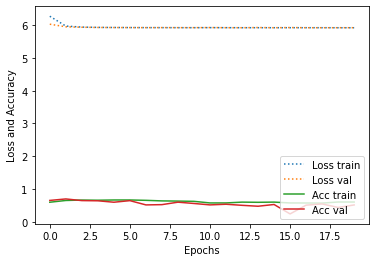

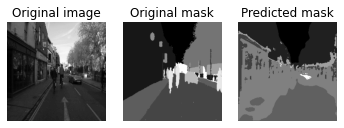

In [ ]:
# Copy and Paste from above

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_val_loss, linestyle = 'dotted',  label='Loss val')
plt.plot(log_train_acc, label='Acc train')
plt.plot(log_val_acc, label='Acc val')
plt.legend(loc='lower right')
plt.show()

# Obtain a sample
im, mask = next(iter(val_dl))

# Feedforward
_mask = model(im)

_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

In [ ]:
# solution b)

# replace the Adam by te SGD

Solution c) ......

--------------------------------
# References

[1] Conditional Random Fields as Recurrent Neural Networks

[2] Kishore and Reddy, A modern computer vision with Pytorch, Packt, 2020.